**CAPTCHA Breaker**

CAPTCHA is a computer program or system intended to distinguish human from machine input, typically as a way of thwarting spam and automated extraction of data from websites.

The goal of this notebook is to train a model that will recognize the characters in a noisy captcha image the same way humans would. <br>


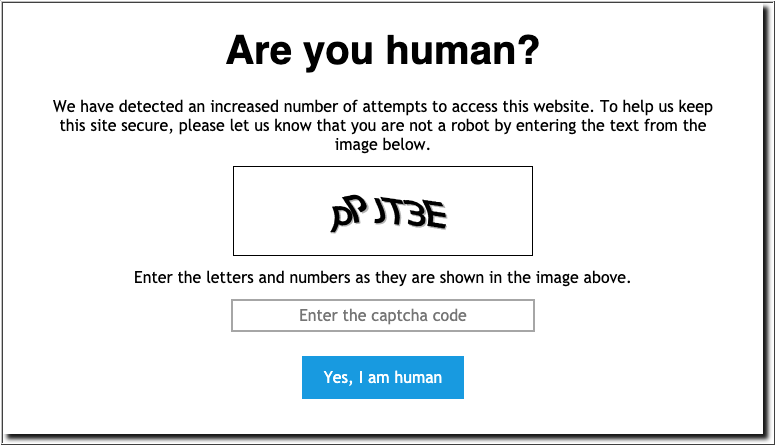

Importing the necessary libraties and packages

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
import uuid # for generating random filenames
import string

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F

from pathlib import Path
from collections import Counter

This notebook makes use of the Kaggle dataset: *Captchas images (labeled)* that can be accessed on the following link: https://www.kaggle.com/datasets/huzaifakhilawala/teltest-captcha-images-renamed?resource=download&fbclid=IwAR2pfUjLMcT7wpJV1BTocwNUkfvj7igBOhtOYms7pTlWNuWnkOOvwt0Dw3I .

It originally contains 501 CAPTCHA images. During the preprocessing, 41 images were excluded.

In [36]:
# Path to the data directory
data_dir = Path("C:\\Users\\angelamadjar\\Documents\\Downloads\\archive (1)\\teltest2")

# Get list of all the images
images = sorted(list(map(str, list(data_dir.glob("*.png")))))

# Get the labels of the images
labels = [img.split(os.path.sep)[-1].split(".png")[0] for img in images]

# Get all of the unique caracters contained in the labels
characters = set(char for label in labels for char in label)

print("Number of images found: ", len(images))
print("Number of labels found: ", len(labels))
print("Number of unique characters: ", len(characters))
print(f"Characters present: {characters}")

Number of images found:  460
Number of labels found:  460
Number of unique characters:  36
Characters present: {'U', '8', '9', 'S', '7', '6', 'L', 'W', '2', 'C', 'A', '1', 'K', 'H', '3', 'E', 'N', 'R', 'V', 'P', 'Y', 'D', 'F', 'Z', 'T', '5', '0', 'I', 'J', 'G', 'Q', '4', 'M', 'B', 'O', 'X'}


**Idea explanation and demonstration**

The idea of this project is to first remove any background noice in the CAPTCHA images, recognize the characters in it and split them into sepparate images. 

The model is trained with 80% of the images splitted in such a way and tested with 20% to check the accuracy of the model. 

When a new captcha image is passed in the model, it first preprocesses it, then splits its characters, classifies the label of each character and then appends the string value of each character in the captcha image, leading to the desired output.

<class 'numpy.ndarray'>
(50, 180, 3)


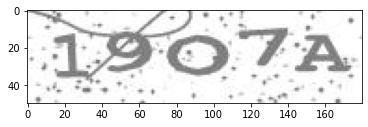

In [51]:
# reading a sample image and visualizing it
img = cv2.imread("C:\\Users\\angelamadjar\\Documents\\Downloads\\archive (1)\\teltest2\\19O7A.png")

print(type(img))

print(img.shape)

plt.imshow(img)

## Preprocessing

### Median Blur Filter

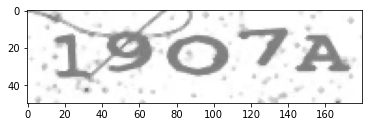

In [52]:
# if we take a look at the captchas, it is noticeable that the background noice is (kinda) Gaussian noice. 
# thus, we apply the Median filter since it can preserve the edges of the image during noice removal

srcImage = cv2.medianBlur(img, 3)
plt.imshow(srcImage)

### Binary threshold

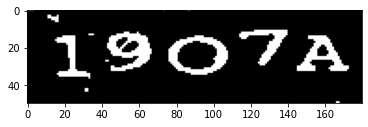

In [53]:
# applying a thresholding method to make the image binary

threshold = 150 # obtained through experimentation
ret, threshImage = cv2.threshold(srcImage, threshold, 255, cv2.THRESH_BINARY_INV)
plt.imshow(threshImage)

### Dilate filter

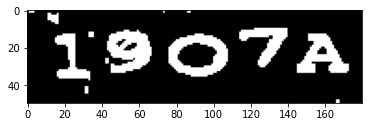

In [40]:
# the dilate filter thickens the edges in an image
# by trying different filters with different values, it was concluded that dilate contributes to acheiving best results

image = cv2.dilate(threshImage, np.ones((3, 1), np.uint8))
plt.imshow(image)

### Erode filter

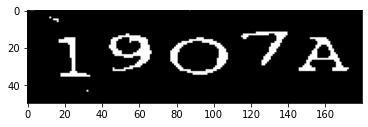

In [28]:
# contrary to the dilate filter, the erode filter thins out the edges in an image
# decided to skip this cell

image = cv2.erode(threshImage, np.ones((2, 2), np.uint8))
plt.imshow(image)

### Detecting Connected Components

(50, 180, 3)

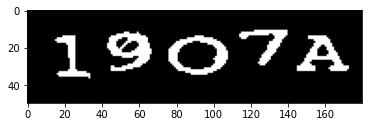

In [56]:
# connectedComponentsWithStats computes the connected components labeled image of boolean image
# it further reduces any potential noice

grayscale = cv2.cvtColor(threshImage, cv2.COLOR_BGR2GRAY)

min_connected_len = 15

# get connected components
numLabel, labelImage, stats, centroids = cv2.connectedComponentsWithStats(grayscale, 8, cv2.CV_32S)

# holds if component will be included to foreground
foreComps = [i for i in range(1, numLabel) if stats[i, cv2.CC_STAT_AREA] >= min_connected_len]

# Get binary image after erasing some connected components those areas under the threshold
binaryImage = np.zeros_like(srcImage)
labelImage = np.array(labelImage)
for k in [np.where(labelImage == i) for i in foreComps]:
    binaryImage[k] = 255
    
plt.imshow(binaryImage)
binaryImage.shape

### Removing unnecessary background

(26, 168, 3)

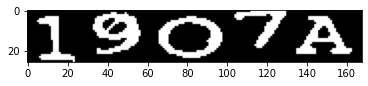

In [57]:
# cutting out the background around the characters in the captcha
# in this way, we handle any leftover noice located at the edges of the images

minCol = 10; # seen that most digits start at 10th column 

# find the boundaries where characters are present in the image 
array = np.array([stats[i, cv2.CC_STAT_LEFT] + stats[i, cv2.CC_STAT_WIDTH]  for i in foreComps])
maxCol = max(array[np.where(array < 180)]) # observed that digits right boundary never exceeds 180th pixel 
                                           # thus this one prevents false boundaries
# find boundaries in y axis
minRow = min([stats[i, cv2.CC_STAT_TOP] for i in foreComps])
maxRow = max([stats[i, cv2.CC_STAT_TOP] + stats[i, cv2.CC_STAT_HEIGHT] for i in foreComps])

subImage = binaryImage[minRow:maxRow, minCol:maxCol+5]
plt.imshow(subImage)
subImage.shape

### Canny Edge Detector

Coordinates of each character: [  4  24  31  56  64  97 103 129 133 162]
Image shape: (26, 168, 4)


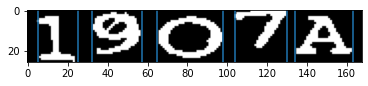

In [58]:
# Since the idea is to make each character a sepparate image in order to be able to recognize it,
# it is first needed to calculate the starting and ending point at the x coordinate of each character in the image

# to achieve this, we make use of the Canny Edge detector that searches for black-pixelled vertical lines before and after
# each detected edge

img = cv2.cvtColor(subImage, cv2.IMREAD_GRAYSCALE)
edges = cv2.Canny(img,100,200)
vertical_sum = np.sum(edges, axis=0)
vertical_sum = vertical_sum != 0
changes = np.logical_xor(vertical_sum[1:], vertical_sum[:-1])
change_pts = np.nonzero(changes)[0]

print(f"Coordinates of each character: {change_pts}")
print(f"Image shape: {img.shape}") # x=180, y=50

plt.imshow(img)
for change in change_pts:
    plt.axvline(change+1)
plt.show()

### Splitting the characters

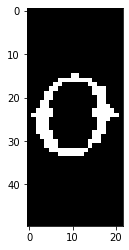

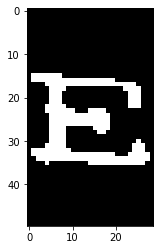

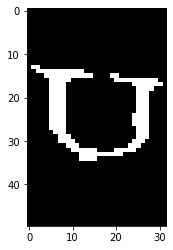

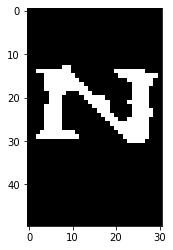

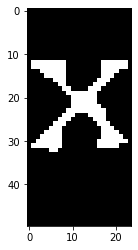

In [20]:
# a helper function that makes iterating 2x2 elements possible
def pairwise(iterable):
    # "s -> (s0, s1), (s2, s3), (s4, s5), ..."
    a = iter(iterable)
    return zip(a, a)

chars = []
# cutting out each detected character as a sepparate image
for x, y in pairwise(change_pts):
    # image[start_x:end_x, start_y:end_y] 
    crop = img[0:50, x:y+2]
    chars.append(crop)
    
for char in chars:
    plt.imshow(char)
    plt.show()

# Generalization for the whole dataset

In [10]:
# some paths and constants used in the code

# Path to the data directory
data_dir = Path("C:\\Users\\angelamadjar\\Documents\\Downloads\\archive (1)\\teltest2")

# Get list of all the images
images = sorted(list(map(str, list(data_dir.glob("*.png")))))
labels = [img.split(os.path.sep)[-1].split(".png")[0] for img in images]

# Inverse Binary Threshold
threshold = 150 

# Minimum Lenght of a Connected Component
min_connected_len = 15

# Path for saving the divided images
save_to = "E:\\OpenCV\\Characters"

## Preprocessing

Applying all of the filters and techniques for preprocessing in the function bellow

In [2]:
def preprocessing(input_img):
     # reading the input image
    img = cv2.imread(input_img)
    
    # applying a filter to reduce the gaussian noice in the background
    srcImage = cv2.medianBlur(img, 3)
    
    # applying an inverse binary threshold to further reduce the noice
    ret, threshImage = cv2.threshold(srcImage, threshold, 255, cv2.THRESH_BINARY_INV)

    # applying a dilate filter to thicken the detected characters and the potential noice that has remained
    image = cv2.dilate(threshImage, np.ones((2, 1), np.uint8))
    
    # appluing an erode filter to help in the removal of the thickened noice - better off without it
    #image = cv2.erode(image, np.ones((2, 2), np.uint8))
    
    # converting the image to grayscale, so that applying connectedComponentsWithStats is possible
    grayscale = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # detecting connected components to further eliminate any noice
    numLabel, labelImage, stats, centroids = cv2.connectedComponentsWithStats(grayscale, 8, cv2.CV_32S) # get connected components
    foreComps = [i for i in range(1, numLabel) if stats[i, cv2.CC_STAT_AREA] >= min_connected_len] # holds if component will be included to foreground
    binaryImage = np.zeros_like(srcImage) # Get binary image after erasing some connected components
    labelImage = np.array(labelImage)     # those areas under the threshold
    for k in [np.where(labelImage == i) for i in foreComps]:
        binaryImage[k] = 255
        
    # remove unnecessary background    
    minCol = 10; # seen that all digits start at 10th column         
    # find the boundaries where characters are present in the image 
    array = np.array([stats[i, cv2.CC_STAT_LEFT] + stats[i, cv2.CC_STAT_WIDTH]  for i in foreComps])
    maxCol = max(array[np.where(array < 180)]) # observed that digits right boundary never exceeds 125th pixel 
                                               # thus this one prevents false boundaries
    # find boundaries in y axis
    minRow = min([stats[i, cv2.CC_STAT_TOP] for i in foreComps])
    maxRow = max([stats[i, cv2.CC_STAT_TOP] + stats[i, cv2.CC_STAT_HEIGHT] for i in foreComps])

    subImage = binaryImage[minRow:maxRow, minCol:maxCol+5]
    
    # returning the preproccessed image    
    return subImage

## Splitting the characters

In [2]:
# splitting the characters using Canny Edge Detector

def split_chars(input_img):
    img = cv2.cvtColor(input_img, cv2.IMREAD_GRAYSCALE)
    edges = cv2.Canny(img,100,200)
    vertical_sum = np.sum(edges, axis=0)
    vertical_sum = vertical_sum != 0
    changes = np.logical_xor(vertical_sum[1:], vertical_sum[:-1])
    change_pts = np.nonzero(changes)[0]
    
    # returning the x1, x2 coordinates of each character in the image, 
    # where the x1 is the starting point and x2 is the ending point of the character
    # returning the image itself as well
    return change_pts, img

## Saving the splitted characters

The process of creating 36 distinct folders (categories) and putting each character-image to the folder it belongs to is automated with the function bellow.

Since the images are already labeled, a captcha with the characters 02KKK is named 02KKK.png. 
All of the labels are stored in the *labels* list.

Thus, (e.g.) for the first subimage of 02KKK - that is 0 -,  <br>
we take the first character of the label of the image 02KKK - that is 0 - and we check if a folder named 0 exists. <br>
If it does, we save the subimage in the 0 folder. <br>
If not, we create a folder named 0 and then save the subimage 0 in it. <br>

In [71]:
# change_pts  - x1,x2 coordinates of each image
# input_image - the image that should be splitted 
# characters  - the label of the image that should be splitted

def save_chars(change_pts, input_img, characters):
    char=0 # start with the first character of the label
    
    for x, y in pairwise(change_pts):
        print(x,y)
        print(change_pts)
        
        # image[start_x:end_x, start_y:end_y]
        crop = input_img[0:50, x:y+2] # crop a subimage between x1,x2
        
        plt.imshow(crop)
        plt.show()
        
        if os.path.exists("E:\\OpenCV\\Characters\\"+characters[char]) is True:
            print("entered if")
            print(characters)
            print(characters[char])
            cv2.imwrite(os.path.join("E:\\OpenCV\\Characters\\"+characters[char], str(uuid.uuid4())+'.png'), crop)
            print("saved an img " + characters[char])
            cv2.waitKey(0)
            char+=1 # go to the next character in the label
        else:
            print("entered else")
            os.mkdir("E:\\OpenCV\\Characters\\"+characters[char])
            print("created a dir " + characters[char])
            cv2.imwrite(os.path.join("E:\\OpenCV\\Characters\\"+characters[char], str(uuid.uuid4())+'.png'), crop)
            print("saved an img" + characters[char])
            cv2.waitKey(0)
            char+=1 # go to the next character in the label

In [13]:
# helper function for iterating 2 by 2 elements
def pairwise(iterable):
    a = iter(iterable)
    return zip(a, a)

Looping through the whole dataset. For each image, the preprocessing function is invoked. 

The splitting coords are calculated on the preprocessed image

The choords, the current image and a list of the characters in its label are passed in the save_chars method.

['0', '2', 'K', 'K', 'K']
4 25
[  4  25  32  56  65  96 105 133 135 160]


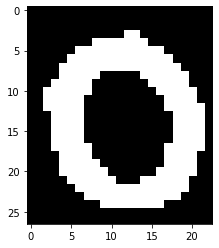

entered else
created a dir 0
saved an img0
32 56
[  4  25  32  56  65  96 105 133 135 160]


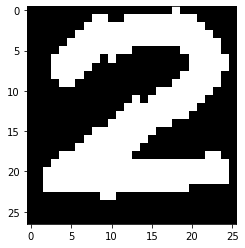

entered else
created a dir 2
saved an img2
65 96
[  4  25  32  56  65  96 105 133 135 160]


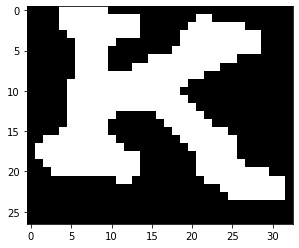

entered else
created a dir K
saved an imgK
105 133
[  4  25  32  56  65  96 105 133 135 160]


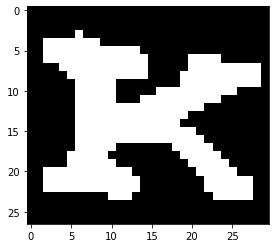

entered if
['0', '2', 'K', 'K', 'K']
K
saved an img K
135 160
[  4  25  32  56  65  96 105 133 135 160]


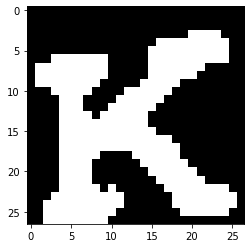

entered if
['0', '2', 'K', 'K', 'K']
K
saved an img K
['0', '2', 'L', 'Q', 'A']
1 2
[  1   2  23  30  55  66 131 133 159]


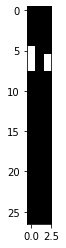

entered if
['0', '2', 'L', 'Q', 'A']
0
saved an img 0
23 30
[  1   2  23  30  55  66 131 133 159]


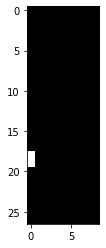

entered if
['0', '2', 'L', 'Q', 'A']
2
saved an img 2
55 66
[  1   2  23  30  55  66 131 133 159]


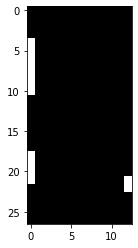

entered else
created a dir L
saved an imgL
131 133
[  1   2  23  30  55  66 131 133 159]


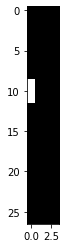

entered else
created a dir Q
saved an imgQ
['0', 'D', 'J', 'Z', '6']
25 30
[ 25  30  58  66  94 105 130 140 162]


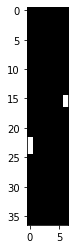

entered if
['0', 'D', 'J', 'Z', '6']
0
saved an img 0
58 66
[ 25  30  58  66  94 105 130 140 162]


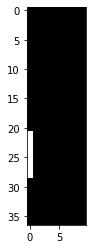

entered else
created a dir D
saved an imgD
94 105
[ 25  30  58  66  94 105 130 140 162]


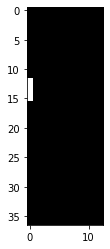

entered else
created a dir J
saved an imgJ
130 140
[ 25  30  58  66  94 105 130 140 162]


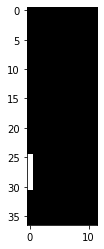

entered else
created a dir Z
saved an imgZ
['0', 'E', 'U', 'N', 'X']
2 24
[  2  24  31  60  65  97 101 131 134 159]


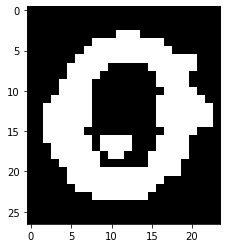

entered if
['0', 'E', 'U', 'N', 'X']
0
saved an img 0
31 60
[  2  24  31  60  65  97 101 131 134 159]


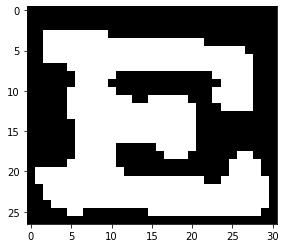

entered else
created a dir E
saved an imgE
65 97
[  2  24  31  60  65  97 101 131 134 159]


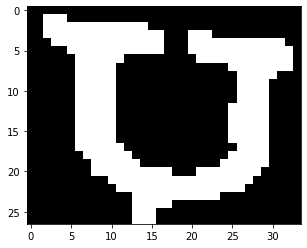

entered else
created a dir U
saved an imgU
101 131
[  2  24  31  60  65  97 101 131 134 159]


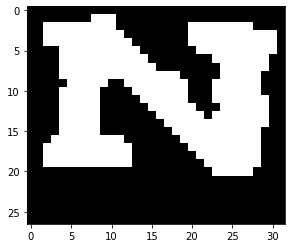

entered else
created a dir N
saved an imgN
134 159
[  2  24  31  60  65  97 101 131 134 159]


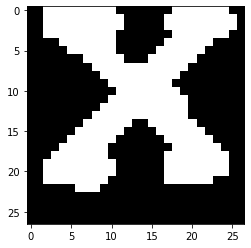

entered else
created a dir X
saved an imgX
['0', 'G', 'C', 'O', 'S']
2 22
[  2  22  31  60  61  95 104 129 136 155]


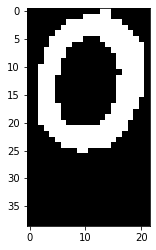

entered if
['0', 'G', 'C', 'O', 'S']
0
saved an img 0
31 60
[  2  22  31  60  61  95 104 129 136 155]


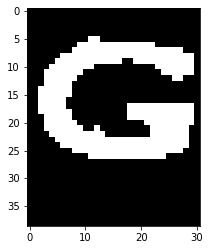

entered else
created a dir G
saved an imgG
61 95
[  2  22  31  60  61  95 104 129 136 155]


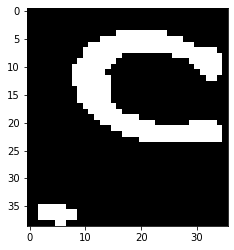

entered else
created a dir C
saved an imgC
104 129
[  2  22  31  60  61  95 104 129 136 155]


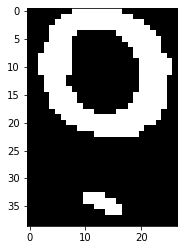

entered else
created a dir O
saved an imgO
136 155
[  2  22  31  60  61  95 104 129 136 155]


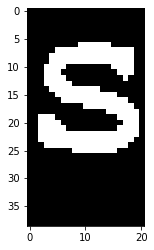

entered else
created a dir S
saved an imgS
['0', 'G', 'L', 'R', 'Z']
5 23
[  5  23  29  59  69  98 102 131 134]


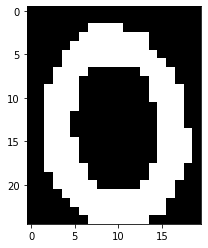

entered if
['0', 'G', 'L', 'R', 'Z']
0
saved an img 0
29 59
[  5  23  29  59  69  98 102 131 134]


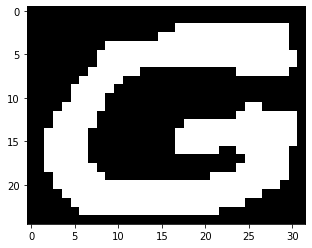

entered if
['0', 'G', 'L', 'R', 'Z']
G
saved an img G
69 98
[  5  23  29  59  69  98 102 131 134]


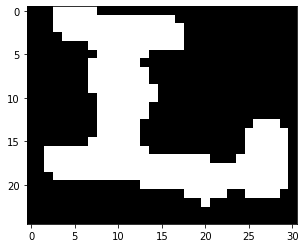

entered if
['0', 'G', 'L', 'R', 'Z']
L
saved an img L
102 131
[  5  23  29  59  69  98 102 131 134]


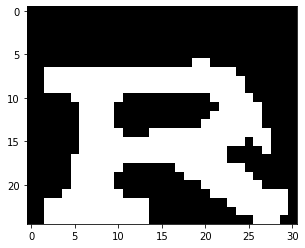

entered else
created a dir R
saved an imgR
['0', 'G', 'M', 'Q', 'Y']
4 22
[  4  22  30  60  65 100 102 132 133 158]


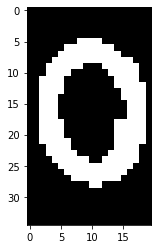

entered if
['0', 'G', 'M', 'Q', 'Y']
0
saved an img 0
30 60
[  4  22  30  60  65 100 102 132 133 158]


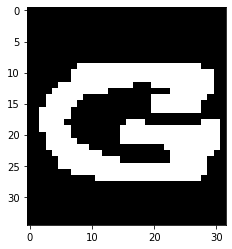

entered if
['0', 'G', 'M', 'Q', 'Y']
G
saved an img G
65 100
[  4  22  30  60  65 100 102 132 133 158]


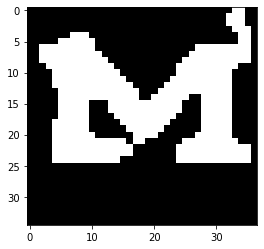

entered else
created a dir M
saved an imgM
102 132
[  4  22  30  60  65 100 102 132 133 158]


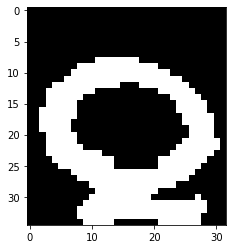

entered if
['0', 'G', 'M', 'Q', 'Y']
Q
saved an img Q
133 158
[  4  22  30  60  65 100 102 132 133 158]


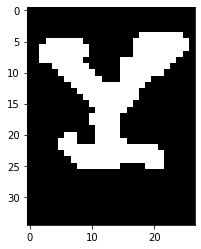

entered else
created a dir Y
saved an imgY
['0', 'I', 'Q', 'Z', '1']
3 23
[  3  23  36  59  67  96 105 132 140 157]


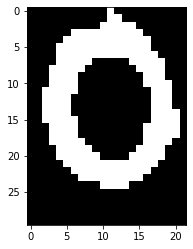

entered if
['0', 'I', 'Q', 'Z', '1']
0
saved an img 0
36 59
[  3  23  36  59  67  96 105 132 140 157]


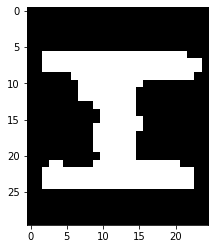

entered else
created a dir I
saved an imgI
67 96
[  3  23  36  59  67  96 105 132 140 157]


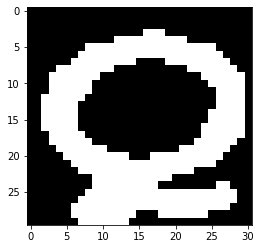

entered if
['0', 'I', 'Q', 'Z', '1']
Q
saved an img Q
105 132
[  3  23  36  59  67  96 105 132 140 157]


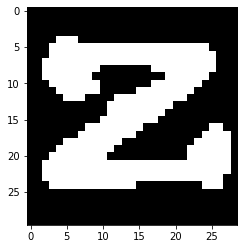

entered if
['0', 'I', 'Q', 'Z', '1']
Z
saved an img Z
140 157
[  3  23  36  59  67  96 105 132 140 157]


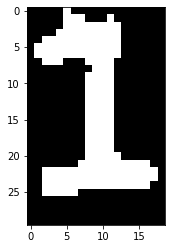

entered else
created a dir 1
saved an img1
['0', 'J', '5', '2', 'D']
4 23
[  4  23  32  62  69  94 104 130 135 159]


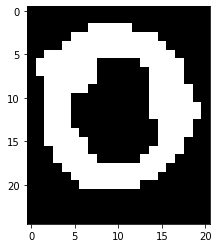

entered if
['0', 'J', '5', '2', 'D']
0
saved an img 0
32 62
[  4  23  32  62  69  94 104 130 135 159]


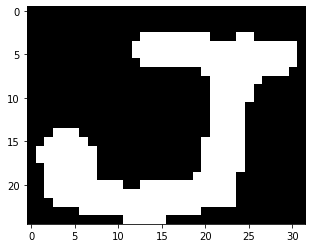

entered if
['0', 'J', '5', '2', 'D']
J
saved an img J
69 94
[  4  23  32  62  69  94 104 130 135 159]


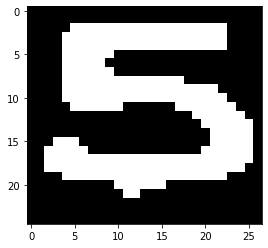

entered else
created a dir 5
saved an img5
104 130
[  4  23  32  62  69  94 104 130 135 159]


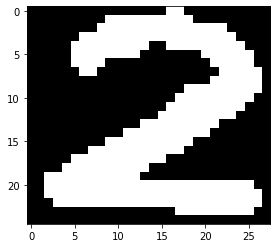

entered if
['0', 'J', '5', '2', 'D']
2
saved an img 2
135 159
[  4  23  32  62  69  94 104 130 135 159]


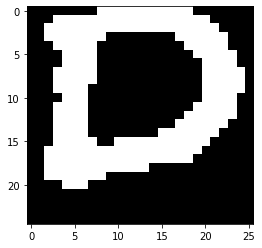

entered if
['0', 'J', '5', '2', 'D']
D
saved an img D
['0', 'J', 'S', '2', '1']
6 25
[  6  25  30  61  64  94 105 130 139 155]


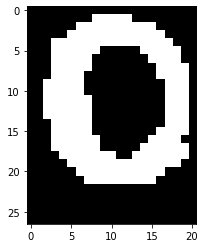

entered if
['0', 'J', 'S', '2', '1']
0
saved an img 0
30 61
[  6  25  30  61  64  94 105 130 139 155]


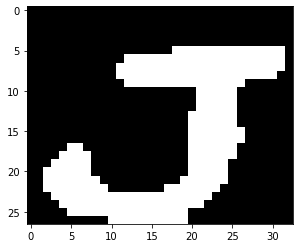

entered if
['0', 'J', 'S', '2', '1']
J
saved an img J
64 94
[  6  25  30  61  64  94 105 130 139 155]


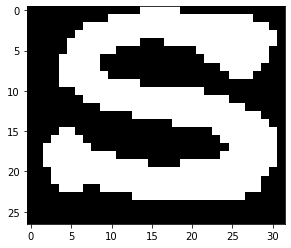

entered if
['0', 'J', 'S', '2', '1']
S
saved an img S
105 130
[  6  25  30  61  64  94 105 130 139 155]


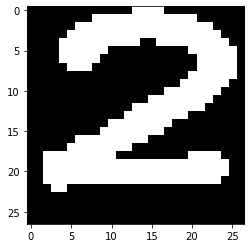

entered if
['0', 'J', 'S', '2', '1']
2
saved an img 2
139 155
[  6  25  30  61  64  94 105 130 139 155]


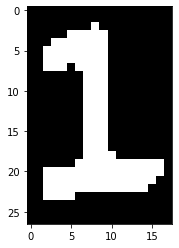

entered if
['0', 'J', 'S', '2', '1']
1
saved an img 1
['0', 'P', 'B', 'P', '7']
28 32
[ 28  32  58  66  94 107 134 139 158]


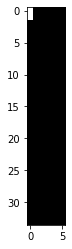

entered if
['0', 'P', 'B', 'P', '7']
0
saved an img 0
58 66
[ 28  32  58  66  94 107 134 139 158]


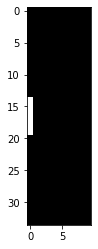

entered else
created a dir P
saved an imgP
94 107
[ 28  32  58  66  94 107 134 139 158]


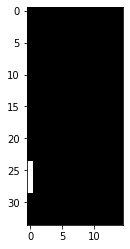

entered else
created a dir B
saved an imgB
134 139
[ 28  32  58  66  94 107 134 139 158]


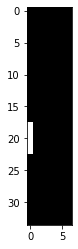

entered if
['0', 'P', 'B', 'P', '7']
P
saved an img P
['0', 'Q', '2', 'P', 'O']
4 24
[  4  24  31  62  69  94 106 131 135 160]


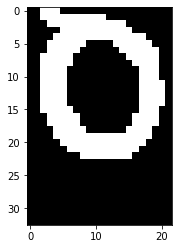

entered if
['0', 'Q', '2', 'P', 'O']
0
saved an img 0
31 62
[  4  24  31  62  69  94 106 131 135 160]


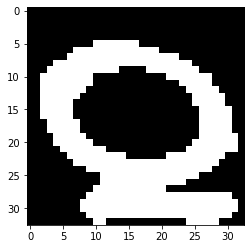

entered if
['0', 'Q', '2', 'P', 'O']
Q
saved an img Q
69 94
[  4  24  31  62  69  94 106 131 135 160]


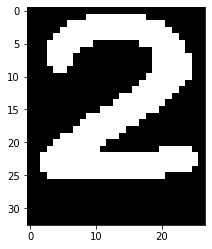

entered if
['0', 'Q', '2', 'P', 'O']
2
saved an img 2
106 131
[  4  24  31  62  69  94 106 131 135 160]


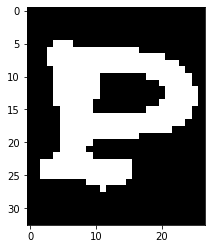

entered if
['0', 'Q', '2', 'P', 'O']
P
saved an img P
135 160
[  4  24  31  62  69  94 106 131 135 160]


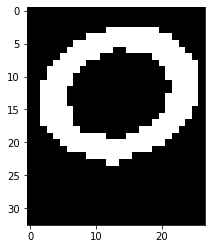

entered if
['0', 'Q', '2', 'P', 'O']
O
saved an img O
['0', 'R', 'A', 'T', '7']
1 22
[  1  22  31  98 104 134 138 159]


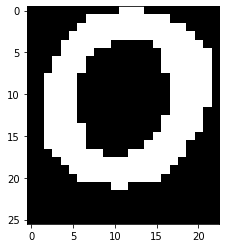

entered if
['0', 'R', 'A', 'T', '7']
0
saved an img 0
31 98
[  1  22  31  98 104 134 138 159]


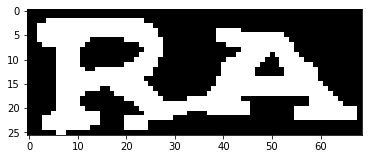

entered if
['0', 'R', 'A', 'T', '7']
R
saved an img R
104 134
[  1  22  31  98 104 134 138 159]


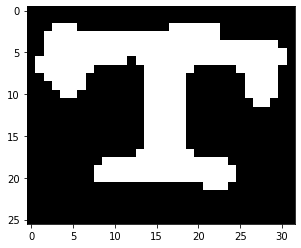

entered else
created a dir A
saved an imgA
138 159
[  1  22  31  98 104 134 138 159]


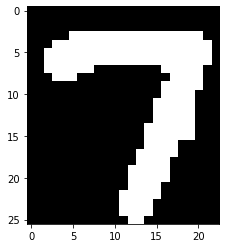

entered else
created a dir T
saved an imgT
['0', 'Y', 'K', 'J', '9']
5 24
[  5  24  29  57  65  96 103 133 140 159]


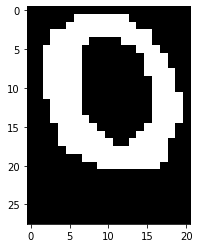

entered if
['0', 'Y', 'K', 'J', '9']
0
saved an img 0
29 57
[  5  24  29  57  65  96 103 133 140 159]


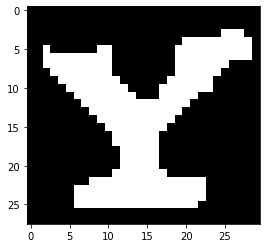

entered if
['0', 'Y', 'K', 'J', '9']
Y
saved an img Y
65 96
[  5  24  29  57  65  96 103 133 140 159]


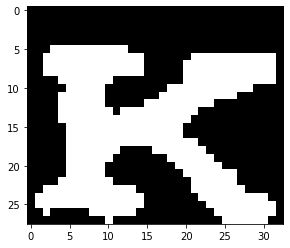

entered if
['0', 'Y', 'K', 'J', '9']
K
saved an img K
103 133
[  5  24  29  57  65  96 103 133 140 159]


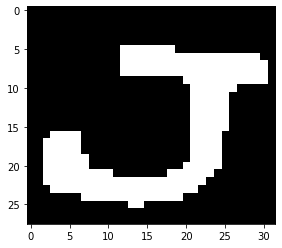

entered if
['0', 'Y', 'K', 'J', '9']
J
saved an img J
140 159
[  5  24  29  57  65  96 103 133 140 159]


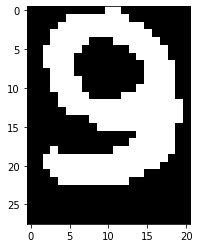

entered else
created a dir 9
saved an img9
['0', 'Y', 'N', 'C', 'Y']
5 23
[  5  23  31  61  62  94 101 130 132 156]


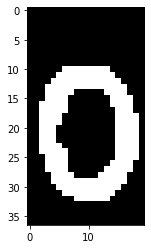

entered if
['0', 'Y', 'N', 'C', 'Y']
0
saved an img 0
31 61
[  5  23  31  61  62  94 101 130 132 156]


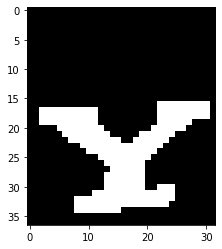

entered if
['0', 'Y', 'N', 'C', 'Y']
Y
saved an img Y
62 94
[  5  23  31  61  62  94 101 130 132 156]


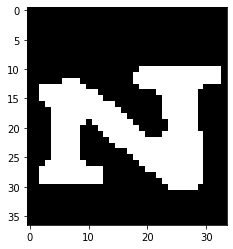

entered if
['0', 'Y', 'N', 'C', 'Y']
N
saved an img N
101 130
[  5  23  31  61  62  94 101 130 132 156]


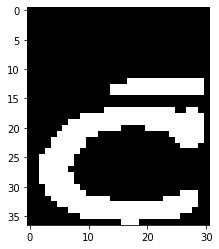

entered if
['0', 'Y', 'N', 'C', 'Y']
C
saved an img C
132 156
[  5  23  31  61  62  94 101 130 132 156]


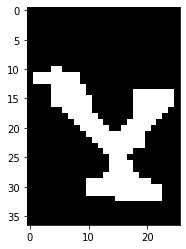

entered if
['0', 'Y', 'N', 'C', 'Y']
Y
saved an img Y
['0', 'Y', 'Y', '4', '5']
22 31
[ 22  31  60  68  98 106 131 140 161]


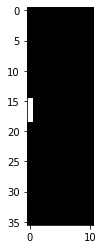

entered if
['0', 'Y', 'Y', '4', '5']
0
saved an img 0
60 68
[ 22  31  60  68  98 106 131 140 161]


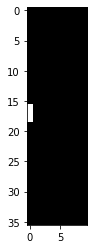

entered if
['0', 'Y', 'Y', '4', '5']
Y
saved an img Y
98 106
[ 22  31  60  68  98 106 131 140 161]


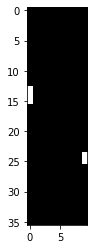

entered if
['0', 'Y', 'Y', '4', '5']
Y
saved an img Y
131 140
[ 22  31  60  68  98 106 131 140 161]


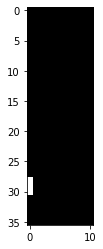

entered else
created a dir 4
saved an img4
['1', '2', '5', '8', '3']
6 22
[  6  22  30  57  70  95 106 129 141 158]


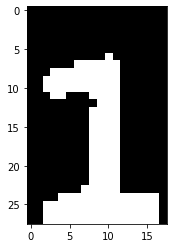

entered if
['1', '2', '5', '8', '3']
1
saved an img 1
30 57
[  6  22  30  57  70  95 106 129 141 158]


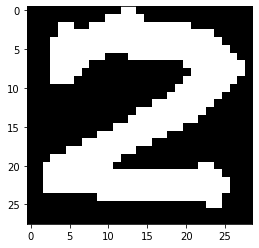

entered if
['1', '2', '5', '8', '3']
2
saved an img 2
70 95
[  6  22  30  57  70  95 106 129 141 158]


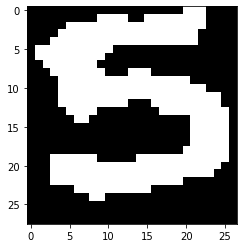

entered if
['1', '2', '5', '8', '3']
5
saved an img 5
106 129
[  6  22  30  57  70  95 106 129 141 158]


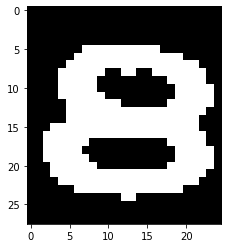

entered else
created a dir 8
saved an img8
141 158
[  6  22  30  57  70  95 106 129 141 158]


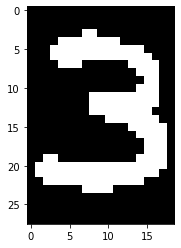

entered else
created a dir 3
saved an img3
['1', '2', 'Q', 'E', 'B']
4 22
[  4  22  31  56  67  97 101 133 134 162]


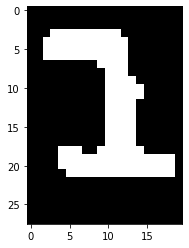

entered if
['1', '2', 'Q', 'E', 'B']
1
saved an img 1
31 56
[  4  22  31  56  67  97 101 133 134 162]


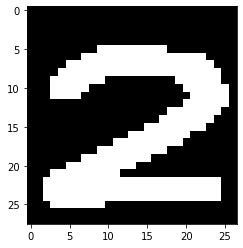

entered if
['1', '2', 'Q', 'E', 'B']
2
saved an img 2
67 97
[  4  22  31  56  67  97 101 133 134 162]


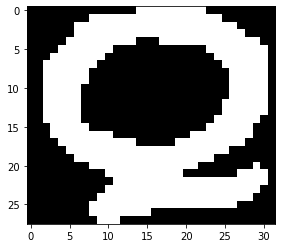

entered if
['1', '2', 'Q', 'E', 'B']
Q
saved an img Q
101 133
[  4  22  31  56  67  97 101 133 134 162]


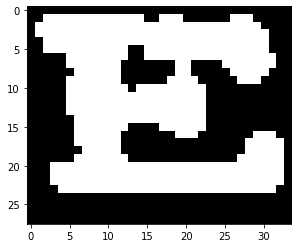

entered if
['1', '2', 'Q', 'E', 'B']
E
saved an img E
134 162
[  4  22  31  56  67  97 101 133 134 162]


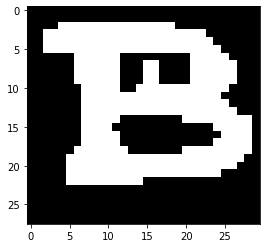

entered if
['1', '2', 'Q', 'E', 'B']
B
saved an img B
['1', '4', 'F', '9', 'W']
4 20
[  4  20  30  48  49  54  62  99 105 161]


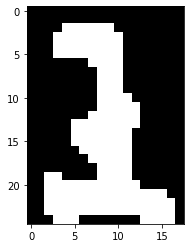

entered if
['1', '4', 'F', '9', 'W']
1
saved an img 1
30 48
[  4  20  30  48  49  54  62  99 105 161]


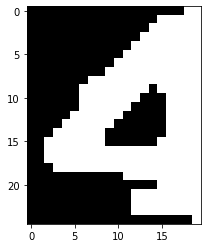

entered if
['1', '4', 'F', '9', 'W']
4
saved an img 4
49 54
[  4  20  30  48  49  54  62  99 105 161]


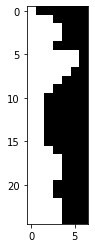

entered else
created a dir F
saved an imgF
62 99
[  4  20  30  48  49  54  62  99 105 161]


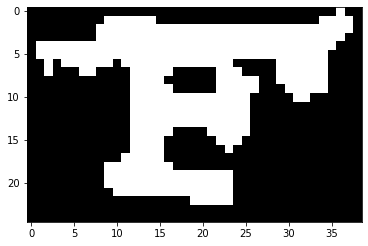

entered if
['1', '4', 'F', '9', 'W']
9
saved an img 9
105 161
[  4  20  30  48  49  54  62  99 105 161]


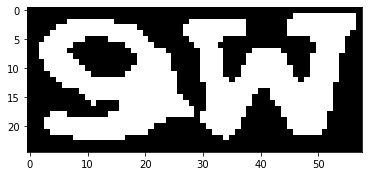

entered else
created a dir W
saved an imgW
['1', '7', '3', 'V', '6']
4 20
[  4  20  34  56  71  94  96 131 136 156]


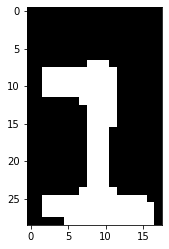

entered if
['1', '7', '3', 'V', '6']
1
saved an img 1
34 56
[  4  20  34  56  71  94  96 131 136 156]


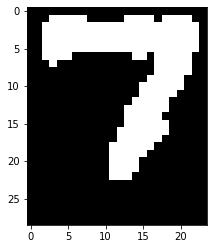

entered else
created a dir 7
saved an img7
71 94
[  4  20  34  56  71  94  96 131 136 156]


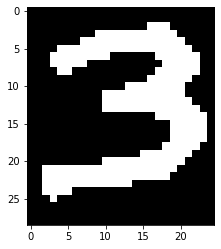

entered if
['1', '7', '3', 'V', '6']
3
saved an img 3
96 131
[  4  20  34  56  71  94  96 131 136 156]


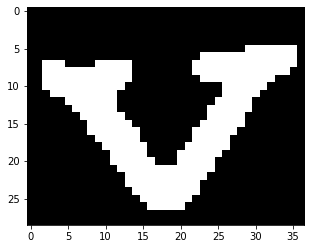

entered else
created a dir V
saved an imgV
136 156
[  4  20  34  56  71  94  96 131 136 156]


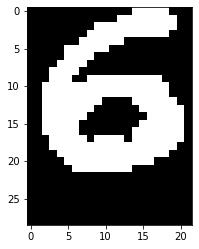

entered else
created a dir 6
saved an img6
['1', '9', 'O', '7', 'A']
24 31
[ 24  31  56  64  97 102 129 133 162]


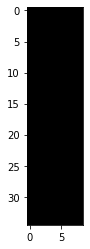

entered if
['1', '9', 'O', '7', 'A']
1
saved an img 1
56 64
[ 24  31  56  64  97 102 129 133 162]


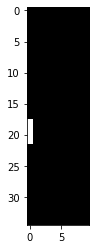

entered if
['1', '9', 'O', '7', 'A']
9
saved an img 9
97 102
[ 24  31  56  64  97 102 129 133 162]


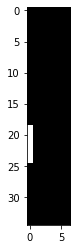

entered if
['1', '9', 'O', '7', 'A']
O
saved an img O
129 133
[ 24  31  56  64  97 102 129 133 162]


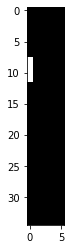

entered if
['1', '9', 'O', '7', 'A']
7
saved an img 7
['1', 'C', 'Y', 'T', 'C']
5 24
[  5  24  31  61  71  98  99 129 134 157]


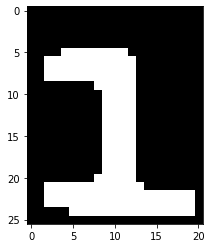

entered if
['1', 'C', 'Y', 'T', 'C']
1
saved an img 1
31 61
[  5  24  31  61  71  98  99 129 134 157]


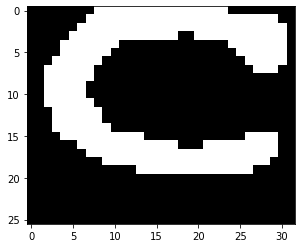

entered if
['1', 'C', 'Y', 'T', 'C']
C
saved an img C
71 98
[  5  24  31  61  71  98  99 129 134 157]


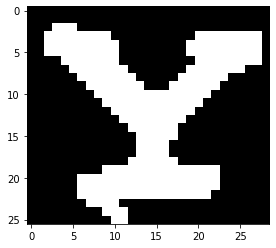

entered if
['1', 'C', 'Y', 'T', 'C']
Y
saved an img Y
99 129
[  5  24  31  61  71  98  99 129 134 157]


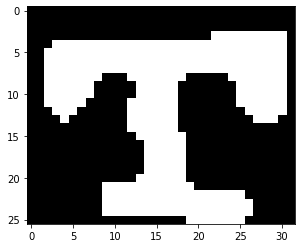

entered if
['1', 'C', 'Y', 'T', 'C']
T
saved an img T
134 157
[  5  24  31  61  71  98  99 129 134 157]


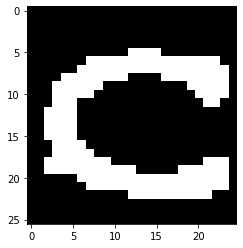

entered if
['1', 'C', 'Y', 'T', 'C']
C
saved an img C
['1', 'F', '6', 'Y', 'N']
6 23
[  6  23  31  61  70 129 138 162]


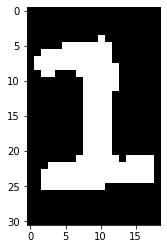

entered if
['1', 'F', '6', 'Y', 'N']
1
saved an img 1
31 61
[  6  23  31  61  70 129 138 162]


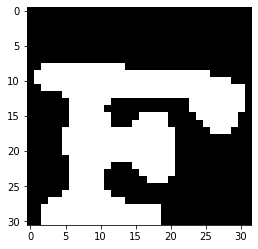

entered if
['1', 'F', '6', 'Y', 'N']
F
saved an img F
70 129
[  6  23  31  61  70 129 138 162]


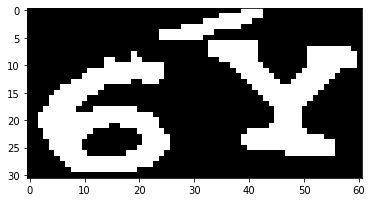

entered if
['1', 'F', '6', 'Y', 'N']
6
saved an img 6
138 162
[  6  23  31  61  70 129 138 162]


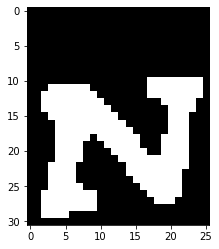

entered if
['1', 'F', '6', 'Y', 'N']
Y
saved an img Y
['1', 'H', 'C', '8', 'W']
3 21
[  3  21  29  57  66  95 103 128 136 162]


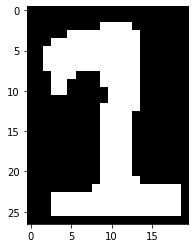

entered if
['1', 'H', 'C', '8', 'W']
1
saved an img 1
29 57
[  3  21  29  57  66  95 103 128 136 162]


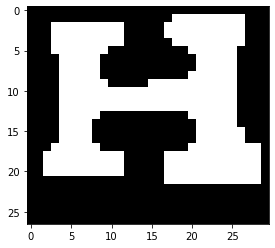

entered else
created a dir H
saved an imgH
66 95
[  3  21  29  57  66  95 103 128 136 162]


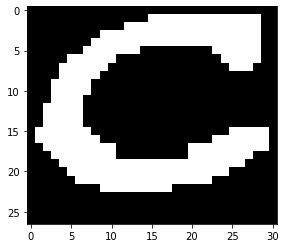

entered if
['1', 'H', 'C', '8', 'W']
C
saved an img C
103 128
[  3  21  29  57  66  95 103 128 136 162]


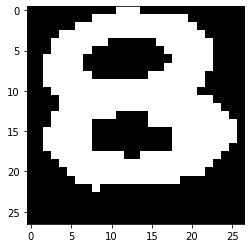

entered if
['1', 'H', 'C', '8', 'W']
8
saved an img 8
136 162
[  3  21  29  57  66  95 103 128 136 162]


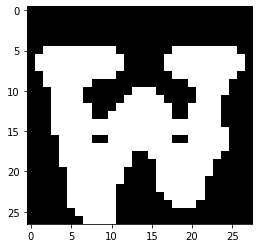

entered if
['1', 'H', 'C', '8', 'W']
W
saved an img W
['1', 'K', 'L', 'H', 'C']
7 23
[  7  23  30  62  67  98 100 132 134 160]


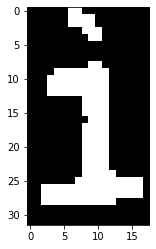

entered if
['1', 'K', 'L', 'H', 'C']
1
saved an img 1
30 62
[  7  23  30  62  67  98 100 132 134 160]


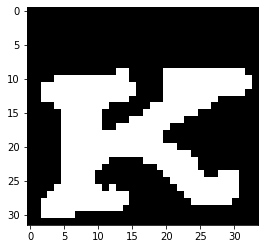

entered if
['1', 'K', 'L', 'H', 'C']
K
saved an img K
67 98
[  7  23  30  62  67  98 100 132 134 160]


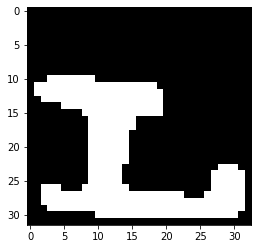

entered if
['1', 'K', 'L', 'H', 'C']
L
saved an img L
100 132
[  7  23  30  62  67  98 100 132 134 160]


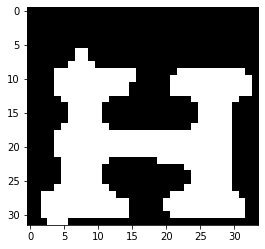

entered if
['1', 'K', 'L', 'H', 'C']
H
saved an img H
134 160
[  7  23  30  62  67  98 100 132 134 160]


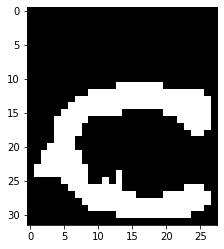

entered if
['1', 'K', 'L', 'H', 'C']
C
saved an img C
['1', 'P', 'B', 'Q', '4']
2 20
[  2  20  33  62  65  94 103 133 140 160]


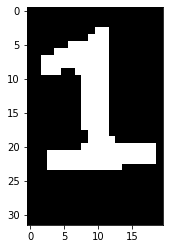

entered if
['1', 'P', 'B', 'Q', '4']
1
saved an img 1
33 62
[  2  20  33  62  65  94 103 133 140 160]


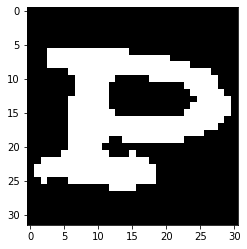

entered if
['1', 'P', 'B', 'Q', '4']
P
saved an img P
65 94
[  2  20  33  62  65  94 103 133 140 160]


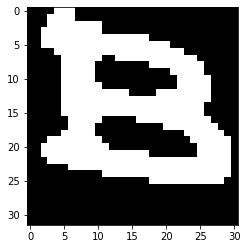

entered if
['1', 'P', 'B', 'Q', '4']
B
saved an img B
103 133
[  2  20  33  62  65  94 103 133 140 160]


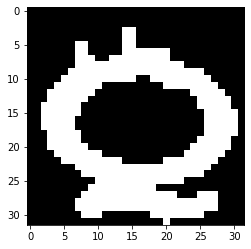

entered if
['1', 'P', 'B', 'Q', '4']
Q
saved an img Q
140 160
[  2  20  33  62  65  94 103 133 140 160]


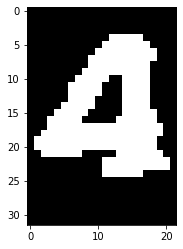

entered if
['1', 'P', 'B', 'Q', '4']
4
saved an img 4
['1', 'S', 'T', 'N', 'U']
23 32
[ 23  32  57  65  93 102 133 137 159]


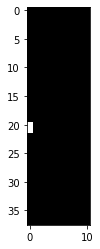

entered if
['1', 'S', 'T', 'N', 'U']
1
saved an img 1
57 65
[ 23  32  57  65  93 102 133 137 159]


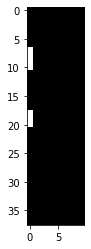

entered if
['1', 'S', 'T', 'N', 'U']
S
saved an img S
93 102
[ 23  32  57  65  93 102 133 137 159]


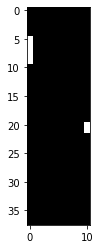

entered if
['1', 'S', 'T', 'N', 'U']
T
saved an img T
133 137
[ 23  32  57  65  93 102 133 137 159]


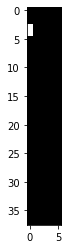

entered if
['1', 'S', 'T', 'N', 'U']
N
saved an img N
['1', 'S', 'V', 'I', 'O']
5 23
[  5  23  34  58  67  99 105 126 134 158]


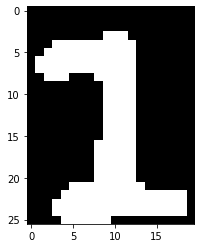

entered if
['1', 'S', 'V', 'I', 'O']
1
saved an img 1
34 58
[  5  23  34  58  67  99 105 126 134 158]


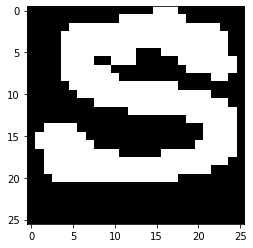

entered if
['1', 'S', 'V', 'I', 'O']
S
saved an img S
67 99
[  5  23  34  58  67  99 105 126 134 158]


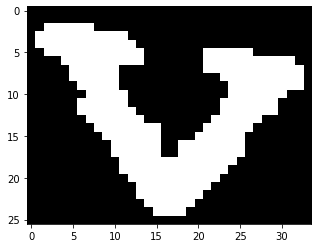

entered if
['1', 'S', 'V', 'I', 'O']
V
saved an img V
105 126
[  5  23  34  58  67  99 105 126 134 158]


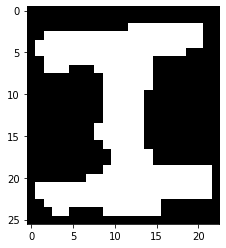

entered if
['1', 'S', 'V', 'I', 'O']
I
saved an img I
134 158
[  5  23  34  58  67  99 105 126 134 158]


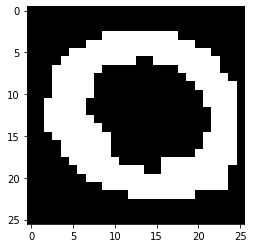

entered if
['1', 'S', 'V', 'I', 'O']
O
saved an img O
['1', 'V', '5', '5', 'Q']
3 20
[  3  20  29  64  71  95 105 128 137 160]


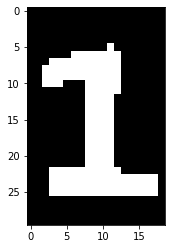

entered if
['1', 'V', '5', '5', 'Q']
1
saved an img 1
29 64
[  3  20  29  64  71  95 105 128 137 160]


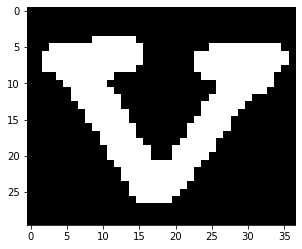

entered if
['1', 'V', '5', '5', 'Q']
V
saved an img V
71 95
[  3  20  29  64  71  95 105 128 137 160]


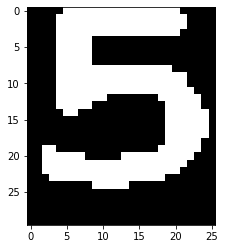

entered if
['1', 'V', '5', '5', 'Q']
5
saved an img 5
105 128
[  3  20  29  64  71  95 105 128 137 160]


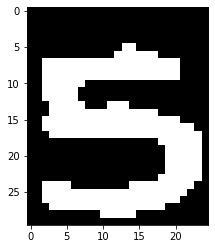

entered if
['1', 'V', '5', '5', 'Q']
5
saved an img 5
137 160
[  3  20  29  64  71  95 105 128 137 160]


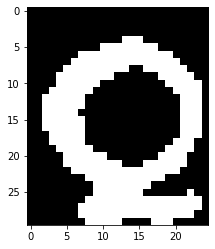

entered if
['1', 'V', '5', '5', 'Q']
Q
saved an img Q
['1', 'W', 'X', '6', 'H']
1 22
[  1  22  27  93 101 131 134 157]


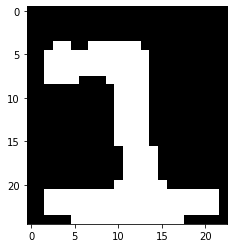

entered if
['1', 'W', 'X', '6', 'H']
1
saved an img 1
27 93
[  1  22  27  93 101 131 134 157]


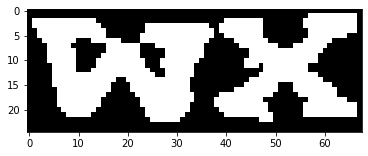

entered if
['1', 'W', 'X', '6', 'H']
W
saved an img W
101 131
[  1  22  27  93 101 131 134 157]


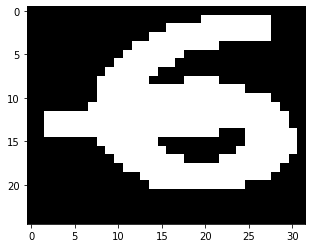

entered if
['1', 'W', 'X', '6', 'H']
X
saved an img X
134 157
[  1  22  27  93 101 131 134 157]


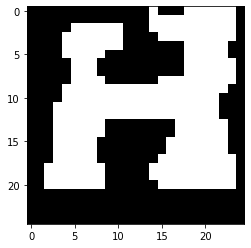

entered if
['1', 'W', 'X', '6', 'H']
6
saved an img 6
['1', 'X', 'G', 'G', '2']
62 65
[ 62  65  95 103 157]


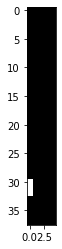

entered if
['1', 'X', 'G', 'G', '2']
1
saved an img 1
95 103
[ 62  65  95 103 157]


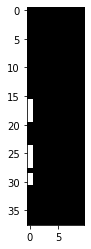

entered if
['1', 'X', 'G', 'G', '2']
X
saved an img X
['2', '0', '9', '9', 'V']
4 24
[  4  24  30  53  72  97 108 130 136 161]


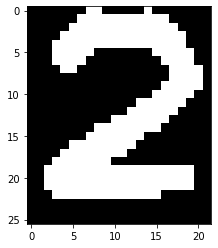

entered if
['2', '0', '9', '9', 'V']
2
saved an img 2
30 53
[  4  24  30  53  72  97 108 130 136 161]


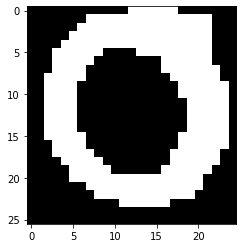

entered if
['2', '0', '9', '9', 'V']
0
saved an img 0
72 97
[  4  24  30  53  72  97 108 130 136 161]


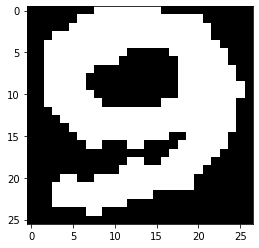

entered if
['2', '0', '9', '9', 'V']
9
saved an img 9
108 130
[  4  24  30  53  72  97 108 130 136 161]


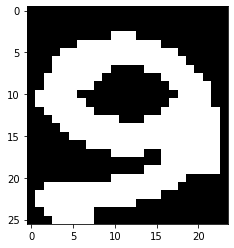

entered if
['2', '0', '9', '9', 'V']
9
saved an img 9
136 161
[  4  24  30  53  72  97 108 130 136 161]


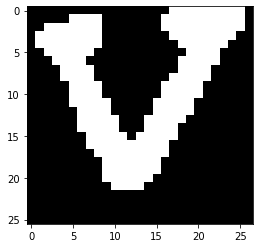

entered if
['2', '0', '9', '9', 'V']
V
saved an img V
['2', '4', 'U', 'B', 'L']
61 68
[ 61  68  96 105 132 137 160]


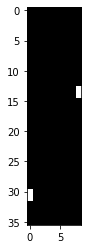

entered if
['2', '4', 'U', 'B', 'L']
2
saved an img 2
96 105
[ 61  68  96 105 132 137 160]


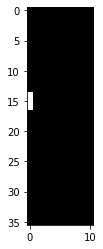

entered if
['2', '4', 'U', 'B', 'L']
4
saved an img 4
132 137
[ 61  68  96 105 132 137 160]


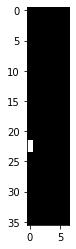

entered if
['2', '4', 'U', 'B', 'L']
U
saved an img U
['2', '6', 'F', 'N', 'L']
3 24
[  3  24  37  59  64  98 103 134 135 159]


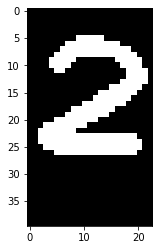

entered if
['2', '6', 'F', 'N', 'L']
2
saved an img 2
37 59
[  3  24  37  59  64  98 103 134 135 159]


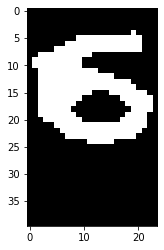

entered if
['2', '6', 'F', 'N', 'L']
6
saved an img 6
64 98
[  3  24  37  59  64  98 103 134 135 159]


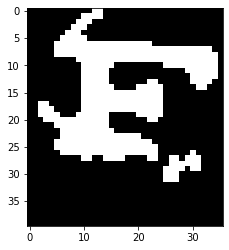

entered if
['2', '6', 'F', 'N', 'L']
F
saved an img F
103 134
[  3  24  37  59  64  98 103 134 135 159]


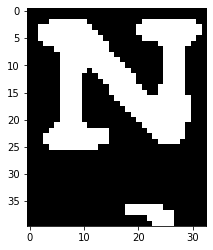

entered if
['2', '6', 'F', 'N', 'L']
N
saved an img N
135 159
[  3  24  37  59  64  98 103 134 135 159]


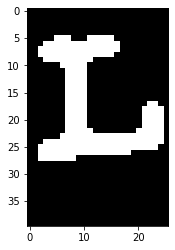

entered if
['2', '6', 'F', 'N', 'L']
L
saved an img L
['2', '6', 'Z', 'O', 'F']
3 22
[  3  22  32  58  68  91 102 127 137 159]


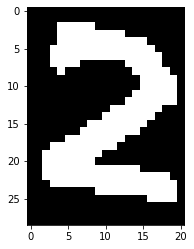

entered if
['2', '6', 'Z', 'O', 'F']
2
saved an img 2
32 58
[  3  22  32  58  68  91 102 127 137 159]


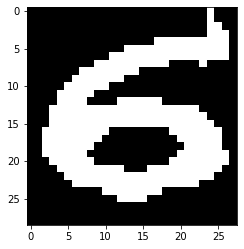

entered if
['2', '6', 'Z', 'O', 'F']
6
saved an img 6
68 91
[  3  22  32  58  68  91 102 127 137 159]


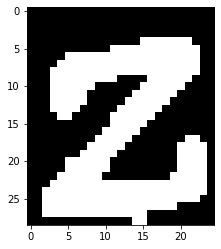

entered if
['2', '6', 'Z', 'O', 'F']
Z
saved an img Z
102 127
[  3  22  32  58  68  91 102 127 137 159]


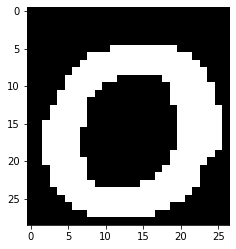

entered if
['2', '6', 'Z', 'O', 'F']
O
saved an img O
137 159
[  3  22  32  58  68  91 102 127 137 159]


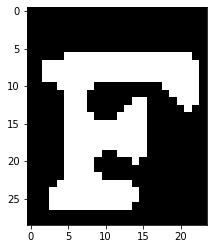

entered if
['2', '6', 'Z', 'O', 'F']
F
saved an img F
['2', '9', '6', '5', '2']
20 32
[ 20  32  56  68  91 103 130 136 159]


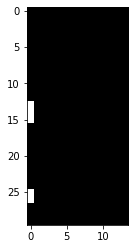

entered if
['2', '9', '6', '5', '2']
2
saved an img 2
56 68
[ 20  32  56  68  91 103 130 136 159]


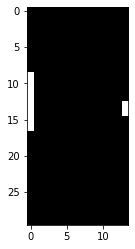

entered if
['2', '9', '6', '5', '2']
9
saved an img 9
91 103
[ 20  32  56  68  91 103 130 136 159]


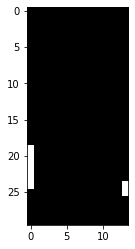

entered if
['2', '9', '6', '5', '2']
6
saved an img 6
130 136
[ 20  32  56  68  91 103 130 136 159]


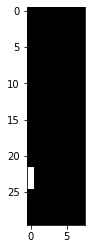

entered if
['2', '9', '6', '5', '2']
5
saved an img 5
['2', 'A', 'W', 'Q', 'Z']
2 22
[  2  22  30  63  66  98 103 157]


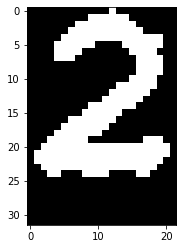

entered if
['2', 'A', 'W', 'Q', 'Z']
2
saved an img 2
30 63
[  2  22  30  63  66  98 103 157]


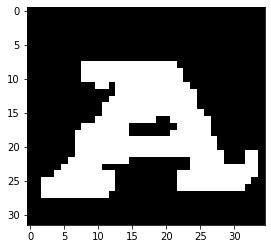

entered if
['2', 'A', 'W', 'Q', 'Z']
A
saved an img A
66 98
[  2  22  30  63  66  98 103 157]


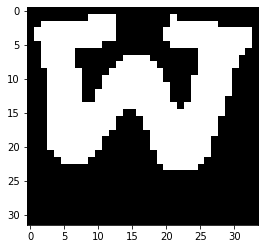

entered if
['2', 'A', 'W', 'Q', 'Z']
W
saved an img W
103 157
[  2  22  30  63  66  98 103 157]


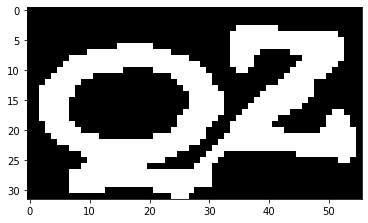

entered if
['2', 'A', 'W', 'Q', 'Z']
Q
saved an img Q
['2', 'B', '3', 'R', 'A']
1 22
[  1  22  34  63  68  92  98 132 137 162]


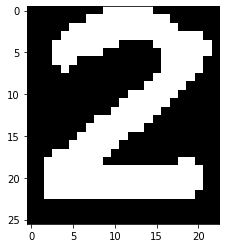

entered if
['2', 'B', '3', 'R', 'A']
2
saved an img 2
34 63
[  1  22  34  63  68  92  98 132 137 162]


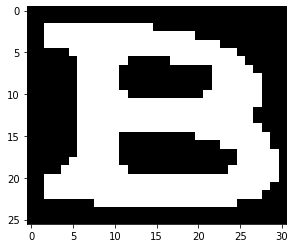

entered if
['2', 'B', '3', 'R', 'A']
B
saved an img B
68 92
[  1  22  34  63  68  92  98 132 137 162]


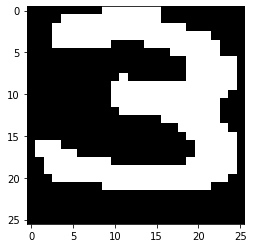

entered if
['2', 'B', '3', 'R', 'A']
3
saved an img 3
98 132
[  1  22  34  63  68  92  98 132 137 162]


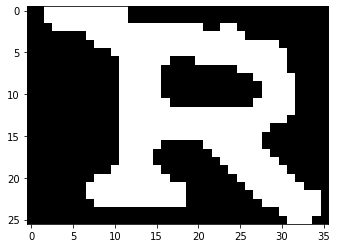

entered if
['2', 'B', '3', 'R', 'A']
R
saved an img R
137 162
[  1  22  34  63  68  92  98 132 137 162]


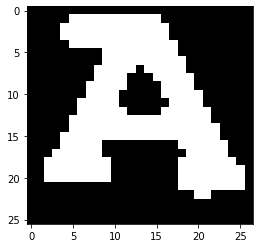

entered if
['2', 'B', '3', 'R', 'A']
A
saved an img A
['2', 'B', '3', 'Z', 'S']
23 33
[ 23  33  59  69  94  96 102 103 130 141 161]


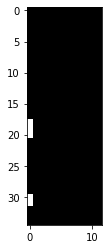

entered if
['2', 'B', '3', 'Z', 'S']
2
saved an img 2
59 69
[ 23  33  59  69  94  96 102 103 130 141 161]


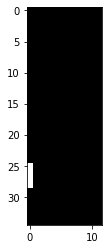

entered if
['2', 'B', '3', 'Z', 'S']
B
saved an img B
94 96
[ 23  33  59  69  94  96 102 103 130 141 161]


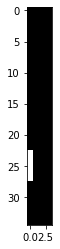

entered if
['2', 'B', '3', 'Z', 'S']
3
saved an img 3
102 103
[ 23  33  59  69  94  96 102 103 130 141 161]


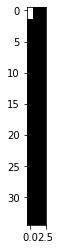

entered if
['2', 'B', '3', 'Z', 'S']
Z
saved an img Z
130 141
[ 23  33  59  69  94  96 102 103 130 141 161]


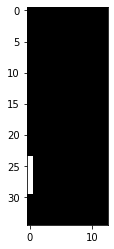

entered if
['2', 'B', '3', 'Z', 'S']
S
saved an img S
['2', 'E', 'R', 'O', '7']
4 23
[  4  23  28  58  64  95 106 131 137 157]


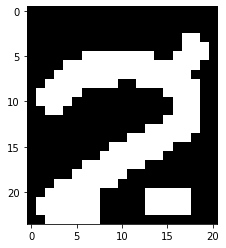

entered if
['2', 'E', 'R', 'O', '7']
2
saved an img 2
28 58
[  4  23  28  58  64  95 106 131 137 157]


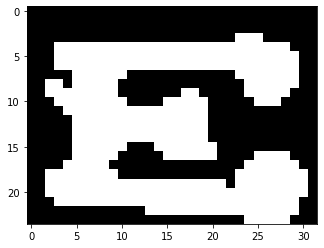

entered if
['2', 'E', 'R', 'O', '7']
E
saved an img E
64 95
[  4  23  28  58  64  95 106 131 137 157]


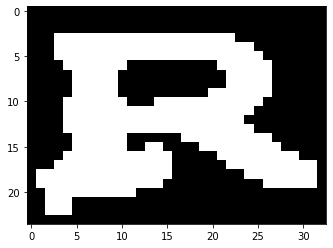

entered if
['2', 'E', 'R', 'O', '7']
R
saved an img R
106 131
[  4  23  28  58  64  95 106 131 137 157]


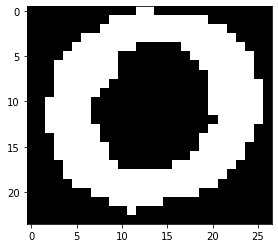

entered if
['2', 'E', 'R', 'O', '7']
O
saved an img O
137 157
[  4  23  28  58  64  95 106 131 137 157]


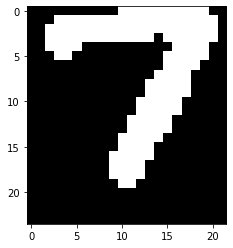

entered if
['2', 'E', 'R', 'O', '7']
7
saved an img 7
['2', 'H', 'K', 'H', 'W']
23 32
[ 23  32  64  68  97 104 132 136 160]


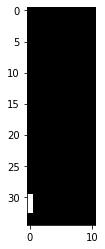

entered if
['2', 'H', 'K', 'H', 'W']
2
saved an img 2
64 68
[ 23  32  64  68  97 104 132 136 160]


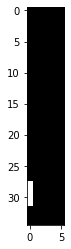

entered if
['2', 'H', 'K', 'H', 'W']
H
saved an img H
97 104
[ 23  32  64  68  97 104 132 136 160]


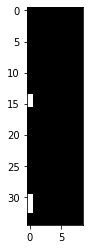

entered if
['2', 'H', 'K', 'H', 'W']
K
saved an img K
132 136
[ 23  32  64  68  97 104 132 136 160]


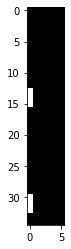

entered if
['2', 'H', 'K', 'H', 'W']
H
saved an img H
['2', 'I', 'T', 'W', 'H']
3 23
[  3  23  34  54  66  97  99 131 136 160]


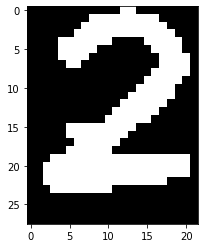

entered if
['2', 'I', 'T', 'W', 'H']
2
saved an img 2
34 54
[  3  23  34  54  66  97  99 131 136 160]


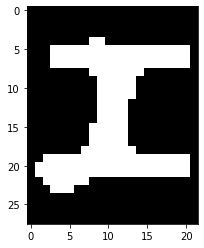

entered if
['2', 'I', 'T', 'W', 'H']
I
saved an img I
66 97
[  3  23  34  54  66  97  99 131 136 160]


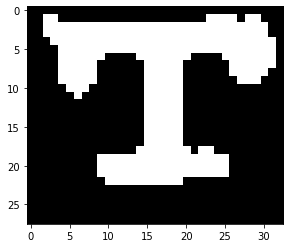

entered if
['2', 'I', 'T', 'W', 'H']
T
saved an img T
99 131
[  3  23  34  54  66  97  99 131 136 160]


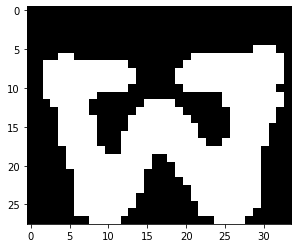

entered if
['2', 'I', 'T', 'W', 'H']
W
saved an img W
136 160
[  3  23  34  54  66  97  99 131 136 160]


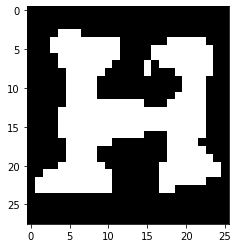

entered if
['2', 'I', 'T', 'W', 'H']
H
saved an img H
['2', 'M', 'T', '5', 'D']
2 24
[  2  24  31  63  66  97 105 127 137 160]


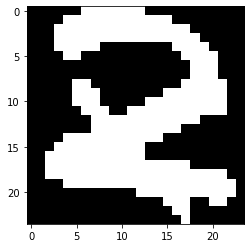

entered if
['2', 'M', 'T', '5', 'D']
2
saved an img 2
31 63
[  2  24  31  63  66  97 105 127 137 160]


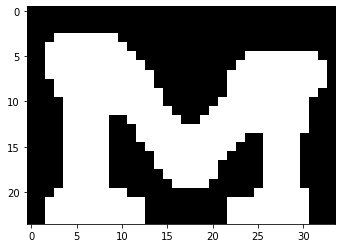

entered if
['2', 'M', 'T', '5', 'D']
M
saved an img M
66 97
[  2  24  31  63  66  97 105 127 137 160]


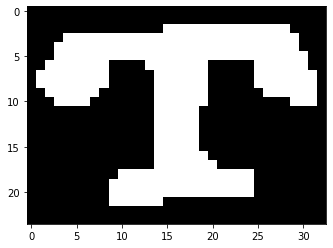

entered if
['2', 'M', 'T', '5', 'D']
T
saved an img T
105 127
[  2  24  31  63  66  97 105 127 137 160]


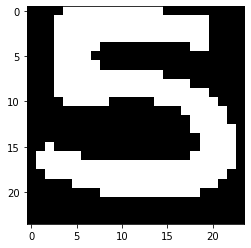

entered if
['2', 'M', 'T', '5', 'D']
5
saved an img 5
137 160
[  2  24  31  63  66  97 105 127 137 160]


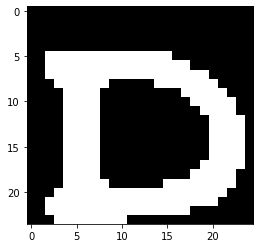

entered if
['2', 'M', 'T', '5', 'D']
D
saved an img D
['2', 'P', '7', '1', '5']
2 22
[  2  22  36  65  69  95 104 125 138 156]


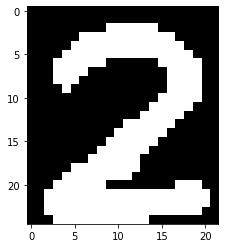

entered if
['2', 'P', '7', '1', '5']
2
saved an img 2
36 65
[  2  22  36  65  69  95 104 125 138 156]


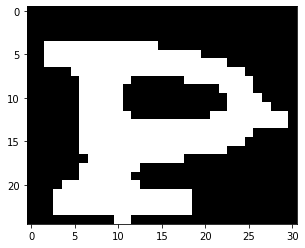

entered if
['2', 'P', '7', '1', '5']
P
saved an img P
69 95
[  2  22  36  65  69  95 104 125 138 156]


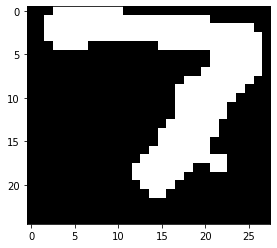

entered if
['2', 'P', '7', '1', '5']
7
saved an img 7
104 125
[  2  22  36  65  69  95 104 125 138 156]


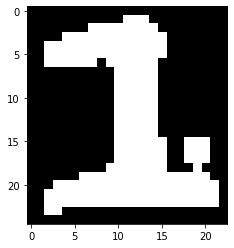

entered if
['2', 'P', '7', '1', '5']
1
saved an img 1
138 156
[  2  22  36  65  69  95 104 125 138 156]


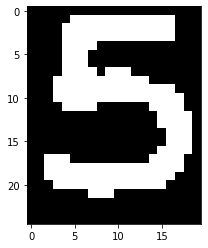

entered if
['2', 'P', '7', '1', '5']
5
saved an img 5
['2', 'P', 'Q', 'Z', '6']
21 32
[ 21  32  60  66 101 104 134 135 156]


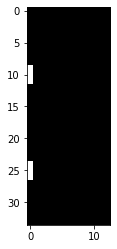

entered if
['2', 'P', 'Q', 'Z', '6']
2
saved an img 2
60 66
[ 21  32  60  66 101 104 134 135 156]


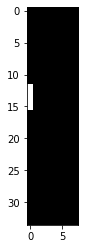

entered if
['2', 'P', 'Q', 'Z', '6']
P
saved an img P
101 104
[ 21  32  60  66 101 104 134 135 156]


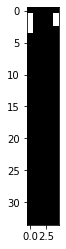

entered if
['2', 'P', 'Q', 'Z', '6']
Q
saved an img Q
134 135
[ 21  32  60  66 101 104 134 135 156]


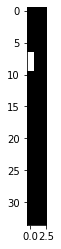

entered if
['2', 'P', 'Q', 'Z', '6']
Z
saved an img Z
['2', 'R', 'K', 'H', 'C']
3 24
[  3  24  30  63  65 132 135 162]


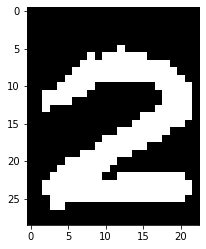

entered if
['2', 'R', 'K', 'H', 'C']
2
saved an img 2
30 63
[  3  24  30  63  65 132 135 162]


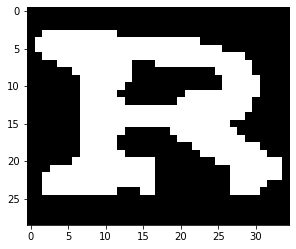

entered if
['2', 'R', 'K', 'H', 'C']
R
saved an img R
65 132
[  3  24  30  63  65 132 135 162]


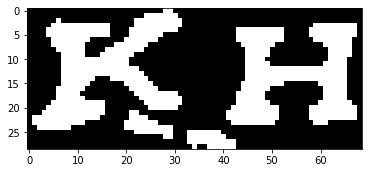

entered if
['2', 'R', 'K', 'H', 'C']
K
saved an img K
135 162
[  3  24  30  63  65 132 135 162]


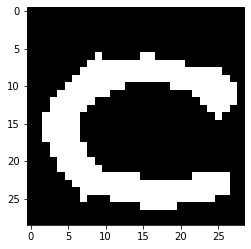

entered if
['2', 'R', 'K', 'H', 'C']
H
saved an img H
['2', 'T', '5', 'H', 'A']
0 20
[  0  20  27  57  67  95 105 131 135 160]


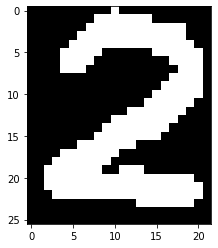

entered if
['2', 'T', '5', 'H', 'A']
2
saved an img 2
27 57
[  0  20  27  57  67  95 105 131 135 160]


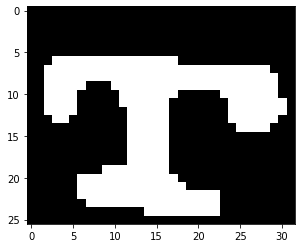

entered if
['2', 'T', '5', 'H', 'A']
T
saved an img T
67 95
[  0  20  27  57  67  95 105 131 135 160]


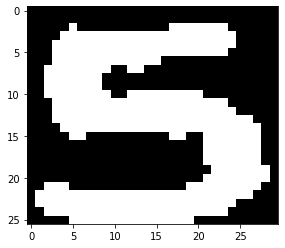

entered if
['2', 'T', '5', 'H', 'A']
5
saved an img 5
105 131
[  0  20  27  57  67  95 105 131 135 160]


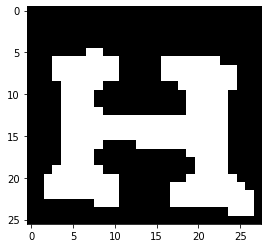

entered if
['2', 'T', '5', 'H', 'A']
H
saved an img H
135 160
[  0  20  27  57  67  95 105 131 135 160]


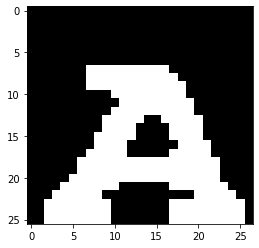

entered if
['2', 'T', '5', 'H', 'A']
A
saved an img A
['2', 'V', '6', '0', 'Z']
1 21
[  1  21  28  66  71  93 102 134 138 159]


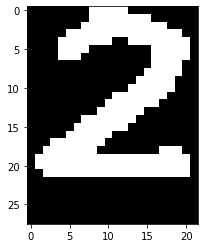

entered if
['2', 'V', '6', '0', 'Z']
2
saved an img 2
28 66
[  1  21  28  66  71  93 102 134 138 159]


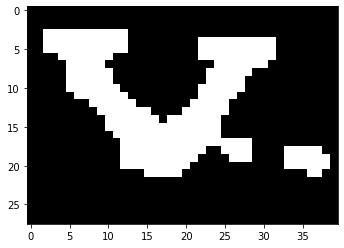

entered if
['2', 'V', '6', '0', 'Z']
V
saved an img V
71 93
[  1  21  28  66  71  93 102 134 138 159]


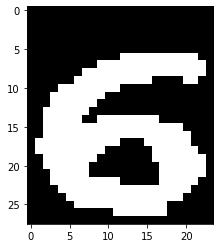

entered if
['2', 'V', '6', '0', 'Z']
6
saved an img 6
102 134
[  1  21  28  66  71  93 102 134 138 159]


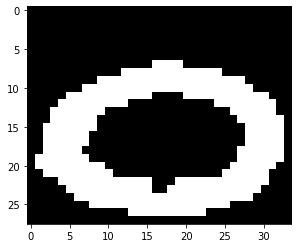

entered if
['2', 'V', '6', '0', 'Z']
0
saved an img 0
138 159
[  1  21  28  66  71  93 102 134 138 159]


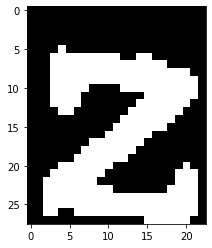

entered if
['2', 'V', '6', '0', 'Z']
Z
saved an img Z
['2', 'V', '6', 'O', 'Z']
1 21
[  1  21  28  66  71  93 102 134 138 159]


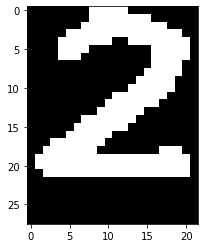

entered if
['2', 'V', '6', 'O', 'Z']
2
saved an img 2
28 66
[  1  21  28  66  71  93 102 134 138 159]


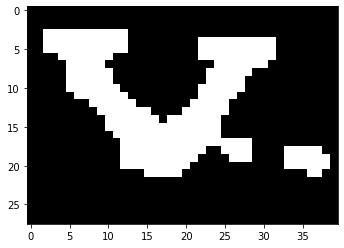

entered if
['2', 'V', '6', 'O', 'Z']
V
saved an img V
71 93
[  1  21  28  66  71  93 102 134 138 159]


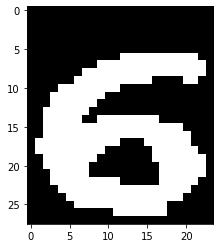

entered if
['2', 'V', '6', 'O', 'Z']
6
saved an img 6
102 134
[  1  21  28  66  71  93 102 134 138 159]


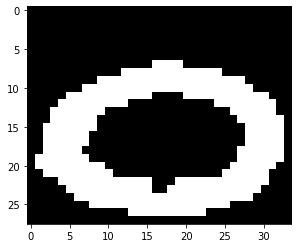

entered if
['2', 'V', '6', 'O', 'Z']
O
saved an img O
138 159
[  1  21  28  66  71  93 102 134 138 159]


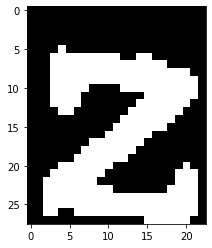

entered if
['2', 'V', '6', 'O', 'Z']
Z
saved an img Z
['2', 'V', 'L', 'B', 'M']
4 23
[  4  23  28  61  68  97 102 133 135 162]


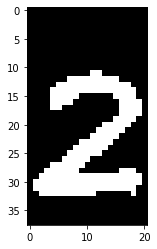

entered if
['2', 'V', 'L', 'B', 'M']
2
saved an img 2
28 61
[  4  23  28  61  68  97 102 133 135 162]


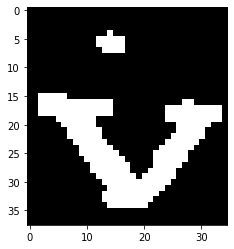

entered if
['2', 'V', 'L', 'B', 'M']
V
saved an img V
68 97
[  4  23  28  61  68  97 102 133 135 162]


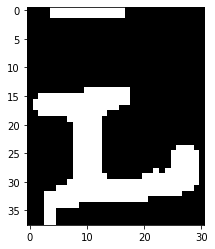

entered if
['2', 'V', 'L', 'B', 'M']
L
saved an img L
102 133
[  4  23  28  61  68  97 102 133 135 162]


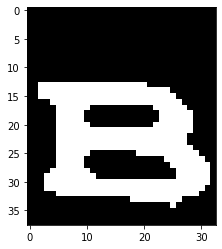

entered if
['2', 'V', 'L', 'B', 'M']
B
saved an img B
135 162
[  4  23  28  61  68  97 102 133 135 162]


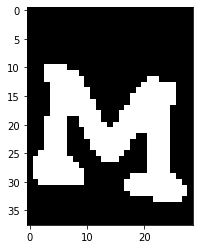

entered if
['2', 'V', 'L', 'B', 'M']
M
saved an img M
['2', 'V', 'Q', '2', '0']
1 22
[  1  22  28  60  65  95 103 128 139 160]


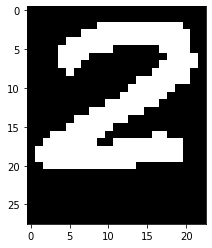

entered if
['2', 'V', 'Q', '2', '0']
2
saved an img 2
28 60
[  1  22  28  60  65  95 103 128 139 160]


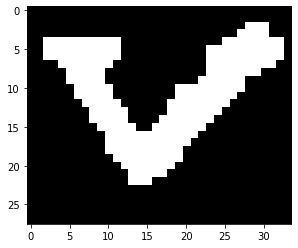

entered if
['2', 'V', 'Q', '2', '0']
V
saved an img V
65 95
[  1  22  28  60  65  95 103 128 139 160]


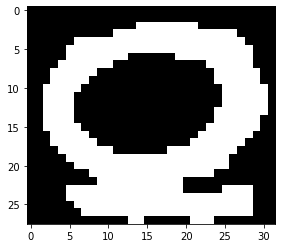

entered if
['2', 'V', 'Q', '2', '0']
Q
saved an img Q
103 128
[  1  22  28  60  65  95 103 128 139 160]


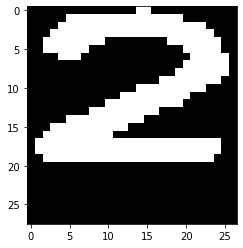

entered if
['2', 'V', 'Q', '2', '0']
2
saved an img 2
139 160
[  1  22  28  60  65  95 103 128 139 160]


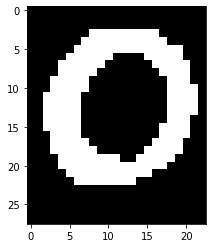

entered if
['2', 'V', 'Q', '2', '0']
0
saved an img 0
['2', 'X', '5', 'T', 'T']
2 26
[  2  26  32  63  65  92 104 134 137 160]


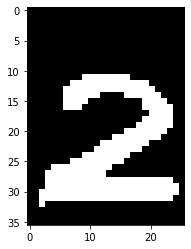

entered if
['2', 'X', '5', 'T', 'T']
2
saved an img 2
32 63
[  2  26  32  63  65  92 104 134 137 160]


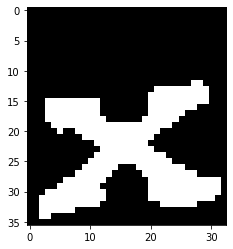

entered if
['2', 'X', '5', 'T', 'T']
X
saved an img X
65 92
[  2  26  32  63  65  92 104 134 137 160]


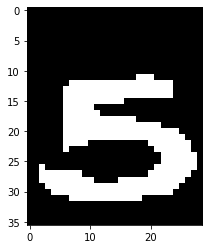

entered if
['2', 'X', '5', 'T', 'T']
5
saved an img 5
104 134
[  2  26  32  63  65  92 104 134 137 160]


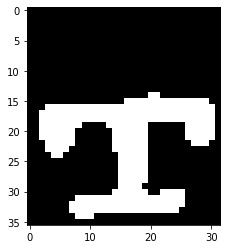

entered if
['2', 'X', '5', 'T', 'T']
T
saved an img T
137 160
[  2  26  32  63  65  92 104 134 137 160]


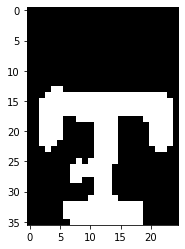

entered if
['2', 'X', '5', 'T', 'T']
T
saved an img T
['2', 'Z', '4', 'X', 'I']
3 23
[  3  23  33  63  69  91 105 135 138 158]


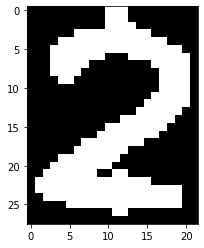

entered if
['2', 'Z', '4', 'X', 'I']
2
saved an img 2
33 63
[  3  23  33  63  69  91 105 135 138 158]


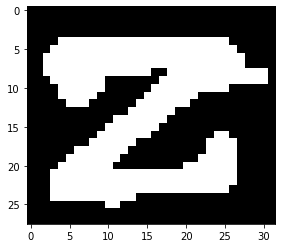

entered if
['2', 'Z', '4', 'X', 'I']
Z
saved an img Z
69 91
[  3  23  33  63  69  91 105 135 138 158]


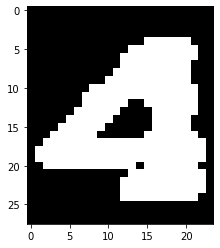

entered if
['2', 'Z', '4', 'X', 'I']
4
saved an img 4
105 135
[  3  23  33  63  69  91 105 135 138 158]


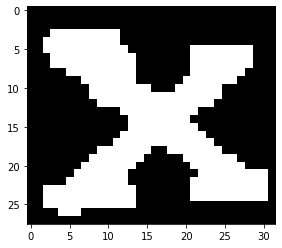

entered if
['2', 'Z', '4', 'X', 'I']
X
saved an img X
138 158
[  3  23  33  63  69  91 105 135 138 158]


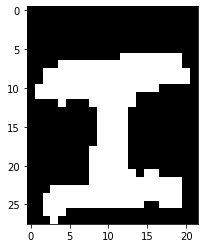

entered if
['2', 'Z', '4', 'X', 'I']
I
saved an img I
['3', '1', 'C', '9', 'J']
6 26
[  6  26  33  62  66  95 106 128 135 162]


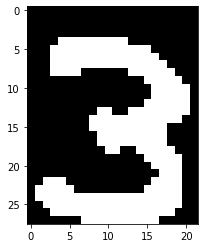

entered if
['3', '1', 'C', '9', 'J']
3
saved an img 3
33 62
[  6  26  33  62  66  95 106 128 135 162]


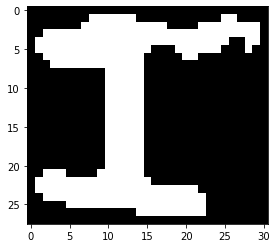

entered if
['3', '1', 'C', '9', 'J']
1
saved an img 1
66 95
[  6  26  33  62  66  95 106 128 135 162]


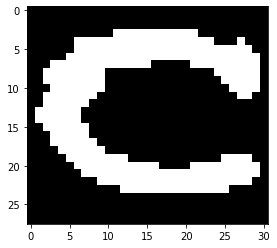

entered if
['3', '1', 'C', '9', 'J']
C
saved an img C
106 128
[  6  26  33  62  66  95 106 128 135 162]


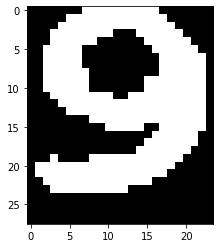

entered if
['3', '1', 'C', '9', 'J']
9
saved an img 9
135 162
[  6  26  33  62  66  95 106 128 135 162]


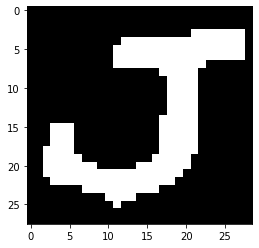

entered if
['3', '1', 'C', '9', 'J']
J
saved an img J
['3', '3', 'H', '9', '5']
23 32
[ 23  32  56  68  96 109 130 139 156]


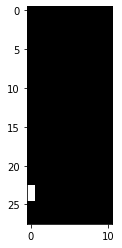

entered if
['3', '3', 'H', '9', '5']
3
saved an img 3
56 68
[ 23  32  56  68  96 109 130 139 156]


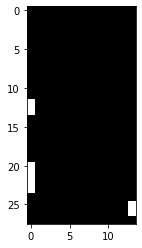

entered if
['3', '3', 'H', '9', '5']
3
saved an img 3
96 109
[ 23  32  56  68  96 109 130 139 156]


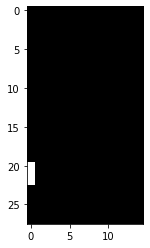

entered if
['3', '3', 'H', '9', '5']
H
saved an img H
130 139
[ 23  32  56  68  96 109 130 139 156]


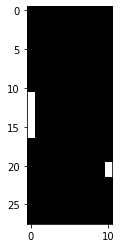

entered if
['3', '3', 'H', '9', '5']
9
saved an img 9
['3', '4', '3', 'I', 'Q']
54 69
[ 54  69  93 107 130 136 159]


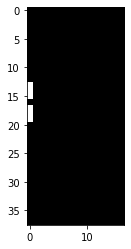

entered if
['3', '4', '3', 'I', 'Q']
3
saved an img 3
93 107
[ 54  69  93 107 130 136 159]


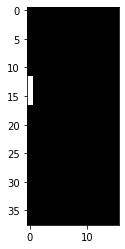

entered if
['3', '4', '3', 'I', 'Q']
4
saved an img 4
130 136
[ 54  69  93 107 130 136 159]


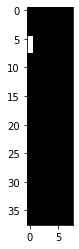

entered if
['3', '4', '3', 'I', 'Q']
3
saved an img 3
['3', '5', 'S', 'V', 'H']
1 26
[  1  26  34  58  66  92  99 133 136 159]


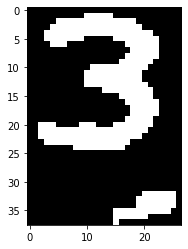

entered if
['3', '5', 'S', 'V', 'H']
3
saved an img 3
34 58
[  1  26  34  58  66  92  99 133 136 159]


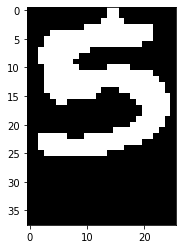

entered if
['3', '5', 'S', 'V', 'H']
5
saved an img 5
66 92
[  1  26  34  58  66  92  99 133 136 159]


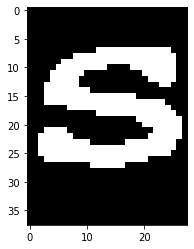

entered if
['3', '5', 'S', 'V', 'H']
S
saved an img S
99 133
[  1  26  34  58  66  92  99 133 136 159]


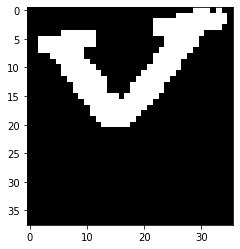

entered if
['3', '5', 'S', 'V', 'H']
V
saved an img V
136 159
[  1  26  34  58  66  92  99 133 136 159]


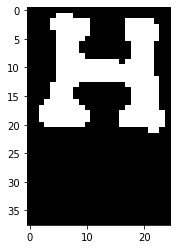

entered if
['3', '5', 'S', 'V', 'H']
H
saved an img H
['3', '7', 'F', 'V', 'L']
23 37
[ 23  37  60  69  97 102 134 138 162]


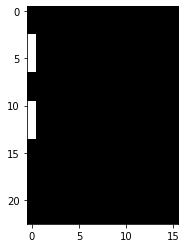

entered if
['3', '7', 'F', 'V', 'L']
3
saved an img 3
60 69
[ 23  37  60  69  97 102 134 138 162]


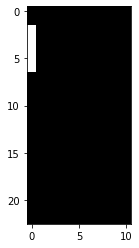

entered if
['3', '7', 'F', 'V', 'L']
7
saved an img 7
97 102
[ 23  37  60  69  97 102 134 138 162]


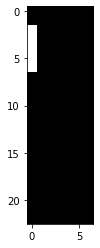

entered if
['3', '7', 'F', 'V', 'L']
F
saved an img F
134 138
[ 23  37  60  69  97 102 134 138 162]


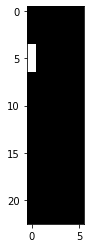

entered if
['3', '7', 'F', 'V', 'L']
V
saved an img V
['3', '8', '1', 'I', '8']
7 27
[  7  27  34  58  69  91 104 128 140 160]


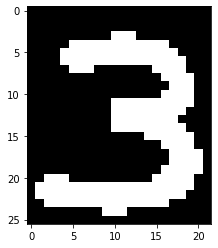

entered if
['3', '8', '1', 'I', '8']
3
saved an img 3
34 58
[  7  27  34  58  69  91 104 128 140 160]


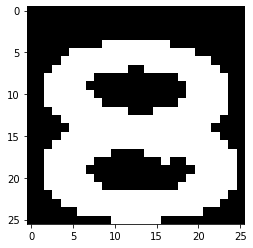

entered if
['3', '8', '1', 'I', '8']
8
saved an img 8
69 91
[  7  27  34  58  69  91 104 128 140 160]


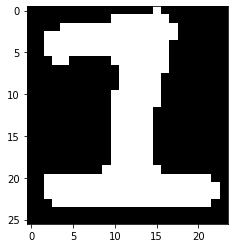

entered if
['3', '8', '1', 'I', '8']
1
saved an img 1
104 128
[  7  27  34  58  69  91 104 128 140 160]


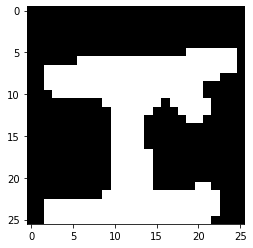

entered if
['3', '8', '1', 'I', '8']
I
saved an img I
140 160
[  7  27  34  58  69  91 104 128 140 160]


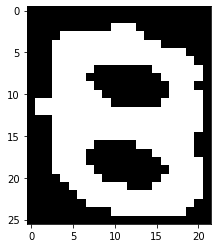

entered if
['3', '8', '1', 'I', '8']
8
saved an img 8
['3', 'C', '1', 'A', 'H']
1 23
[  1  23  32  61  70  93 100 134 137 160]


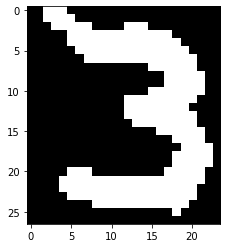

entered if
['3', 'C', '1', 'A', 'H']
3
saved an img 3
32 61
[  1  23  32  61  70  93 100 134 137 160]


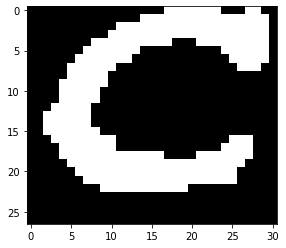

entered if
['3', 'C', '1', 'A', 'H']
C
saved an img C
70 93
[  1  23  32  61  70  93 100 134 137 160]


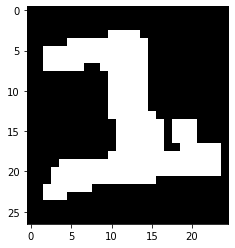

entered if
['3', 'C', '1', 'A', 'H']
1
saved an img 1
100 134
[  1  23  32  61  70  93 100 134 137 160]


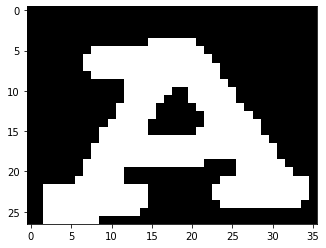

entered if
['3', 'C', '1', 'A', 'H']
A
saved an img A
137 160
[  1  23  32  61  70  93 100 134 137 160]


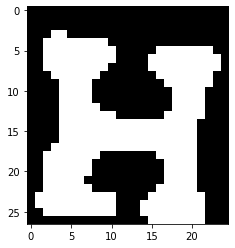

entered if
['3', 'C', '1', 'A', 'H']
H
saved an img H
['3', 'D', 'T', 'E', 'L']
1 19
[  1  19  30  60  67  96 104 134 137 160]


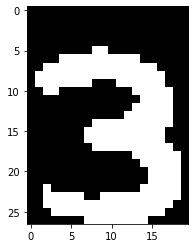

entered if
['3', 'D', 'T', 'E', 'L']
3
saved an img 3
30 60
[  1  19  30  60  67  96 104 134 137 160]


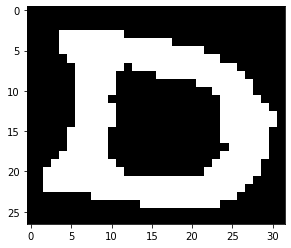

entered if
['3', 'D', 'T', 'E', 'L']
D
saved an img D
67 96
[  1  19  30  60  67  96 104 134 137 160]


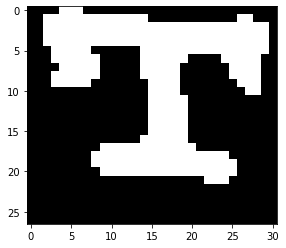

entered if
['3', 'D', 'T', 'E', 'L']
T
saved an img T
104 134
[  1  19  30  60  67  96 104 134 137 160]


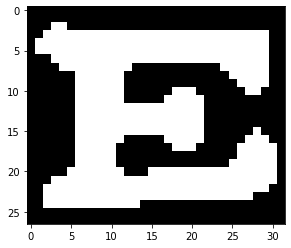

entered if
['3', 'D', 'T', 'E', 'L']
E
saved an img E
137 160
[  1  19  30  60  67  96 104 134 137 160]


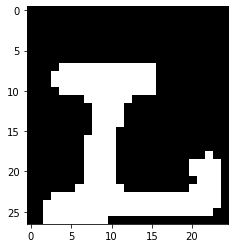

entered if
['3', 'D', 'T', 'E', 'L']
L
saved an img L
['3', 'G', '5', 'J', 'I']
25 30
[ 25  30  59  67  95 104 135 140 158]


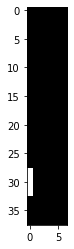

entered if
['3', 'G', '5', 'J', 'I']
3
saved an img 3
59 67
[ 25  30  59  67  95 104 135 140 158]


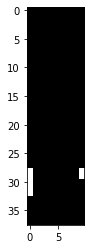

entered if
['3', 'G', '5', 'J', 'I']
G
saved an img G
95 104
[ 25  30  59  67  95 104 135 140 158]


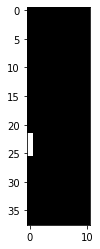

entered if
['3', 'G', '5', 'J', 'I']
5
saved an img 5
135 140
[ 25  30  59  67  95 104 135 140 158]


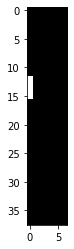

entered if
['3', 'G', '5', 'J', 'I']
J
saved an img J
['3', 'O', 'P', 'N', 'G']
5 24
[  5  24  26  57  70  96 100 129 134 158]


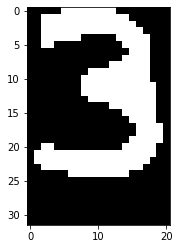

entered if
['3', 'O', 'P', 'N', 'G']
3
saved an img 3
26 57
[  5  24  26  57  70  96 100 129 134 158]


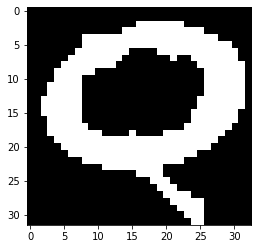

entered if
['3', 'O', 'P', 'N', 'G']
O
saved an img O
70 96
[  5  24  26  57  70  96 100 129 134 158]


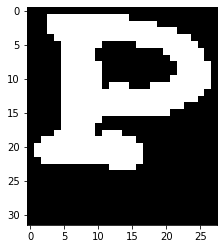

entered if
['3', 'O', 'P', 'N', 'G']
P
saved an img P
100 129
[  5  24  26  57  70  96 100 129 134 158]


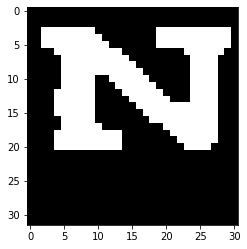

entered if
['3', 'O', 'P', 'N', 'G']
N
saved an img N
134 158
[  5  24  26  57  70  96 100 129 134 158]


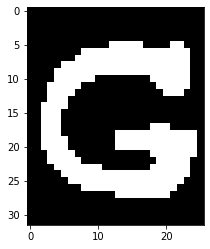

entered if
['3', 'O', 'P', 'N', 'G']
G
saved an img G
['3', 'P', '1', 'T', 'U']
4 27
[  4  27  32  60  71  93 102 130 134 158]


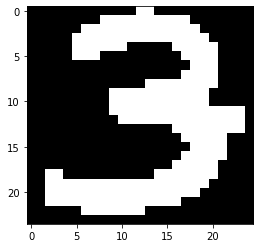

entered if
['3', 'P', '1', 'T', 'U']
3
saved an img 3
32 60
[  4  27  32  60  71  93 102 130 134 158]


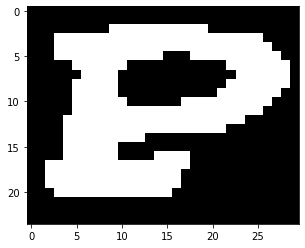

entered if
['3', 'P', '1', 'T', 'U']
P
saved an img P
71 93
[  4  27  32  60  71  93 102 130 134 158]


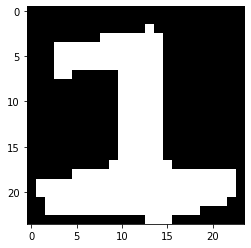

entered if
['3', 'P', '1', 'T', 'U']
1
saved an img 1
102 130
[  4  27  32  60  71  93 102 130 134 158]


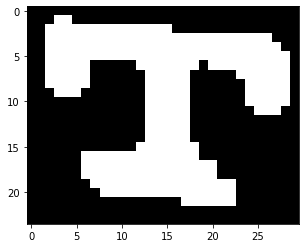

entered if
['3', 'P', '1', 'T', 'U']
T
saved an img T
134 158
[  4  27  32  60  71  93 102 130 134 158]


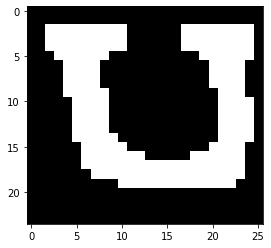

entered if
['3', 'P', '1', 'T', 'U']
U
saved an img U
['3', 'P', 'L', 'H', 'O']
2 23
[  2  23  34  59  66  98 104 133 138 158]


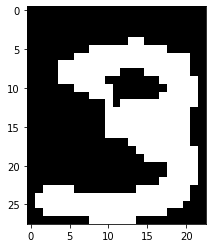

entered if
['3', 'P', 'L', 'H', 'O']
3
saved an img 3
34 59
[  2  23  34  59  66  98 104 133 138 158]


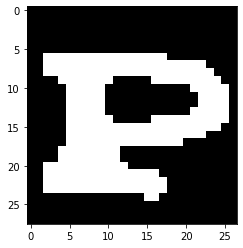

entered if
['3', 'P', 'L', 'H', 'O']
P
saved an img P
66 98
[  2  23  34  59  66  98 104 133 138 158]


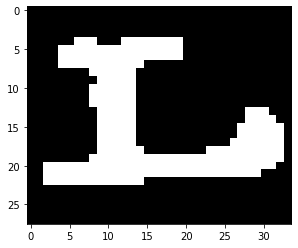

entered if
['3', 'P', 'L', 'H', 'O']
L
saved an img L
104 133
[  2  23  34  59  66  98 104 133 138 158]


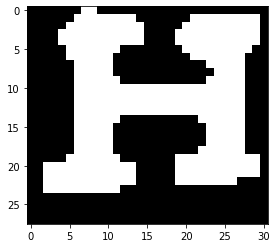

entered if
['3', 'P', 'L', 'H', 'O']
H
saved an img H
138 158
[  2  23  34  59  66  98 104 133 138 158]


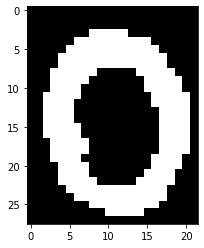

entered if
['3', 'P', 'L', 'H', 'O']
O
saved an img O
['3', 'Q', 'W', '8', 'F']
5 23
[  5  23  29  61  65 101 105 128 140 162]


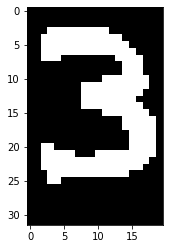

entered if
['3', 'Q', 'W', '8', 'F']
3
saved an img 3
29 61
[  5  23  29  61  65 101 105 128 140 162]


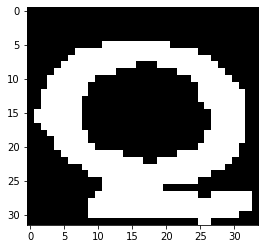

entered if
['3', 'Q', 'W', '8', 'F']
Q
saved an img Q
65 101
[  5  23  29  61  65 101 105 128 140 162]


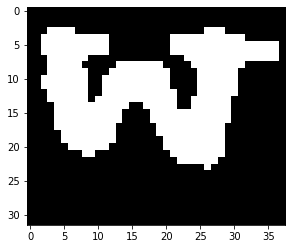

entered if
['3', 'Q', 'W', '8', 'F']
W
saved an img W
105 128
[  5  23  29  61  65 101 105 128 140 162]


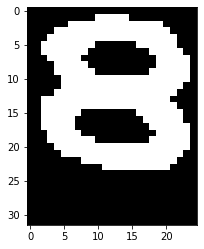

entered if
['3', 'Q', 'W', '8', 'F']
8
saved an img 8
140 162
[  5  23  29  61  65 101 105 128 140 162]


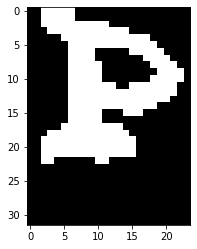

entered if
['3', 'Q', 'W', '8', 'F']
F
saved an img F
['3', 'W', 'G', 'N', '5']
1 23
[  1  23  30  95  97 131 142 161]


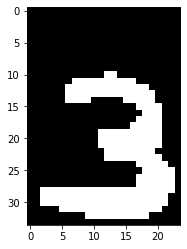

entered if
['3', 'W', 'G', 'N', '5']
3
saved an img 3
30 95
[  1  23  30  95  97 131 142 161]


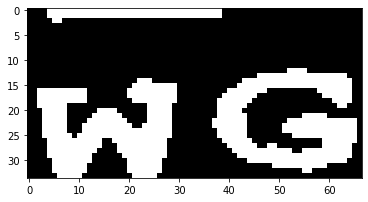

entered if
['3', 'W', 'G', 'N', '5']
W
saved an img W
97 131
[  1  23  30  95  97 131 142 161]


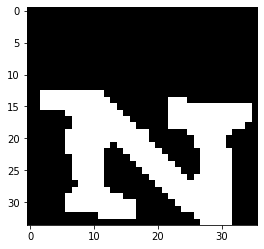

entered if
['3', 'W', 'G', 'N', '5']
G
saved an img G
142 161
[  1  23  30  95  97 131 142 161]


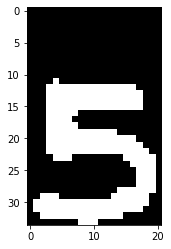

entered if
['3', 'W', 'G', 'N', '5']
N
saved an img N
['3', 'X', 'F', 'M', 'Y']
4 22
[  4  22  32  58  69  97 100 136 139 161]


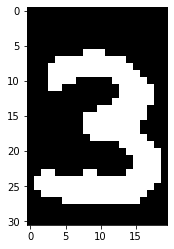

entered if
['3', 'X', 'F', 'M', 'Y']
3
saved an img 3
32 58
[  4  22  32  58  69  97 100 136 139 161]


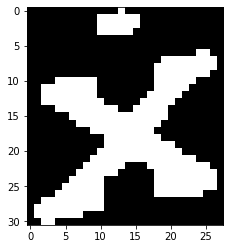

entered if
['3', 'X', 'F', 'M', 'Y']
X
saved an img X
69 97
[  4  22  32  58  69  97 100 136 139 161]


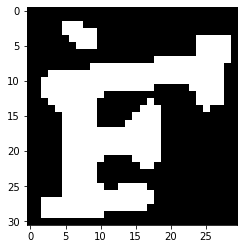

entered if
['3', 'X', 'F', 'M', 'Y']
F
saved an img F
100 136
[  4  22  32  58  69  97 100 136 139 161]


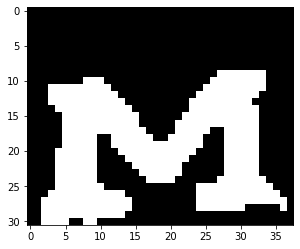

entered if
['3', 'X', 'F', 'M', 'Y']
M
saved an img M
139 161
[  4  22  32  58  69  97 100 136 139 161]


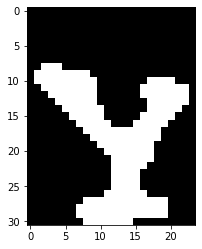

entered if
['3', 'X', 'F', 'M', 'Y']
Y
saved an img Y
['3', 'Y', 'M', 'L', 'M']
5 25
[  5  25  33  63  66 132 135 162]


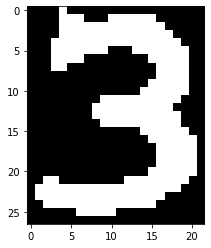

entered if
['3', 'Y', 'M', 'L', 'M']
3
saved an img 3
33 63
[  5  25  33  63  66 132 135 162]


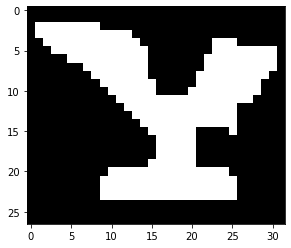

entered if
['3', 'Y', 'M', 'L', 'M']
Y
saved an img Y
66 132
[  5  25  33  63  66 132 135 162]


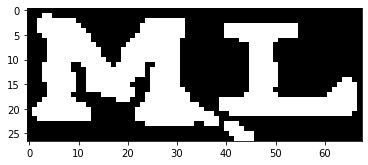

entered if
['3', 'Y', 'M', 'L', 'M']
M
saved an img M
135 162
[  5  25  33  63  66 132 135 162]


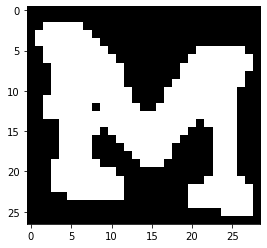

entered if
['3', 'Y', 'M', 'L', 'M']
L
saved an img L
['4', '2', '5', 'P', 'H']
2 20
[  2  20  31  56  66  93 101 132]


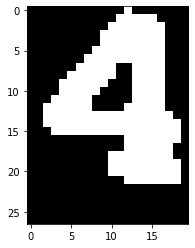

entered if
['4', '2', '5', 'P', 'H']
4
saved an img 4
31 56
[  2  20  31  56  66  93 101 132]


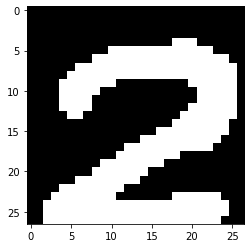

entered if
['4', '2', '5', 'P', 'H']
2
saved an img 2
66 93
[  2  20  31  56  66  93 101 132]


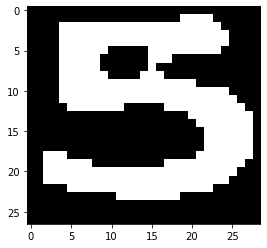

entered if
['4', '2', '5', 'P', 'H']
5
saved an img 5
101 132
[  2  20  31  56  66  93 101 132]


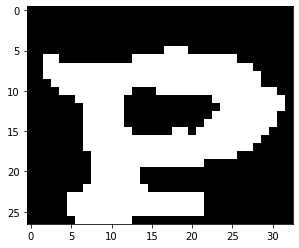

entered if
['4', '2', '5', 'P', 'H']
P
saved an img P
['4', '4', 'G', 'A', 'N']
4 23
[  4  23  36  58  67  97  99 131 136 159]


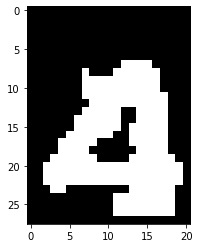

entered if
['4', '4', 'G', 'A', 'N']
4
saved an img 4
36 58
[  4  23  36  58  67  97  99 131 136 159]


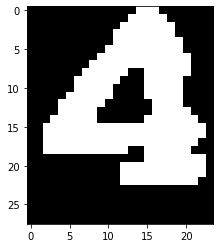

entered if
['4', '4', 'G', 'A', 'N']
4
saved an img 4
67 97
[  4  23  36  58  67  97  99 131 136 159]


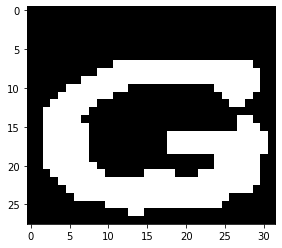

entered if
['4', '4', 'G', 'A', 'N']
G
saved an img G
99 131
[  4  23  36  58  67  97  99 131 136 159]


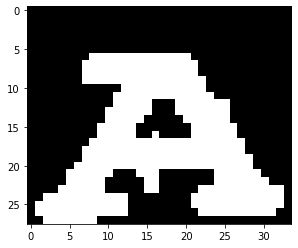

entered if
['4', '4', 'G', 'A', 'N']
A
saved an img A
136 159
[  4  23  36  58  67  97  99 131 136 159]


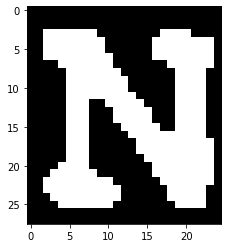

entered if
['4', '4', 'G', 'A', 'N']
N
saved an img N
['4', 'A', 'V', 'C', 'R']
2 20
[  2  20  28  60  64  95 104 131 135 162]


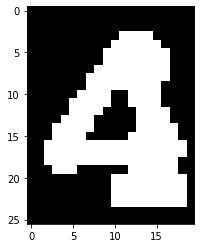

entered if
['4', 'A', 'V', 'C', 'R']
4
saved an img 4
28 60
[  2  20  28  60  64  95 104 131 135 162]


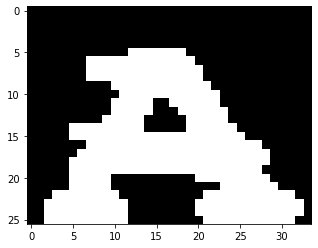

entered if
['4', 'A', 'V', 'C', 'R']
A
saved an img A
64 95
[  2  20  28  60  64  95 104 131 135 162]


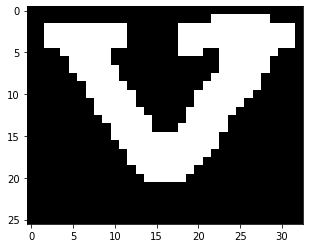

entered if
['4', 'A', 'V', 'C', 'R']
V
saved an img V
104 131
[  2  20  28  60  64  95 104 131 135 162]


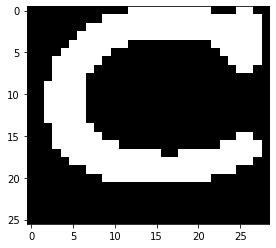

entered if
['4', 'A', 'V', 'C', 'R']
C
saved an img C
135 162
[  2  20  28  60  64  95 104 131 135 162]


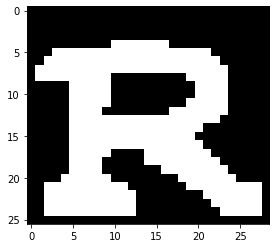

entered if
['4', 'A', 'V', 'C', 'R']
R
saved an img R
['4', 'B', 'C', 'Q', 'J']
1 21
[  1  21  29  61  65 129 135 161]


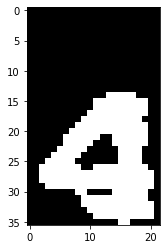

entered if
['4', 'B', 'C', 'Q', 'J']
4
saved an img 4
29 61
[  1  21  29  61  65 129 135 161]


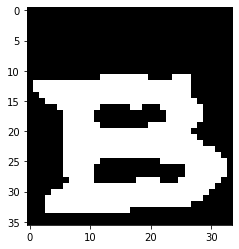

entered if
['4', 'B', 'C', 'Q', 'J']
B
saved an img B
65 129
[  1  21  29  61  65 129 135 161]


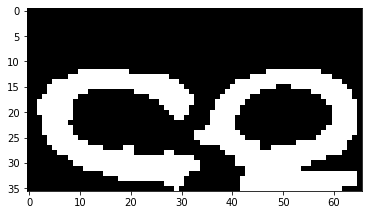

entered if
['4', 'B', 'C', 'Q', 'J']
C
saved an img C
135 161
[  1  21  29  61  65 129 135 161]


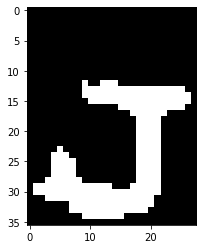

entered if
['4', 'B', 'C', 'Q', 'J']
Q
saved an img Q
['4', 'B', 'Z', 'J', 'E']
3 23
[  3  23  27  58  70  93 104 159]


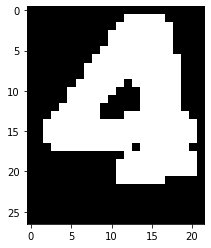

entered if
['4', 'B', 'Z', 'J', 'E']
4
saved an img 4
27 58
[  3  23  27  58  70  93 104 159]


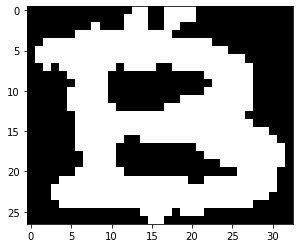

entered if
['4', 'B', 'Z', 'J', 'E']
B
saved an img B
70 93
[  3  23  27  58  70  93 104 159]


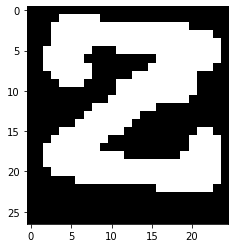

entered if
['4', 'B', 'Z', 'J', 'E']
Z
saved an img Z
104 159
[  3  23  27  58  70  93 104 159]


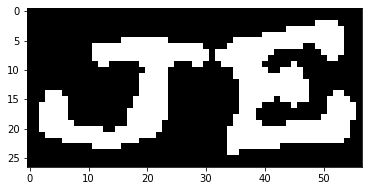

entered if
['4', 'B', 'Z', 'J', 'E']
J
saved an img J
['4', 'F', '9', '8', '7']
2 3
[  2   3  22  33  64  74  98 102 125 138 157]


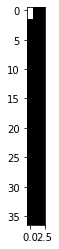

entered if
['4', 'F', '9', '8', '7']
4
saved an img 4
22 33
[  2   3  22  33  64  74  98 102 125 138 157]


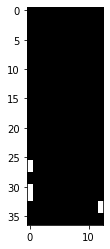

entered if
['4', 'F', '9', '8', '7']
F
saved an img F
64 74
[  2   3  22  33  64  74  98 102 125 138 157]


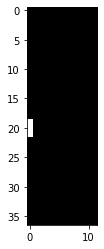

entered if
['4', 'F', '9', '8', '7']
9
saved an img 9
98 102
[  2   3  22  33  64  74  98 102 125 138 157]


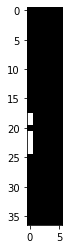

entered if
['4', 'F', '9', '8', '7']
8
saved an img 8
125 138
[  2   3  22  33  64  74  98 102 125 138 157]


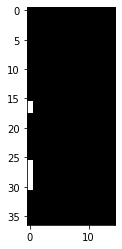

entered if
['4', 'F', '9', '8', '7']
7
saved an img 7
['4', 'H', 'E', 'C', '1']
3 22
[  3  22  33  62  64  94 100 130 136 157]


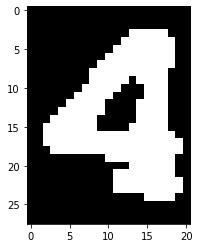

entered if
['4', 'H', 'E', 'C', '1']
4
saved an img 4
33 62
[  3  22  33  62  64  94 100 130 136 157]


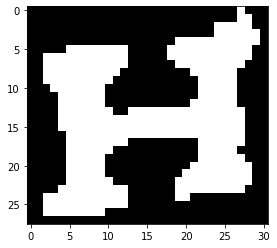

entered if
['4', 'H', 'E', 'C', '1']
H
saved an img H
64 94
[  3  22  33  62  64  94 100 130 136 157]


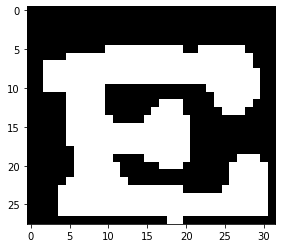

entered if
['4', 'H', 'E', 'C', '1']
E
saved an img E
100 130
[  3  22  33  62  64  94 100 130 136 157]


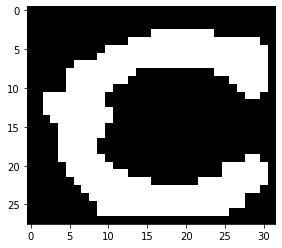

entered if
['4', 'H', 'E', 'C', '1']
C
saved an img C
136 157
[  3  22  33  62  64  94 100 130 136 157]


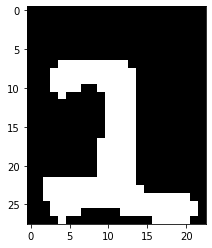

entered if
['4', 'H', 'E', 'C', '1']
1
saved an img 1
['4', 'K', '5', 'S', 'Q']
3 22
[  3  22  30  61  68  94 104 129 132 157]


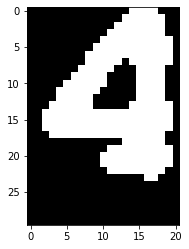

entered if
['4', 'K', '5', 'S', 'Q']
4
saved an img 4
30 61
[  3  22  30  61  68  94 104 129 132 157]


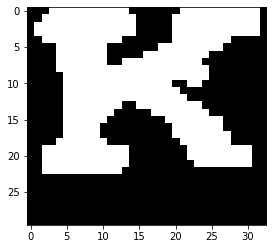

entered if
['4', 'K', '5', 'S', 'Q']
K
saved an img K
68 94
[  3  22  30  61  68  94 104 129 132 157]


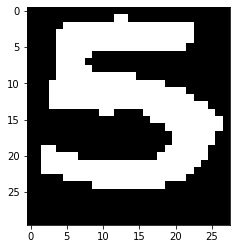

entered if
['4', 'K', '5', 'S', 'Q']
5
saved an img 5
104 129
[  3  22  30  61  68  94 104 129 132 157]


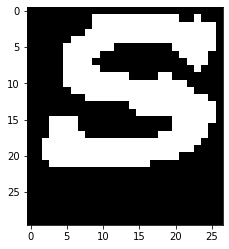

entered if
['4', 'K', '5', 'S', 'Q']
S
saved an img S
132 157
[  3  22  30  61  68  94 104 129 132 157]


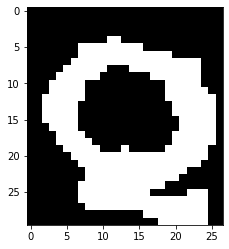

entered if
['4', 'K', '5', 'S', 'Q']
Q
saved an img Q
['4', 'M', '8', 'K', 'E']
4 24
[  4  24  27  91 102 132 136 161]


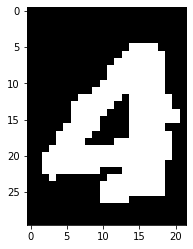

entered if
['4', 'M', '8', 'K', 'E']
4
saved an img 4
27 91
[  4  24  27  91 102 132 136 161]


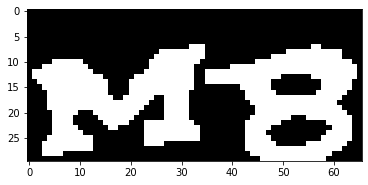

entered if
['4', 'M', '8', 'K', 'E']
M
saved an img M
102 132
[  4  24  27  91 102 132 136 161]


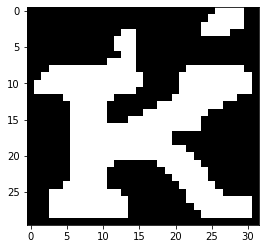

entered if
['4', 'M', '8', 'K', 'E']
8
saved an img 8
136 161
[  4  24  27  91 102 132 136 161]


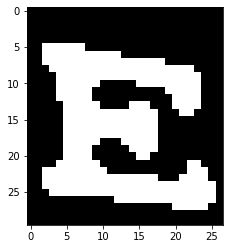

entered if
['4', 'M', '8', 'K', 'E']
K
saved an img K
['4', 'Q', '1', 'P', 'Z']
2 21
[  2  21  32  62  71  92 108 136 137 158]


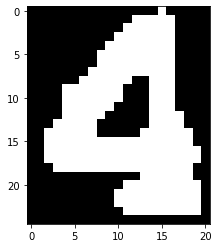

entered if
['4', 'Q', '1', 'P', 'Z']
4
saved an img 4
32 62
[  2  21  32  62  71  92 108 136 137 158]


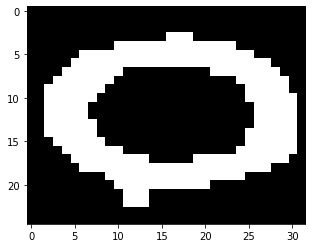

entered if
['4', 'Q', '1', 'P', 'Z']
Q
saved an img Q
71 92
[  2  21  32  62  71  92 108 136 137 158]


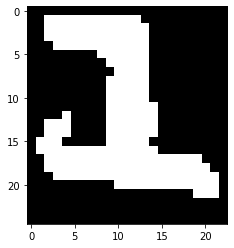

entered if
['4', 'Q', '1', 'P', 'Z']
1
saved an img 1
108 136
[  2  21  32  62  71  92 108 136 137 158]


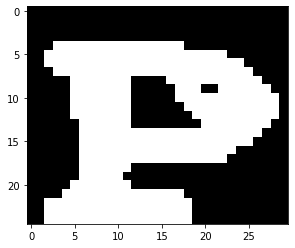

entered if
['4', 'Q', '1', 'P', 'Z']
P
saved an img P
137 158
[  2  21  32  62  71  92 108 136 137 158]


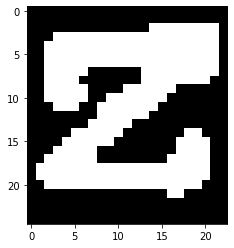

entered if
['4', 'Q', '1', 'P', 'Z']
Z
saved an img Z
['4', 'U', '2', 'T', 'V']
3 21
[  3  21  30  61  65  93 100 131 134 158]


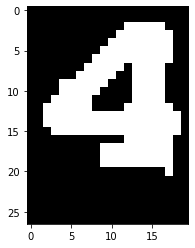

entered if
['4', 'U', '2', 'T', 'V']
4
saved an img 4
30 61
[  3  21  30  61  65  93 100 131 134 158]


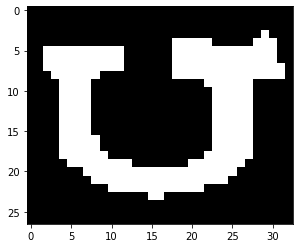

entered if
['4', 'U', '2', 'T', 'V']
U
saved an img U
65 93
[  3  21  30  61  65  93 100 131 134 158]


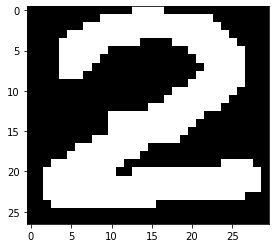

entered if
['4', 'U', '2', 'T', 'V']
2
saved an img 2
100 131
[  3  21  30  61  65  93 100 131 134 158]


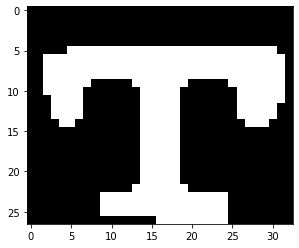

entered if
['4', 'U', '2', 'T', 'V']
T
saved an img T
134 158
[  3  21  30  61  65  93 100 131 134 158]


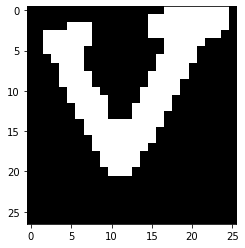

entered if
['4', 'U', '2', 'T', 'V']
V
saved an img V
['4', 'U', 'H', 'Q', 'T']
3 23
[  3  23  31  59  65  96 102 132 134 160]


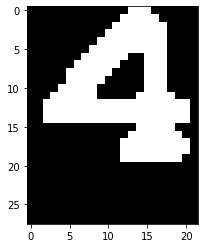

entered if
['4', 'U', 'H', 'Q', 'T']
4
saved an img 4
31 59
[  3  23  31  59  65  96 102 132 134 160]


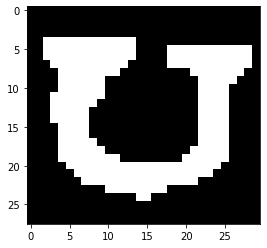

entered if
['4', 'U', 'H', 'Q', 'T']
U
saved an img U
65 96
[  3  23  31  59  65  96 102 132 134 160]


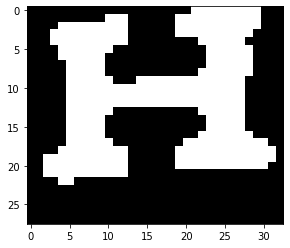

entered if
['4', 'U', 'H', 'Q', 'T']
H
saved an img H
102 132
[  3  23  31  59  65  96 102 132 134 160]


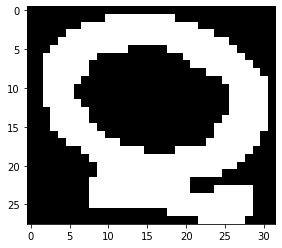

entered if
['4', 'U', 'H', 'Q', 'T']
Q
saved an img Q
134 160
[  3  23  31  59  65  96 102 132 134 160]


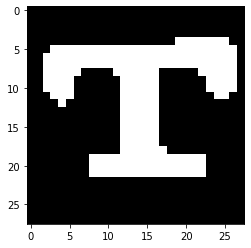

entered if
['4', 'U', 'H', 'Q', 'T']
T
saved an img T
['4', 'V', 'V', 'M', 'Q']
3 22
[  3  22  32  98 102 162]


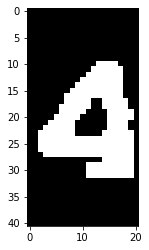

entered if
['4', 'V', 'V', 'M', 'Q']
4
saved an img 4
32 98
[  3  22  32  98 102 162]


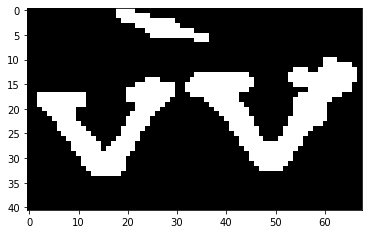

entered if
['4', 'V', 'V', 'M', 'Q']
V
saved an img V
102 162
[  3  22  32  98 102 162]


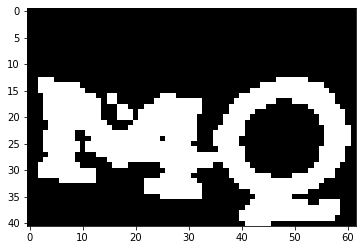

entered if
['4', 'V', 'V', 'M', 'Q']
V
saved an img V
['5', '3', '4', 'R', 'U']
0 22
[  0  22  34  58  69  93  99 133 137 162]


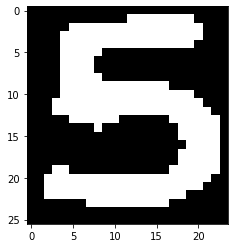

entered if
['5', '3', '4', 'R', 'U']
5
saved an img 5
34 58
[  0  22  34  58  69  93  99 133 137 162]


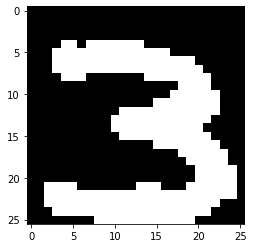

entered if
['5', '3', '4', 'R', 'U']
3
saved an img 3
69 93
[  0  22  34  58  69  93  99 133 137 162]


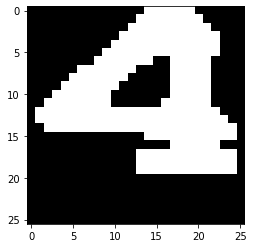

entered if
['5', '3', '4', 'R', 'U']
4
saved an img 4
99 133
[  0  22  34  58  69  93  99 133 137 162]


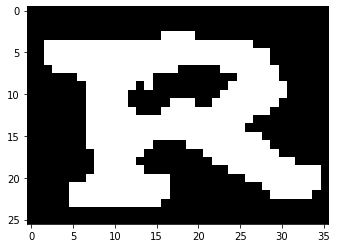

entered if
['5', '3', '4', 'R', 'U']
R
saved an img R
137 162
[  0  22  34  58  69  93  99 133 137 162]


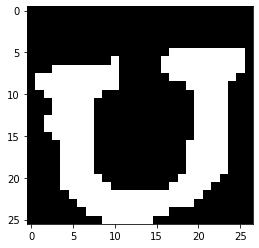

entered if
['5', '3', '4', 'R', 'U']
U
saved an img U
['5', '6', '6', 'H', 'C']
4 25
[  4  25  32  56  72  94 101 132 134 159]


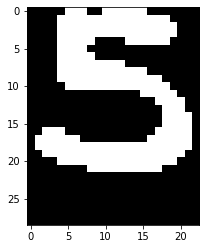

entered if
['5', '6', '6', 'H', 'C']
5
saved an img 5
32 56
[  4  25  32  56  72  94 101 132 134 159]


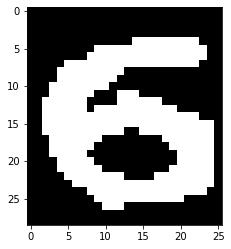

entered if
['5', '6', '6', 'H', 'C']
6
saved an img 6
72 94
[  4  25  32  56  72  94 101 132 134 159]


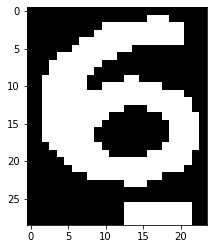

entered if
['5', '6', '6', 'H', 'C']
6
saved an img 6
101 132
[  4  25  32  56  72  94 101 132 134 159]


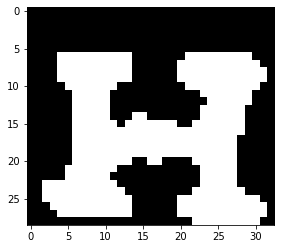

entered if
['5', '6', '6', 'H', 'C']
H
saved an img H
134 159
[  4  25  32  56  72  94 101 132 134 159]


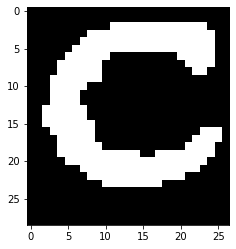

entered if
['5', '6', '6', 'H', 'C']
C
saved an img C
['5', 'A', 'A', 'M', 'X']
2 20
[  2  20  28  60  63 162]


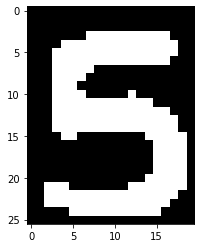

entered if
['5', 'A', 'A', 'M', 'X']
5
saved an img 5
28 60
[  2  20  28  60  63 162]


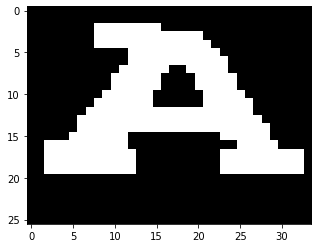

entered if
['5', 'A', 'A', 'M', 'X']
A
saved an img A
63 162
[  2  20  28  60  63 162]


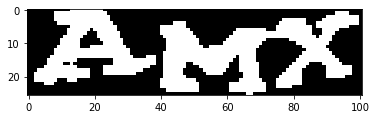

entered if
['5', 'A', 'A', 'M', 'X']
A
saved an img A
['5', 'F', 'F', 'Y', 'I']
4 29
[  4  29  30  62  70  97 103 127 135 158]


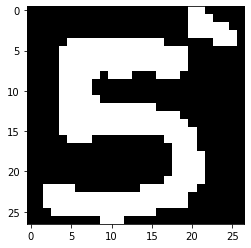

entered if
['5', 'F', 'F', 'Y', 'I']
5
saved an img 5
30 62
[  4  29  30  62  70  97 103 127 135 158]


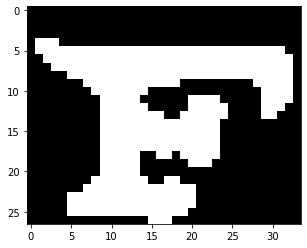

entered if
['5', 'F', 'F', 'Y', 'I']
F
saved an img F
70 97
[  4  29  30  62  70  97 103 127 135 158]


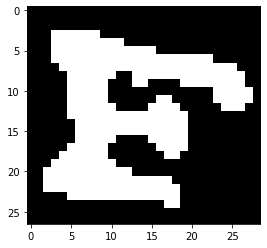

entered if
['5', 'F', 'F', 'Y', 'I']
F
saved an img F
103 127
[  4  29  30  62  70  97 103 127 135 158]


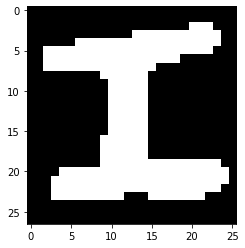

entered if
['5', 'F', 'F', 'Y', 'I']
Y
saved an img Y
135 158
[  4  29  30  62  70  97 103 127 135 158]


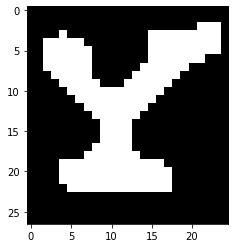

entered if
['5', 'F', 'F', 'Y', 'I']
I
saved an img I
['5', 'F', 'I', 'L', '7']
3 22
[  3  22  31  65  69  93 103 132 140 160]


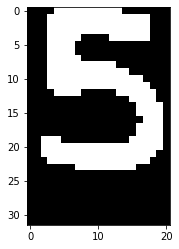

entered if
['5', 'F', 'I', 'L', '7']
5
saved an img 5
31 65
[  3  22  31  65  69  93 103 132 140 160]


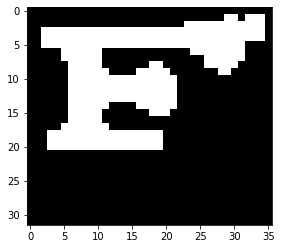

entered if
['5', 'F', 'I', 'L', '7']
F
saved an img F
69 93
[  3  22  31  65  69  93 103 132 140 160]


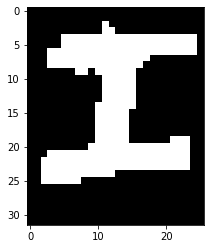

entered if
['5', 'F', 'I', 'L', '7']
I
saved an img I
103 132
[  3  22  31  65  69  93 103 132 140 160]


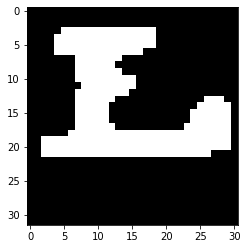

entered if
['5', 'F', 'I', 'L', '7']
L
saved an img L
140 160
[  3  22  31  65  69  93 103 132 140 160]


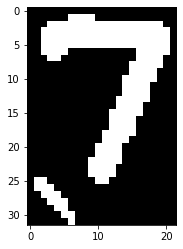

entered if
['5', 'F', 'I', 'L', '7']
7
saved an img 7
['5', 'G', 'L', '8', 'M']
2 19
[  2  19  30  61  65  94 104 132 135 165]


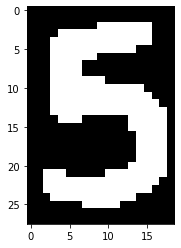

entered if
['5', 'G', 'L', '8', 'M']
5
saved an img 5
30 61
[  2  19  30  61  65  94 104 132 135 165]


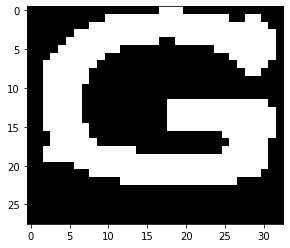

entered if
['5', 'G', 'L', '8', 'M']
G
saved an img G
65 94
[  2  19  30  61  65  94 104 132 135 165]


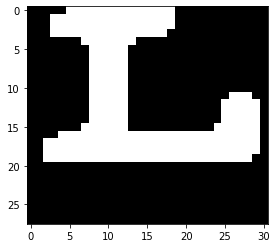

entered if
['5', 'G', 'L', '8', 'M']
L
saved an img L
104 132
[  2  19  30  61  65  94 104 132 135 165]


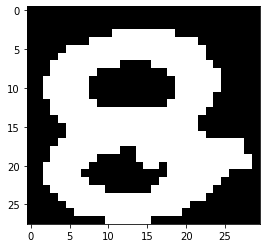

entered if
['5', 'G', 'L', '8', 'M']
8
saved an img 8
135 165
[  2  19  30  61  65  94 104 132 135 165]


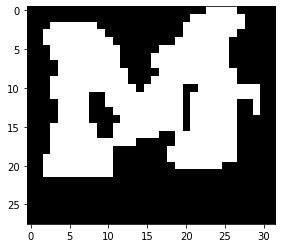

entered if
['5', 'G', 'L', '8', 'M']
M
saved an img M
['5', 'H', 'W', '4', 'P']
24 32
[ 24  32 100 104 129 135 158]


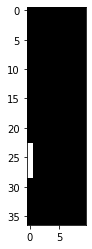

entered if
['5', 'H', 'W', '4', 'P']
5
saved an img 5
100 104
[ 24  32 100 104 129 135 158]


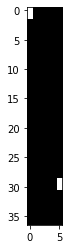

entered if
['5', 'H', 'W', '4', 'P']
H
saved an img H
129 135
[ 24  32 100 104 129 135 158]


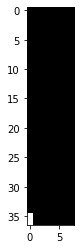

entered if
['5', 'H', 'W', '4', 'P']
W
saved an img W
['5', 'P', '6', 'T', 'D']
5 22
[  5  22  31  59  69  94 103 131 135 159]


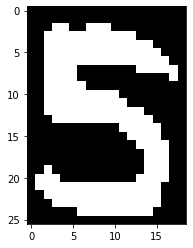

entered if
['5', 'P', '6', 'T', 'D']
5
saved an img 5
31 59
[  5  22  31  59  69  94 103 131 135 159]


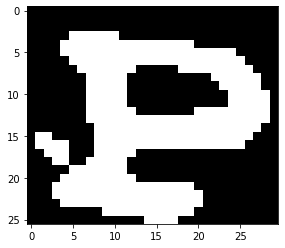

entered if
['5', 'P', '6', 'T', 'D']
P
saved an img P
69 94
[  5  22  31  59  69  94 103 131 135 159]


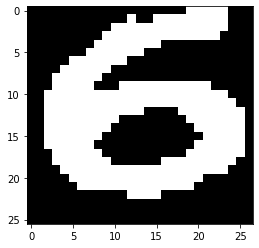

entered if
['5', 'P', '6', 'T', 'D']
6
saved an img 6
103 131
[  5  22  31  59  69  94 103 131 135 159]


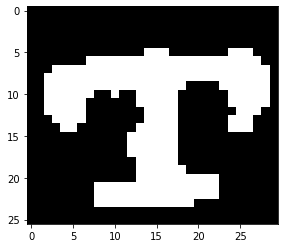

entered if
['5', 'P', '6', 'T', 'D']
T
saved an img T
135 159
[  5  22  31  59  69  94 103 131 135 159]


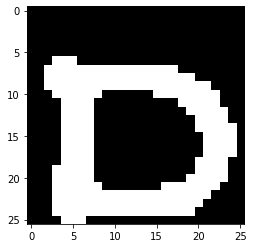

entered if
['5', 'P', '6', 'T', 'D']
D
saved an img D
['5', 'U', '9', 'F', 'Z']
4 23
[  4  23  26  59  69  94 104 131 138 158]


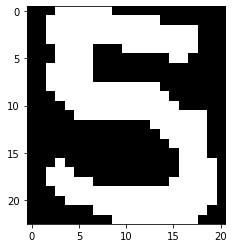

entered if
['5', 'U', '9', 'F', 'Z']
5
saved an img 5
26 59
[  4  23  26  59  69  94 104 131 138 158]


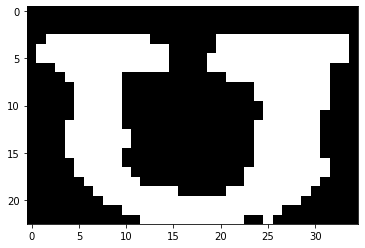

entered if
['5', 'U', '9', 'F', 'Z']
U
saved an img U
69 94
[  4  23  26  59  69  94 104 131 138 158]


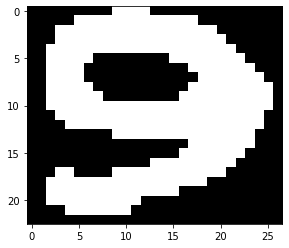

entered if
['5', 'U', '9', 'F', 'Z']
9
saved an img 9
104 131
[  4  23  26  59  69  94 104 131 138 158]


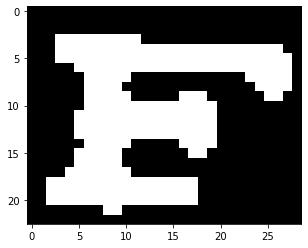

entered if
['5', 'U', '9', 'F', 'Z']
F
saved an img F
138 158
[  4  23  26  59  69  94 104 131 138 158]


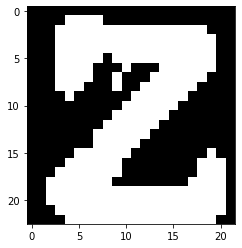

entered if
['5', 'U', '9', 'F', 'Z']
Z
saved an img Z
['5', 'Y', 'V', 'F', '3']
3 25
[  3  25  31  61  68  97 102 134 138 157]


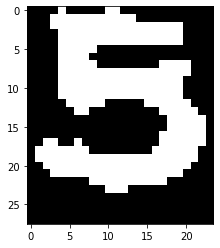

entered if
['5', 'Y', 'V', 'F', '3']
5
saved an img 5
31 61
[  3  25  31  61  68  97 102 134 138 157]


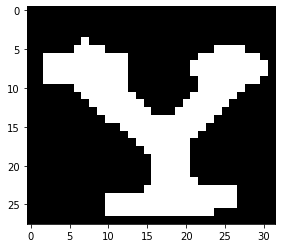

entered if
['5', 'Y', 'V', 'F', '3']
Y
saved an img Y
68 97
[  3  25  31  61  68  97 102 134 138 157]


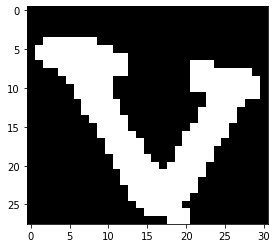

entered if
['5', 'Y', 'V', 'F', '3']
V
saved an img V
102 134
[  3  25  31  61  68  97 102 134 138 157]


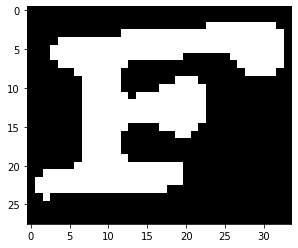

entered if
['5', 'Y', 'V', 'F', '3']
F
saved an img F
138 157
[  3  25  31  61  68  97 102 134 138 157]


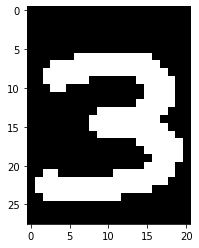

entered if
['5', 'Y', 'V', 'F', '3']
3
saved an img 3
['6', '1', 'S', '2', '2']
3 23
[  3  23  34  48  63  94 105 156]


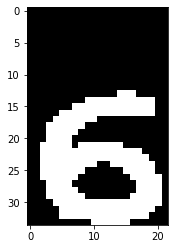

entered if
['6', '1', 'S', '2', '2']
6
saved an img 6
34 48
[  3  23  34  48  63  94 105 156]


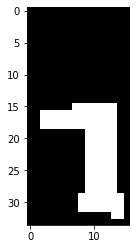

entered if
['6', '1', 'S', '2', '2']
1
saved an img 1
63 94
[  3  23  34  48  63  94 105 156]


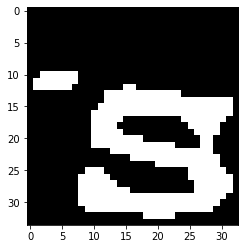

entered if
['6', '1', 'S', '2', '2']
S
saved an img S
105 156
[  3  23  34  48  63  94 105 156]


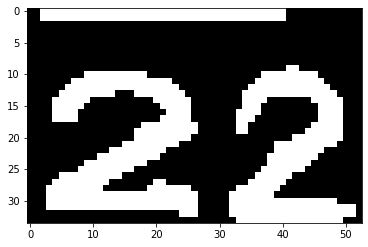

entered if
['6', '1', 'S', '2', '2']
2
saved an img 2
['6', '8', '7', 'G', 'Q']
3 23
[  3  23  32  56  67  91 102 131 134 158]


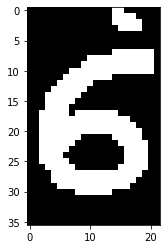

entered if
['6', '8', '7', 'G', 'Q']
6
saved an img 6
32 56
[  3  23  32  56  67  91 102 131 134 158]


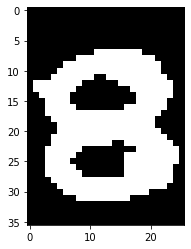

entered if
['6', '8', '7', 'G', 'Q']
8
saved an img 8
67 91
[  3  23  32  56  67  91 102 131 134 158]


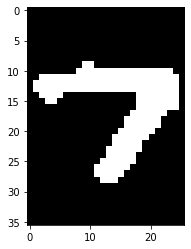

entered if
['6', '8', '7', 'G', 'Q']
7
saved an img 7
102 131
[  3  23  32  56  67  91 102 131 134 158]


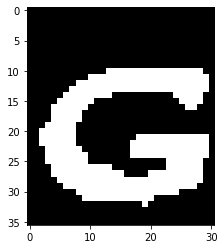

entered if
['6', '8', '7', 'G', 'Q']
G
saved an img G
134 158
[  3  23  32  56  67  91 102 131 134 158]


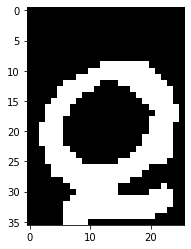

entered if
['6', '8', '7', 'G', 'Q']
Q
saved an img Q
['6', 'D', 'V', 'Y', 'W']
4 25
[  4  25  32  62  65 102 104 162]


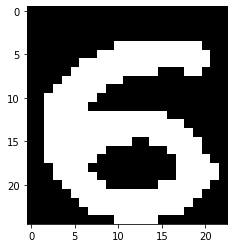

entered if
['6', 'D', 'V', 'Y', 'W']
6
saved an img 6
32 62
[  4  25  32  62  65 102 104 162]


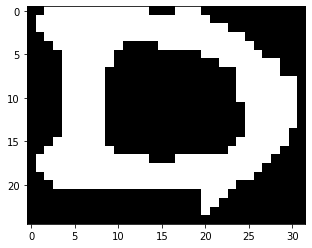

entered if
['6', 'D', 'V', 'Y', 'W']
D
saved an img D
65 102
[  4  25  32  62  65 102 104 162]


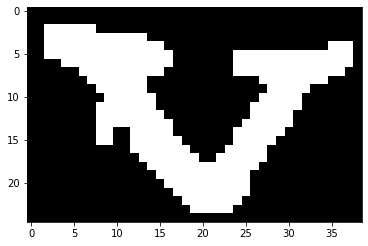

entered if
['6', 'D', 'V', 'Y', 'W']
V
saved an img V
104 162
[  4  25  32  62  65 102 104 162]


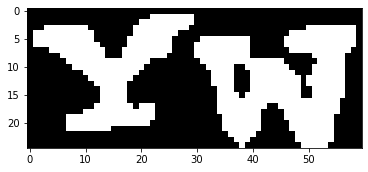

entered if
['6', 'D', 'V', 'Y', 'W']
Y
saved an img Y
['6', 'M', 'I', 'W', '6']
2 22
[  2  22  23  91 101 132 142 158]


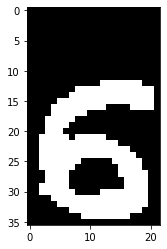

entered if
['6', 'M', 'I', 'W', '6']
6
saved an img 6
23 91
[  2  22  23  91 101 132 142 158]


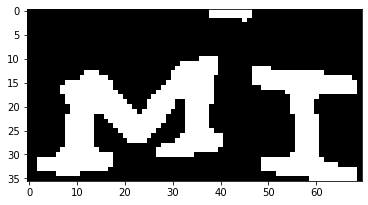

entered if
['6', 'M', 'I', 'W', '6']
M
saved an img M
101 132
[  2  22  23  91 101 132 142 158]


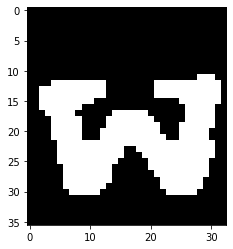

entered if
['6', 'M', 'I', 'W', '6']
I
saved an img I
142 158
[  2  22  23  91 101 132 142 158]


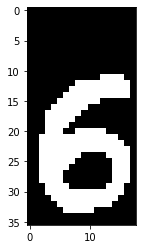

entered if
['6', 'M', 'I', 'W', '6']
W
saved an img W
['6', 'U', 'B', 'J', 'U']
6 58
[  6  58  66  98 102 162]


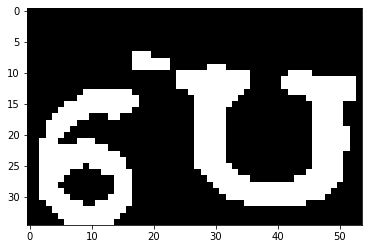

entered if
['6', 'U', 'B', 'J', 'U']
6
saved an img 6
66 98
[  6  58  66  98 102 162]


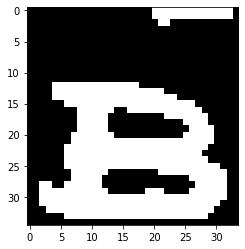

entered if
['6', 'U', 'B', 'J', 'U']
U
saved an img U
102 162
[  6  58  66  98 102 162]


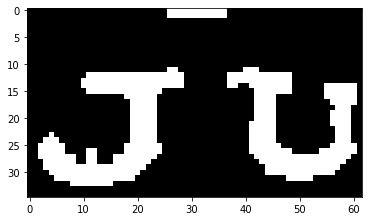

entered if
['6', 'U', 'B', 'J', 'U']
B
saved an img B
['6', 'Y', 'B', 'I', 'A']
5 23
[  5  23  31  60  64  96 106 127 134 158]


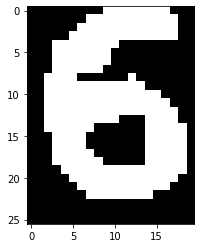

entered if
['6', 'Y', 'B', 'I', 'A']
6
saved an img 6
31 60
[  5  23  31  60  64  96 106 127 134 158]


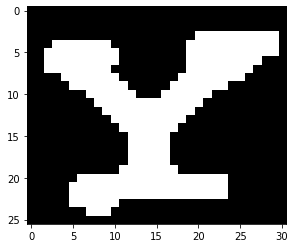

entered if
['6', 'Y', 'B', 'I', 'A']
Y
saved an img Y
64 96
[  5  23  31  60  64  96 106 127 134 158]


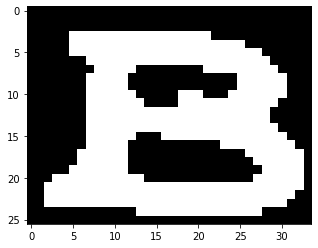

entered if
['6', 'Y', 'B', 'I', 'A']
B
saved an img B
106 127
[  5  23  31  60  64  96 106 127 134 158]


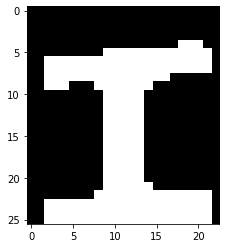

entered if
['6', 'Y', 'B', 'I', 'A']
I
saved an img I
134 158
[  5  23  31  60  64  96 106 127 134 158]


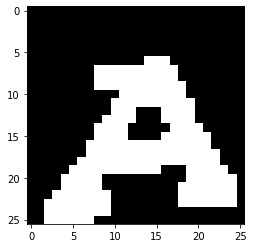

entered if
['6', 'Y', 'B', 'I', 'A']
A
saved an img A
['6', 'Z', '3', 'Y', 'J']
0 20
[  0  20  37  62  68  94 105 132 135 158]


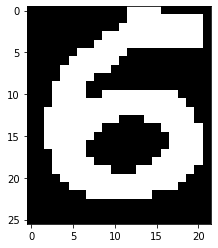

entered if
['6', 'Z', '3', 'Y', 'J']
6
saved an img 6
37 62
[  0  20  37  62  68  94 105 132 135 158]


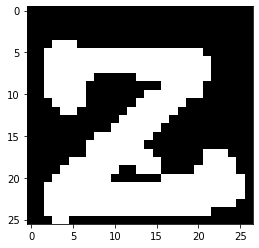

entered if
['6', 'Z', '3', 'Y', 'J']
Z
saved an img Z
68 94
[  0  20  37  62  68  94 105 132 135 158]


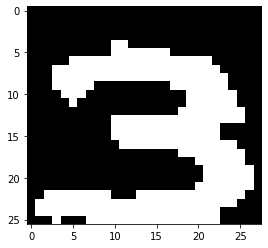

entered if
['6', 'Z', '3', 'Y', 'J']
3
saved an img 3
105 132
[  0  20  37  62  68  94 105 132 135 158]


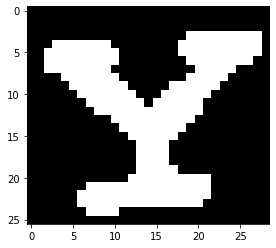

entered if
['6', 'Z', '3', 'Y', 'J']
Y
saved an img Y
135 158
[  0  20  37  62  68  94 105 132 135 158]


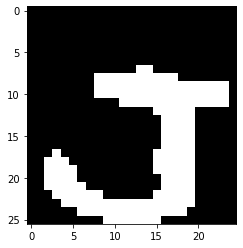

entered if
['6', 'Z', '3', 'Y', 'J']
J
saved an img J
['6', 'Z', 'C', 'I', 'R']
2 23
[  2  23  31  58  64  93 102 129 136 160]


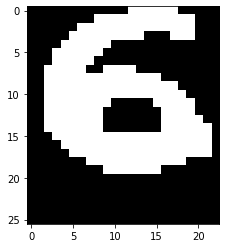

entered if
['6', 'Z', 'C', 'I', 'R']
6
saved an img 6
31 58
[  2  23  31  58  64  93 102 129 136 160]


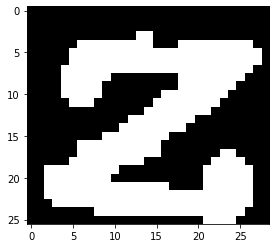

entered if
['6', 'Z', 'C', 'I', 'R']
Z
saved an img Z
64 93
[  2  23  31  58  64  93 102 129 136 160]


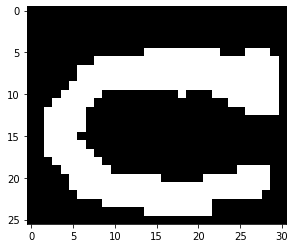

entered if
['6', 'Z', 'C', 'I', 'R']
C
saved an img C
102 129
[  2  23  31  58  64  93 102 129 136 160]


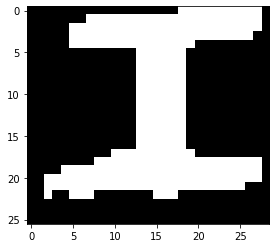

entered if
['6', 'Z', 'C', 'I', 'R']
I
saved an img I
136 160
[  2  23  31  58  64  93 102 129 136 160]


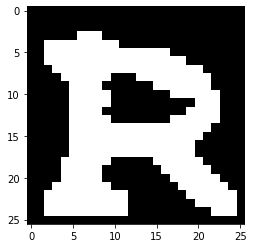

entered if
['6', 'Z', 'C', 'I', 'R']
R
saved an img R
['7', '2', 'R', 'X', 'F']
0 3
[  0   3  24  29  55  67  97 103 134 139]


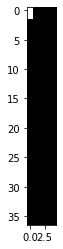

entered if
['7', '2', 'R', 'X', 'F']
7
saved an img 7
24 29
[  0   3  24  29  55  67  97 103 134 139]


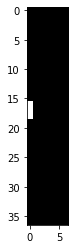

entered if
['7', '2', 'R', 'X', 'F']
2
saved an img 2
55 67
[  0   3  24  29  55  67  97 103 134 139]


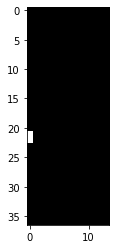

entered if
['7', '2', 'R', 'X', 'F']
R
saved an img R
97 103
[  0   3  24  29  55  67  97 103 134 139]


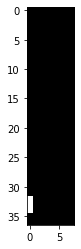

entered if
['7', '2', 'R', 'X', 'F']
X
saved an img X
134 139
[  0   3  24  29  55  67  97 103 134 139]


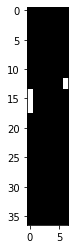

entered if
['7', '2', 'R', 'X', 'F']
F
saved an img F
['7', '5', 'I', '3', 'Q']
2 24
[  2  24  30  57  72  93 105 129 138 163]


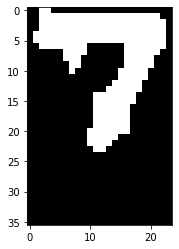

entered if
['7', '5', 'I', '3', 'Q']
7
saved an img 7
30 57
[  2  24  30  57  72  93 105 129 138 163]


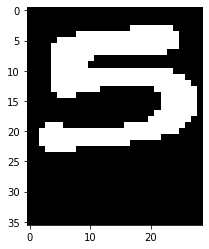

entered if
['7', '5', 'I', '3', 'Q']
5
saved an img 5
72 93
[  2  24  30  57  72  93 105 129 138 163]


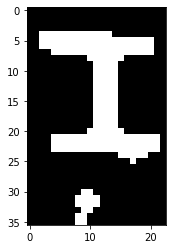

entered if
['7', '5', 'I', '3', 'Q']
I
saved an img I
105 129
[  2  24  30  57  72  93 105 129 138 163]


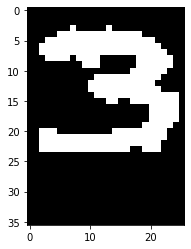

entered if
['7', '5', 'I', '3', 'Q']
3
saved an img 3
138 163
[  2  24  30  57  72  93 105 129 138 163]


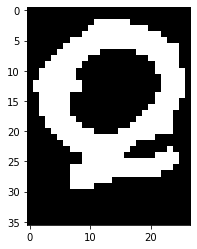

entered if
['7', '5', 'I', '3', 'Q']
Q
saved an img Q
['7', '7', 'O', 'O', 'A']
3 23
[  3  23  33  58  65  95 103 129 135 161]


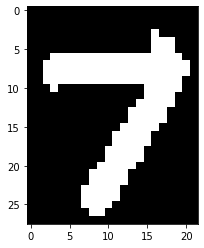

entered if
['7', '7', 'O', 'O', 'A']
7
saved an img 7
33 58
[  3  23  33  58  65  95 103 129 135 161]


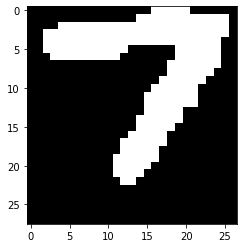

entered if
['7', '7', 'O', 'O', 'A']
7
saved an img 7
65 95
[  3  23  33  58  65  95 103 129 135 161]


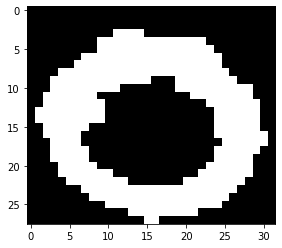

entered if
['7', '7', 'O', 'O', 'A']
O
saved an img O
103 129
[  3  23  33  58  65  95 103 129 135 161]


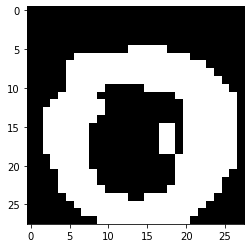

entered if
['7', '7', 'O', 'O', 'A']
O
saved an img O
135 161
[  3  23  33  58  65  95 103 129 135 161]


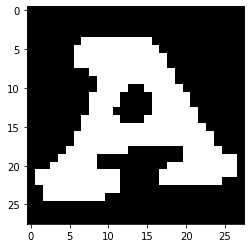

entered if
['7', '7', 'O', 'O', 'A']
A
saved an img A
['7', '9', 'K', 'K', 'P']
22 33
[ 22  33  58  64  96 102 131 139 160]


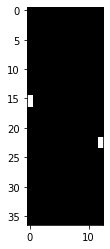

entered if
['7', '9', 'K', 'K', 'P']
7
saved an img 7
58 64
[ 22  33  58  64  96 102 131 139 160]


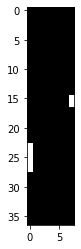

entered if
['7', '9', 'K', 'K', 'P']
9
saved an img 9
96 102
[ 22  33  58  64  96 102 131 139 160]


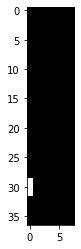

entered if
['7', '9', 'K', 'K', 'P']
K
saved an img K
131 139
[ 22  33  58  64  96 102 131 139 160]


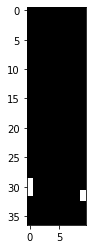

entered if
['7', '9', 'K', 'K', 'P']
K
saved an img K
['7', 'A', 'M', 'Z', '2']
3 23
[  3  23  30  58  64  99 104 129 138 159]


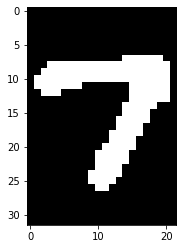

entered if
['7', 'A', 'M', 'Z', '2']
7
saved an img 7
30 58
[  3  23  30  58  64  99 104 129 138 159]


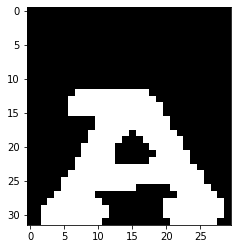

entered if
['7', 'A', 'M', 'Z', '2']
A
saved an img A
64 99
[  3  23  30  58  64  99 104 129 138 159]


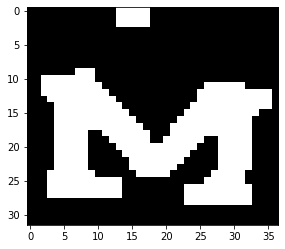

entered if
['7', 'A', 'M', 'Z', '2']
M
saved an img M
104 129
[  3  23  30  58  64  99 104 129 138 159]


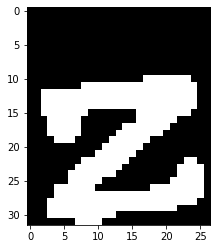

entered if
['7', 'A', 'M', 'Z', '2']
Z
saved an img Z
138 159
[  3  23  30  58  64  99 104 129 138 159]


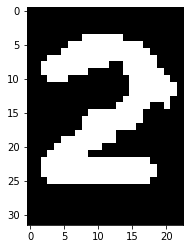

entered if
['7', 'A', 'M', 'Z', '2']
2
saved an img 2
['7', 'J', 'B', 'K', 'B']
2 20
[  2  20  30  61  66  96 102 132 135 162]


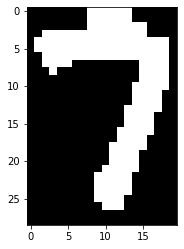

entered if
['7', 'J', 'B', 'K', 'B']
7
saved an img 7
30 61
[  2  20  30  61  66  96 102 132 135 162]


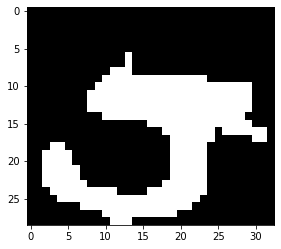

entered if
['7', 'J', 'B', 'K', 'B']
J
saved an img J
66 96
[  2  20  30  61  66  96 102 132 135 162]


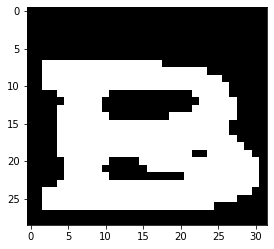

entered if
['7', 'J', 'B', 'K', 'B']
B
saved an img B
102 132
[  2  20  30  61  66  96 102 132 135 162]


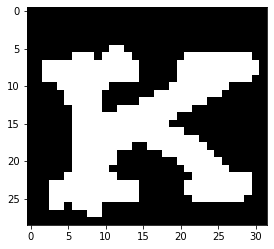

entered if
['7', 'J', 'B', 'K', 'B']
K
saved an img K
135 162
[  2  20  30  61  66  96 102 132 135 162]


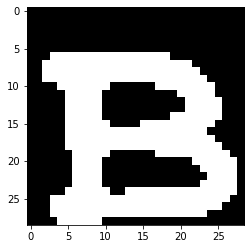

entered if
['7', 'J', 'B', 'K', 'B']
B
saved an img B
['7', 'L', 'C', '9', '2']
6 25
[  6  25  29  61  67  95 106 131 140 156]


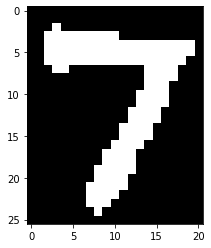

entered if
['7', 'L', 'C', '9', '2']
7
saved an img 7
29 61
[  6  25  29  61  67  95 106 131 140 156]


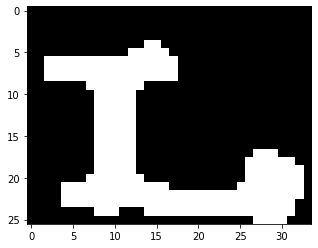

entered if
['7', 'L', 'C', '9', '2']
L
saved an img L
67 95
[  6  25  29  61  67  95 106 131 140 156]


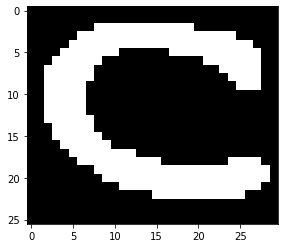

entered if
['7', 'L', 'C', '9', '2']
C
saved an img C
106 131
[  6  25  29  61  67  95 106 131 140 156]


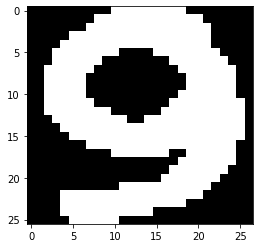

entered if
['7', 'L', 'C', '9', '2']
9
saved an img 9
140 156
[  6  25  29  61  67  95 106 131 140 156]


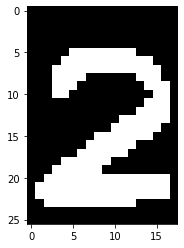

entered if
['7', 'L', 'C', '9', '2']
2
saved an img 2
['7', 'L', 'K', 'Z', 'Y']
4 22
[  4  22  34  60  67  97 105 128 136 157]


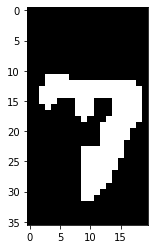

entered if
['7', 'L', 'K', 'Z', 'Y']
7
saved an img 7
34 60
[  4  22  34  60  67  97 105 128 136 157]


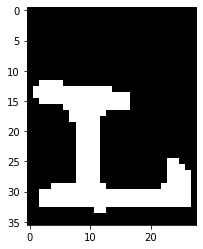

entered if
['7', 'L', 'K', 'Z', 'Y']
L
saved an img L
67 97
[  4  22  34  60  67  97 105 128 136 157]


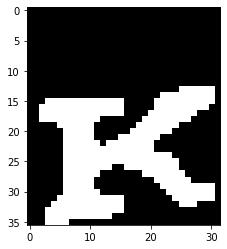

entered if
['7', 'L', 'K', 'Z', 'Y']
K
saved an img K
105 128
[  4  22  34  60  67  97 105 128 136 157]


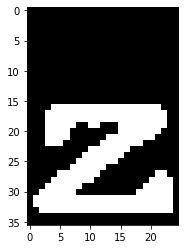

entered if
['7', 'L', 'K', 'Z', 'Y']
Z
saved an img Z
136 157
[  4  22  34  60  67  97 105 128 136 157]


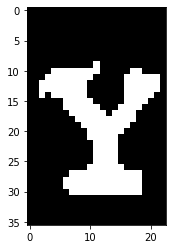

entered if
['7', 'L', 'K', 'Z', 'Y']
Y
saved an img Y
['7', 'N', 'M', 'U', 'W']
19 31
[ 19  31  65  66  99 103 134 136 161]


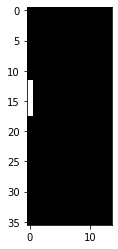

entered if
['7', 'N', 'M', 'U', 'W']
7
saved an img 7
65 66
[ 19  31  65  66  99 103 134 136 161]


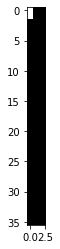

entered if
['7', 'N', 'M', 'U', 'W']
N
saved an img N
99 103
[ 19  31  65  66  99 103 134 136 161]


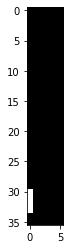

entered if
['7', 'N', 'M', 'U', 'W']
M
saved an img M
134 136
[ 19  31  65  66  99 103 134 136 161]


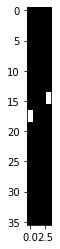

entered if
['7', 'N', 'M', 'U', 'W']
U
saved an img U
['7', 'T', '0', 'L', '6']
1 23
[  1  23  29  58  71  94 103 133 138 157]


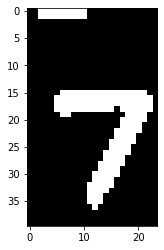

entered if
['7', 'T', '0', 'L', '6']
7
saved an img 7
29 58
[  1  23  29  58  71  94 103 133 138 157]


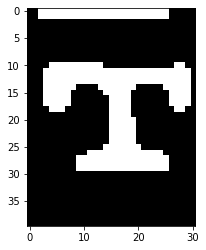

entered if
['7', 'T', '0', 'L', '6']
T
saved an img T
71 94
[  1  23  29  58  71  94 103 133 138 157]


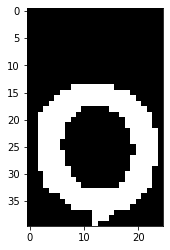

entered if
['7', 'T', '0', 'L', '6']
0
saved an img 0
103 133
[  1  23  29  58  71  94 103 133 138 157]


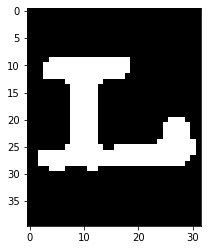

entered if
['7', 'T', '0', 'L', '6']
L
saved an img L
138 157
[  1  23  29  58  71  94 103 133 138 157]


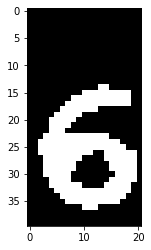

entered if
['7', 'T', '0', 'L', '6']
6
saved an img 6
['7', 'T', '6', '2', '7']
0 23
[  0  23  28  58  69  92 101 126 140 157]


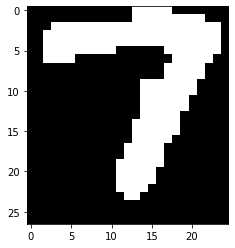

entered if
['7', 'T', '6', '2', '7']
7
saved an img 7
28 58
[  0  23  28  58  69  92 101 126 140 157]


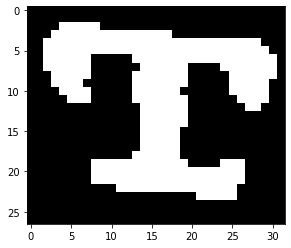

entered if
['7', 'T', '6', '2', '7']
T
saved an img T
69 92
[  0  23  28  58  69  92 101 126 140 157]


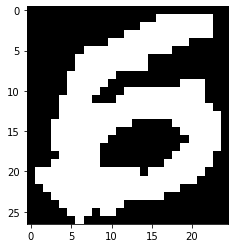

entered if
['7', 'T', '6', '2', '7']
6
saved an img 6
101 126
[  0  23  28  58  69  92 101 126 140 157]


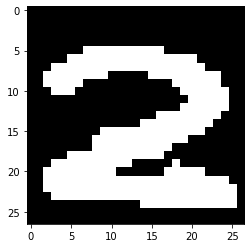

entered if
['7', 'T', '6', '2', '7']
2
saved an img 2
140 157
[  0  23  28  58  69  92 101 126 140 157]


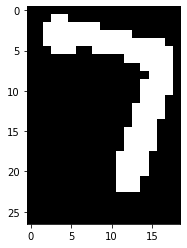

entered if
['7', 'T', '6', '2', '7']
7
saved an img 7
['7', 'X', 'N', '2', '4']
4 21
[  4  21  31  59  63  99 101 126 136 156]


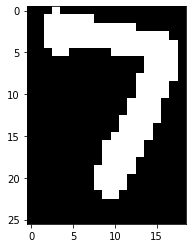

entered if
['7', 'X', 'N', '2', '4']
7
saved an img 7
31 59
[  4  21  31  59  63  99 101 126 136 156]


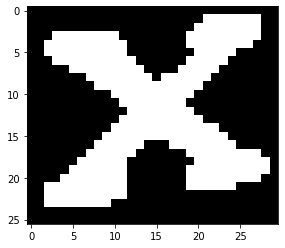

entered if
['7', 'X', 'N', '2', '4']
X
saved an img X
63 99
[  4  21  31  59  63  99 101 126 136 156]


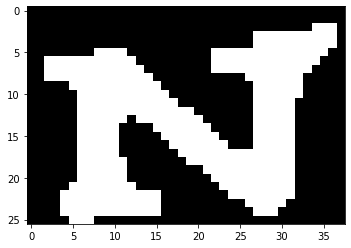

entered if
['7', 'X', 'N', '2', '4']
N
saved an img N
101 126
[  4  21  31  59  63  99 101 126 136 156]


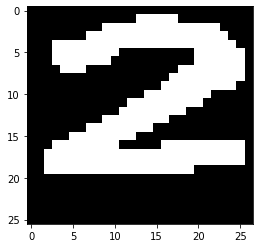

entered if
['7', 'X', 'N', '2', '4']
2
saved an img 2
136 156
[  4  21  31  59  63  99 101 126 136 156]


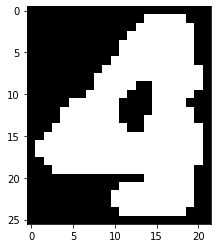

entered if
['7', 'X', 'N', '2', '4']
4
saved an img 4
['8', '0', 'C', 'P', 'A']
4 25
[  4  25  31  57  64  98 101 132 134 163]


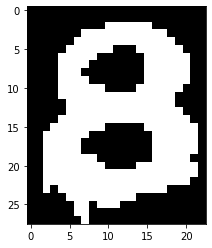

entered if
['8', '0', 'C', 'P', 'A']
8
saved an img 8
31 57
[  4  25  31  57  64  98 101 132 134 163]


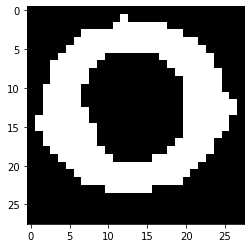

entered if
['8', '0', 'C', 'P', 'A']
0
saved an img 0
64 98
[  4  25  31  57  64  98 101 132 134 163]


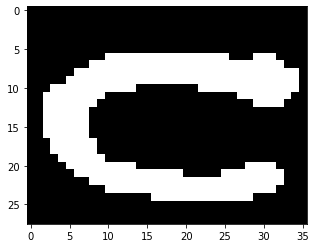

entered if
['8', '0', 'C', 'P', 'A']
C
saved an img C
101 132
[  4  25  31  57  64  98 101 132 134 163]


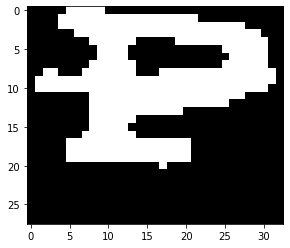

entered if
['8', '0', 'C', 'P', 'A']
P
saved an img P
134 163
[  4  25  31  57  64  98 101 132 134 163]


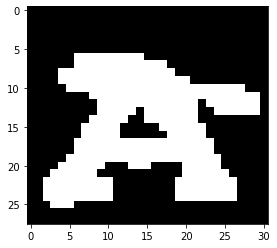

entered if
['8', '0', 'C', 'P', 'A']
A
saved an img A
['8', '1', '7', '9', 'F']
2 24
[  2  24  32  57  67  93 106 131 138 159]


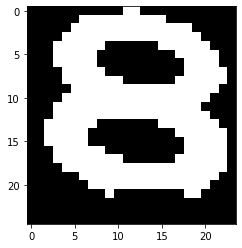

entered if
['8', '1', '7', '9', 'F']
8
saved an img 8
32 57
[  2  24  32  57  67  93 106 131 138 159]


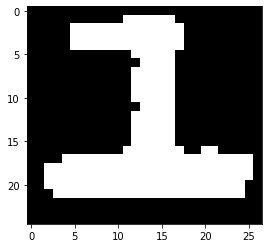

entered if
['8', '1', '7', '9', 'F']
1
saved an img 1
67 93
[  2  24  32  57  67  93 106 131 138 159]


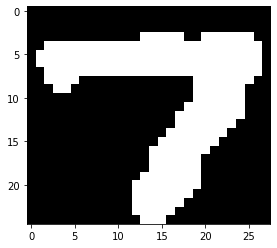

entered if
['8', '1', '7', '9', 'F']
7
saved an img 7
106 131
[  2  24  32  57  67  93 106 131 138 159]


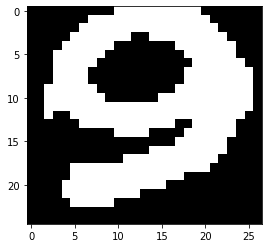

entered if
['8', '1', '7', '9', 'F']
9
saved an img 9
138 159
[  2  24  32  57  67  93 106 131 138 159]


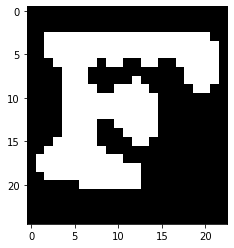

entered if
['8', '1', '7', '9', 'F']
F
saved an img F
['8', '5', '5', '2', '6']
4 23
[  4  23  33  56  66  94 104 131 135]


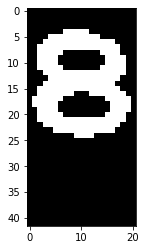

entered if
['8', '5', '5', '2', '6']
8
saved an img 8
33 56
[  4  23  33  56  66  94 104 131 135]


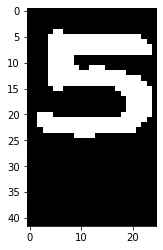

entered if
['8', '5', '5', '2', '6']
5
saved an img 5
66 94
[  4  23  33  56  66  94 104 131 135]


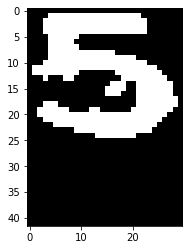

entered if
['8', '5', '5', '2', '6']
5
saved an img 5
104 131
[  4  23  33  56  66  94 104 131 135]


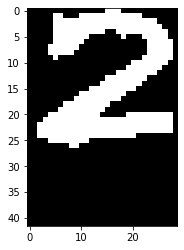

entered if
['8', '5', '5', '2', '6']
2
saved an img 2
['8', '7', 'A', 'M', 'Q']
4 24
[  4  24  29  55  62  94 100 135 137 162]


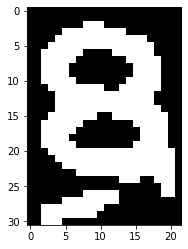

entered if
['8', '7', 'A', 'M', 'Q']
8
saved an img 8
29 55
[  4  24  29  55  62  94 100 135 137 162]


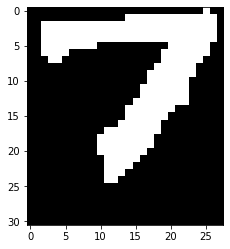

entered if
['8', '7', 'A', 'M', 'Q']
7
saved an img 7
62 94
[  4  24  29  55  62  94 100 135 137 162]


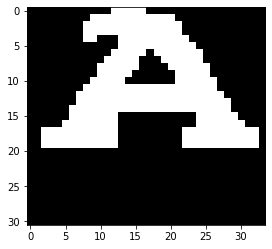

entered if
['8', '7', 'A', 'M', 'Q']
A
saved an img A
100 135
[  4  24  29  55  62  94 100 135 137 162]


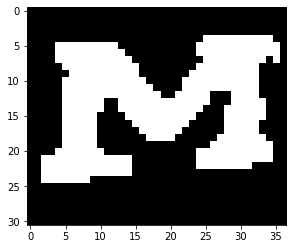

entered if
['8', '7', 'A', 'M', 'Q']
M
saved an img M
137 162
[  4  24  29  55  62  94 100 135 137 162]


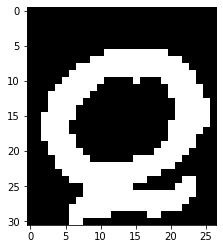

entered if
['8', '7', 'A', 'M', 'Q']
Q
saved an img Q
['8', 'E', 'W', 'Z', 'M']
1 22
[  1  22  26  57  65  95 107 130 135 162]


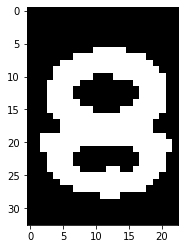

entered if
['8', 'E', 'W', 'Z', 'M']
8
saved an img 8
26 57
[  1  22  26  57  65  95 107 130 135 162]


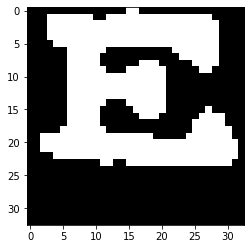

entered if
['8', 'E', 'W', 'Z', 'M']
E
saved an img E
65 95
[  1  22  26  57  65  95 107 130 135 162]


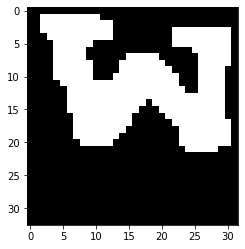

entered if
['8', 'E', 'W', 'Z', 'M']
W
saved an img W
107 130
[  1  22  26  57  65  95 107 130 135 162]


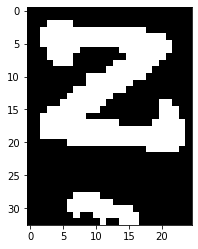

entered if
['8', 'E', 'W', 'Z', 'M']
Z
saved an img Z
135 162
[  1  22  26  57  65  95 107 130 135 162]


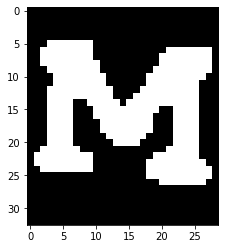

entered if
['8', 'E', 'W', 'Z', 'M']
M
saved an img M
['8', 'I', '4', 'Y', 'U']
4 25
[  4  25  32  56  67  92 100 129 138 162]


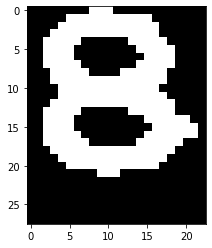

entered if
['8', 'I', '4', 'Y', 'U']
8
saved an img 8
32 56
[  4  25  32  56  67  92 100 129 138 162]


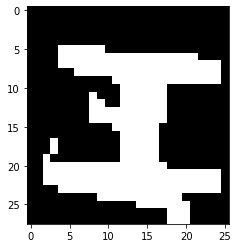

entered if
['8', 'I', '4', 'Y', 'U']
I
saved an img I
67 92
[  4  25  32  56  67  92 100 129 138 162]


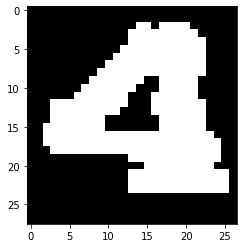

entered if
['8', 'I', '4', 'Y', 'U']
4
saved an img 4
100 129
[  4  25  32  56  67  92 100 129 138 162]


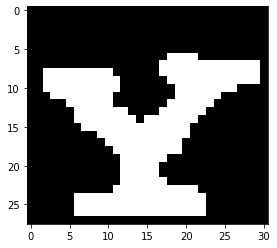

entered if
['8', 'I', '4', 'Y', 'U']
Y
saved an img Y
138 162
[  4  25  32  56  67  92 100 129 138 162]


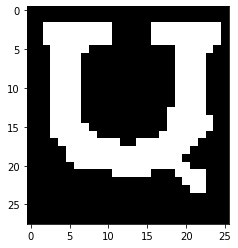

entered if
['8', 'I', '4', 'Y', 'U']
U
saved an img U
['8', 'I', 'X', 'E', 'G']
2 22
[  2  22  34  57  68  96 103 135 136 160]


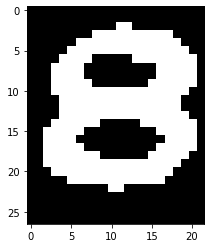

entered if
['8', 'I', 'X', 'E', 'G']
8
saved an img 8
34 57
[  2  22  34  57  68  96 103 135 136 160]


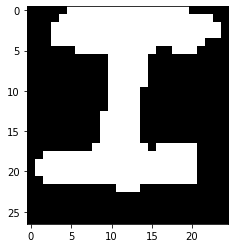

entered if
['8', 'I', 'X', 'E', 'G']
I
saved an img I
68 96
[  2  22  34  57  68  96 103 135 136 160]


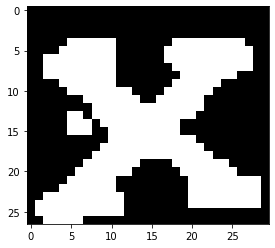

entered if
['8', 'I', 'X', 'E', 'G']
X
saved an img X
103 135
[  2  22  34  57  68  96 103 135 136 160]


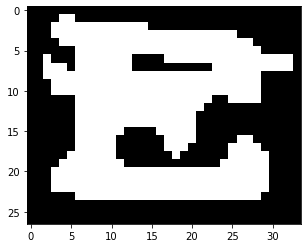

entered if
['8', 'I', 'X', 'E', 'G']
E
saved an img E
136 160
[  2  22  34  57  68  96 103 135 136 160]


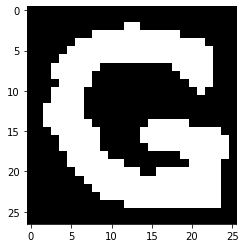

entered if
['8', 'I', 'X', 'E', 'G']
G
saved an img G
['8', 'M', 'G', '9', 'L']
1 22
[  1  22  28  62  67  98 108 131 138 164]


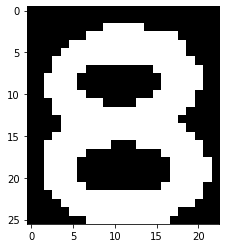

entered if
['8', 'M', 'G', '9', 'L']
8
saved an img 8
28 62
[  1  22  28  62  67  98 108 131 138 164]


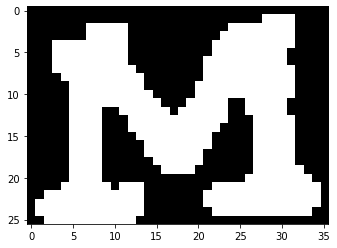

entered if
['8', 'M', 'G', '9', 'L']
M
saved an img M
67 98
[  1  22  28  62  67  98 108 131 138 164]


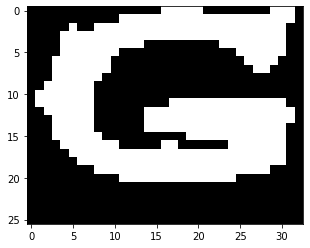

entered if
['8', 'M', 'G', '9', 'L']
G
saved an img G
108 131
[  1  22  28  62  67  98 108 131 138 164]


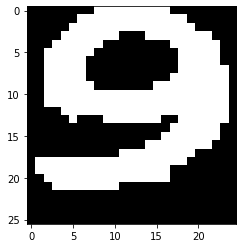

entered if
['8', 'M', 'G', '9', 'L']
9
saved an img 9
138 164
[  1  22  28  62  67  98 108 131 138 164]


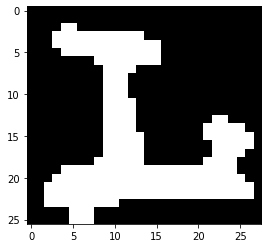

entered if
['8', 'M', 'G', '9', 'L']
L
saved an img L
['8', 'U', 'C', 'I', 'H']
3 23
[  3  23  34  63  66  95 104 126 138 161]


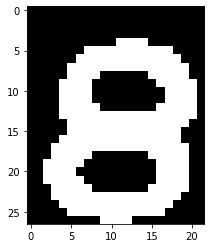

entered if
['8', 'U', 'C', 'I', 'H']
8
saved an img 8
34 63
[  3  23  34  63  66  95 104 126 138 161]


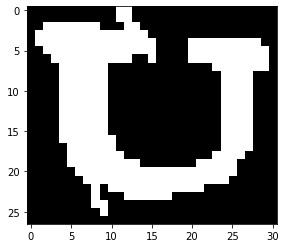

entered if
['8', 'U', 'C', 'I', 'H']
U
saved an img U
66 95
[  3  23  34  63  66  95 104 126 138 161]


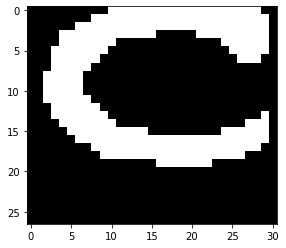

entered if
['8', 'U', 'C', 'I', 'H']
C
saved an img C
104 126
[  3  23  34  63  66  95 104 126 138 161]


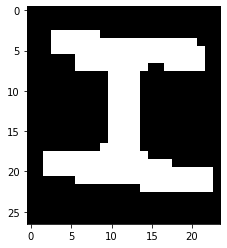

entered if
['8', 'U', 'C', 'I', 'H']
I
saved an img I
138 161
[  3  23  34  63  66  95 104 126 138 161]


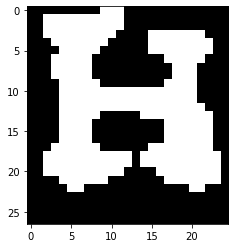

entered if
['8', 'U', 'C', 'I', 'H']
H
saved an img H
['8', 'W', 'H', 'Y', 'K']
6 25
[  6  25  27  61  68  94 101 132 134 160]


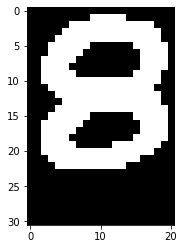

entered if
['8', 'W', 'H', 'Y', 'K']
8
saved an img 8
27 61
[  6  25  27  61  68  94 101 132 134 160]


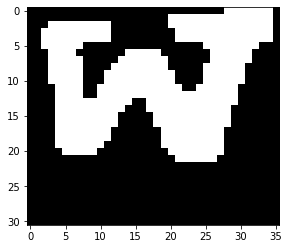

entered if
['8', 'W', 'H', 'Y', 'K']
W
saved an img W
68 94
[  6  25  27  61  68  94 101 132 134 160]


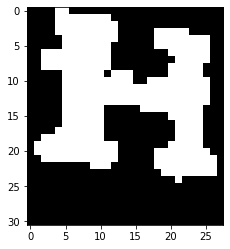

entered if
['8', 'W', 'H', 'Y', 'K']
H
saved an img H
101 132
[  6  25  27  61  68  94 101 132 134 160]


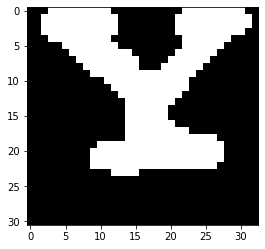

entered if
['8', 'W', 'H', 'Y', 'K']
Y
saved an img Y
134 160
[  6  25  27  61  68  94 101 132 134 160]


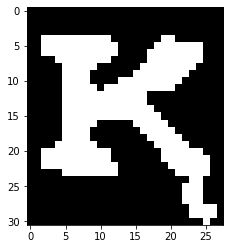

entered if
['8', 'W', 'H', 'Y', 'K']
K
saved an img K
['8', 'Z', '3', 'A', '6']
4 21
[  4  21  30  99 100 157]


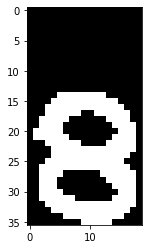

entered if
['8', 'Z', '3', 'A', '6']
8
saved an img 8
30 99
[  4  21  30  99 100 157]


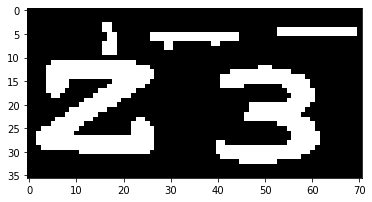

entered if
['8', 'Z', '3', 'A', '6']
Z
saved an img Z
100 157
[  4  21  30  99 100 157]


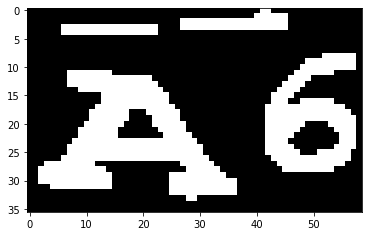

entered if
['8', 'Z', '3', 'A', '6']
3
saved an img 3
['9', '1', '2', 'W', 'D']
2 23
[  2  23  33  56  67  91 102 134 138 159]


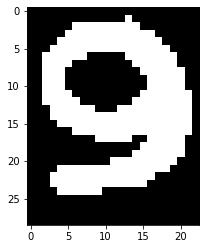

entered if
['9', '1', '2', 'W', 'D']
9
saved an img 9
33 56
[  2  23  33  56  67  91 102 134 138 159]


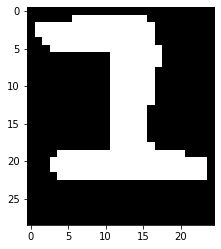

entered if
['9', '1', '2', 'W', 'D']
1
saved an img 1
67 91
[  2  23  33  56  67  91 102 134 138 159]


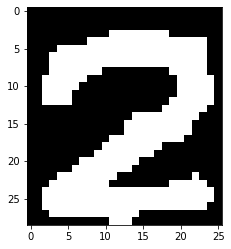

entered if
['9', '1', '2', 'W', 'D']
2
saved an img 2
102 134
[  2  23  33  56  67  91 102 134 138 159]


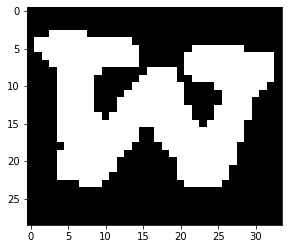

entered if
['9', '1', '2', 'W', 'D']
W
saved an img W
138 159
[  2  23  33  56  67  91 102 134 138 159]


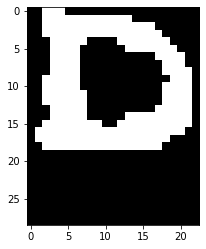

entered if
['9', '1', '2', 'W', 'D']
D
saved an img D
['9', '4', 'Q', 'A', 'B']
3 24
[  3  24  33  54  69  99 100 135 137 161]


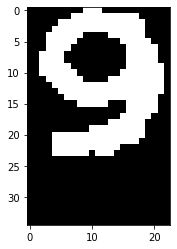

entered if
['9', '4', 'Q', 'A', 'B']
9
saved an img 9
33 54
[  3  24  33  54  69  99 100 135 137 161]


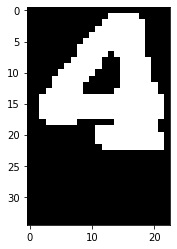

entered if
['9', '4', 'Q', 'A', 'B']
4
saved an img 4
69 99
[  3  24  33  54  69  99 100 135 137 161]


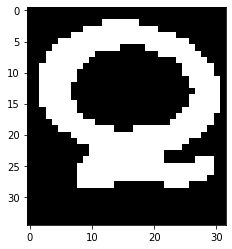

entered if
['9', '4', 'Q', 'A', 'B']
Q
saved an img Q
100 135
[  3  24  33  54  69  99 100 135 137 161]


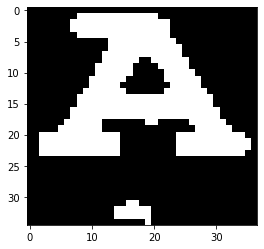

entered if
['9', '4', 'Q', 'A', 'B']
A
saved an img A
137 161
[  3  24  33  54  69  99 100 135 137 161]


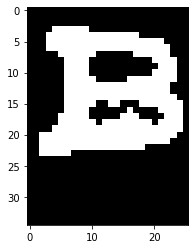

entered if
['9', '4', 'Q', 'A', 'B']
B
saved an img B
['9', 'H', '2', 'P', 'W']
2 22
[  2  22  28  58  69  94 106 131 132 159]


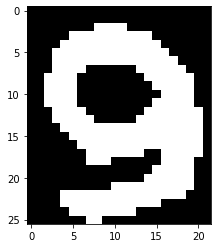

entered if
['9', 'H', '2', 'P', 'W']
9
saved an img 9
28 58
[  2  22  28  58  69  94 106 131 132 159]


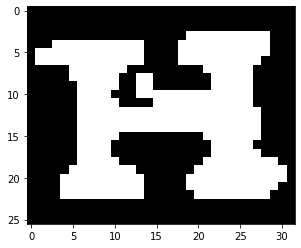

entered if
['9', 'H', '2', 'P', 'W']
H
saved an img H
69 94
[  2  22  28  58  69  94 106 131 132 159]


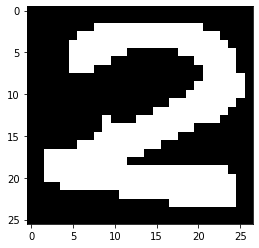

entered if
['9', 'H', '2', 'P', 'W']
2
saved an img 2
106 131
[  2  22  28  58  69  94 106 131 132 159]


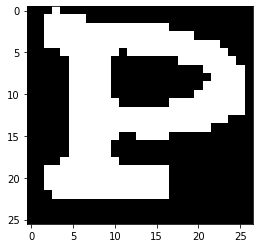

entered if
['9', 'H', '2', 'P', 'W']
P
saved an img P
132 159
[  2  22  28  58  69  94 106 131 132 159]


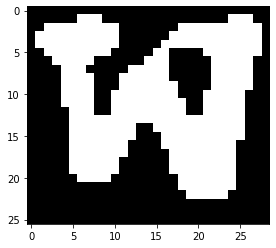

entered if
['9', 'H', '2', 'P', 'W']
W
saved an img W
['9', 'I', 'F', 'K', '1']
1 20
[  1  20  34  58  66  96  99 132 138 156]


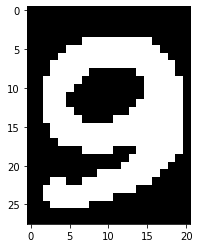

entered if
['9', 'I', 'F', 'K', '1']
9
saved an img 9
34 58
[  1  20  34  58  66  96  99 132 138 156]


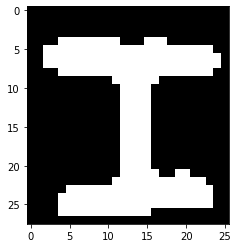

entered if
['9', 'I', 'F', 'K', '1']
I
saved an img I
66 96
[  1  20  34  58  66  96  99 132 138 156]


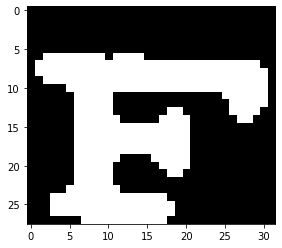

entered if
['9', 'I', 'F', 'K', '1']
F
saved an img F
99 132
[  1  20  34  58  66  96  99 132 138 156]


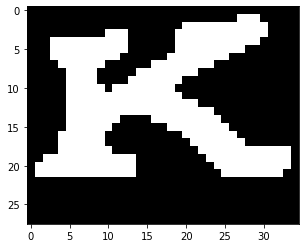

entered if
['9', 'I', 'F', 'K', '1']
K
saved an img K
138 156
[  1  20  34  58  66  96  99 132 138 156]


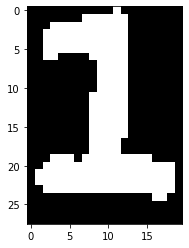

entered if
['9', 'I', 'F', 'K', '1']
1
saved an img 1
['9', 'J', 'U', 'S', 'K']
3 4
[  3   4  25  30  60  65  95 102 129 136 161]


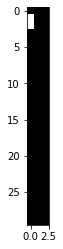

entered if
['9', 'J', 'U', 'S', 'K']
9
saved an img 9
25 30
[  3   4  25  30  60  65  95 102 129 136 161]


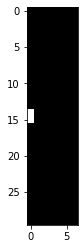

entered if
['9', 'J', 'U', 'S', 'K']
J
saved an img J
60 65
[  3   4  25  30  60  65  95 102 129 136 161]


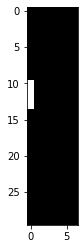

entered if
['9', 'J', 'U', 'S', 'K']
U
saved an img U
95 102
[  3   4  25  30  60  65  95 102 129 136 161]


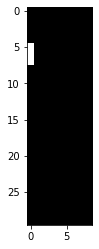

entered if
['9', 'J', 'U', 'S', 'K']
S
saved an img S
129 136
[  3   4  25  30  60  65  95 102 129 136 161]


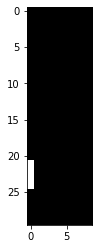

entered if
['9', 'J', 'U', 'S', 'K']
K
saved an img K
['9', 'M', 'L', '3', 'Z']
2 60
[  2  60  69  99 107 134 136 158]


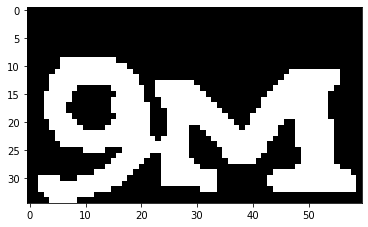

entered if
['9', 'M', 'L', '3', 'Z']
9
saved an img 9
69 99
[  2  60  69  99 107 134 136 158]


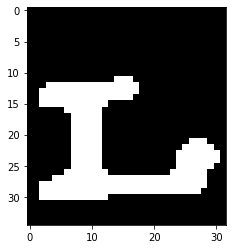

entered if
['9', 'M', 'L', '3', 'Z']
M
saved an img M
107 134
[  2  60  69  99 107 134 136 158]


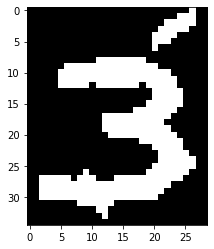

entered if
['9', 'M', 'L', '3', 'Z']
L
saved an img L
136 158
[  2  60  69  99 107 134 136 158]


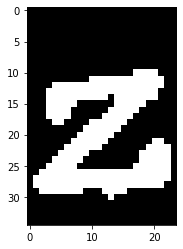

entered if
['9', 'M', 'L', '3', 'Z']
3
saved an img 3
['9', 'O', '6', 'D', 'V']
3 4
[  3   4  29  30  97 105 131 137 160]


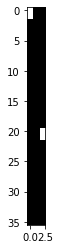

entered if
['9', 'O', '6', 'D', 'V']
9
saved an img 9
29 30
[  3   4  29  30  97 105 131 137 160]


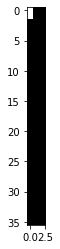

entered if
['9', 'O', '6', 'D', 'V']
O
saved an img O
97 105
[  3   4  29  30  97 105 131 137 160]


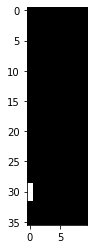

entered if
['9', 'O', '6', 'D', 'V']
6
saved an img 6
131 137
[  3   4  29  30  97 105 131 137 160]


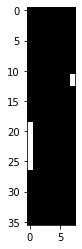

entered if
['9', 'O', '6', 'D', 'V']
D
saved an img D
['9', 'R', 'L', 'J', 'L']
4 24
[  4  24  30  60  70  98 103 131 138 158]


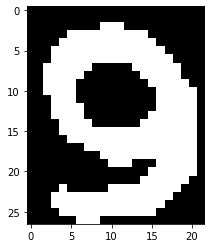

entered if
['9', 'R', 'L', 'J', 'L']
9
saved an img 9
30 60
[  4  24  30  60  70  98 103 131 138 158]


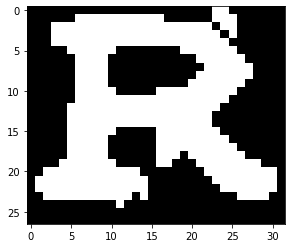

entered if
['9', 'R', 'L', 'J', 'L']
R
saved an img R
70 98
[  4  24  30  60  70  98 103 131 138 158]


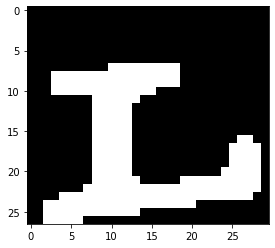

entered if
['9', 'R', 'L', 'J', 'L']
L
saved an img L
103 131
[  4  24  30  60  70  98 103 131 138 158]


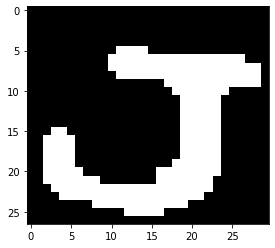

entered if
['9', 'R', 'L', 'J', 'L']
J
saved an img J
138 158
[  4  24  30  60  70  98 103 131 138 158]


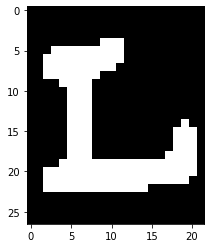

entered if
['9', 'R', 'L', 'J', 'L']
L
saved an img L
['9', 'V', 'N', 'J', '8']
5 23
[  5  23  27  62  68  97 103 135 139 158]


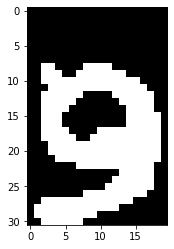

entered if
['9', 'V', 'N', 'J', '8']
9
saved an img 9
27 62
[  5  23  27  62  68  97 103 135 139 158]


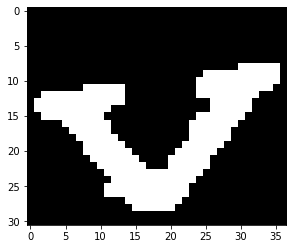

entered if
['9', 'V', 'N', 'J', '8']
V
saved an img V
68 97
[  5  23  27  62  68  97 103 135 139 158]


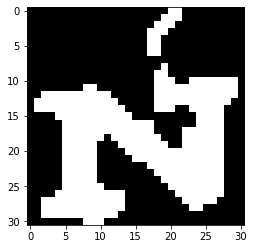

entered if
['9', 'V', 'N', 'J', '8']
N
saved an img N
103 135
[  5  23  27  62  68  97 103 135 139 158]


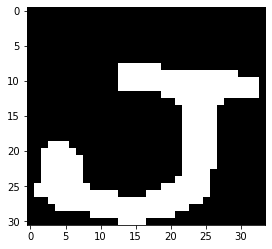

entered if
['9', 'V', 'N', 'J', '8']
J
saved an img J
139 158
[  5  23  27  62  68  97 103 135 139 158]


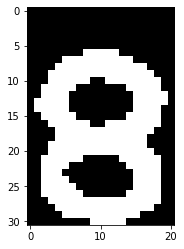

entered if
['9', 'V', 'N', 'J', '8']
8
saved an img 8
['9', 'W', 'Y', '7', 'Y']
1 24
[  1  24  29  62  68  96 101 126 136 159]


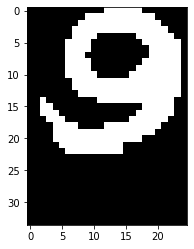

entered if
['9', 'W', 'Y', '7', 'Y']
9
saved an img 9
29 62
[  1  24  29  62  68  96 101 126 136 159]


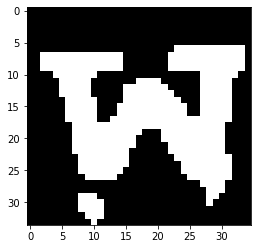

entered if
['9', 'W', 'Y', '7', 'Y']
W
saved an img W
68 96
[  1  24  29  62  68  96 101 126 136 159]


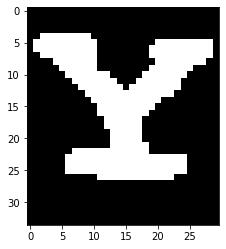

entered if
['9', 'W', 'Y', '7', 'Y']
Y
saved an img Y
101 126
[  1  24  29  62  68  96 101 126 136 159]


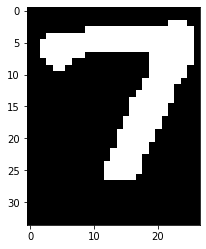

entered if
['9', 'W', 'Y', '7', 'Y']
7
saved an img 7
136 159
[  1  24  29  62  68  96 101 126 136 159]


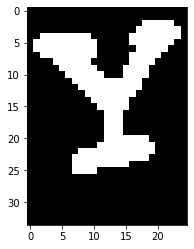

entered if
['9', 'W', 'Y', '7', 'Y']
Y
saved an img Y
['9', 'Y', 'O', 'K', 'E']
0 6
[  0   6  26  32  56  69  93 104 134 137 160]


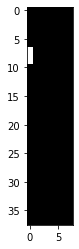

entered if
['9', 'Y', 'O', 'K', 'E']
9
saved an img 9
26 32
[  0   6  26  32  56  69  93 104 134 137 160]


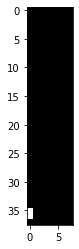

entered if
['9', 'Y', 'O', 'K', 'E']
Y
saved an img Y
56 69
[  0   6  26  32  56  69  93 104 134 137 160]


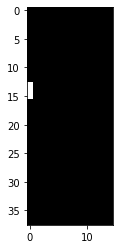

entered if
['9', 'Y', 'O', 'K', 'E']
O
saved an img O
93 104
[  0   6  26  32  56  69  93 104 134 137 160]


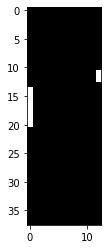

entered if
['9', 'Y', 'O', 'K', 'E']
K
saved an img K
134 137
[  0   6  26  32  56  69  93 104 134 137 160]


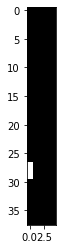

entered if
['9', 'Y', 'O', 'K', 'E']
E
saved an img E
['A', '7', 'E', 'U', '4']
27 31
[ 27  31  54  65  93 103 134 140 155]


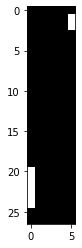

entered if
['A', '7', 'E', 'U', '4']
A
saved an img A
54 65
[ 27  31  54  65  93 103 134 140 155]


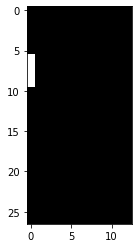

entered if
['A', '7', 'E', 'U', '4']
7
saved an img 7
93 103
[ 27  31  54  65  93 103 134 140 155]


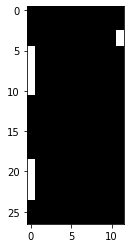

entered if
['A', '7', 'E', 'U', '4']
E
saved an img E
134 140
[ 27  31  54  65  93 103 134 140 155]


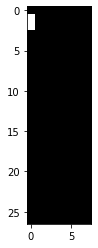

entered if
['A', '7', 'E', 'U', '4']
U
saved an img U
['A', '8', '7', '8', 'V']
25 35
[ 25  35  59  69  93 108 159]


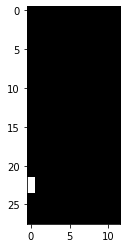

entered if
['A', '8', '7', '8', 'V']
A
saved an img A
59 69
[ 25  35  59  69  93 108 159]


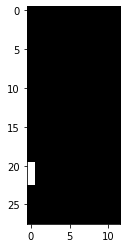

entered if
['A', '8', '7', '8', 'V']
8
saved an img 8
93 108
[ 25  35  59  69  93 108 159]


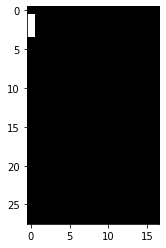

entered if
['A', '8', '7', '8', 'V']
7
saved an img 7
['A', 'B', 'J', 'M', 'O']
61 65
[ 61  65 131 138 163]


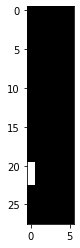

entered if
['A', 'B', 'J', 'M', 'O']
A
saved an img A
131 138
[ 61  65 131 138 163]


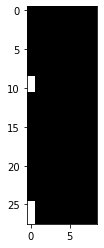

entered if
['A', 'B', 'J', 'M', 'O']
B
saved an img B
['A', 'H', 'E', 'Y', 'Q']
0 56
[  0  56  64  95 102 162]


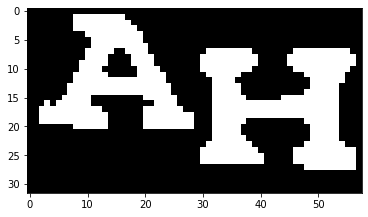

entered if
['A', 'H', 'E', 'Y', 'Q']
A
saved an img A
64 95
[  0  56  64  95 102 162]


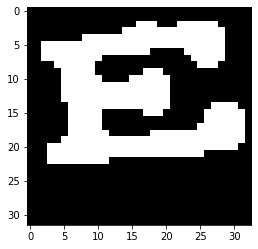

entered if
['A', 'H', 'E', 'Y', 'Q']
H
saved an img H
102 162
[  0  56  64  95 102 162]


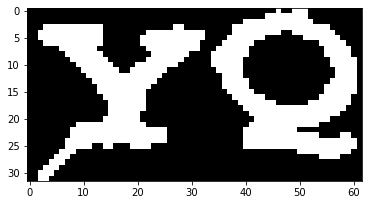

entered if
['A', 'H', 'E', 'Y', 'Q']
E
saved an img E
['A', 'S', '2', 'U', 'S']
0 27
[  0  27  34  59  68 131 136 163]


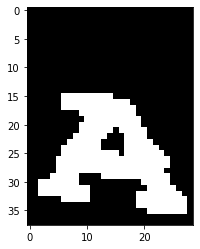

entered if
['A', 'S', '2', 'U', 'S']
A
saved an img A
34 59
[  0  27  34  59  68 131 136 163]


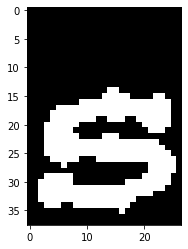

entered if
['A', 'S', '2', 'U', 'S']
S
saved an img S
68 131
[  0  27  34  59  68 131 136 163]


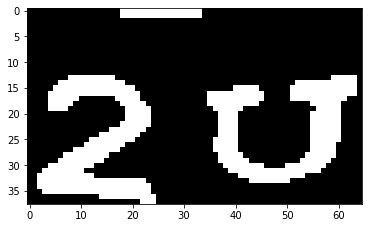

entered if
['A', 'S', '2', 'U', 'S']
2
saved an img 2
136 163
[  0  27  34  59  68 131 136 163]


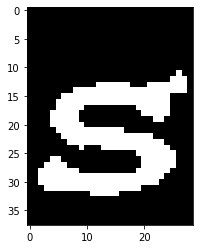

entered if
['A', 'S', '2', 'U', 'S']
U
saved an img U
['A', 'Y', 'L', 'R', 'O']
1 27
[  1  27  33  62  68  96 101 132 135 162]


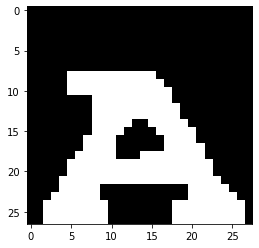

entered if
['A', 'Y', 'L', 'R', 'O']
A
saved an img A
33 62
[  1  27  33  62  68  96 101 132 135 162]


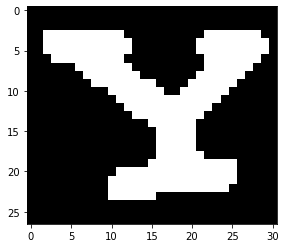

entered if
['A', 'Y', 'L', 'R', 'O']
Y
saved an img Y
68 96
[  1  27  33  62  68  96 101 132 135 162]


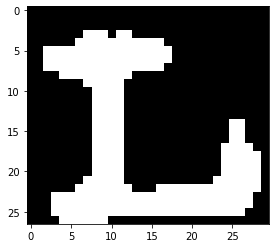

entered if
['A', 'Y', 'L', 'R', 'O']
L
saved an img L
101 132
[  1  27  33  62  68  96 101 132 135 162]


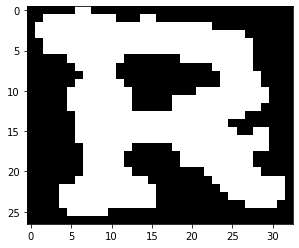

entered if
['A', 'Y', 'L', 'R', 'O']
R
saved an img R
135 162
[  1  27  33  62  68  96 101 132 135 162]


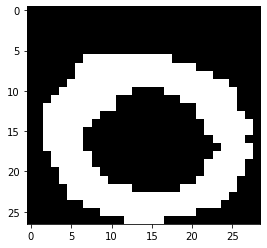

entered if
['A', 'Y', 'L', 'R', 'O']
O
saved an img O
['A', 'Z', 'E', 'R', 'S']
59 62
[ 59  62  92  97 158]


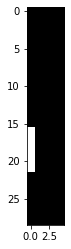

entered if
['A', 'Z', 'E', 'R', 'S']
A
saved an img A
92 97
[ 59  62  92  97 158]


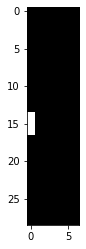

entered if
['A', 'Z', 'E', 'R', 'S']
Z
saved an img Z
['B', '5', 'O', '5', 'Y']
58 66
[ 58  66  95 105 130 138 160]


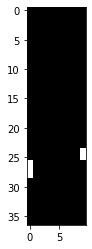

entered if
['B', '5', 'O', '5', 'Y']
B
saved an img B
95 105
[ 58  66  95 105 130 138 160]


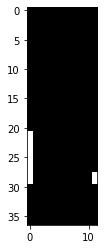

entered if
['B', '5', 'O', '5', 'Y']
5
saved an img 5
130 138
[ 58  66  95 105 130 138 160]


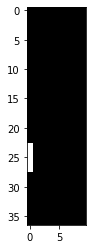

entered if
['B', '5', 'O', '5', 'Y']
O
saved an img O
['B', '6', 'V', 'O', 'N']
1 25
[  1  25  31 130 136 159]


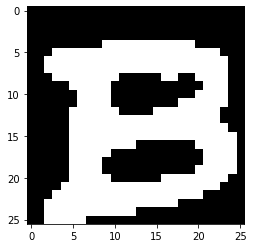

entered if
['B', '6', 'V', 'O', 'N']
B
saved an img B
31 130
[  1  25  31 130 136 159]


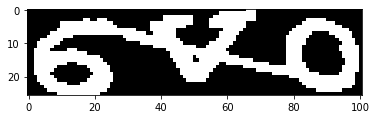

entered if
['B', '6', 'V', 'O', 'N']
6
saved an img 6
136 159
[  1  25  31 130 136 159]


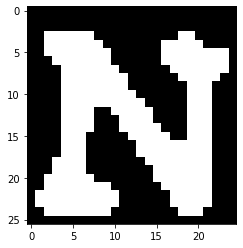

entered if
['B', '6', 'V', 'O', 'N']
V
saved an img V
['B', '9', 'T', 'D', '3']
1 26
[  1  26  35  57  66 126 133 157]


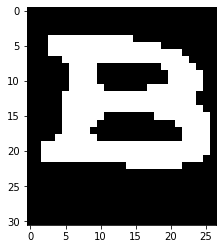

entered if
['B', '9', 'T', 'D', '3']
B
saved an img B
35 57
[  1  26  35  57  66 126 133 157]


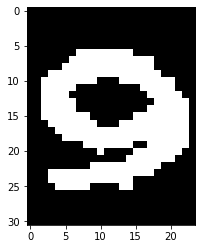

entered if
['B', '9', 'T', 'D', '3']
9
saved an img 9
66 126
[  1  26  35  57  66 126 133 157]


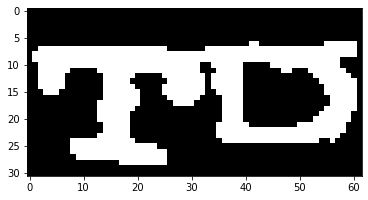

entered if
['B', '9', 'T', 'D', '3']
T
saved an img T
133 157
[  1  26  35  57  66 126 133 157]


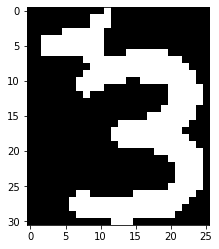

entered if
['B', '9', 'T', 'D', '3']
D
saved an img D
['B', 'E', 'C', '6', '5']
2 26
[  2  26  33  63  65  95 108 133 136 156]


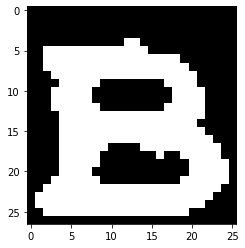

entered if
['B', 'E', 'C', '6', '5']
B
saved an img B
33 63
[  2  26  33  63  65  95 108 133 136 156]


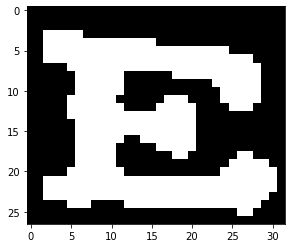

entered if
['B', 'E', 'C', '6', '5']
E
saved an img E
65 95
[  2  26  33  63  65  95 108 133 136 156]


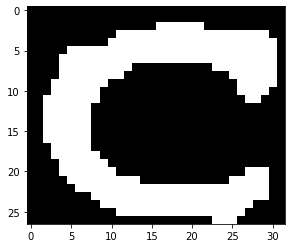

entered if
['B', 'E', 'C', '6', '5']
C
saved an img C
108 133
[  2  26  33  63  65  95 108 133 136 156]


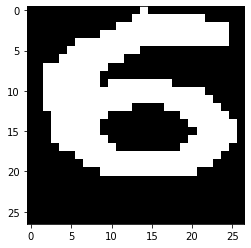

entered if
['B', 'E', 'C', '6', '5']
6
saved an img 6
136 156
[  2  26  33  63  65  95 108 133 136 156]


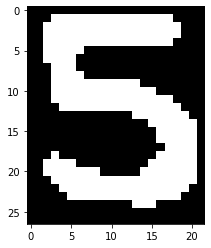

entered if
['B', 'E', 'C', '6', '5']
5
saved an img 5
['B', 'J', 'V', 'F', '0']
26 30
[ 26  30  98 101 134 138 158]


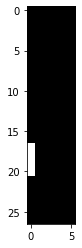

entered if
['B', 'J', 'V', 'F', '0']
B
saved an img B
98 101
[ 26  30  98 101 134 138 158]


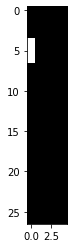

entered if
['B', 'J', 'V', 'F', '0']
J
saved an img J
134 138
[ 26  30  98 101 134 138 158]


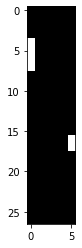

entered if
['B', 'J', 'V', 'F', '0']
V
saved an img V
['B', 'Q', 'T', 'I', 'U']
28 32
[ 28  32  63  64  93 103 128 139 160]


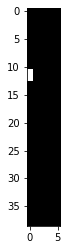

entered if
['B', 'Q', 'T', 'I', 'U']
B
saved an img B
63 64
[ 28  32  63  64  93 103 128 139 160]


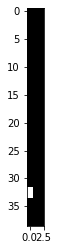

entered if
['B', 'Q', 'T', 'I', 'U']
Q
saved an img Q
93 103
[ 28  32  63  64  93 103 128 139 160]


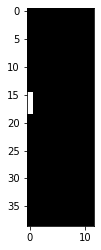

entered if
['B', 'Q', 'T', 'I', 'U']
T
saved an img T
128 139
[ 28  32  63  64  93 103 128 139 160]


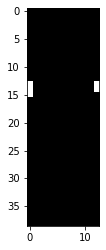

entered if
['B', 'Q', 'T', 'I', 'U']
I
saved an img I
['B', 'X', 'J', '4', 'V']
0 24
[  0  24  29  60  66  97 104 128 134 163]


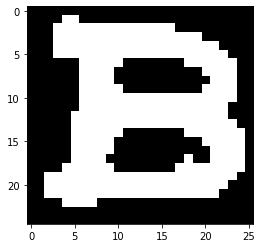

entered if
['B', 'X', 'J', '4', 'V']
B
saved an img B
29 60
[  0  24  29  60  66  97 104 128 134 163]


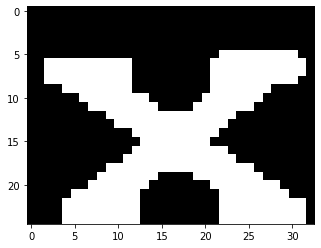

entered if
['B', 'X', 'J', '4', 'V']
X
saved an img X
66 97
[  0  24  29  60  66  97 104 128 134 163]


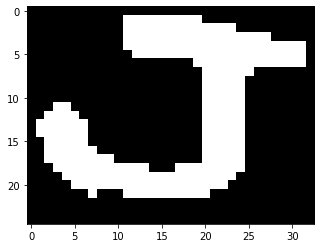

entered if
['B', 'X', 'J', '4', 'V']
J
saved an img J
104 128
[  0  24  29  60  66  97 104 128 134 163]


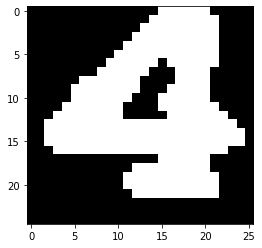

entered if
['B', 'X', 'J', '4', 'V']
4
saved an img 4
134 163
[  0  24  29  60  66  97 104 128 134 163]


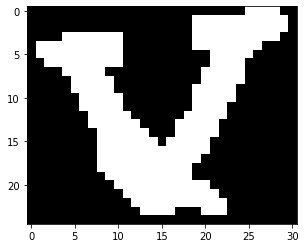

entered if
['B', 'X', 'J', '4', 'V']
V
saved an img V
['B', 'Z', 'D', 'W', 'Z']
1 25
[  1  25  33  57  65  96  99 133 134 156]


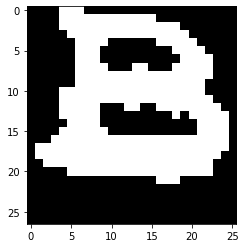

entered if
['B', 'Z', 'D', 'W', 'Z']
B
saved an img B
33 57
[  1  25  33  57  65  96  99 133 134 156]


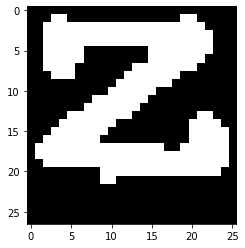

entered if
['B', 'Z', 'D', 'W', 'Z']
Z
saved an img Z
65 96
[  1  25  33  57  65  96  99 133 134 156]


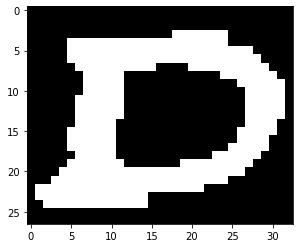

entered if
['B', 'Z', 'D', 'W', 'Z']
D
saved an img D
99 133
[  1  25  33  57  65  96  99 133 134 156]


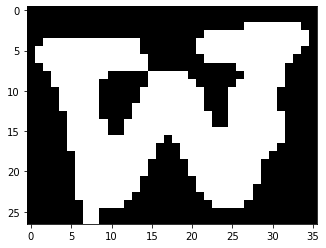

entered if
['B', 'Z', 'D', 'W', 'Z']
W
saved an img W
134 156
[  1  25  33  57  65  96  99 133 134 156]


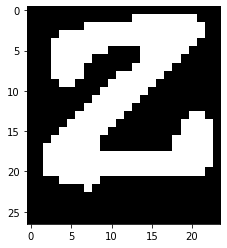

entered if
['B', 'Z', 'D', 'W', 'Z']
Z
saved an img Z
['C', '2', 'L', '2', '1']
26 28
[ 26  28  99 107 132 140 158]


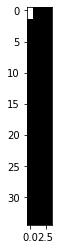

entered if
['C', '2', 'L', '2', '1']
C
saved an img C
99 107
[ 26  28  99 107 132 140 158]


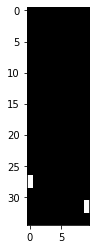

entered if
['C', '2', 'L', '2', '1']
2
saved an img 2
132 140
[ 26  28  99 107 132 140 158]


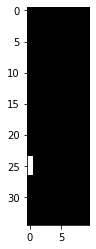

entered if
['C', '2', 'L', '2', '1']
L
saved an img L
['C', '6', '7', 'U', 'F']
24 33
[ 24  33  56  68  93 105 163]


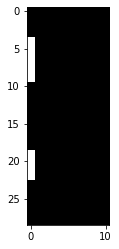

entered if
['C', '6', '7', 'U', 'F']
C
saved an img C
56 68
[ 24  33  56  68  93 105 163]


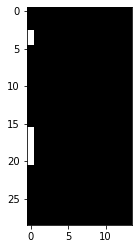

entered if
['C', '6', '7', 'U', 'F']
6
saved an img 6
93 105
[ 24  33  56  68  93 105 163]


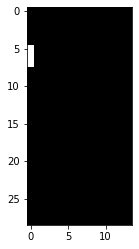

entered if
['C', '6', '7', 'U', 'F']
7
saved an img 7
['C', 'A', '5', 'Z', 'Y']
62 71
[ 62  71  95 107 132 138 162]


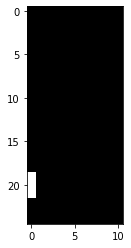

entered if
['C', 'A', '5', 'Z', 'Y']
C
saved an img C
95 107
[ 62  71  95 107 132 138 162]


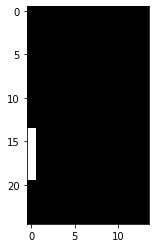

entered if
['C', 'A', '5', 'Z', 'Y']
A
saved an img A
132 138
[ 62  71  95 107 132 138 162]


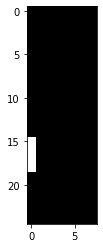

entered if
['C', 'A', '5', 'Z', 'Y']
5
saved an img 5
['C', 'F', 'Q', 'N', 'U']
22 32
[ 22  32  62  63  97 100 134 136 162]


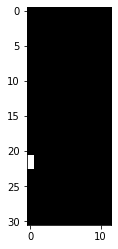

entered if
['C', 'F', 'Q', 'N', 'U']
C
saved an img C
62 63
[ 22  32  62  63  97 100 134 136 162]


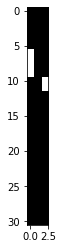

entered if
['C', 'F', 'Q', 'N', 'U']
F
saved an img F
97 100
[ 22  32  62  63  97 100 134 136 162]


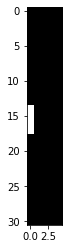

entered if
['C', 'F', 'Q', 'N', 'U']
Q
saved an img Q
134 136
[ 22  32  62  63  97 100 134 136 162]


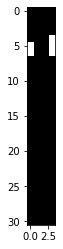

entered if
['C', 'F', 'Q', 'N', 'U']
N
saved an img N
['C', 'H', '0', '6', 'G']
3 26
[  3  26  29  58  70  96 102 128 134 160]


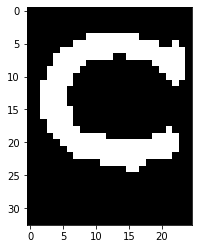

entered if
['C', 'H', '0', '6', 'G']
C
saved an img C
29 58
[  3  26  29  58  70  96 102 128 134 160]


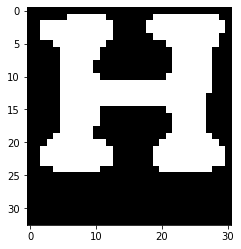

entered if
['C', 'H', '0', '6', 'G']
H
saved an img H
70 96
[  3  26  29  58  70  96 102 128 134 160]


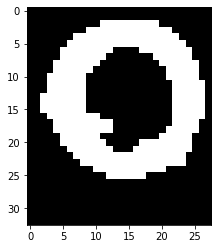

entered if
['C', 'H', '0', '6', 'G']
0
saved an img 0
102 128
[  3  26  29  58  70  96 102 128 134 160]


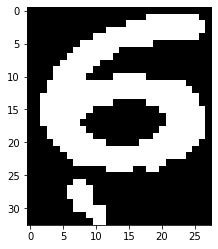

entered if
['C', 'H', '0', '6', 'G']
6
saved an img 6
134 160
[  3  26  29  58  70  96 102 128 134 160]


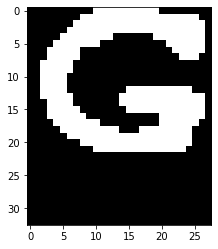

entered if
['C', 'H', '0', '6', 'G']
G
saved an img G
['C', 'H', 'I', 'H', 'M']
0 24
[  0  24  28  60  71  92 105 132 133 161]


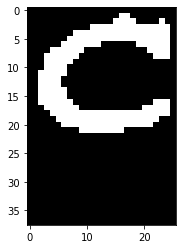

entered if
['C', 'H', 'I', 'H', 'M']
C
saved an img C
28 60
[  0  24  28  60  71  92 105 132 133 161]


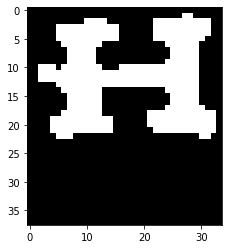

entered if
['C', 'H', 'I', 'H', 'M']
H
saved an img H
71 92
[  0  24  28  60  71  92 105 132 133 161]


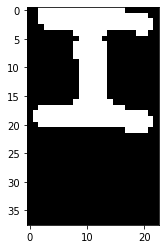

entered if
['C', 'H', 'I', 'H', 'M']
I
saved an img I
105 132
[  0  24  28  60  71  92 105 132 133 161]


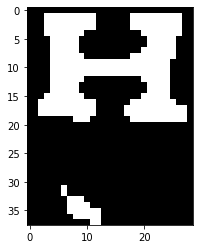

entered if
['C', 'H', 'I', 'H', 'M']
H
saved an img H
133 161
[  0  24  28  60  71  92 105 132 133 161]


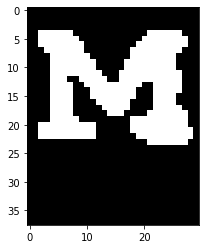

entered if
['C', 'H', 'I', 'H', 'M']
M
saved an img M
['C', 'N', 'D', '2', '0']
23 26
[ 23  26  61  64  95 105 129 140 161]


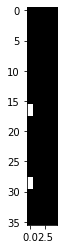

entered if
['C', 'N', 'D', '2', '0']
C
saved an img C
61 64
[ 23  26  61  64  95 105 129 140 161]


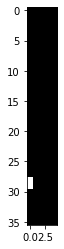

entered if
['C', 'N', 'D', '2', '0']
N
saved an img N
95 105
[ 23  26  61  64  95 105 129 140 161]


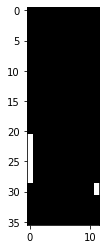

entered if
['C', 'N', 'D', '2', '0']
D
saved an img D
129 140
[ 23  26  61  64  95 105 129 140 161]


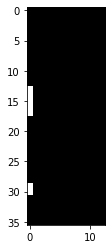

entered if
['C', 'N', 'D', '2', '0']
2
saved an img 2
['C', 'O', 'T', 'O', '1']
4 5
[  4   5  28  32  57  67  95 104 128 139 157]


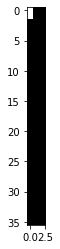

entered if
['C', 'O', 'T', 'O', '1']
C
saved an img C
28 32
[  4   5  28  32  57  67  95 104 128 139 157]


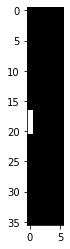

entered if
['C', 'O', 'T', 'O', '1']
O
saved an img O
57 67
[  4   5  28  32  57  67  95 104 128 139 157]


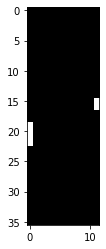

entered if
['C', 'O', 'T', 'O', '1']
T
saved an img T
95 104
[  4   5  28  32  57  67  95 104 128 139 157]


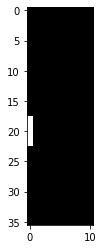

entered if
['C', 'O', 'T', 'O', '1']
O
saved an img O
128 139
[  4   5  28  32  57  67  95 104 128 139 157]


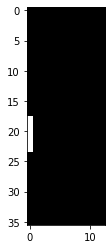

entered if
['C', 'O', 'T', 'O', '1']
1
saved an img 1
['C', 'V', 'T', 'E', '2']
0 26
[  0  26  27  62  63  92 104 131]


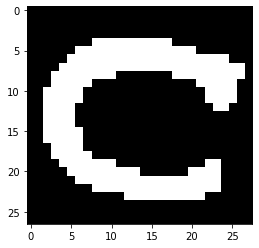

entered if
['C', 'V', 'T', 'E', '2']
C
saved an img C
27 62
[  0  26  27  62  63  92 104 131]


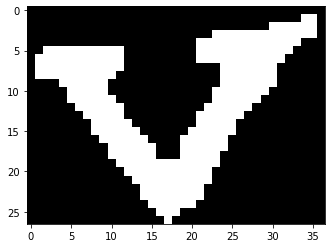

entered if
['C', 'V', 'T', 'E', '2']
V
saved an img V
63 92
[  0  26  27  62  63  92 104 131]


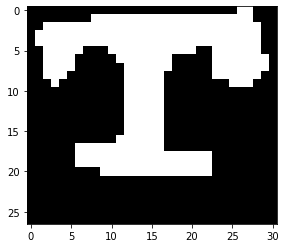

entered if
['C', 'V', 'T', 'E', '2']
T
saved an img T
104 131
[  0  26  27  62  63  92 104 131]


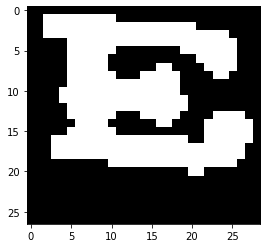

entered if
['C', 'V', 'T', 'E', '2']
E
saved an img E
['D', '0', 'Q', 'R', '1']
4 26
[  4  26  33  58  68  99 102 136 139 159]


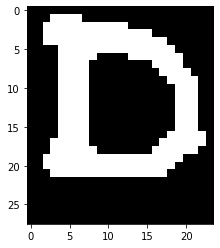

entered if
['D', '0', 'Q', 'R', '1']
D
saved an img D
33 58
[  4  26  33  58  68  99 102 136 139 159]


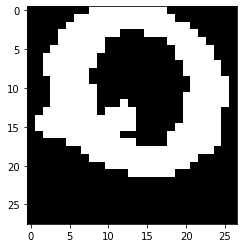

entered if
['D', '0', 'Q', 'R', '1']
0
saved an img 0
68 99
[  4  26  33  58  68  99 102 136 139 159]


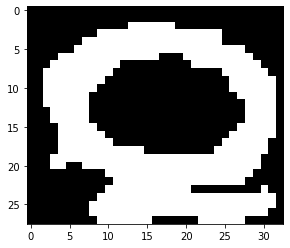

entered if
['D', '0', 'Q', 'R', '1']
Q
saved an img Q
102 136
[  4  26  33  58  68  99 102 136 139 159]


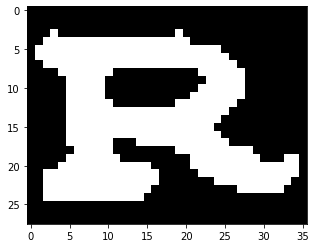

entered if
['D', '0', 'Q', 'R', '1']
R
saved an img R
139 159
[  4  26  33  58  68  99 102 136 139 159]


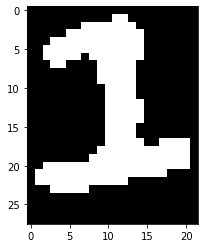

entered if
['D', '0', 'Q', 'R', '1']
1
saved an img 1
['D', '3', 'K', 'B', '9']
24 28
[ 24  28  58  66 130 142 160]


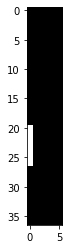

entered if
['D', '3', 'K', 'B', '9']
D
saved an img D
58 66
[ 24  28  58  66 130 142 160]


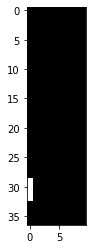

entered if
['D', '3', 'K', 'B', '9']
3
saved an img 3
130 142
[ 24  28  58  66 130 142 160]


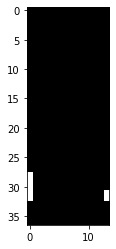

entered if
['D', '3', 'K', 'B', '9']
K
saved an img K
['D', '3', 'K', 'R', '9']
22 33
[ 22  33  56  65  95 103 133 140 159]


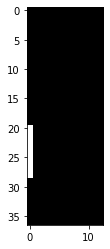

entered if
['D', '3', 'K', 'R', '9']
D
saved an img D
56 65
[ 22  33  56  65  95 103 133 140 159]


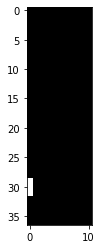

entered if
['D', '3', 'K', 'R', '9']
3
saved an img 3
95 103
[ 22  33  56  65  95 103 133 140 159]


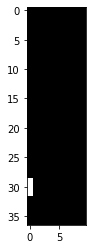

entered if
['D', '3', 'K', 'R', '9']
K
saved an img K
133 140
[ 22  33  56  65  95 103 133 140 159]


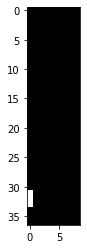

entered if
['D', '3', 'K', 'R', '9']
R
saved an img R
['D', '5', 'L', '3', 'N']
0 24
[  0  24  34  61  67  96 102 128 135 161]


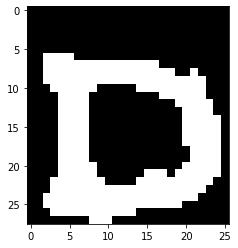

entered if
['D', '5', 'L', '3', 'N']
D
saved an img D
34 61
[  0  24  34  61  67  96 102 128 135 161]


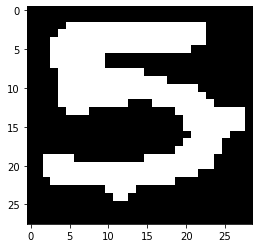

entered if
['D', '5', 'L', '3', 'N']
5
saved an img 5
67 96
[  0  24  34  61  67  96 102 128 135 161]


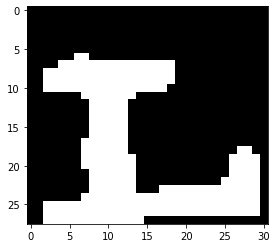

entered if
['D', '5', 'L', '3', 'N']
L
saved an img L
102 128
[  0  24  34  61  67  96 102 128 135 161]


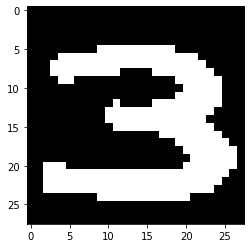

entered if
['D', '5', 'L', '3', 'N']
3
saved an img 3
135 161
[  0  24  34  61  67  96 102 128 135 161]


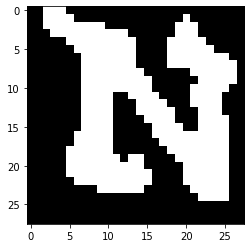

entered if
['D', '5', 'L', '3', 'N']
N
saved an img N
['D', '7', 'P', '8', 'E']
1 29
[  1  29  34  60  64  93 108 132 136 164]


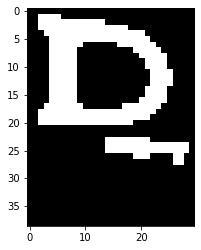

entered if
['D', '7', 'P', '8', 'E']
D
saved an img D
34 60
[  1  29  34  60  64  93 108 132 136 164]


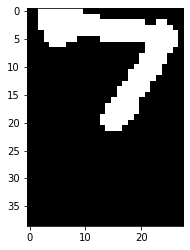

entered if
['D', '7', 'P', '8', 'E']
7
saved an img 7
64 93
[  1  29  34  60  64  93 108 132 136 164]


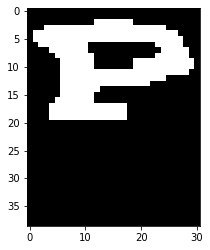

entered if
['D', '7', 'P', '8', 'E']
P
saved an img P
108 132
[  1  29  34  60  64  93 108 132 136 164]


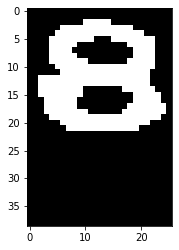

entered if
['D', '7', 'P', '8', 'E']
8
saved an img 8
136 164
[  1  29  34  60  64  93 108 132 136 164]


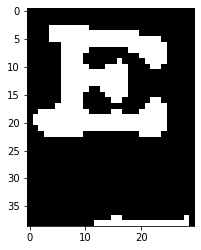

entered if
['D', '7', 'P', '8', 'E']
E
saved an img E
['D', '8', 'S', '3', 'M']
1 23
[  1  23  33  58  67  95 103 127 134 161]


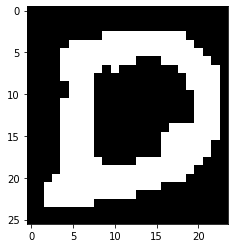

entered if
['D', '8', 'S', '3', 'M']
D
saved an img D
33 58
[  1  23  33  58  67  95 103 127 134 161]


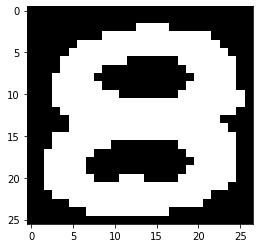

entered if
['D', '8', 'S', '3', 'M']
8
saved an img 8
67 95
[  1  23  33  58  67  95 103 127 134 161]


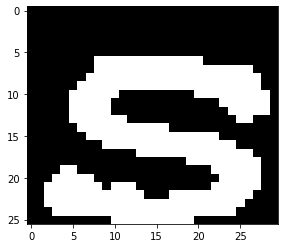

entered if
['D', '8', 'S', '3', 'M']
S
saved an img S
103 127
[  1  23  33  58  67  95 103 127 134 161]


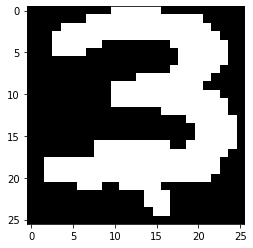

entered if
['D', '8', 'S', '3', 'M']
3
saved an img 3
134 161
[  1  23  33  58  67  95 103 127 134 161]


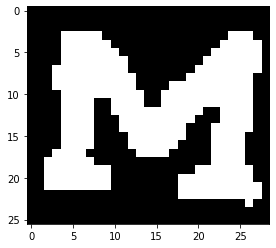

entered if
['D', '8', 'S', '3', 'M']
M
saved an img M
['D', 'D', 'R', 'O', '6']
2 27
[  2  27  32  61  63  95 107 131 138 159]


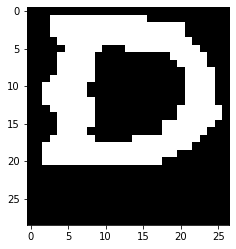

entered if
['D', 'D', 'R', 'O', '6']
D
saved an img D
32 61
[  2  27  32  61  63  95 107 131 138 159]


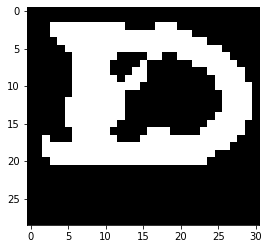

entered if
['D', 'D', 'R', 'O', '6']
D
saved an img D
63 95
[  2  27  32  61  63  95 107 131 138 159]


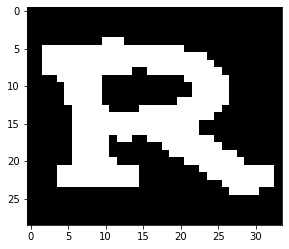

entered if
['D', 'D', 'R', 'O', '6']
R
saved an img R
107 131
[  2  27  32  61  63  95 107 131 138 159]


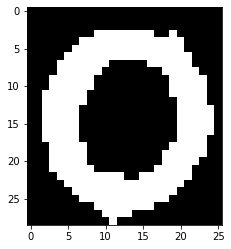

entered if
['D', 'D', 'R', 'O', '6']
O
saved an img O
138 159
[  2  27  32  61  63  95 107 131 138 159]


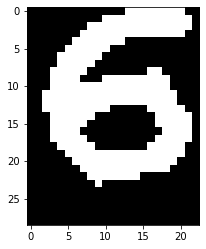

entered if
['D', 'D', 'R', 'O', '6']
6
saved an img 6
['D', 'E', 'D', 'O', 'O']
1 23
[  1  23  30  58  65  96 103 132 134 160]


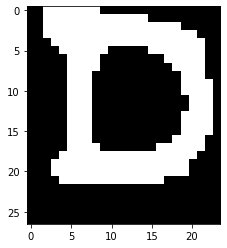

entered if
['D', 'E', 'D', 'O', 'O']
D
saved an img D
30 58
[  1  23  30  58  65  96 103 132 134 160]


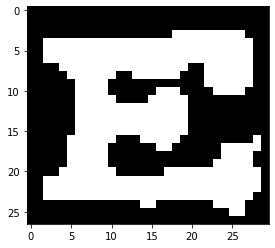

entered if
['D', 'E', 'D', 'O', 'O']
E
saved an img E
65 96
[  1  23  30  58  65  96 103 132 134 160]


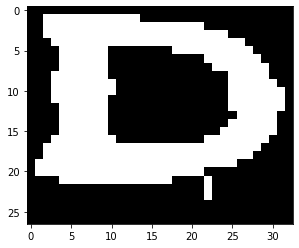

entered if
['D', 'E', 'D', 'O', 'O']
D
saved an img D
103 132
[  1  23  30  58  65  96 103 132 134 160]


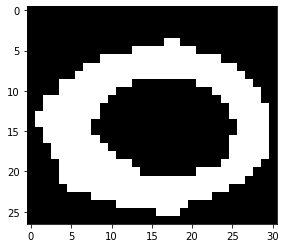

entered if
['D', 'E', 'D', 'O', 'O']
O
saved an img O
134 160
[  1  23  30  58  65  96 103 132 134 160]


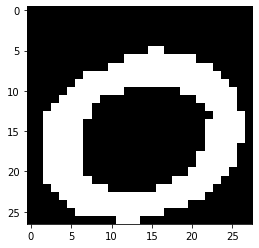

entered if
['D', 'E', 'D', 'O', 'O']
O
saved an img O
['D', 'F', 'I', 'M', '7']
1 25
[  1  25  31  61  67  94 103 135 139 160]


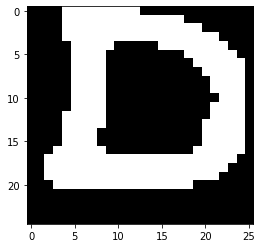

entered if
['D', 'F', 'I', 'M', '7']
D
saved an img D
31 61
[  1  25  31  61  67  94 103 135 139 160]


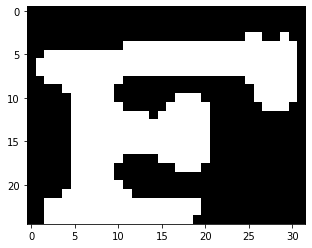

entered if
['D', 'F', 'I', 'M', '7']
F
saved an img F
67 94
[  1  25  31  61  67  94 103 135 139 160]


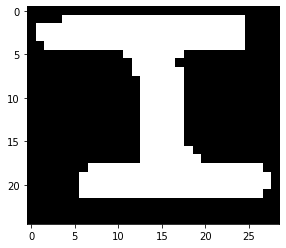

entered if
['D', 'F', 'I', 'M', '7']
I
saved an img I
103 135
[  1  25  31  61  67  94 103 135 139 160]


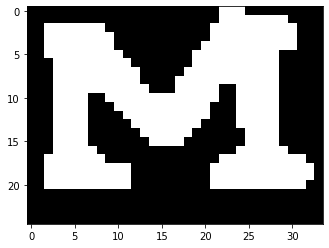

entered if
['D', 'F', 'I', 'M', '7']
M
saved an img M
139 160
[  1  25  31  61  67  94 103 135 139 160]


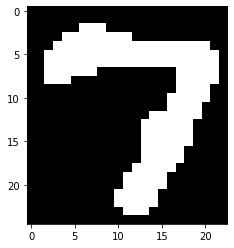

entered if
['D', 'F', 'I', 'M', '7']
7
saved an img 7
['D', 'H', '8', 'U', '5']
1 24
[  1  24  32  62  73  94 103 133 138 158]


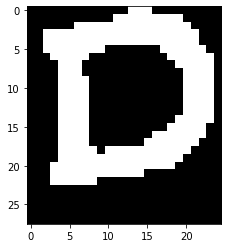

entered if
['D', 'H', '8', 'U', '5']
D
saved an img D
32 62
[  1  24  32  62  73  94 103 133 138 158]


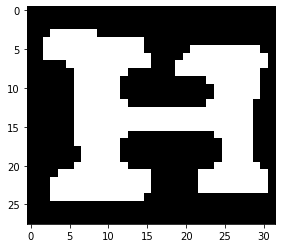

entered if
['D', 'H', '8', 'U', '5']
H
saved an img H
73 94
[  1  24  32  62  73  94 103 133 138 158]


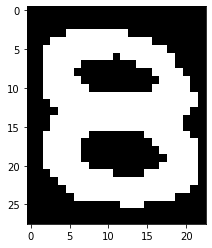

entered if
['D', 'H', '8', 'U', '5']
8
saved an img 8
103 133
[  1  24  32  62  73  94 103 133 138 158]


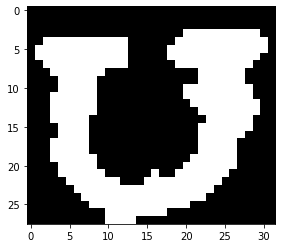

entered if
['D', 'H', '8', 'U', '5']
U
saved an img U
138 158
[  1  24  32  62  73  94 103 133 138 158]


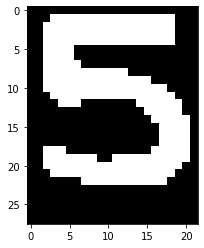

entered if
['D', 'H', '8', 'U', '5']
5
saved an img 5
['D', 'H', 'G', '4', '6']
95 103
[ 95 103 124 141 158]


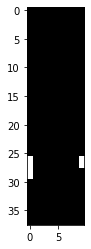

entered if
['D', 'H', 'G', '4', '6']
D
saved an img D
124 141
[ 95 103 124 141 158]


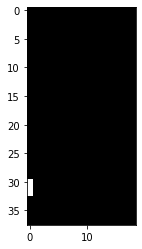

entered if
['D', 'H', 'G', '4', '6']
H
saved an img H
['D', 'H', 'K', 'W', '6']
1 26
[  1  26  32  60  66  99 101 130 138 157]


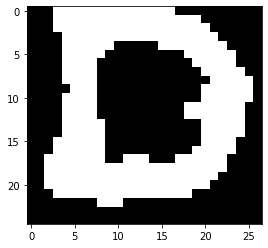

entered if
['D', 'H', 'K', 'W', '6']
D
saved an img D
32 60
[  1  26  32  60  66  99 101 130 138 157]


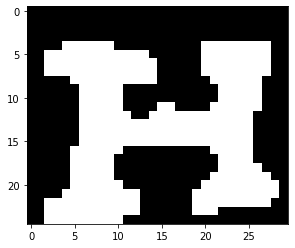

entered if
['D', 'H', 'K', 'W', '6']
H
saved an img H
66 99
[  1  26  32  60  66  99 101 130 138 157]


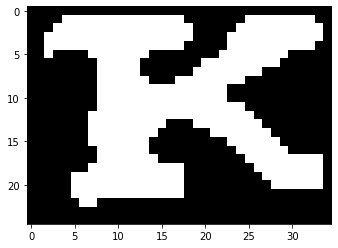

entered if
['D', 'H', 'K', 'W', '6']
K
saved an img K
101 130
[  1  26  32  60  66  99 101 130 138 157]


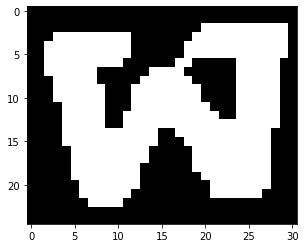

entered if
['D', 'H', 'K', 'W', '6']
W
saved an img W
138 157
[  1  26  32  60  66  99 101 130 138 157]


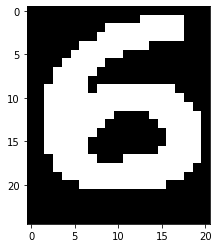

entered if
['D', 'H', 'K', 'W', '6']
6
saved an img 6
['D', 'K', 'B', 'I', 'U']
24 28
[ 24  28  60  67  96 106 130 134 160]


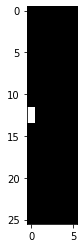

entered if
['D', 'K', 'B', 'I', 'U']
D
saved an img D
60 67
[ 24  28  60  67  96 106 130 134 160]


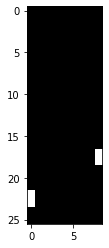

entered if
['D', 'K', 'B', 'I', 'U']
K
saved an img K
96 106
[ 24  28  60  67  96 106 130 134 160]


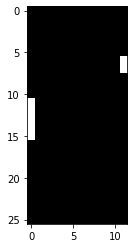

entered if
['D', 'K', 'B', 'I', 'U']
B
saved an img B
130 134
[ 24  28  60  67  96 106 130 134 160]


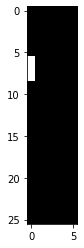

entered if
['D', 'K', 'B', 'I', 'U']
I
saved an img I
['D', 'L', 'D', 'O', 'L']
0 23
[  0  23  31  62  63  93 100 131 136 159]


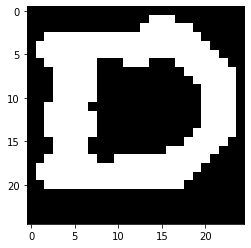

entered if
['D', 'L', 'D', 'O', 'L']
D
saved an img D
31 62
[  0  23  31  62  63  93 100 131 136 159]


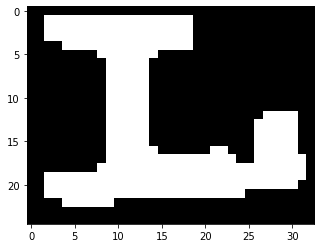

entered if
['D', 'L', 'D', 'O', 'L']
L
saved an img L
63 93
[  0  23  31  62  63  93 100 131 136 159]


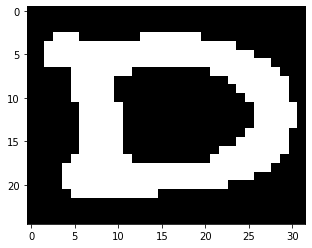

entered if
['D', 'L', 'D', 'O', 'L']
D
saved an img D
100 131
[  0  23  31  62  63  93 100 131 136 159]


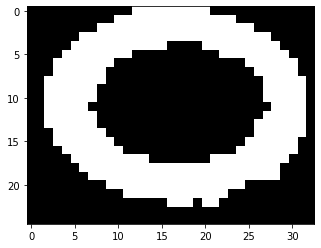

entered if
['D', 'L', 'D', 'O', 'L']
O
saved an img O
136 159
[  0  23  31  62  63  93 100 131 136 159]


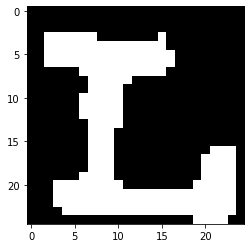

entered if
['D', 'L', 'D', 'O', 'L']
L
saved an img L
['D', 'L', 'S', 'B', 'I']
0 24
[  0  24  31  61  67  93  99 131 139 157]


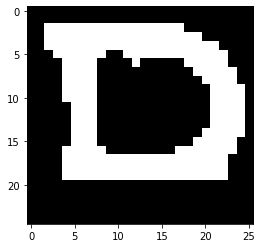

entered if
['D', 'L', 'S', 'B', 'I']
D
saved an img D
31 61
[  0  24  31  61  67  93  99 131 139 157]


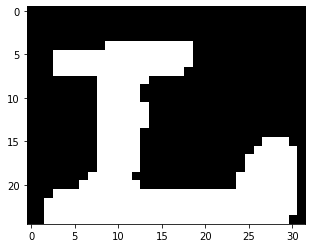

entered if
['D', 'L', 'S', 'B', 'I']
L
saved an img L
67 93
[  0  24  31  61  67  93  99 131 139 157]


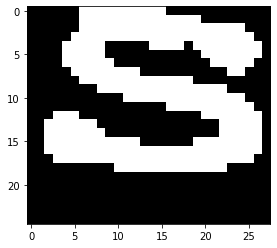

entered if
['D', 'L', 'S', 'B', 'I']
S
saved an img S
99 131
[  0  24  31  61  67  93  99 131 139 157]


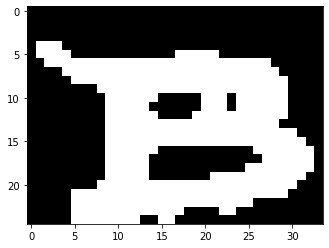

entered if
['D', 'L', 'S', 'B', 'I']
B
saved an img B
139 157
[  0  24  31  61  67  93  99 131 139 157]


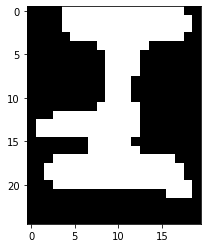

entered if
['D', 'L', 'S', 'B', 'I']
I
saved an img I
['D', 'V', 'E', 'B', 'U']
2 23
[  2  23  28  60  66  95 102 130 138 162]


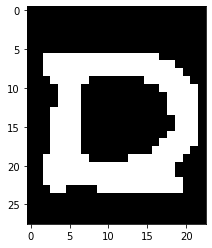

entered if
['D', 'V', 'E', 'B', 'U']
D
saved an img D
28 60
[  2  23  28  60  66  95 102 130 138 162]


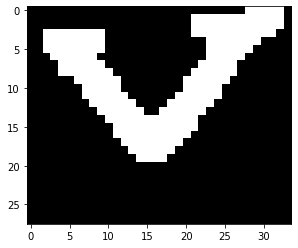

entered if
['D', 'V', 'E', 'B', 'U']
V
saved an img V
66 95
[  2  23  28  60  66  95 102 130 138 162]


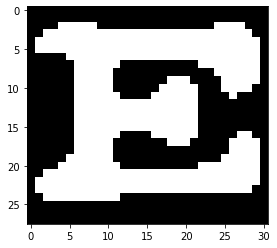

entered if
['D', 'V', 'E', 'B', 'U']
E
saved an img E
102 130
[  2  23  28  60  66  95 102 130 138 162]


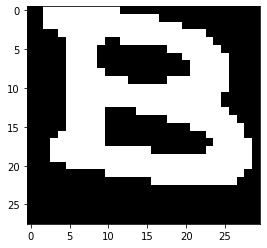

entered if
['D', 'V', 'E', 'B', 'U']
B
saved an img B
138 162
[  2  23  28  60  66  95 102 130 138 162]


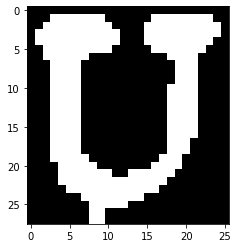

entered if
['D', 'V', 'E', 'B', 'U']
U
saved an img U
['D', 'Z', 'W', 'R', 'Z']
1 24
[  1  24  33  58  67  98 102 134 140 159]


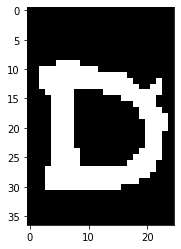

entered if
['D', 'Z', 'W', 'R', 'Z']
D
saved an img D
33 58
[  1  24  33  58  67  98 102 134 140 159]


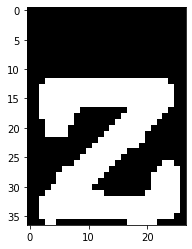

entered if
['D', 'Z', 'W', 'R', 'Z']
Z
saved an img Z
67 98
[  1  24  33  58  67  98 102 134 140 159]


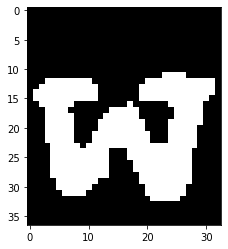

entered if
['D', 'Z', 'W', 'R', 'Z']
W
saved an img W
102 134
[  1  24  33  58  67  98 102 134 140 159]


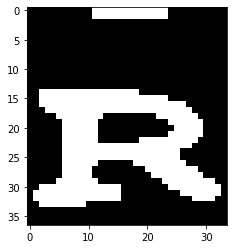

entered if
['D', 'Z', 'W', 'R', 'Z']
R
saved an img R
140 159
[  1  24  33  58  67  98 102 134 140 159]


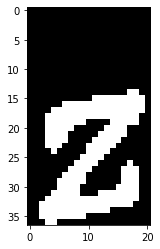

entered if
['D', 'Z', 'W', 'R', 'Z']
Z
saved an img Z
['E', '1', '5', 'Q', '4']
25 32
[ 25  32  55  70  94  99 132 137 155]


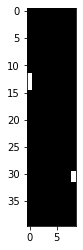

entered if
['E', '1', '5', 'Q', '4']
E
saved an img E
55 70
[ 25  32  55  70  94  99 132 137 155]


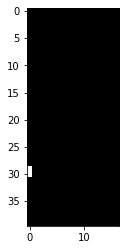

entered if
['E', '1', '5', 'Q', '4']
1
saved an img 1
94 99
[ 25  32  55  70  94  99 132 137 155]


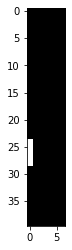

entered if
['E', '1', '5', 'Q', '4']
5
saved an img 5
132 137
[ 25  32  55  70  94  99 132 137 155]


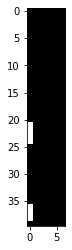

entered if
['E', '1', '5', 'Q', '4']
Q
saved an img Q
['E', '3', 'E', 'S', '8']
2 27
[  2  27  33  57  66  95 107 132 137 157]


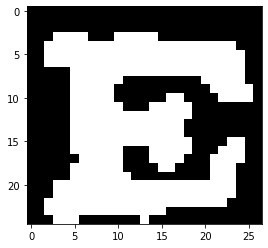

entered if
['E', '3', 'E', 'S', '8']
E
saved an img E
33 57
[  2  27  33  57  66  95 107 132 137 157]


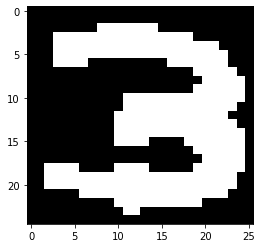

entered if
['E', '3', 'E', 'S', '8']
3
saved an img 3
66 95
[  2  27  33  57  66  95 107 132 137 157]


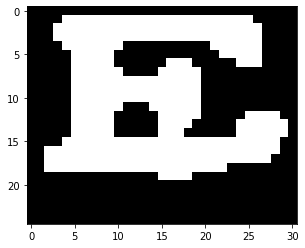

entered if
['E', '3', 'E', 'S', '8']
E
saved an img E
107 132
[  2  27  33  57  66  95 107 132 137 157]


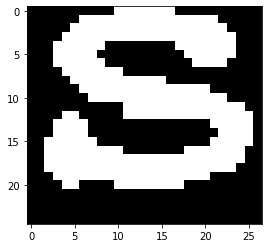

entered if
['E', '3', 'E', 'S', '8']
S
saved an img S
137 157
[  2  27  33  57  66  95 107 132 137 157]


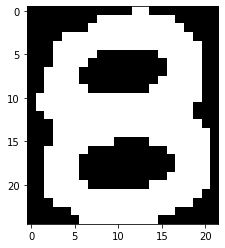

entered if
['E', '3', 'E', 'S', '8']
8
saved an img 8
['E', '5', '3', 'O', 'T']
25 32
[ 25  32  59  69  96  99 132 135 159]


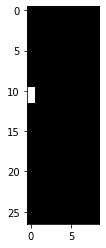

entered if
['E', '5', '3', 'O', 'T']
E
saved an img E
59 69
[ 25  32  59  69  96  99 132 135 159]


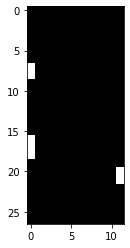

entered if
['E', '5', '3', 'O', 'T']
5
saved an img 5
96 99
[ 25  32  59  69  96  99 132 135 159]


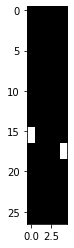

entered if
['E', '5', '3', 'O', 'T']
3
saved an img 3
132 135
[ 25  32  59  69  96  99 132 135 159]


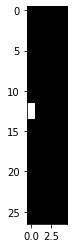

entered if
['E', '5', '3', 'O', 'T']
O
saved an img O
['E', '5', 'Z', 'Y', 'G']
23 33
[ 23  33  58  67  93 102 129 135 159]


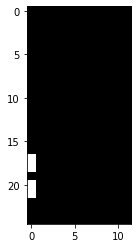

entered if
['E', '5', 'Z', 'Y', 'G']
E
saved an img E
58 67
[ 23  33  58  67  93 102 129 135 159]


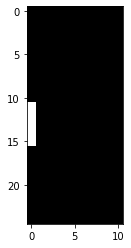

entered if
['E', '5', 'Z', 'Y', 'G']
5
saved an img 5
93 102
[ 23  33  58  67  93 102 129 135 159]


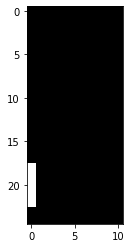

entered if
['E', '5', 'Z', 'Y', 'G']
Z
saved an img Z
129 135
[ 23  33  58  67  93 102 129 135 159]


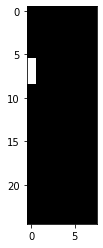

entered if
['E', '5', 'Z', 'Y', 'G']
Y
saved an img Y
['E', '7', 'U', '7', 'G']
1 23
[  1  23  31  55  67  97 102 128 136 158]


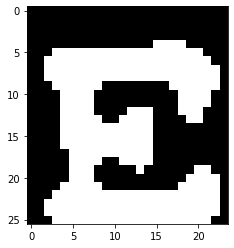

entered if
['E', '7', 'U', '7', 'G']
E
saved an img E
31 55
[  1  23  31  55  67  97 102 128 136 158]


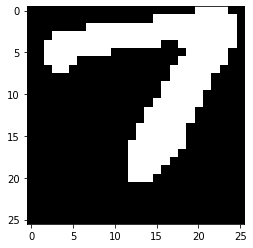

entered if
['E', '7', 'U', '7', 'G']
7
saved an img 7
67 97
[  1  23  31  55  67  97 102 128 136 158]


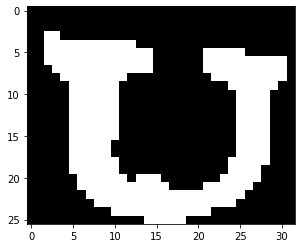

entered if
['E', '7', 'U', '7', 'G']
U
saved an img U
102 128
[  1  23  31  55  67  97 102 128 136 158]


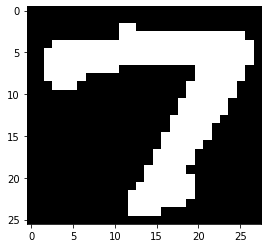

entered if
['E', '7', 'U', '7', 'G']
7
saved an img 7
136 158
[  1  23  31  55  67  97 102 128 136 158]


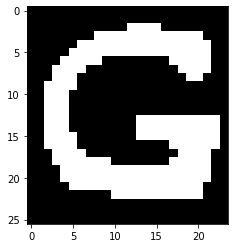

entered if
['E', '7', 'U', '7', 'G']
G
saved an img G
['E', 'G', 'R', 'G', 'L']
2 64
[  2  64  66  96 103 159]


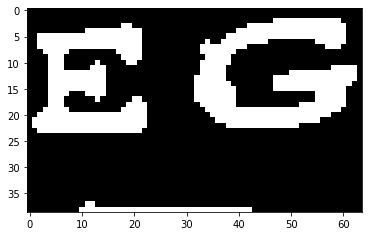

entered if
['E', 'G', 'R', 'G', 'L']
E
saved an img E
66 96
[  2  64  66  96 103 159]


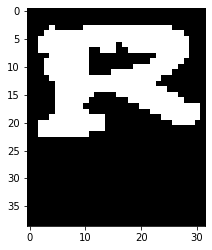

entered if
['E', 'G', 'R', 'G', 'L']
G
saved an img G
103 159
[  2  64  66  96 103 159]


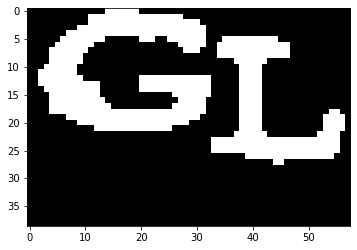

entered if
['E', 'G', 'R', 'G', 'L']
R
saved an img R
['E', 'O', '5', 'T', 'G']
1 27
[  1  27  31  57  68  94 102 131 136 161]


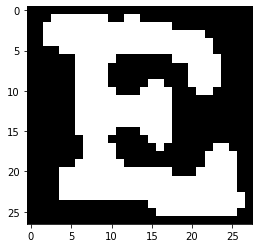

entered if
['E', 'O', '5', 'T', 'G']
E
saved an img E
31 57
[  1  27  31  57  68  94 102 131 136 161]


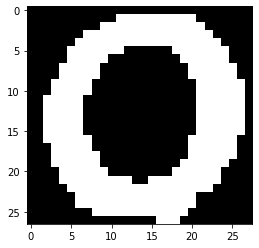

entered if
['E', 'O', '5', 'T', 'G']
O
saved an img O
68 94
[  1  27  31  57  68  94 102 131 136 161]


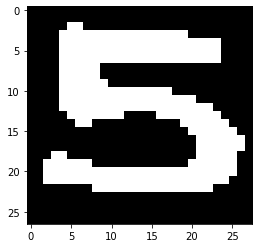

entered if
['E', 'O', '5', 'T', 'G']
5
saved an img 5
102 131
[  1  27  31  57  68  94 102 131 136 161]


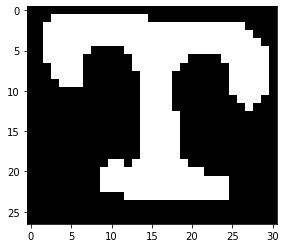

entered if
['E', 'O', '5', 'T', 'G']
T
saved an img T
136 161
[  1  27  31  57  68  94 102 131 136 161]


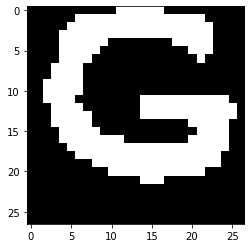

entered if
['E', 'O', '5', 'T', 'G']
G
saved an img G
['E', 'P', '9', '6', '9']
24 28
[ 24  28  61  72  96 106 128 142 161]


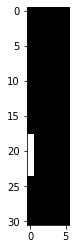

entered if
['E', 'P', '9', '6', '9']
E
saved an img E
61 72
[ 24  28  61  72  96 106 128 142 161]


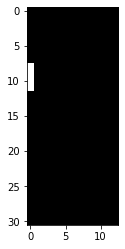

entered if
['E', 'P', '9', '6', '9']
P
saved an img P
96 106
[ 24  28  61  72  96 106 128 142 161]


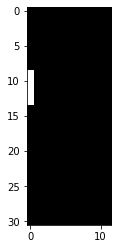

entered if
['E', 'P', '9', '6', '9']
9
saved an img 9
128 142
[ 24  28  61  72  96 106 128 142 161]


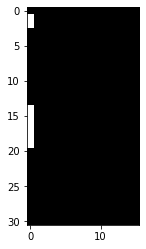

entered if
['E', 'P', '9', '6', '9']
6
saved an img 6
['E', 'Q', '2', 'I', 'X']
0 24
[  0  24  28  58  67  93 107 129 134 160]


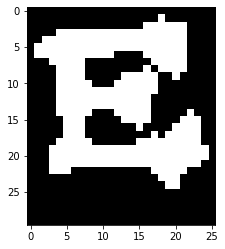

entered if
['E', 'Q', '2', 'I', 'X']
E
saved an img E
28 58
[  0  24  28  58  67  93 107 129 134 160]


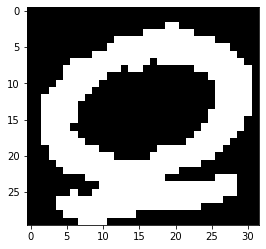

entered if
['E', 'Q', '2', 'I', 'X']
Q
saved an img Q
67 93
[  0  24  28  58  67  93 107 129 134 160]


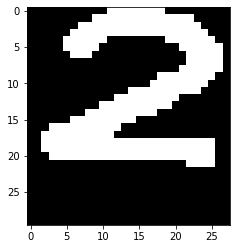

entered if
['E', 'Q', '2', 'I', 'X']
2
saved an img 2
107 129
[  0  24  28  58  67  93 107 129 134 160]


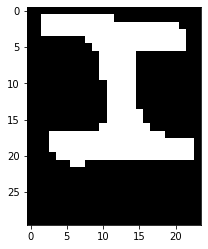

entered if
['E', 'Q', '2', 'I', 'X']
I
saved an img I
134 160
[  0  24  28  58  67  93 107 129 134 160]


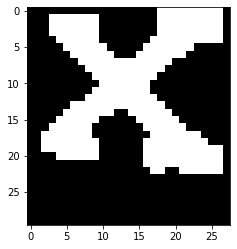

entered if
['E', 'Q', '2', 'I', 'X']
X
saved an img X
['E', 'R', '6', 'F', '1']
23 30
[ 23  30  60  71  96 101 132 138 157]


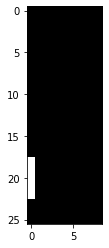

entered if
['E', 'R', '6', 'F', '1']
E
saved an img E
60 71
[ 23  30  60  71  96 101 132 138 157]


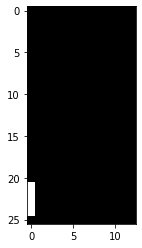

entered if
['E', 'R', '6', 'F', '1']
R
saved an img R
96 101
[ 23  30  60  71  96 101 132 138 157]


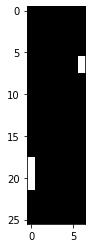

entered if
['E', 'R', '6', 'F', '1']
6
saved an img 6
132 138
[ 23  30  60  71  96 101 132 138 157]


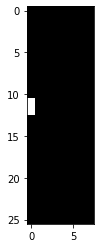

entered if
['E', 'R', '6', 'F', '1']
F
saved an img F
['E', 'Z', 'S', 'H', 'Y']
1 26
[  1  26  30  58  66  94 105 132 135 160]


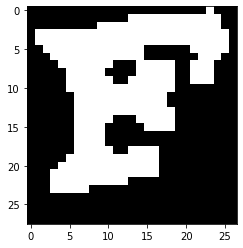

entered if
['E', 'Z', 'S', 'H', 'Y']
E
saved an img E
30 58
[  1  26  30  58  66  94 105 132 135 160]


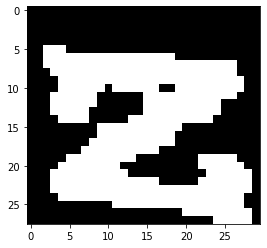

entered if
['E', 'Z', 'S', 'H', 'Y']
Z
saved an img Z
66 94
[  1  26  30  58  66  94 105 132 135 160]


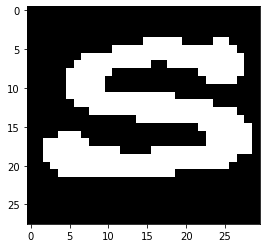

entered if
['E', 'Z', 'S', 'H', 'Y']
S
saved an img S
105 132
[  1  26  30  58  66  94 105 132 135 160]


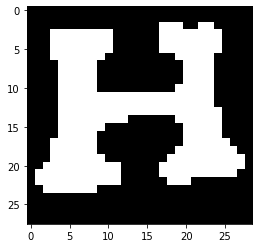

entered if
['E', 'Z', 'S', 'H', 'Y']
H
saved an img H
135 160
[  1  26  30  58  66  94 105 132 135 160]


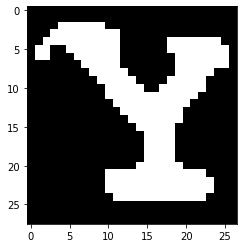

entered if
['E', 'Z', 'S', 'H', 'Y']
Y
saved an img Y
['F', '1', '0', '1', '4']
4 25
[  4  25  33  55  67  93 105 128 137 157]


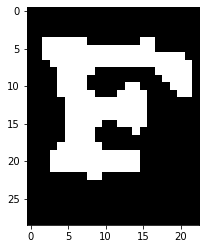

entered if
['F', '1', '0', '1', '4']
F
saved an img F
33 55
[  4  25  33  55  67  93 105 128 137 157]


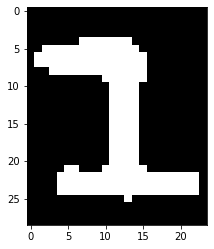

entered if
['F', '1', '0', '1', '4']
1
saved an img 1
67 93
[  4  25  33  55  67  93 105 128 137 157]


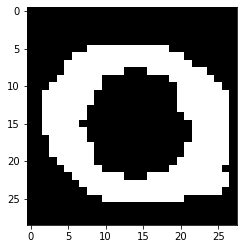

entered if
['F', '1', '0', '1', '4']
0
saved an img 0
105 128
[  4  25  33  55  67  93 105 128 137 157]


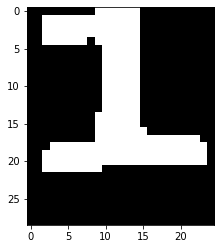

entered if
['F', '1', '0', '1', '4']
1
saved an img 1
137 157
[  4  25  33  55  67  93 105 128 137 157]


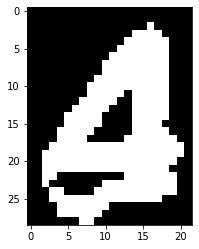

entered if
['F', '1', '0', '1', '4']
4
saved an img 4
['F', '1', '4', '7', 'U']
26 33
[ 26  33  53  66  89 103 126 133 157]


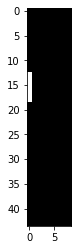

entered if
['F', '1', '4', '7', 'U']
F
saved an img F
53 66
[ 26  33  53  66  89 103 126 133 157]


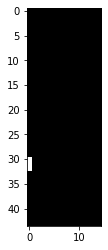

entered if
['F', '1', '4', '7', 'U']
1
saved an img 1
89 103
[ 26  33  53  66  89 103 126 133 157]


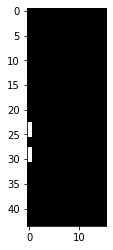

entered if
['F', '1', '4', '7', 'U']
4
saved an img 4
126 133
[ 26  33  53  66  89 103 126 133 157]


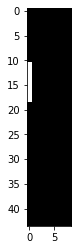

entered if
['F', '1', '4', '7', 'U']
7
saved an img 7
['F', '7', 'H', 'X', 'B']
4 28
[  4  28  30  59  66  96 100 130 132 157]


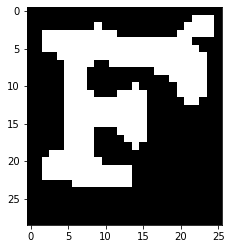

entered if
['F', '7', 'H', 'X', 'B']
F
saved an img F
30 59
[  4  28  30  59  66  96 100 130 132 157]


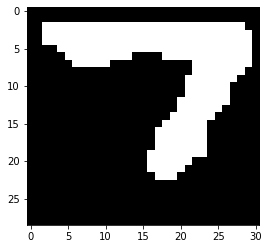

entered if
['F', '7', 'H', 'X', 'B']
7
saved an img 7
66 96
[  4  28  30  59  66  96 100 130 132 157]


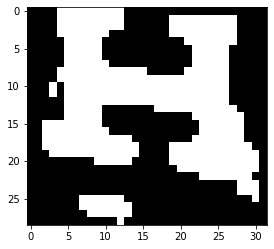

entered if
['F', '7', 'H', 'X', 'B']
H
saved an img H
100 130
[  4  28  30  59  66  96 100 130 132 157]


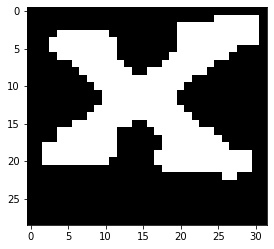

entered if
['F', '7', 'H', 'X', 'B']
X
saved an img X
132 157
[  4  28  30  59  66  96 100 130 132 157]


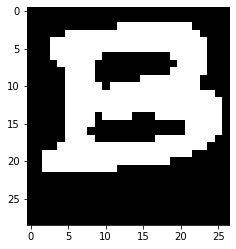

entered if
['F', '7', 'H', 'X', 'B']
B
saved an img B
['F', 'D', 'K', '5', 'I']
3 28
[  3  28  30  59  67  97 106 131 137 155]


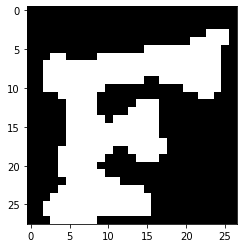

entered if
['F', 'D', 'K', '5', 'I']
F
saved an img F
30 59
[  3  28  30  59  67  97 106 131 137 155]


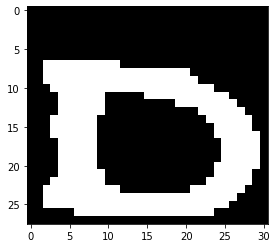

entered if
['F', 'D', 'K', '5', 'I']
D
saved an img D
67 97
[  3  28  30  59  67  97 106 131 137 155]


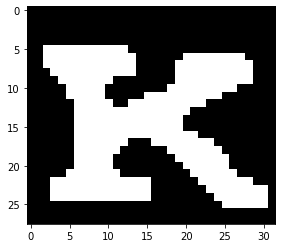

entered if
['F', 'D', 'K', '5', 'I']
K
saved an img K
106 131
[  3  28  30  59  67  97 106 131 137 155]


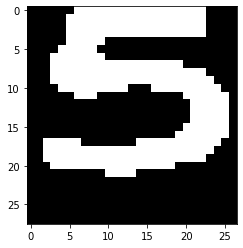

entered if
['F', 'D', 'K', '5', 'I']
5
saved an img 5
137 155
[  3  28  30  59  67  97 106 131 137 155]


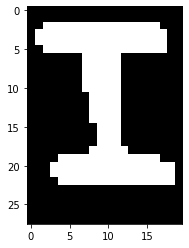

entered if
['F', 'D', 'K', '5', 'I']
I
saved an img I
['F', 'E', '3', 'M', 'N']
4 27
[  4  27  31  60  64  95 102 132 134 162]


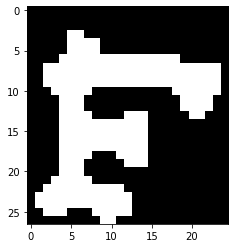

entered if
['F', 'E', '3', 'M', 'N']
F
saved an img F
31 60
[  4  27  31  60  64  95 102 132 134 162]


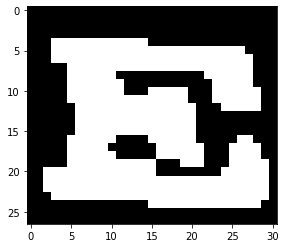

entered if
['F', 'E', '3', 'M', 'N']
E
saved an img E
64 95
[  4  27  31  60  64  95 102 132 134 162]


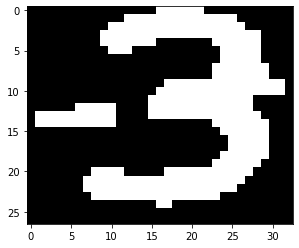

entered if
['F', 'E', '3', 'M', 'N']
3
saved an img 3
102 132
[  4  27  31  60  64  95 102 132 134 162]


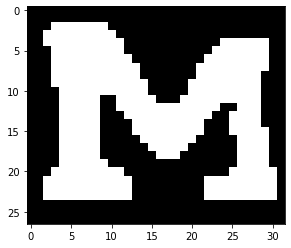

entered if
['F', 'E', '3', 'M', 'N']
M
saved an img M
134 162
[  4  27  31  60  64  95 102 132 134 162]


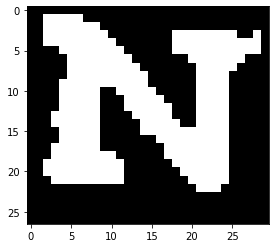

entered if
['F', 'E', '3', 'M', 'N']
N
saved an img N
['F', 'E', 'F', 'T', 'L']
1 29
[  1  29  30  61  67  98 100 161]


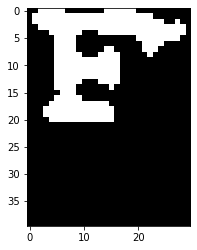

entered if
['F', 'E', 'F', 'T', 'L']
F
saved an img F
30 61
[  1  29  30  61  67  98 100 161]


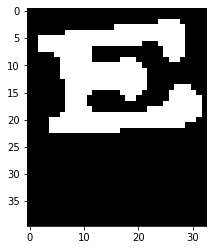

entered if
['F', 'E', 'F', 'T', 'L']
E
saved an img E
67 98
[  1  29  30  61  67  98 100 161]


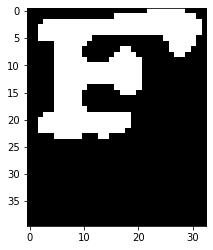

entered if
['F', 'E', 'F', 'T', 'L']
F
saved an img F
100 161
[  1  29  30  61  67  98 100 161]


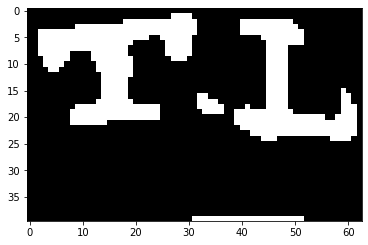

entered if
['F', 'E', 'F', 'T', 'L']
T
saved an img T
['F', 'E', 'M', '5', 'P']
4 26
[  4  26  30  63  67 129 139 163]


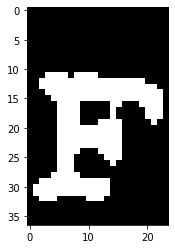

entered if
['F', 'E', 'M', '5', 'P']
F
saved an img F
30 63
[  4  26  30  63  67 129 139 163]


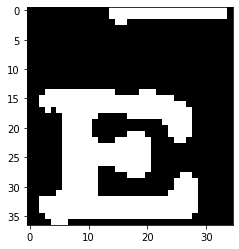

entered if
['F', 'E', 'M', '5', 'P']
E
saved an img E
67 129
[  4  26  30  63  67 129 139 163]


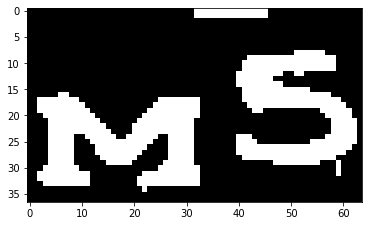

entered if
['F', 'E', 'M', '5', 'P']
M
saved an img M
139 163
[  4  26  30  63  67 129 139 163]


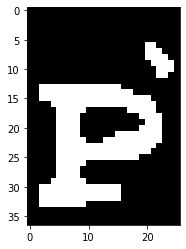

entered if
['F', 'E', 'M', '5', 'P']
5
saved an img 5
['F', 'E', 'S', '0', '9']
1 24
[  1  24  30  56  68  94 106 130 139 158]


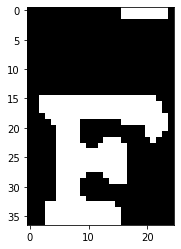

entered if
['F', 'E', 'S', '0', '9']
F
saved an img F
30 56
[  1  24  30  56  68  94 106 130 139 158]


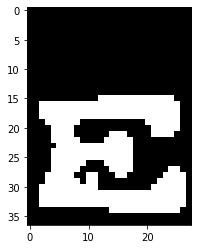

entered if
['F', 'E', 'S', '0', '9']
E
saved an img E
68 94
[  1  24  30  56  68  94 106 130 139 158]


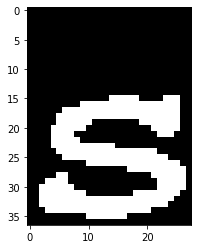

entered if
['F', 'E', 'S', '0', '9']
S
saved an img S
106 130
[  1  24  30  56  68  94 106 130 139 158]


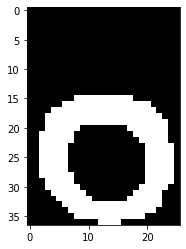

entered if
['F', 'E', 'S', '0', '9']
0
saved an img 0
139 158
[  1  24  30  56  68  94 106 130 139 158]


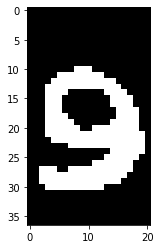

entered if
['F', 'E', 'S', '0', '9']
9
saved an img 9
['F', 'M', 'I', 'K', 'O']
23 28
[ 23  28  65  68  93 104 134 137 157]


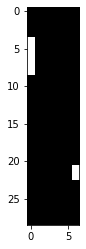

entered if
['F', 'M', 'I', 'K', 'O']
F
saved an img F
65 68
[ 23  28  65  68  93 104 134 137 157]


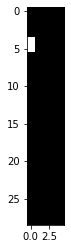

entered if
['F', 'M', 'I', 'K', 'O']
M
saved an img M
93 104
[ 23  28  65  68  93 104 134 137 157]


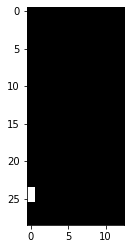

entered if
['F', 'M', 'I', 'K', 'O']
I
saved an img I
134 137
[ 23  28  65  68  93 104 134 137 157]


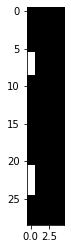

entered if
['F', 'M', 'I', 'K', 'O']
K
saved an img K
['F', 'R', 'M', 'P', 'U']
3 26
[  3  26  29  62  66  99 104 131 139 163]


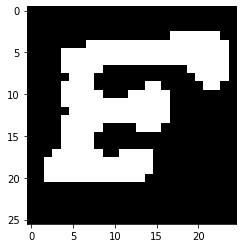

entered if
['F', 'R', 'M', 'P', 'U']
F
saved an img F
29 62
[  3  26  29  62  66  99 104 131 139 163]


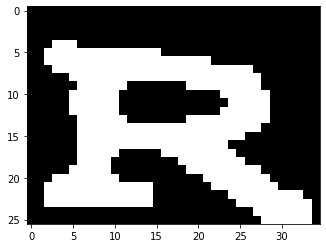

entered if
['F', 'R', 'M', 'P', 'U']
R
saved an img R
66 99
[  3  26  29  62  66  99 104 131 139 163]


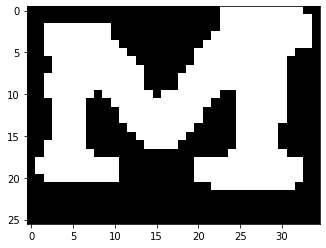

entered if
['F', 'R', 'M', 'P', 'U']
M
saved an img M
104 131
[  3  26  29  62  66  99 104 131 139 163]


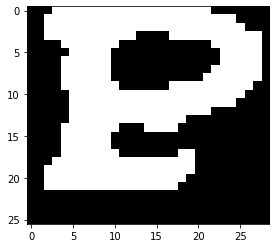

entered if
['F', 'R', 'M', 'P', 'U']
P
saved an img P
139 163
[  3  26  29  62  66  99 104 131 139 163]


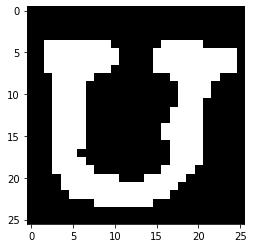

entered if
['F', 'R', 'M', 'P', 'U']
U
saved an img U
['F', 'T', '6', 'X', 'V']
2 24
[  2  24  30  60  72  95 101 131 136 160]


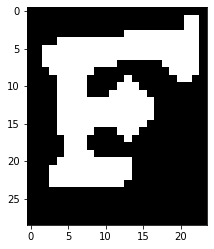

entered if
['F', 'T', '6', 'X', 'V']
F
saved an img F
30 60
[  2  24  30  60  72  95 101 131 136 160]


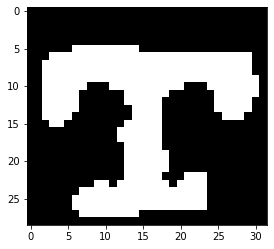

entered if
['F', 'T', '6', 'X', 'V']
T
saved an img T
72 95
[  2  24  30  60  72  95 101 131 136 160]


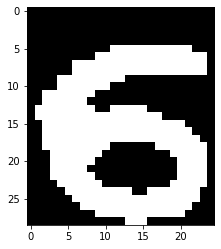

entered if
['F', 'T', '6', 'X', 'V']
6
saved an img 6
101 131
[  2  24  30  60  72  95 101 131 136 160]


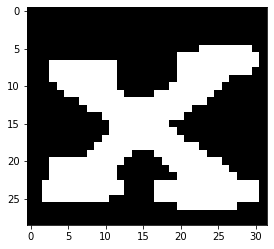

entered if
['F', 'T', '6', 'X', 'V']
X
saved an img X
136 160
[  2  24  30  60  72  95 101 131 136 160]


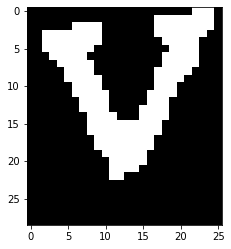

entered if
['F', 'T', '6', 'X', 'V']
V
saved an img V
['F', 'V', 'Q', '8', 'Z']
0 26
[  0  26  28  59  60  96  99 130 140 161]


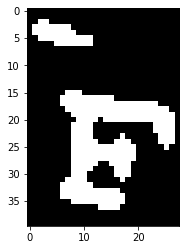

entered if
['F', 'V', 'Q', '8', 'Z']
F
saved an img F
28 59
[  0  26  28  59  60  96  99 130 140 161]


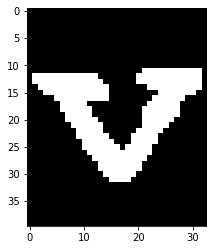

entered if
['F', 'V', 'Q', '8', 'Z']
V
saved an img V
60 96
[  0  26  28  59  60  96  99 130 140 161]


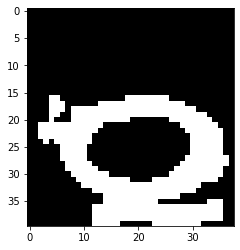

entered if
['F', 'V', 'Q', '8', 'Z']
Q
saved an img Q
99 130
[  0  26  28  59  60  96  99 130 140 161]


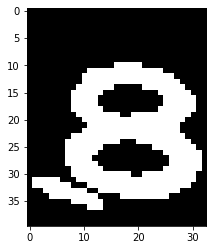

entered if
['F', 'V', 'Q', '8', 'Z']
8
saved an img 8
140 161
[  0  26  28  59  60  96  99 130 140 161]


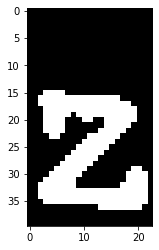

entered if
['F', 'V', 'Q', '8', 'Z']
Z
saved an img Z
['F', 'Y', 'E', '3', '3']
5 28
[  5  28  31  61  66  95 102 126 138 156]


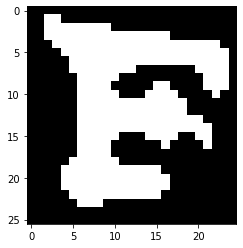

entered if
['F', 'Y', 'E', '3', '3']
F
saved an img F
31 61
[  5  28  31  61  66  95 102 126 138 156]


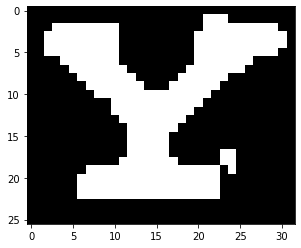

entered if
['F', 'Y', 'E', '3', '3']
Y
saved an img Y
66 95
[  5  28  31  61  66  95 102 126 138 156]


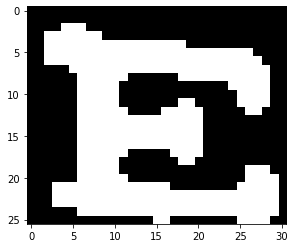

entered if
['F', 'Y', 'E', '3', '3']
E
saved an img E
102 126
[  5  28  31  61  66  95 102 126 138 156]


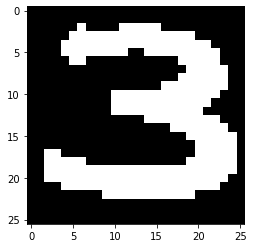

entered if
['F', 'Y', 'E', '3', '3']
3
saved an img 3
138 156
[  5  28  31  61  66  95 102 126 138 156]


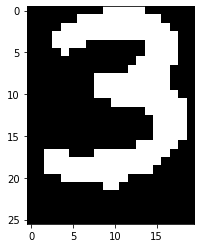

entered if
['F', 'Y', 'E', '3', '3']
3
saved an img 3
['G', '7', 'V', '5', 'K']
1 53
[  1  53  63  99 106 129 136 159]


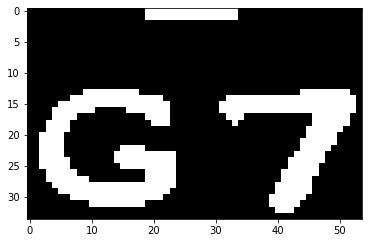

entered if
['G', '7', 'V', '5', 'K']
G
saved an img G
63 99
[  1  53  63  99 106 129 136 159]


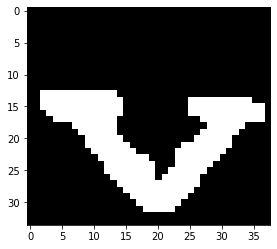

entered if
['G', '7', 'V', '5', 'K']
7
saved an img 7
106 129
[  1  53  63  99 106 129 136 159]


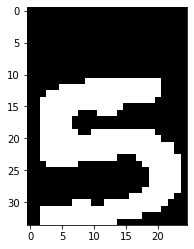

entered if
['G', '7', 'V', '5', 'K']
V
saved an img V
136 159
[  1  53  63  99 106 129 136 159]


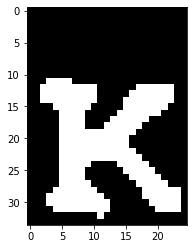

entered if
['G', '7', 'V', '5', 'K']
5
saved an img 5
['G', 'B', 'E', 'B', 'T']
0 23
[  0  23  29  59  66  95 101 132 138 161]


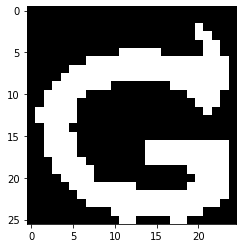

entered if
['G', 'B', 'E', 'B', 'T']
G
saved an img G
29 59
[  0  23  29  59  66  95 101 132 138 161]


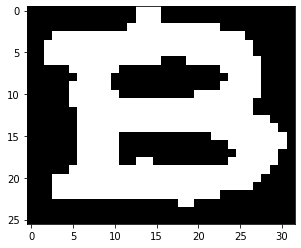

entered if
['G', 'B', 'E', 'B', 'T']
B
saved an img B
66 95
[  0  23  29  59  66  95 101 132 138 161]


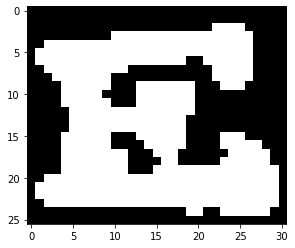

entered if
['G', 'B', 'E', 'B', 'T']
E
saved an img E
101 132
[  0  23  29  59  66  95 101 132 138 161]


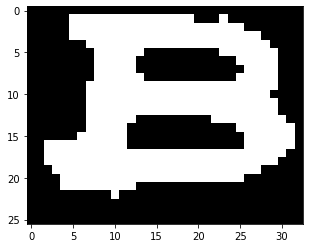

entered if
['G', 'B', 'E', 'B', 'T']
B
saved an img B
138 161
[  0  23  29  59  66  95 101 132 138 161]


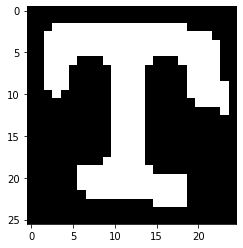

entered if
['G', 'B', 'E', 'B', 'T']
T
saved an img T
['G', 'B', 'T', 'H', 'R']
3 62
[  3  62  67  95 104 134 135 161]


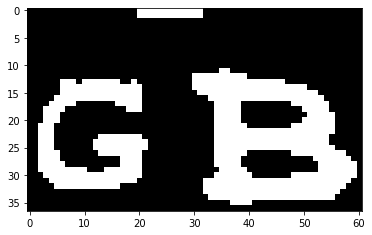

entered if
['G', 'B', 'T', 'H', 'R']
G
saved an img G
67 95
[  3  62  67  95 104 134 135 161]


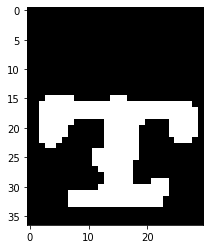

entered if
['G', 'B', 'T', 'H', 'R']
B
saved an img B
104 134
[  3  62  67  95 104 134 135 161]


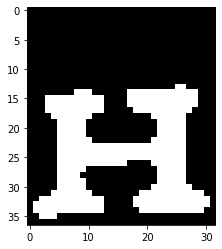

entered if
['G', 'B', 'T', 'H', 'R']
T
saved an img T
135 161
[  3  62  67  95 104 134 135 161]


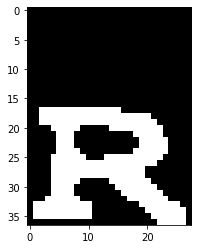

entered if
['G', 'B', 'T', 'H', 'R']
H
saved an img H
['G', 'C', '1', 'E', 'A']
1 24
[  1  24  27  56  70  92 100 129 132 163]


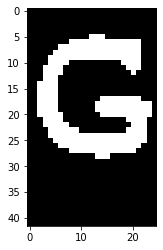

entered if
['G', 'C', '1', 'E', 'A']
G
saved an img G
27 56
[  1  24  27  56  70  92 100 129 132 163]


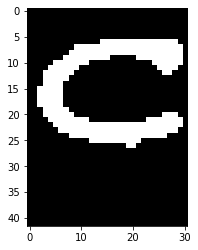

entered if
['G', 'C', '1', 'E', 'A']
C
saved an img C
70 92
[  1  24  27  56  70  92 100 129 132 163]


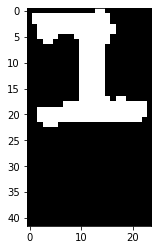

entered if
['G', 'C', '1', 'E', 'A']
1
saved an img 1
100 129
[  1  24  27  56  70  92 100 129 132 163]


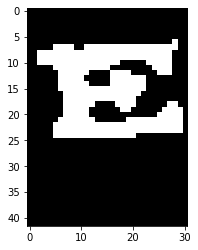

entered if
['G', 'C', '1', 'E', 'A']
E
saved an img E
132 163
[  1  24  27  56  70  92 100 129 132 163]


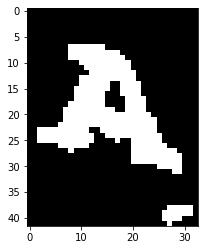

entered if
['G', 'C', '1', 'E', 'A']
A
saved an img A
['G', 'I', 'Z', '8', 'J']
2 24
[  2  24  28  55  68  95 104 126 134 158]


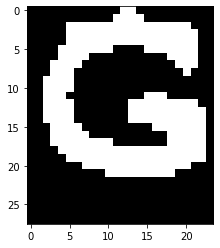

entered if
['G', 'I', 'Z', '8', 'J']
G
saved an img G
28 55
[  2  24  28  55  68  95 104 126 134 158]


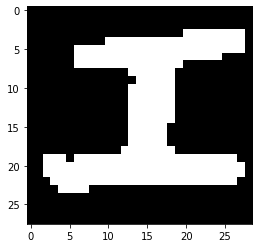

entered if
['G', 'I', 'Z', '8', 'J']
I
saved an img I
68 95
[  2  24  28  55  68  95 104 126 134 158]


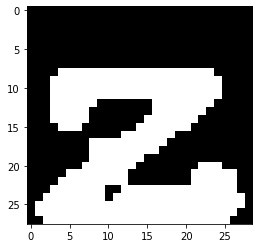

entered if
['G', 'I', 'Z', '8', 'J']
Z
saved an img Z
104 126
[  2  24  28  55  68  95 104 126 134 158]


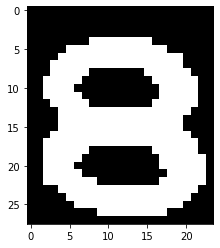

entered if
['G', 'I', 'Z', '8', 'J']
8
saved an img 8
134 158
[  2  24  28  55  68  95 104 126 134 158]


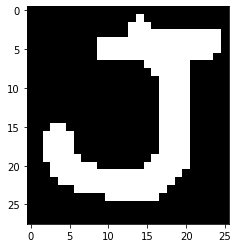

entered if
['G', 'I', 'Z', '8', 'J']
J
saved an img J
['G', 'L', '7', 'W', '0']
1 25
[  1  25  28  58  68  93 101 133 139 161]


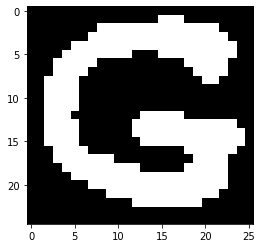

entered if
['G', 'L', '7', 'W', '0']
G
saved an img G
28 58
[  1  25  28  58  68  93 101 133 139 161]


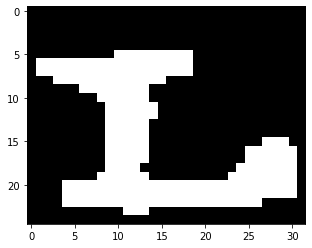

entered if
['G', 'L', '7', 'W', '0']
L
saved an img L
68 93
[  1  25  28  58  68  93 101 133 139 161]


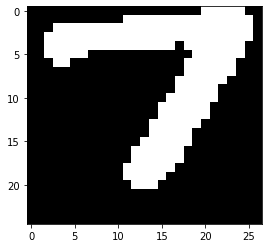

entered if
['G', 'L', '7', 'W', '0']
7
saved an img 7
101 133
[  1  25  28  58  68  93 101 133 139 161]


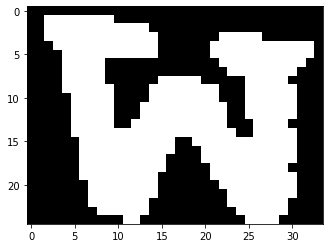

entered if
['G', 'L', '7', 'W', '0']
W
saved an img W
139 161
[  1  25  28  58  68  93 101 133 139 161]


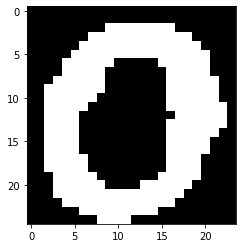

entered if
['G', 'L', '7', 'W', '0']
0
saved an img 0
['G', 'O', 'T', '8', '3']
25 27
[ 25  27  58  62  95 104 128 136 157]


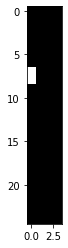

entered if
['G', 'O', 'T', '8', '3']
G
saved an img G
58 62
[ 25  27  58  62  95 104 128 136 157]


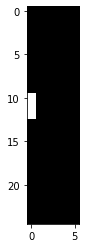

entered if
['G', 'O', 'T', '8', '3']
O
saved an img O
95 104
[ 25  27  58  62  95 104 128 136 157]


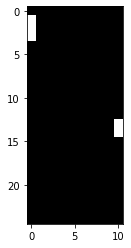

entered if
['G', 'O', 'T', '8', '3']
T
saved an img T
128 136
[ 25  27  58  62  95 104 128 136 157]


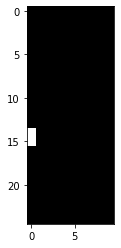

entered if
['G', 'O', 'T', '8', '3']
8
saved an img 8
['G', 'O', 'U', 'C', 'C']
1 27
[  1  27  32  61  66  96 101 133 134 159]


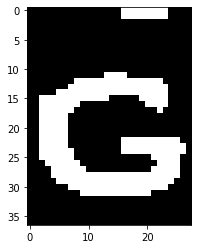

entered if
['G', 'O', 'U', 'C', 'C']
G
saved an img G
32 61
[  1  27  32  61  66  96 101 133 134 159]


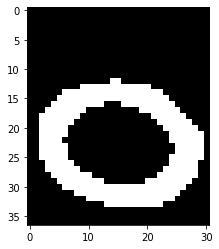

entered if
['G', 'O', 'U', 'C', 'C']
O
saved an img O
66 96
[  1  27  32  61  66  96 101 133 134 159]


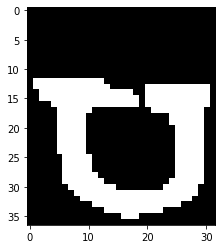

entered if
['G', 'O', 'U', 'C', 'C']
U
saved an img U
101 133
[  1  27  32  61  66  96 101 133 134 159]


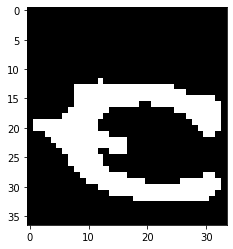

entered if
['G', 'O', 'U', 'C', 'C']
C
saved an img C
134 159
[  1  27  32  61  66  96 101 133 134 159]


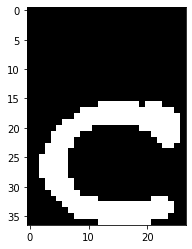

entered if
['G', 'O', 'U', 'C', 'C']
C
saved an img C
['G', 'P', 'M', 'C', 'W']
1 26
[  1  26  33  59  64  99 102 132 134 160]


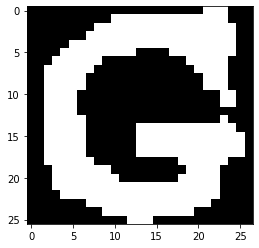

entered if
['G', 'P', 'M', 'C', 'W']
G
saved an img G
33 59
[  1  26  33  59  64  99 102 132 134 160]


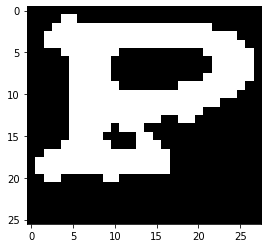

entered if
['G', 'P', 'M', 'C', 'W']
P
saved an img P
64 99
[  1  26  33  59  64  99 102 132 134 160]


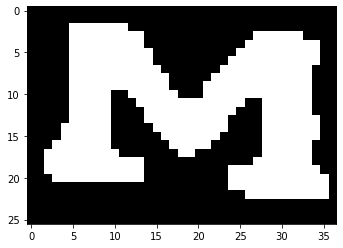

entered if
['G', 'P', 'M', 'C', 'W']
M
saved an img M
102 132
[  1  26  33  59  64  99 102 132 134 160]


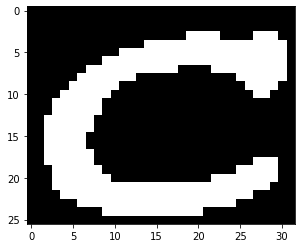

entered if
['G', 'P', 'M', 'C', 'W']
C
saved an img C
134 160
[  1  26  33  59  64  99 102 132 134 160]


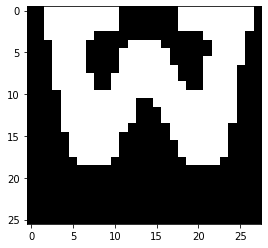

entered if
['G', 'P', 'M', 'C', 'W']
W
saved an img W
['G', 'Q', 'H', '5', '2']
4 63
[  4  63  68  95 104 130 137 157]


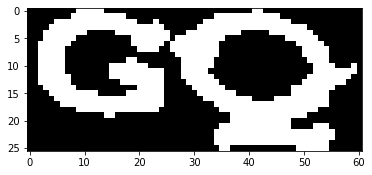

entered if
['G', 'Q', 'H', '5', '2']
G
saved an img G
68 95
[  4  63  68  95 104 130 137 157]


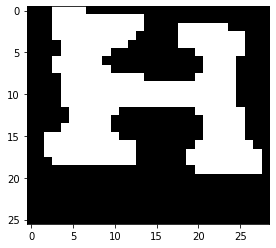

entered if
['G', 'Q', 'H', '5', '2']
Q
saved an img Q
104 130
[  4  63  68  95 104 130 137 157]


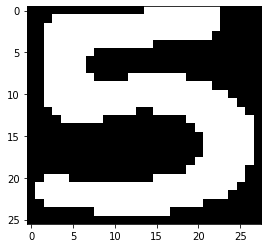

entered if
['G', 'Q', 'H', '5', '2']
H
saved an img H
137 157
[  4  63  68  95 104 130 137 157]


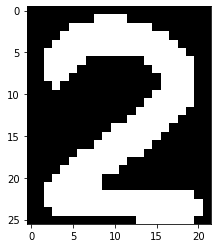

entered if
['G', 'Q', 'H', '5', '2']
5
saved an img 5
['G', 'S', 'U', 'V', 'D']
57 64
[ 57  64  93  98 135 137 158]


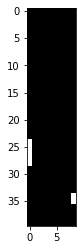

entered if
['G', 'S', 'U', 'V', 'D']
G
saved an img G
93 98
[ 57  64  93  98 135 137 158]


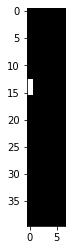

entered if
['G', 'S', 'U', 'V', 'D']
S
saved an img S
135 137
[ 57  64  93  98 135 137 158]


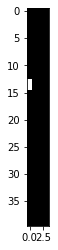

entered if
['G', 'S', 'U', 'V', 'D']
U
saved an img U
['G', 'Y', '2', 'A', 'M']
0 24
[  0  24  33  63  67  91  98 133 135 163]


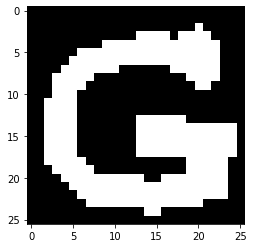

entered if
['G', 'Y', '2', 'A', 'M']
G
saved an img G
33 63
[  0  24  33  63  67  91  98 133 135 163]


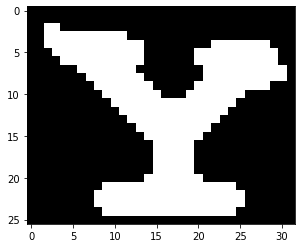

entered if
['G', 'Y', '2', 'A', 'M']
Y
saved an img Y
67 91
[  0  24  33  63  67  91  98 133 135 163]


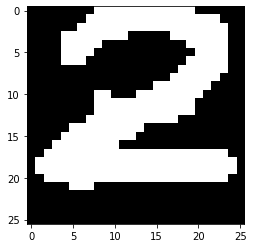

entered if
['G', 'Y', '2', 'A', 'M']
2
saved an img 2
98 133
[  0  24  33  63  67  91  98 133 135 163]


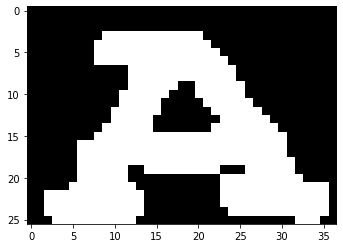

entered if
['G', 'Y', '2', 'A', 'M']
A
saved an img A
135 163
[  0  24  33  63  67  91  98 133 135 163]


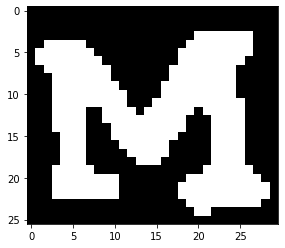

entered if
['G', 'Y', '2', 'A', 'M']
M
saved an img M
['G', 'Z', '1', '4', 'Z']
1 57
[  1  57  67  88 107 129 138 158]


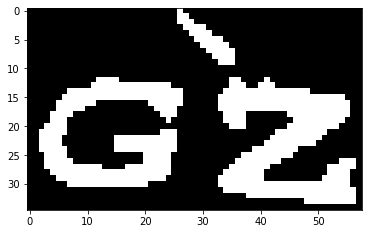

entered if
['G', 'Z', '1', '4', 'Z']
G
saved an img G
67 88
[  1  57  67  88 107 129 138 158]


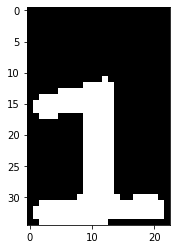

entered if
['G', 'Z', '1', '4', 'Z']
Z
saved an img Z
107 129
[  1  57  67  88 107 129 138 158]


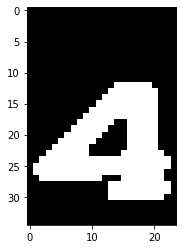

entered if
['G', 'Z', '1', '4', 'Z']
1
saved an img 1
138 158
[  1  57  67  88 107 129 138 158]


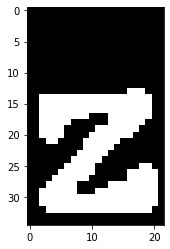

entered if
['G', 'Z', '1', '4', 'Z']
4
saved an img 4
['H', '3', 'R', 'G', 'M']
0 25
[  0  25  32  59  61 130 133 160]


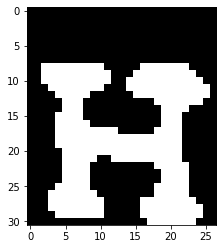

entered if
['H', '3', 'R', 'G', 'M']
H
saved an img H
32 59
[  0  25  32  59  61 130 133 160]


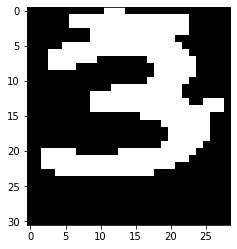

entered if
['H', '3', 'R', 'G', 'M']
3
saved an img 3
61 130
[  0  25  32  59  61 130 133 160]


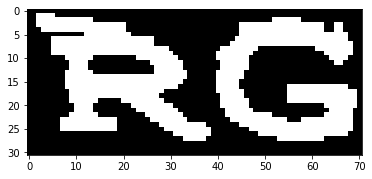

entered if
['H', '3', 'R', 'G', 'M']
R
saved an img R
133 160
[  0  25  32  59  61 130 133 160]


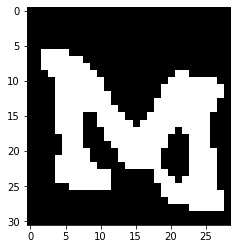

entered if
['H', '3', 'R', 'G', 'M']
G
saved an img G
['H', '4', 'C', 'O', 'Q']
1 27
[  1  27  33  56  65  96 101 127 136 159]


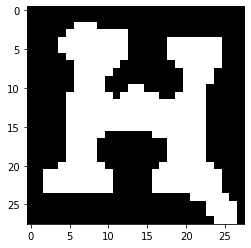

entered if
['H', '4', 'C', 'O', 'Q']
H
saved an img H
33 56
[  1  27  33  56  65  96 101 127 136 159]


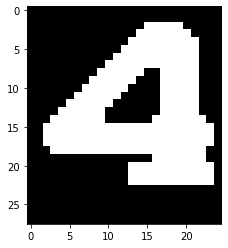

entered if
['H', '4', 'C', 'O', 'Q']
4
saved an img 4
65 96
[  1  27  33  56  65  96 101 127 136 159]


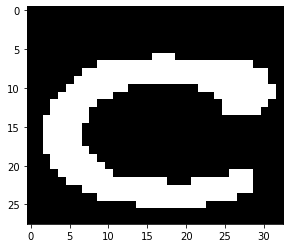

entered if
['H', '4', 'C', 'O', 'Q']
C
saved an img C
101 127
[  1  27  33  56  65  96 101 127 136 159]


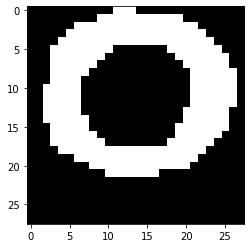

entered if
['H', '4', 'C', 'O', 'Q']
O
saved an img O
136 159
[  1  27  33  56  65  96 101 127 136 159]


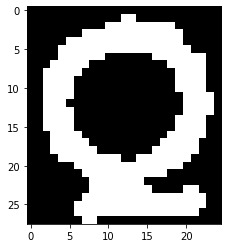

entered if
['H', '4', 'C', 'O', 'Q']
Q
saved an img Q
['H', 'A', '4', 'N', 'O']
60 66
[ 60  66  93 100 133 135 160]


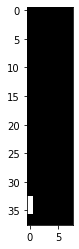

entered if
['H', 'A', '4', 'N', 'O']
H
saved an img H
93 100
[ 60  66  93 100 133 135 160]


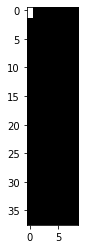

entered if
['H', 'A', '4', 'N', 'O']
A
saved an img A
133 135
[ 60  66  93 100 133 135 160]


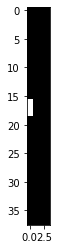

entered if
['H', 'A', '4', 'N', 'O']
4
saved an img 4
['H', 'A', 'S', 'M', 'J']
4 23
[  4  23  27  65  67  93 100 136 138 162]


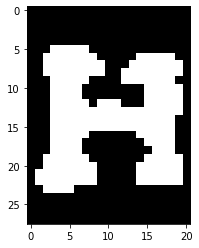

entered if
['H', 'A', 'S', 'M', 'J']
H
saved an img H
27 65
[  4  23  27  65  67  93 100 136 138 162]


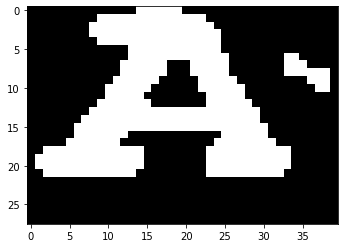

entered if
['H', 'A', 'S', 'M', 'J']
A
saved an img A
67 93
[  4  23  27  65  67  93 100 136 138 162]


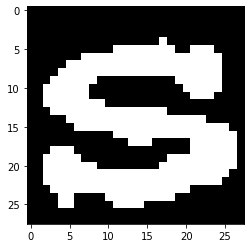

entered if
['H', 'A', 'S', 'M', 'J']
S
saved an img S
100 136
[  4  23  27  65  67  93 100 136 138 162]


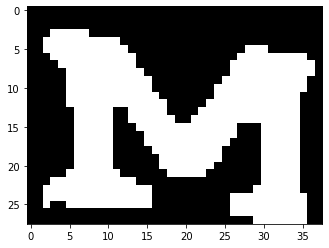

entered if
['H', 'A', 'S', 'M', 'J']
M
saved an img M
138 162
[  4  23  27  65  67  93 100 136 138 162]


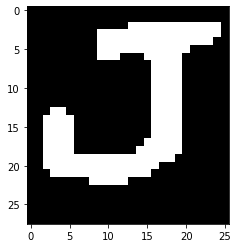

entered if
['H', 'A', 'S', 'M', 'J']
J
saved an img J
['H', 'D', '6', '0', '6']
4 29
[  4  29  30  60  72  94 100 131 137 157]


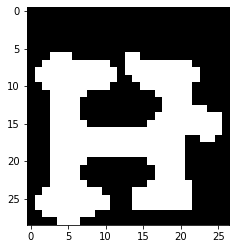

entered if
['H', 'D', '6', '0', '6']
H
saved an img H
30 60
[  4  29  30  60  72  94 100 131 137 157]


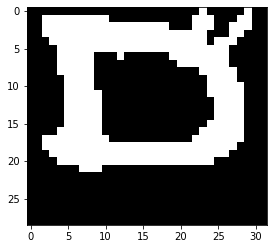

entered if
['H', 'D', '6', '0', '6']
D
saved an img D
72 94
[  4  29  30  60  72  94 100 131 137 157]


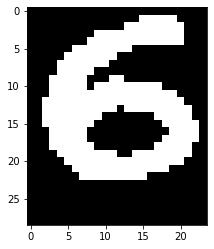

entered if
['H', 'D', '6', '0', '6']
6
saved an img 6
100 131
[  4  29  30  60  72  94 100 131 137 157]


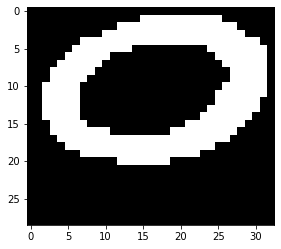

entered if
['H', 'D', '6', '0', '6']
0
saved an img 0
137 157
[  4  29  30  60  72  94 100 131 137 157]


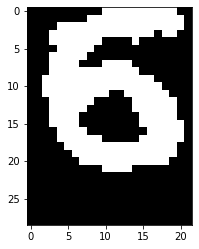

entered if
['H', 'D', '6', '0', '6']
6
saved an img 6
['H', 'D', 'A', '5', 'M']
2 26
[  2  26  29  58  64  99 106 131 133 162]


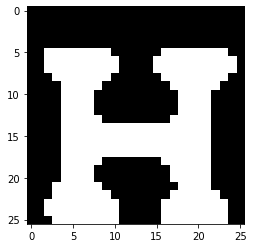

entered if
['H', 'D', 'A', '5', 'M']
H
saved an img H
29 58
[  2  26  29  58  64  99 106 131 133 162]


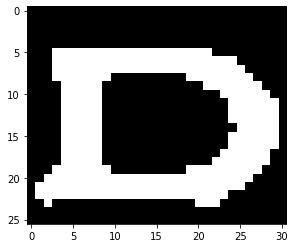

entered if
['H', 'D', 'A', '5', 'M']
D
saved an img D
64 99
[  2  26  29  58  64  99 106 131 133 162]


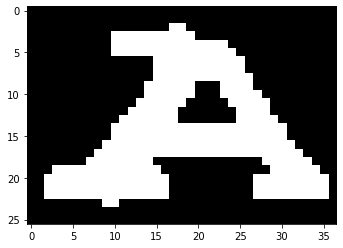

entered if
['H', 'D', 'A', '5', 'M']
A
saved an img A
106 131
[  2  26  29  58  64  99 106 131 133 162]


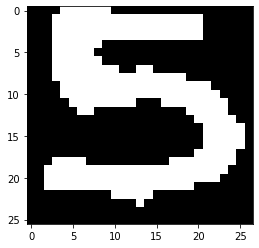

entered if
['H', 'D', 'A', '5', 'M']
5
saved an img 5
133 162
[  2  26  29  58  64  99 106 131 133 162]


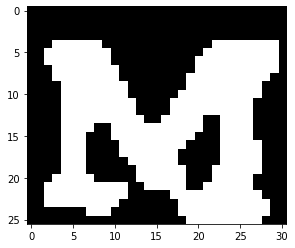

entered if
['H', 'D', 'A', '5', 'M']
M
saved an img M
['H', 'H', 'I', '7', 'J']
23 28
[ 23  28  60  74  94 106 129 137 161]


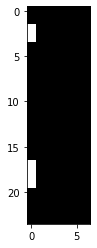

entered if
['H', 'H', 'I', '7', 'J']
H
saved an img H
60 74
[ 23  28  60  74  94 106 129 137 161]


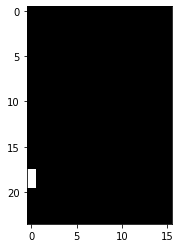

entered if
['H', 'H', 'I', '7', 'J']
H
saved an img H
94 106
[ 23  28  60  74  94 106 129 137 161]


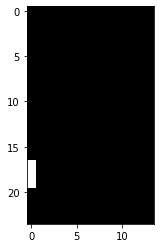

entered if
['H', 'H', 'I', '7', 'J']
I
saved an img I
129 137
[ 23  28  60  74  94 106 129 137 161]


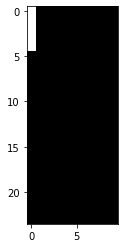

entered if
['H', 'H', 'I', '7', 'J']
7
saved an img 7
['I', '1', 'Y', 'F', 'X']
2 21
[  2  21  34  55  64  93 108 134 135 159]


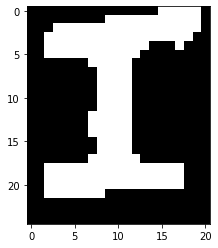

entered if
['I', '1', 'Y', 'F', 'X']
I
saved an img I
34 55
[  2  21  34  55  64  93 108 134 135 159]


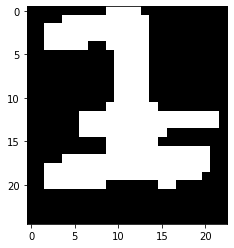

entered if
['I', '1', 'Y', 'F', 'X']
1
saved an img 1
64 93
[  2  21  34  55  64  93 108 134 135 159]


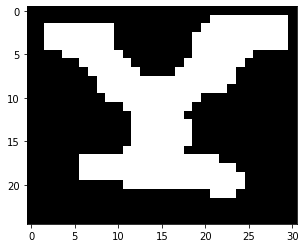

entered if
['I', '1', 'Y', 'F', 'X']
Y
saved an img Y
108 134
[  2  21  34  55  64  93 108 134 135 159]


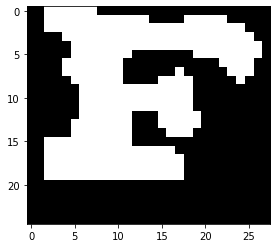

entered if
['I', '1', 'Y', 'F', 'X']
F
saved an img F
135 159
[  2  21  34  55  64  93 108 134 135 159]


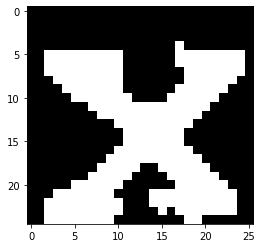

entered if
['I', '1', 'Y', 'F', 'X']
X
saved an img X
['I', '3', 'G', '6', 'C']
4 24
[  4  24  31  55  66  94 102 128 136 159]


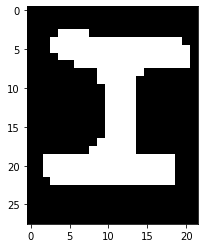

entered if
['I', '3', 'G', '6', 'C']
I
saved an img I
31 55
[  4  24  31  55  66  94 102 128 136 159]


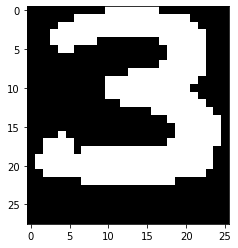

entered if
['I', '3', 'G', '6', 'C']
3
saved an img 3
66 94
[  4  24  31  55  66  94 102 128 136 159]


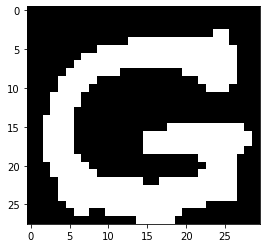

entered if
['I', '3', 'G', '6', 'C']
G
saved an img G
102 128
[  4  24  31  55  66  94 102 128 136 159]


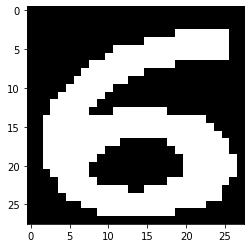

entered if
['I', '3', 'G', '6', 'C']
6
saved an img 6
136 159
[  4  24  31  55  66  94 102 128 136 159]


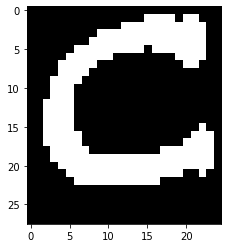

entered if
['I', '3', 'G', '6', 'C']
C
saved an img C
['I', '4', '6', 'Y', 'T']
5 23
[  5  23  32  55  67  90 101 129 134 158]


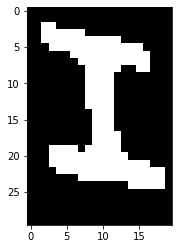

entered if
['I', '4', '6', 'Y', 'T']
I
saved an img I
32 55
[  5  23  32  55  67  90 101 129 134 158]


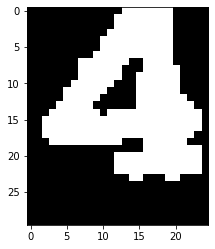

entered if
['I', '4', '6', 'Y', 'T']
4
saved an img 4
67 90
[  5  23  32  55  67  90 101 129 134 158]


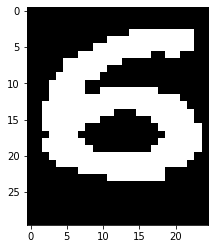

entered if
['I', '4', '6', 'Y', 'T']
6
saved an img 6
101 129
[  5  23  32  55  67  90 101 129 134 158]


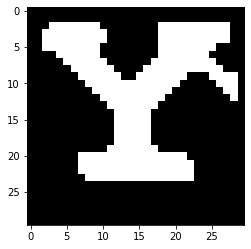

entered if
['I', '4', '6', 'Y', 'T']
Y
saved an img Y
134 158
[  5  23  32  55  67  90 101 129 134 158]


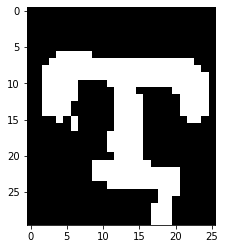

entered if
['I', '4', '6', 'Y', 'T']
T
saved an img T
['I', 'B', 'J', '1', '7']
6 28
[  6  28  31  60  66  97 105 127 136 156]


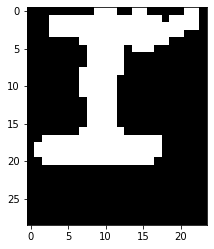

entered if
['I', 'B', 'J', '1', '7']
I
saved an img I
31 60
[  6  28  31  60  66  97 105 127 136 156]


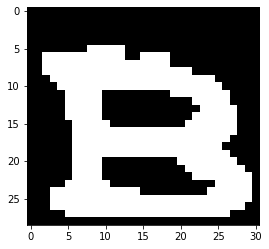

entered if
['I', 'B', 'J', '1', '7']
B
saved an img B
66 97
[  6  28  31  60  66  97 105 127 136 156]


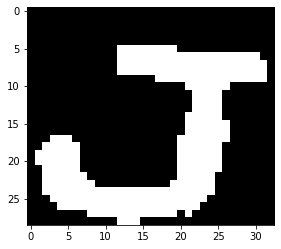

entered if
['I', 'B', 'J', '1', '7']
J
saved an img J
105 127
[  6  28  31  60  66  97 105 127 136 156]


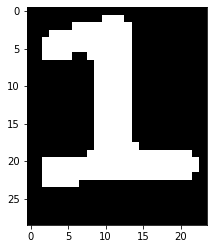

entered if
['I', 'B', 'J', '1', '7']
1
saved an img 1
136 156
[  6  28  31  60  66  97 105 127 136 156]


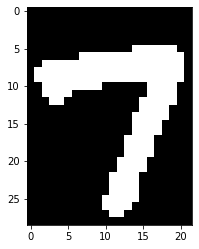

entered if
['I', 'B', 'J', '1', '7']
7
saved an img 7
['I', 'D', 'R', 'O', '1']
2 22
[  2  22  24  58  67  98 102 126 141 158]


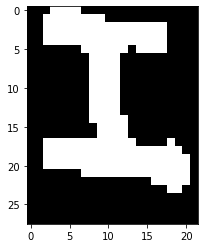

entered if
['I', 'D', 'R', 'O', '1']
I
saved an img I
24 58
[  2  22  24  58  67  98 102 126 141 158]


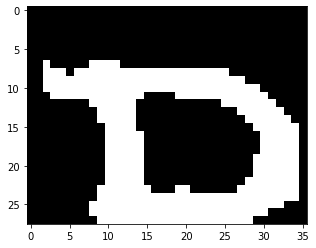

entered if
['I', 'D', 'R', 'O', '1']
D
saved an img D
67 98
[  2  22  24  58  67  98 102 126 141 158]


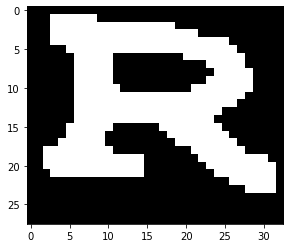

entered if
['I', 'D', 'R', 'O', '1']
R
saved an img R
102 126
[  2  22  24  58  67  98 102 126 141 158]


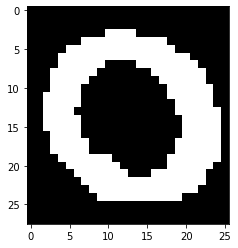

entered if
['I', 'D', 'R', 'O', '1']
O
saved an img O
141 158
[  2  22  24  58  67  98 102 126 141 158]


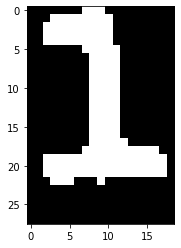

entered if
['I', 'D', 'R', 'O', '1']
1
saved an img 1
['I', 'D', 'W', 'M', 'H']
6 27
[  6  27  30  58  67  96 100 134 136 159]


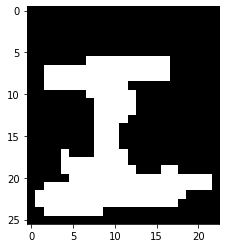

entered if
['I', 'D', 'W', 'M', 'H']
I
saved an img I
30 58
[  6  27  30  58  67  96 100 134 136 159]


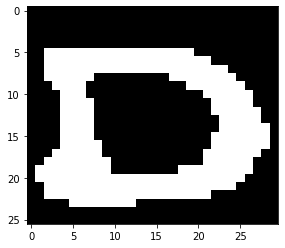

entered if
['I', 'D', 'W', 'M', 'H']
D
saved an img D
67 96
[  6  27  30  58  67  96 100 134 136 159]


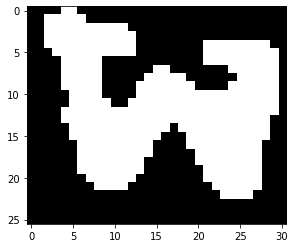

entered if
['I', 'D', 'W', 'M', 'H']
W
saved an img W
100 134
[  6  27  30  58  67  96 100 134 136 159]


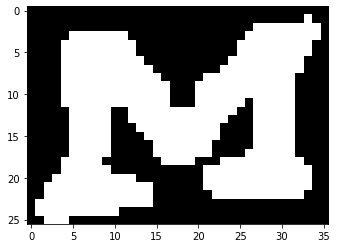

entered if
['I', 'D', 'W', 'M', 'H']
M
saved an img M
136 159
[  6  27  30  58  67  96 100 134 136 159]


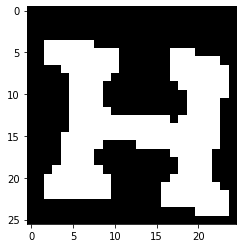

entered if
['I', 'D', 'W', 'M', 'H']
H
saved an img H
['I', 'H', 'L', 'L', 'H']
0 19
[  0  19  33  62  64  96 104 133 134 156]


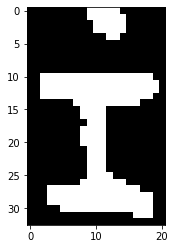

entered if
['I', 'H', 'L', 'L', 'H']
I
saved an img I
33 62
[  0  19  33  62  64  96 104 133 134 156]


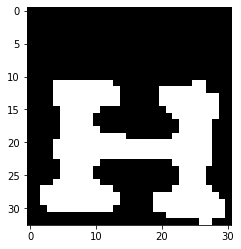

entered if
['I', 'H', 'L', 'L', 'H']
H
saved an img H
64 96
[  0  19  33  62  64  96 104 133 134 156]


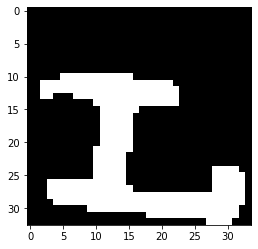

entered if
['I', 'H', 'L', 'L', 'H']
L
saved an img L
104 133
[  0  19  33  62  64  96 104 133 134 156]


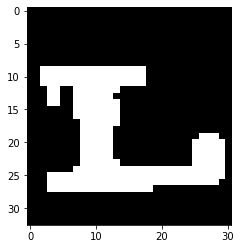

entered if
['I', 'H', 'L', 'L', 'H']
L
saved an img L
134 156
[  0  19  33  62  64  96 104 133 134 156]


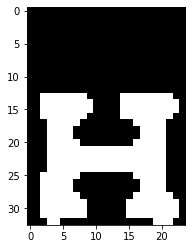

entered if
['I', 'H', 'L', 'L', 'H']
H
saved an img H
['I', 'I', 'X', '8', 'F']
5 20
[  5  20  33  56  65  97 105 129 137 160]


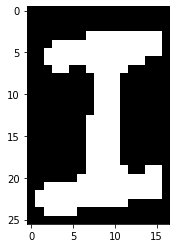

entered if
['I', 'I', 'X', '8', 'F']
I
saved an img I
33 56
[  5  20  33  56  65  97 105 129 137 160]


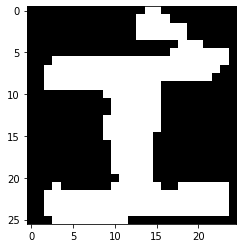

entered if
['I', 'I', 'X', '8', 'F']
I
saved an img I
65 97
[  5  20  33  56  65  97 105 129 137 160]


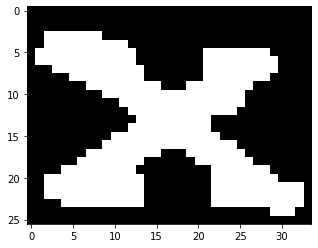

entered if
['I', 'I', 'X', '8', 'F']
X
saved an img X
105 129
[  5  20  33  56  65  97 105 129 137 160]


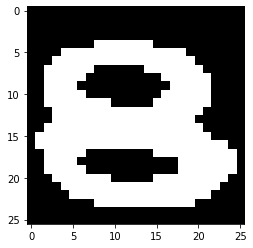

entered if
['I', 'I', 'X', '8', 'F']
8
saved an img 8
137 160
[  5  20  33  56  65  97 105 129 137 160]


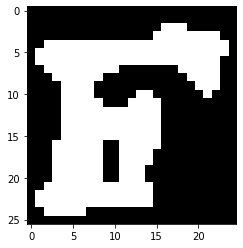

entered if
['I', 'I', 'X', '8', 'F']
F
saved an img F
['I', 'J', 'C', 'P', 'B']
2 27
[  2  27  29  58  67  96 102 130 132 157]


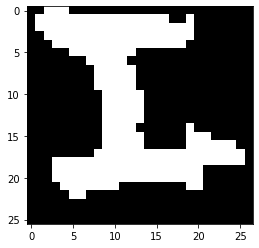

entered if
['I', 'J', 'C', 'P', 'B']
I
saved an img I
29 58
[  2  27  29  58  67  96 102 130 132 157]


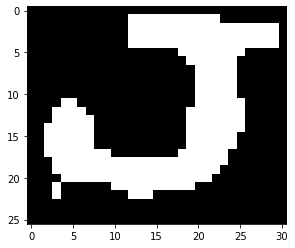

entered if
['I', 'J', 'C', 'P', 'B']
J
saved an img J
67 96
[  2  27  29  58  67  96 102 130 132 157]


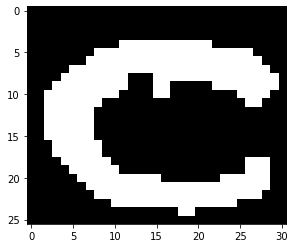

entered if
['I', 'J', 'C', 'P', 'B']
C
saved an img C
102 130
[  2  27  29  58  67  96 102 130 132 157]


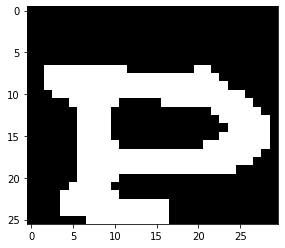

entered if
['I', 'J', 'C', 'P', 'B']
P
saved an img P
132 157
[  2  27  29  58  67  96 102 130 132 157]


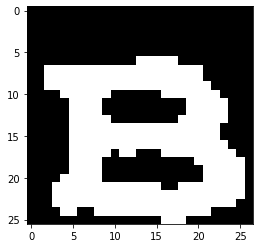

entered if
['I', 'J', 'C', 'P', 'B']
B
saved an img B
['I', 'Q', 'Q', 'K', '2']
1 23
[  1  23  28  59  64  98 101 133 136 157]


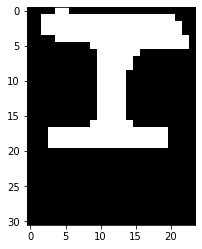

entered if
['I', 'Q', 'Q', 'K', '2']
I
saved an img I
28 59
[  1  23  28  59  64  98 101 133 136 157]


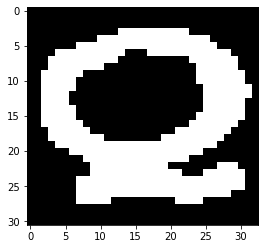

entered if
['I', 'Q', 'Q', 'K', '2']
Q
saved an img Q
64 98
[  1  23  28  59  64  98 101 133 136 157]


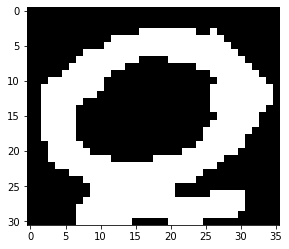

entered if
['I', 'Q', 'Q', 'K', '2']
Q
saved an img Q
101 133
[  1  23  28  59  64  98 101 133 136 157]


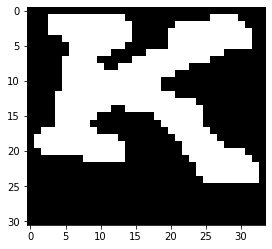

entered if
['I', 'Q', 'Q', 'K', '2']
K
saved an img K
136 157
[  1  23  28  59  64  98 101 133 136 157]


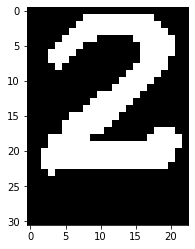

entered if
['I', 'Q', 'Q', 'K', '2']
2
saved an img 2
['I', 'S', '2', '9', '0']
3 21
[  3  21  34  61  68  91 106 131 134 165]


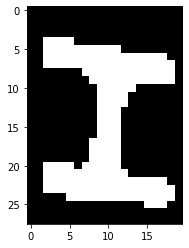

entered if
['I', 'S', '2', '9', '0']
I
saved an img I
34 61
[  3  21  34  61  68  91 106 131 134 165]


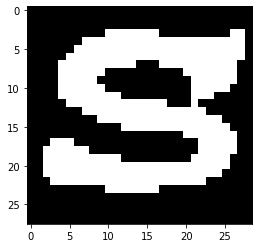

entered if
['I', 'S', '2', '9', '0']
S
saved an img S
68 91
[  3  21  34  61  68  91 106 131 134 165]


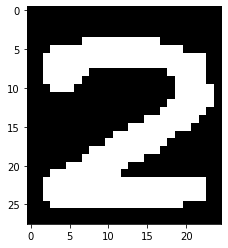

entered if
['I', 'S', '2', '9', '0']
2
saved an img 2
106 131
[  3  21  34  61  68  91 106 131 134 165]


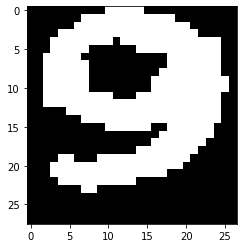

entered if
['I', 'S', '2', '9', '0']
9
saved an img 9
134 165
[  3  21  34  61  68  91 106 131 134 165]


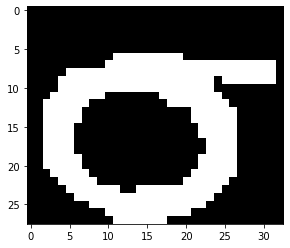

entered if
['I', 'S', '2', '9', '0']
0
saved an img 0
['I', 'S', 'M', 'J', 'Y']
7 25
[  7  25  31  97 104 133 136 161]


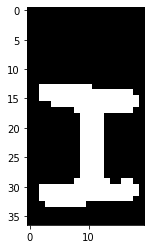

entered if
['I', 'S', 'M', 'J', 'Y']
I
saved an img I
31 97
[  7  25  31  97 104 133 136 161]


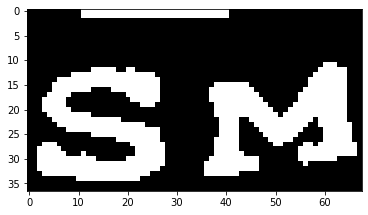

entered if
['I', 'S', 'M', 'J', 'Y']
S
saved an img S
104 133
[  7  25  31  97 104 133 136 161]


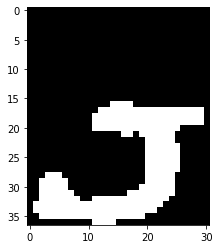

entered if
['I', 'S', 'M', 'J', 'Y']
M
saved an img M
136 161
[  7  25  31  97 104 133 136 161]


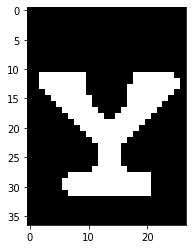

entered if
['I', 'S', 'M', 'J', 'Y']
J
saved an img J
['I', 'V', 'U', '1', 'L']
2 22
[  2  22  29  62  68  97 105 127 135 160]


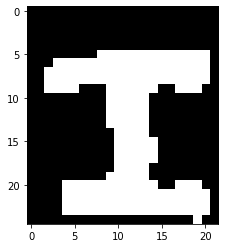

entered if
['I', 'V', 'U', '1', 'L']
I
saved an img I
29 62
[  2  22  29  62  68  97 105 127 135 160]


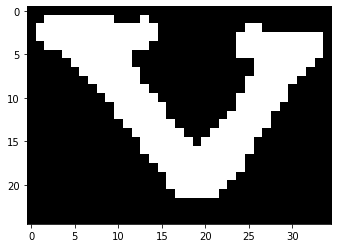

entered if
['I', 'V', 'U', '1', 'L']
V
saved an img V
68 97
[  2  22  29  62  68  97 105 127 135 160]


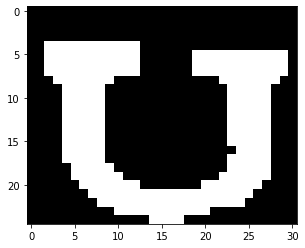

entered if
['I', 'V', 'U', '1', 'L']
U
saved an img U
105 127
[  2  22  29  62  68  97 105 127 135 160]


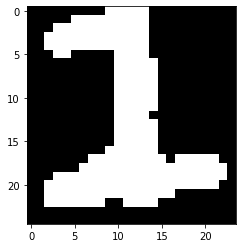

entered if
['I', 'V', 'U', '1', 'L']
1
saved an img 1
135 160
[  2  22  29  62  68  97 105 127 135 160]


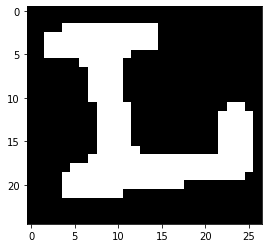

entered if
['I', 'V', 'U', '1', 'L']
L
saved an img L
['I', 'W', '9', '5', 'W']
3 21
[  3  21  31  59  72  97 104 130 136 163]


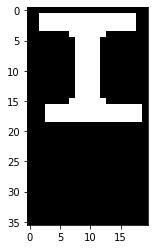

entered if
['I', 'W', '9', '5', 'W']
I
saved an img I
31 59
[  3  21  31  59  72  97 104 130 136 163]


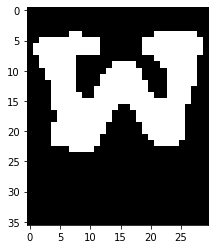

entered if
['I', 'W', '9', '5', 'W']
W
saved an img W
72 97
[  3  21  31  59  72  97 104 130 136 163]


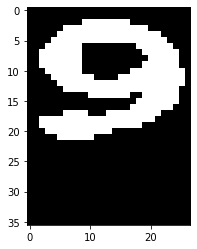

entered if
['I', 'W', '9', '5', 'W']
9
saved an img 9
104 130
[  3  21  31  59  72  97 104 130 136 163]


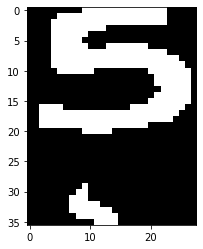

entered if
['I', 'W', '9', '5', 'W']
5
saved an img 5
136 163
[  3  21  31  59  72  97 104 130 136 163]


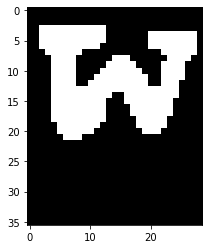

entered if
['I', 'W', '9', '5', 'W']
W
saved an img W
['I', 'W', 'Q', 'U', '2']
4 22
[  4  22  31  60  66  99 100 131 137 158]


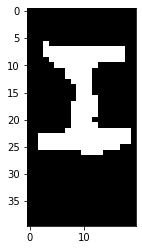

entered if
['I', 'W', 'Q', 'U', '2']
I
saved an img I
31 60
[  4  22  31  60  66  99 100 131 137 158]


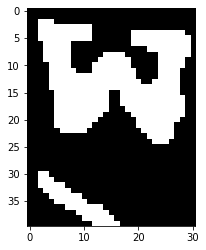

entered if
['I', 'W', 'Q', 'U', '2']
W
saved an img W
66 99
[  4  22  31  60  66  99 100 131 137 158]


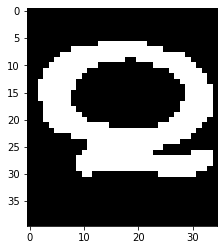

entered if
['I', 'W', 'Q', 'U', '2']
Q
saved an img Q
100 131
[  4  22  31  60  66  99 100 131 137 158]


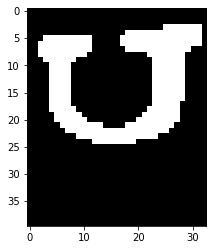

entered if
['I', 'W', 'Q', 'U', '2']
U
saved an img U
137 158
[  4  22  31  60  66  99 100 131 137 158]


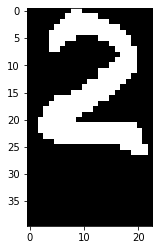

entered if
['I', 'W', 'Q', 'U', '2']
2
saved an img 2
['I', 'Z', '2', 'K', 'V']
1 19
[  1  19  32  59  60  90 103 132 134 162]


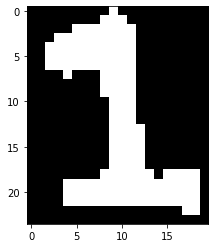

entered if
['I', 'Z', '2', 'K', 'V']
I
saved an img I
32 59
[  1  19  32  59  60  90 103 132 134 162]


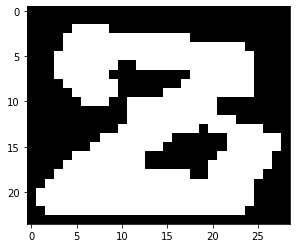

entered if
['I', 'Z', '2', 'K', 'V']
Z
saved an img Z
60 90
[  1  19  32  59  60  90 103 132 134 162]


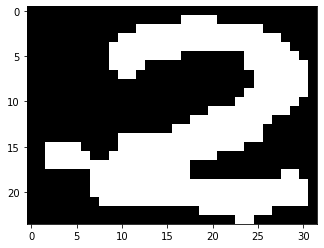

entered if
['I', 'Z', '2', 'K', 'V']
2
saved an img 2
103 132
[  1  19  32  59  60  90 103 132 134 162]


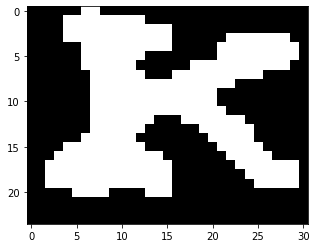

entered if
['I', 'Z', '2', 'K', 'V']
K
saved an img K
134 162
[  1  19  32  59  60  90 103 132 134 162]


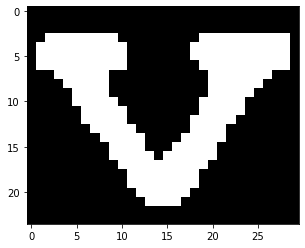

entered if
['I', 'Z', '2', 'K', 'V']
V
saved an img V
['J', '4', '6', '7', 'H']
2 26
[  2  26  32  59  70  94 103 128 136 159]


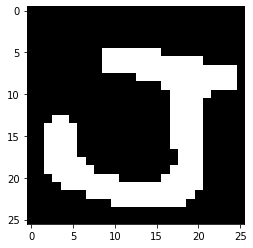

entered if
['J', '4', '6', '7', 'H']
J
saved an img J
32 59
[  2  26  32  59  70  94 103 128 136 159]


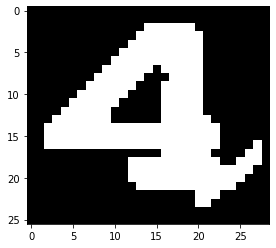

entered if
['J', '4', '6', '7', 'H']
4
saved an img 4
70 94
[  2  26  32  59  70  94 103 128 136 159]


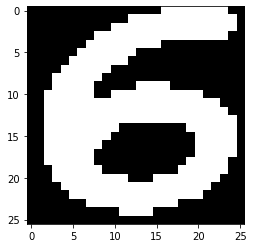

entered if
['J', '4', '6', '7', 'H']
6
saved an img 6
103 128
[  2  26  32  59  70  94 103 128 136 159]


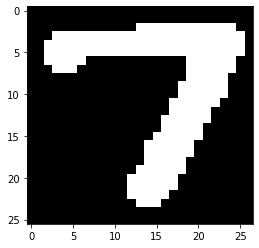

entered if
['J', '4', '6', '7', 'H']
7
saved an img 7
136 159
[  2  26  32  59  70  94 103 128 136 159]


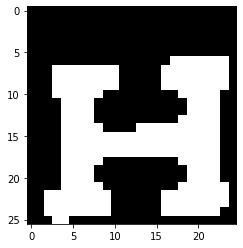

entered if
['J', '4', '6', '7', 'H']
H
saved an img H
['J', '6', 'B', 'X', 'B']
23 31
[ 23  31  56  67  95 100 132 136 160]


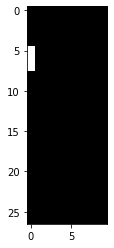

entered if
['J', '6', 'B', 'X', 'B']
J
saved an img J
56 67
[ 23  31  56  67  95 100 132 136 160]


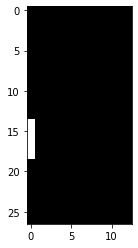

entered if
['J', '6', 'B', 'X', 'B']
6
saved an img 6
95 100
[ 23  31  56  67  95 100 132 136 160]


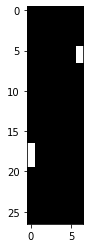

entered if
['J', '6', 'B', 'X', 'B']
B
saved an img B
132 136
[ 23  31  56  67  95 100 132 136 160]


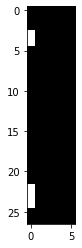

entered if
['J', '6', 'B', 'X', 'B']
X
saved an img X
['J', '8', '6', 'G', 'Z']
3 4
[  3   4  28  35  59  73  94 102 134 137 157]


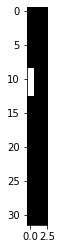

entered if
['J', '8', '6', 'G', 'Z']
J
saved an img J
28 35
[  3   4  28  35  59  73  94 102 134 137 157]


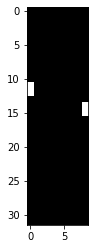

entered if
['J', '8', '6', 'G', 'Z']
8
saved an img 8
59 73
[  3   4  28  35  59  73  94 102 134 137 157]


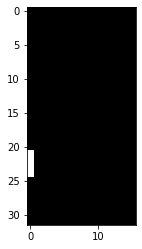

entered if
['J', '8', '6', 'G', 'Z']
6
saved an img 6
94 102
[  3   4  28  35  59  73  94 102 134 137 157]


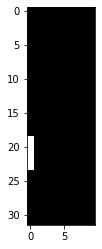

entered if
['J', '8', '6', 'G', 'Z']
G
saved an img G
134 137
[  3   4  28  35  59  73  94 102 134 137 157]


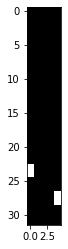

entered if
['J', '8', '6', 'G', 'Z']
Z
saved an img Z
['J', 'E', 'P', 'B', 'X']
26 29
[ 26  29  60  68  97 105 131 135 161]


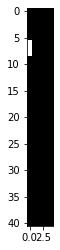

entered if
['J', 'E', 'P', 'B', 'X']
J
saved an img J
60 68
[ 26  29  60  68  97 105 131 135 161]


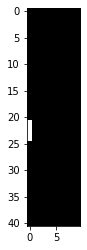

entered if
['J', 'E', 'P', 'B', 'X']
E
saved an img E
97 105
[ 26  29  60  68  97 105 131 135 161]


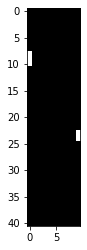

entered if
['J', 'E', 'P', 'B', 'X']
P
saved an img P
131 135
[ 26  29  60  68  97 105 131 135 161]


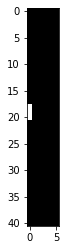

entered if
['J', 'E', 'P', 'B', 'X']
B
saved an img B
['J', 'H', '1', 'W', '9']
26 31
[ 26  31  61  67  94 101 133 140 158]


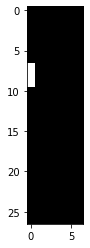

entered if
['J', 'H', '1', 'W', '9']
J
saved an img J
61 67
[ 26  31  61  67  94 101 133 140 158]


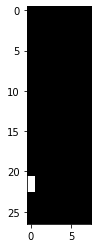

entered if
['J', 'H', '1', 'W', '9']
H
saved an img H
94 101
[ 26  31  61  67  94 101 133 140 158]


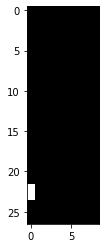

entered if
['J', 'H', '1', 'W', '9']
1
saved an img 1
133 140
[ 26  31  61  67  94 101 133 140 158]


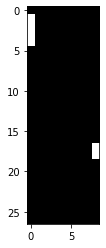

entered if
['J', 'H', '1', 'W', '9']
W
saved an img W
['J', 'I', '4', 'P', 'A']
4 26
[  4  26  31  54  64  88 103 131 137 160]


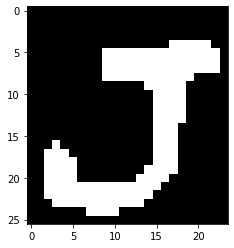

entered if
['J', 'I', '4', 'P', 'A']
J
saved an img J
31 54
[  4  26  31  54  64  88 103 131 137 160]


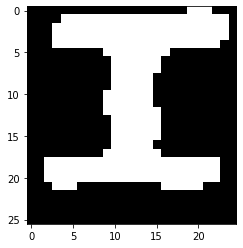

entered if
['J', 'I', '4', 'P', 'A']
I
saved an img I
64 88
[  4  26  31  54  64  88 103 131 137 160]


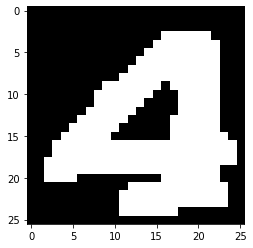

entered if
['J', 'I', '4', 'P', 'A']
4
saved an img 4
103 131
[  4  26  31  54  64  88 103 131 137 160]


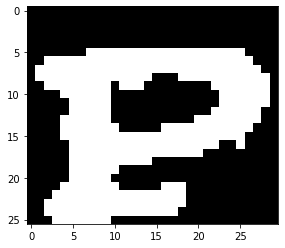

entered if
['J', 'I', '4', 'P', 'A']
P
saved an img P
137 160
[  4  26  31  54  64  88 103 131 137 160]


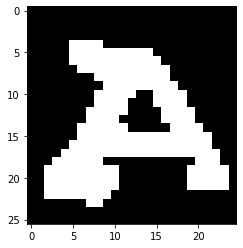

entered if
['J', 'I', '4', 'P', 'A']
A
saved an img A
['J', 'N', '3', 'N', 'L']
0 26
[  0  26  29  63  69  94 100]


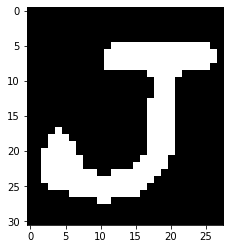

entered if
['J', 'N', '3', 'N', 'L']
J
saved an img J
29 63
[  0  26  29  63  69  94 100]


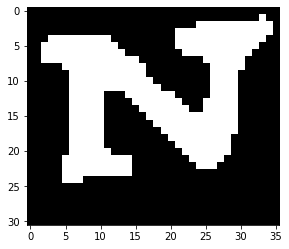

entered if
['J', 'N', '3', 'N', 'L']
N
saved an img N
69 94
[  0  26  29  63  69  94 100]


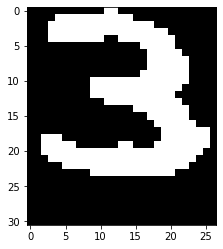

entered if
['J', 'N', '3', 'N', 'L']
3
saved an img 3
['J', 'P', 'J', '3', '6']
0 2
[  0   2  27  30  60  71  99 104 130 137 159]


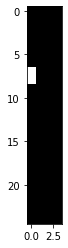

entered if
['J', 'P', 'J', '3', '6']
J
saved an img J
27 30
[  0   2  27  30  60  71  99 104 130 137 159]


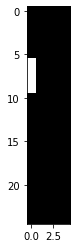

entered if
['J', 'P', 'J', '3', '6']
P
saved an img P
60 71
[  0   2  27  30  60  71  99 104 130 137 159]


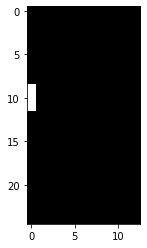

entered if
['J', 'P', 'J', '3', '6']
J
saved an img J
99 104
[  0   2  27  30  60  71  99 104 130 137 159]


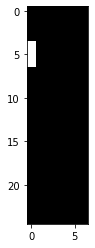

entered if
['J', 'P', 'J', '3', '6']
3
saved an img 3
130 137
[  0   2  27  30  60  71  99 104 130 137 159]


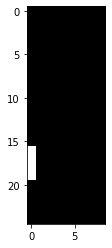

entered if
['J', 'P', 'J', '3', '6']
6
saved an img 6
['J', 'T', 'G', 'Q', 'M']
2 27
[  2  27  33  59  65  98 102 132 136 163]


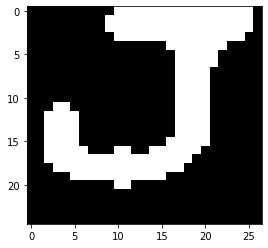

entered if
['J', 'T', 'G', 'Q', 'M']
J
saved an img J
33 59
[  2  27  33  59  65  98 102 132 136 163]


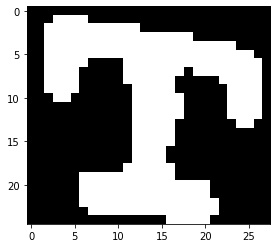

entered if
['J', 'T', 'G', 'Q', 'M']
T
saved an img T
65 98
[  2  27  33  59  65  98 102 132 136 163]


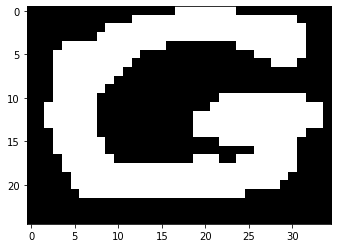

entered if
['J', 'T', 'G', 'Q', 'M']
G
saved an img G
102 132
[  2  27  33  59  65  98 102 132 136 163]


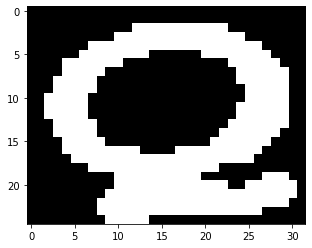

entered if
['J', 'T', 'G', 'Q', 'M']
Q
saved an img Q
136 163
[  2  27  33  59  65  98 102 132 136 163]


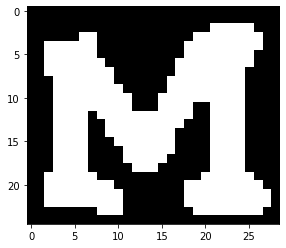

entered if
['J', 'T', 'G', 'Q', 'M']
M
saved an img M
['J', 'V', 'T', 'I', 'E']
2 27
[  2  27  30  62  65  95 104 130 133 161]


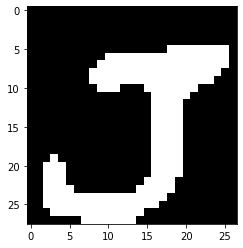

entered if
['J', 'V', 'T', 'I', 'E']
J
saved an img J
30 62
[  2  27  30  62  65  95 104 130 133 161]


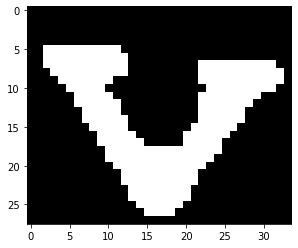

entered if
['J', 'V', 'T', 'I', 'E']
V
saved an img V
65 95
[  2  27  30  62  65  95 104 130 133 161]


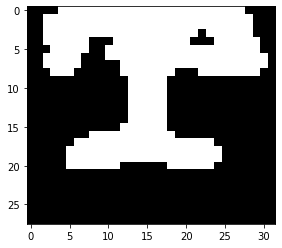

entered if
['J', 'V', 'T', 'I', 'E']
T
saved an img T
104 130
[  2  27  30  62  65  95 104 130 133 161]


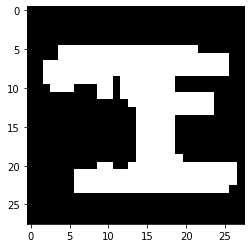

entered if
['J', 'V', 'T', 'I', 'E']
I
saved an img I
133 161
[  2  27  30  62  65  95 104 130 133 161]


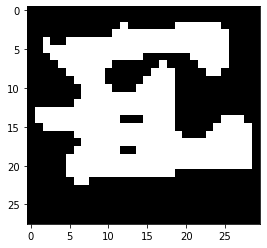

entered if
['J', 'V', 'T', 'I', 'E']
E
saved an img E
['J', 'W', 'K', 'P', 'L']
2 26
[  2  26  27  60  66  99 106 134 136 160]


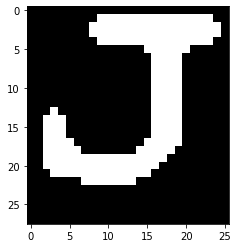

entered if
['J', 'W', 'K', 'P', 'L']
J
saved an img J
27 60
[  2  26  27  60  66  99 106 134 136 160]


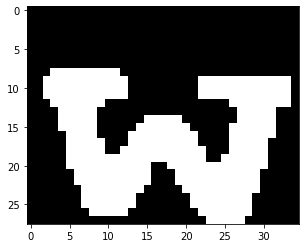

entered if
['J', 'W', 'K', 'P', 'L']
W
saved an img W
66 99
[  2  26  27  60  66  99 106 134 136 160]


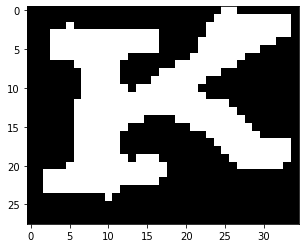

entered if
['J', 'W', 'K', 'P', 'L']
K
saved an img K
106 134
[  2  26  27  60  66  99 106 134 136 160]


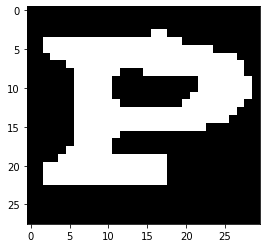

entered if
['J', 'W', 'K', 'P', 'L']
P
saved an img P
136 160
[  2  26  27  60  66  99 106 134 136 160]


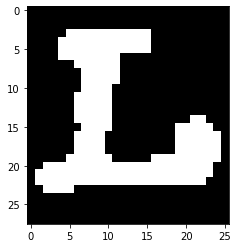

entered if
['J', 'W', 'K', 'P', 'L']
L
saved an img L
['J', 'X', 'X', 'L', 'L']
2 23
[  2  23  30  61  63  93 103 133 140 163]


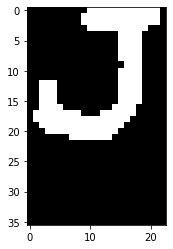

entered if
['J', 'X', 'X', 'L', 'L']
J
saved an img J
30 61
[  2  23  30  61  63  93 103 133 140 163]


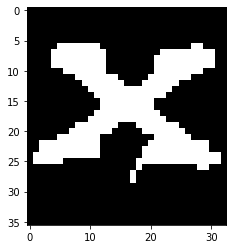

entered if
['J', 'X', 'X', 'L', 'L']
X
saved an img X
63 93
[  2  23  30  61  63  93 103 133 140 163]


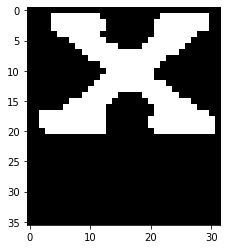

entered if
['J', 'X', 'X', 'L', 'L']
X
saved an img X
103 133
[  2  23  30  61  63  93 103 133 140 163]


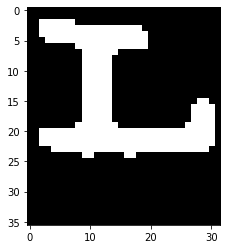

entered if
['J', 'X', 'X', 'L', 'L']
L
saved an img L
140 163
[  2  23  30  61  63  93 103 133 140 163]


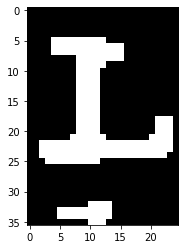

entered if
['J', 'X', 'X', 'L', 'L']
L
saved an img L
['K', '2', 'Y', '8', 'U']
27 31
[ 27  31  96 105 129 134 158]


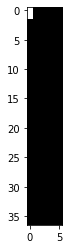

entered if
['K', '2', 'Y', '8', 'U']
K
saved an img K
96 105
[ 27  31  96 105 129 134 158]


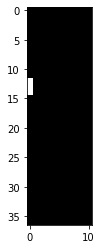

entered if
['K', '2', 'Y', '8', 'U']
2
saved an img 2
129 134
[ 27  31  96 105 129 134 158]


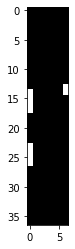

entered if
['K', '2', 'Y', '8', 'U']
Y
saved an img Y
['K', '8', 'K', '7', 'Z']
24 32
[ 24  32  57  65 101 103 129 135 155]


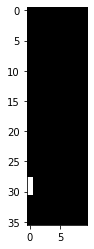

entered if
['K', '8', 'K', '7', 'Z']
K
saved an img K
57 65
[ 24  32  57  65 101 103 129 135 155]


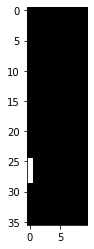

entered if
['K', '8', 'K', '7', 'Z']
8
saved an img 8
101 103
[ 24  32  57  65 101 103 129 135 155]


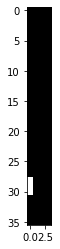

entered if
['K', '8', 'K', '7', 'Z']
K
saved an img K
129 135
[ 24  32  57  65 101 103 129 135 155]


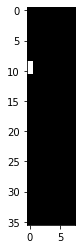

entered if
['K', '8', 'K', '7', 'Z']
7
saved an img 7
['K', 'D', 'K', 'U', '1']
0 25
[  0  25  31  60  66  97 101 132 139 157]


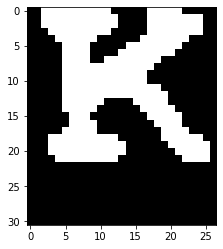

entered if
['K', 'D', 'K', 'U', '1']
K
saved an img K
31 60
[  0  25  31  60  66  97 101 132 139 157]


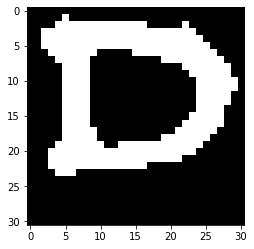

entered if
['K', 'D', 'K', 'U', '1']
D
saved an img D
66 97
[  0  25  31  60  66  97 101 132 139 157]


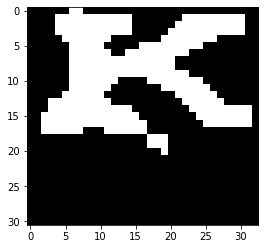

entered if
['K', 'D', 'K', 'U', '1']
K
saved an img K
101 132
[  0  25  31  60  66  97 101 132 139 157]


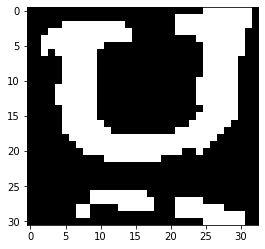

entered if
['K', 'D', 'K', 'U', '1']
U
saved an img U
139 157
[  0  25  31  60  66  97 101 132 139 157]


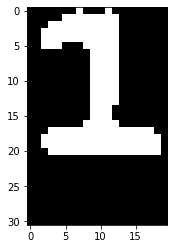

entered if
['K', 'D', 'K', 'U', '1']
1
saved an img 1
['K', 'E', 'F', 'T', '4']
56 68
[ 56  68  98 102 130 138 151 153 157]


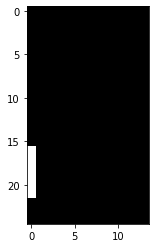

entered if
['K', 'E', 'F', 'T', '4']
K
saved an img K
98 102
[ 56  68  98 102 130 138 151 153 157]


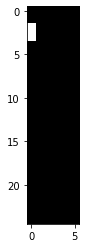

entered if
['K', 'E', 'F', 'T', '4']
E
saved an img E
130 138
[ 56  68  98 102 130 138 151 153 157]


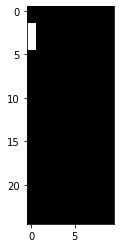

entered if
['K', 'E', 'F', 'T', '4']
F
saved an img F
151 153
[ 56  68  98 102 130 138 151 153 157]


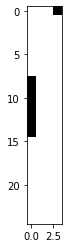

entered if
['K', 'E', 'F', 'T', '4']
T
saved an img T
['K', 'I', 'P', 'U', 'B']
23 32
[ 23  32  60  68 101 104 133 135 161]


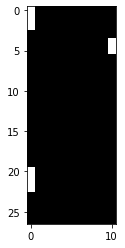

entered if
['K', 'I', 'P', 'U', 'B']
K
saved an img K
60 68
[ 23  32  60  68 101 104 133 135 161]


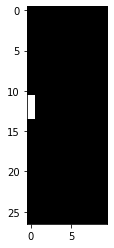

entered if
['K', 'I', 'P', 'U', 'B']
I
saved an img I
101 104
[ 23  32  60  68 101 104 133 135 161]


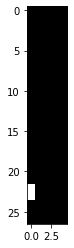

entered if
['K', 'I', 'P', 'U', 'B']
P
saved an img P
133 135
[ 23  32  60  68 101 104 133 135 161]


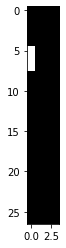

entered if
['K', 'I', 'P', 'U', 'B']
U
saved an img U
['K', 'T', '7', 'G', 'N']
23 27
[ 23  27  57  65  92  99 129 134 161]


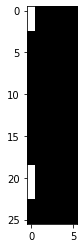

entered if
['K', 'T', '7', 'G', 'N']
K
saved an img K
57 65
[ 23  27  57  65  92  99 129 134 161]


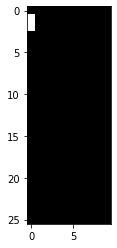

entered if
['K', 'T', '7', 'G', 'N']
T
saved an img T
92 99
[ 23  27  57  65  92  99 129 134 161]


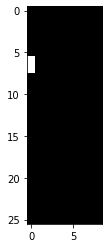

entered if
['K', 'T', '7', 'G', 'N']
7
saved an img 7
129 134
[ 23  27  57  65  92  99 129 134 161]


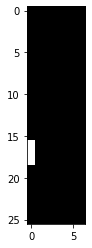

entered if
['K', 'T', '7', 'G', 'N']
G
saved an img G
['L', '0', '8', '5', 'J']
1 23
[  1  23  34  57  69  91 104 129 137 159]


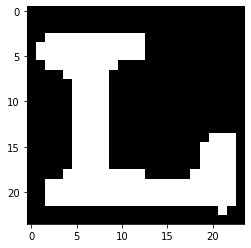

entered if
['L', '0', '8', '5', 'J']
L
saved an img L
34 57
[  1  23  34  57  69  91 104 129 137 159]


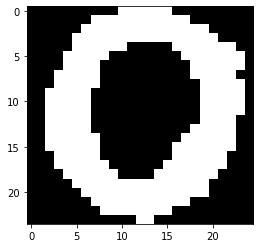

entered if
['L', '0', '8', '5', 'J']
0
saved an img 0
69 91
[  1  23  34  57  69  91 104 129 137 159]


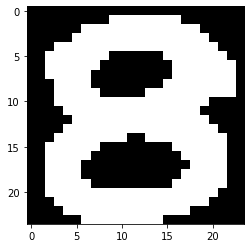

entered if
['L', '0', '8', '5', 'J']
8
saved an img 8
104 129
[  1  23  34  57  69  91 104 129 137 159]


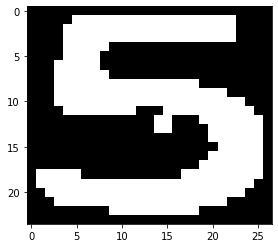

entered if
['L', '0', '8', '5', 'J']
5
saved an img 5
137 159
[  1  23  34  57  69  91 104 129 137 159]


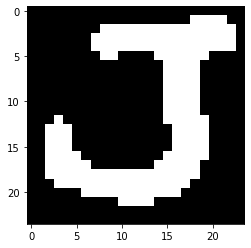

entered if
['L', '0', '8', '5', 'J']
J
saved an img J
['L', '3', '8', 'Z', 'A']
4 24
[  4  24  33  57  70  95 102 129 134 162]


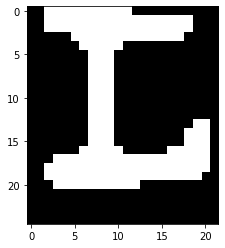

entered if
['L', '3', '8', 'Z', 'A']
L
saved an img L
33 57
[  4  24  33  57  70  95 102 129 134 162]


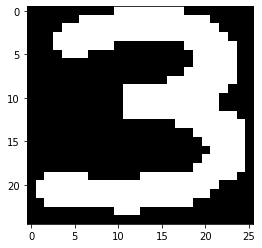

entered if
['L', '3', '8', 'Z', 'A']
3
saved an img 3
70 95
[  4  24  33  57  70  95 102 129 134 162]


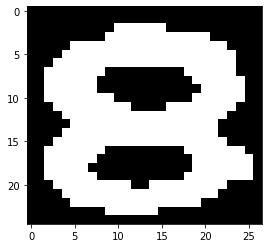

entered if
['L', '3', '8', 'Z', 'A']
8
saved an img 8
102 129
[  4  24  33  57  70  95 102 129 134 162]


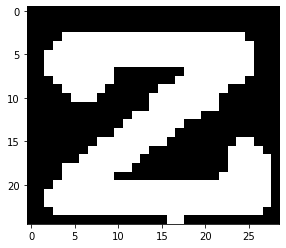

entered if
['L', '3', '8', 'Z', 'A']
Z
saved an img Z
134 162
[  4  24  33  57  70  95 102 129 134 162]


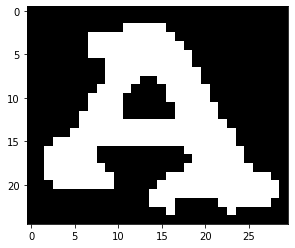

entered if
['L', '3', '8', 'Z', 'A']
A
saved an img A
['L', '5', 'F', '1', '4']
2 26
[  2  26  32  63  65  97 106 128 137 157]


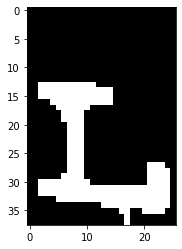

entered if
['L', '5', 'F', '1', '4']
L
saved an img L
32 63
[  2  26  32  63  65  97 106 128 137 157]


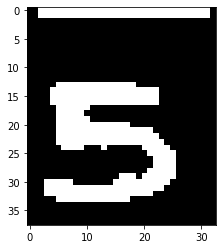

entered if
['L', '5', 'F', '1', '4']
5
saved an img 5
65 97
[  2  26  32  63  65  97 106 128 137 157]


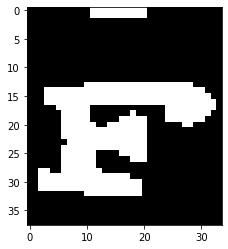

entered if
['L', '5', 'F', '1', '4']
F
saved an img F
106 128
[  2  26  32  63  65  97 106 128 137 157]


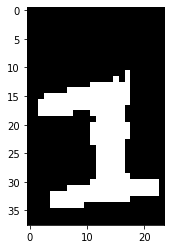

entered if
['L', '5', 'F', '1', '4']
1
saved an img 1
137 157
[  2  26  32  63  65  97 106 128 137 157]


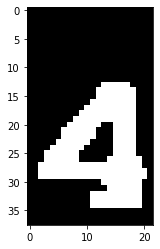

entered if
['L', '5', 'F', '1', '4']
4
saved an img 4
['L', '8', 'J', 'I', '6']
0 24
[  0  24  31  57  64  95 103 128 136 157]


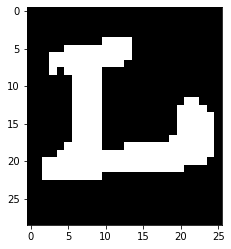

entered if
['L', '8', 'J', 'I', '6']
L
saved an img L
31 57
[  0  24  31  57  64  95 103 128 136 157]


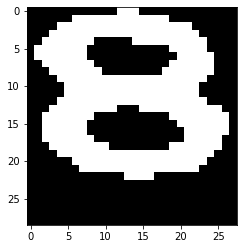

entered if
['L', '8', 'J', 'I', '6']
8
saved an img 8
64 95
[  0  24  31  57  64  95 103 128 136 157]


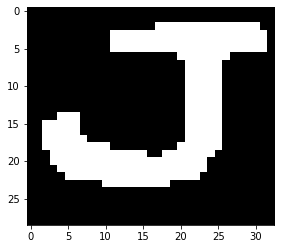

entered if
['L', '8', 'J', 'I', '6']
J
saved an img J
103 128
[  0  24  31  57  64  95 103 128 136 157]


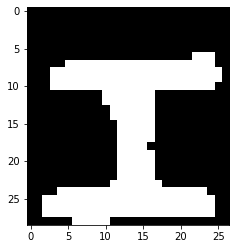

entered if
['L', '8', 'J', 'I', '6']
I
saved an img I
136 157
[  0  24  31  57  64  95 103 128 136 157]


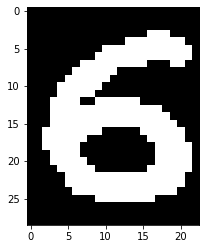

entered if
['L', '8', 'J', 'I', '6']
6
saved an img 6
['L', 'A', 'S', '6', 'P']
61 65
[ 61  65  93 107 130 138 161]


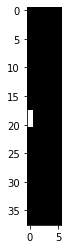

entered if
['L', 'A', 'S', '6', 'P']
L
saved an img L
93 107
[ 61  65  93 107 130 138 161]


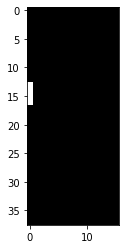

entered if
['L', 'A', 'S', '6', 'P']
A
saved an img A
130 138
[ 61  65  93 107 130 138 161]


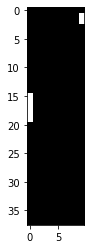

entered if
['L', 'A', 'S', '6', 'P']
S
saved an img S
['L', 'G', '5', 'R', 'C']
1 23
[  1  23  30  59  69  93  99 135 138 162 163]


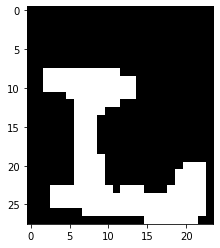

entered if
['L', 'G', '5', 'R', 'C']
L
saved an img L
30 59
[  1  23  30  59  69  93  99 135 138 162 163]


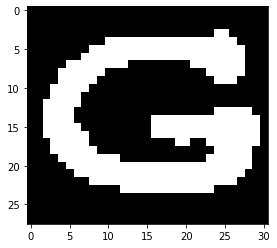

entered if
['L', 'G', '5', 'R', 'C']
G
saved an img G
69 93
[  1  23  30  59  69  93  99 135 138 162 163]


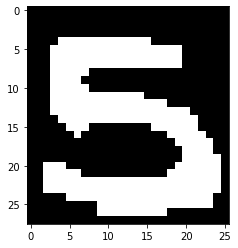

entered if
['L', 'G', '5', 'R', 'C']
5
saved an img 5
99 135
[  1  23  30  59  69  93  99 135 138 162 163]


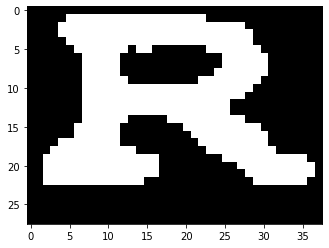

entered if
['L', 'G', '5', 'R', 'C']
R
saved an img R
138 162
[  1  23  30  59  69  93  99 135 138 162 163]


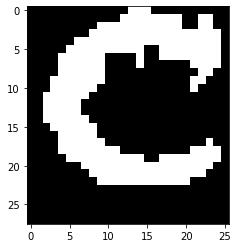

entered if
['L', 'G', '5', 'R', 'C']
C
saved an img C
['L', 'G', 'B', '5', 'L']
1 26
[  1  26  29  59  65  97 105 131 139 160]


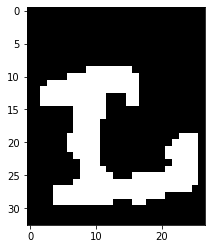

entered if
['L', 'G', 'B', '5', 'L']
L
saved an img L
29 59
[  1  26  29  59  65  97 105 131 139 160]


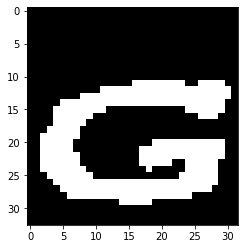

entered if
['L', 'G', 'B', '5', 'L']
G
saved an img G
65 97
[  1  26  29  59  65  97 105 131 139 160]


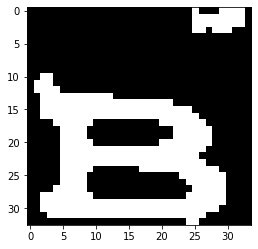

entered if
['L', 'G', 'B', '5', 'L']
B
saved an img B
105 131
[  1  26  29  59  65  97 105 131 139 160]


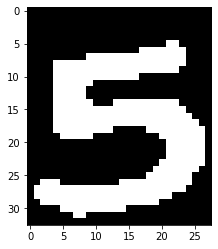

entered if
['L', 'G', 'B', '5', 'L']
5
saved an img 5
139 160
[  1  26  29  59  65  97 105 131 139 160]


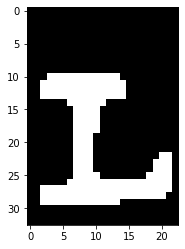

entered if
['L', 'G', 'B', '5', 'L']
L
saved an img L
['L', 'I', 'E', '5', 'H']
22 30
[ 22  30  53  68  97 103 131 134 158]


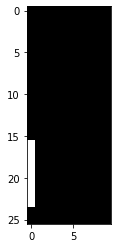

entered if
['L', 'I', 'E', '5', 'H']
L
saved an img L
53 68
[ 22  30  53  68  97 103 131 134 158]


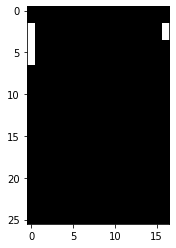

entered if
['L', 'I', 'E', '5', 'H']
I
saved an img I
97 103
[ 22  30  53  68  97 103 131 134 158]


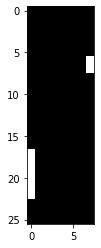

entered if
['L', 'I', 'E', '5', 'H']
E
saved an img E
131 134
[ 22  30  53  68  97 103 131 134 158]


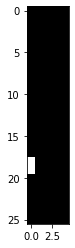

entered if
['L', 'I', 'E', '5', 'H']
5
saved an img 5
['L', 'I', 'G', 'L', 'B']
24 32
[ 24  32  61  66  98 102 159]


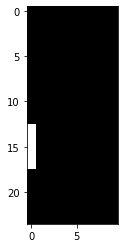

entered if
['L', 'I', 'G', 'L', 'B']
L
saved an img L
61 66
[ 24  32  61  66  98 102 159]


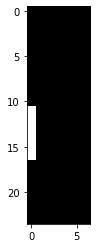

entered if
['L', 'I', 'G', 'L', 'B']
I
saved an img I
98 102
[ 24  32  61  66  98 102 159]


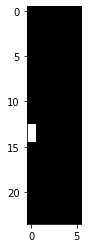

entered if
['L', 'I', 'G', 'L', 'B']
G
saved an img G
['L', 'J', 'N', 'T', 'O']
1 58
[  1  58  65  96 108 135 136 161]


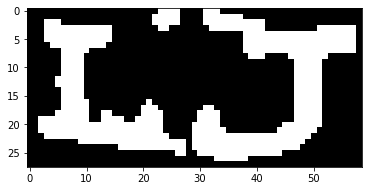

entered if
['L', 'J', 'N', 'T', 'O']
L
saved an img L
65 96
[  1  58  65  96 108 135 136 161]


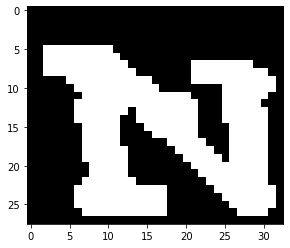

entered if
['L', 'J', 'N', 'T', 'O']
J
saved an img J
108 135
[  1  58  65  96 108 135 136 161]


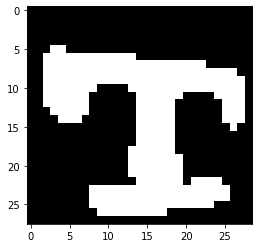

entered if
['L', 'J', 'N', 'T', 'O']
N
saved an img N
136 161
[  1  58  65  96 108 135 136 161]


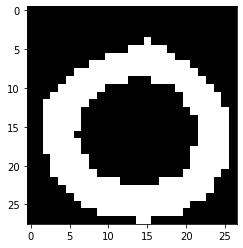

entered if
['L', 'J', 'N', 'T', 'O']
T
saved an img T
['L', 'J', 'X', 'X', '5']
2 25
[  2  25  32  94 101 133 135 156]


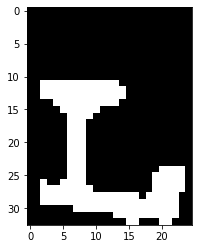

entered if
['L', 'J', 'X', 'X', '5']
L
saved an img L
32 94
[  2  25  32  94 101 133 135 156]


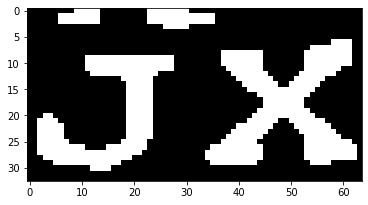

entered if
['L', 'J', 'X', 'X', '5']
J
saved an img J
101 133
[  2  25  32  94 101 133 135 156]


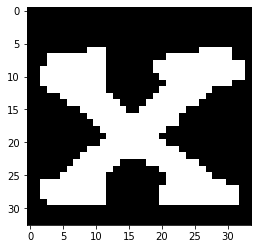

entered if
['L', 'J', 'X', 'X', '5']
X
saved an img X
135 156
[  2  25  32  94 101 133 135 156]


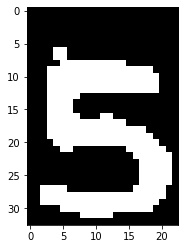

entered if
['L', 'J', 'X', 'X', '5']
X
saved an img X
['L', 'K', 'A', 'O', 'A']
3 26
[  3  26  31  60  64 132 138 163]


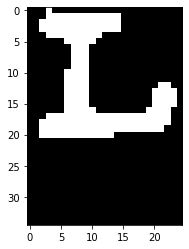

entered if
['L', 'K', 'A', 'O', 'A']
L
saved an img L
31 60
[  3  26  31  60  64 132 138 163]


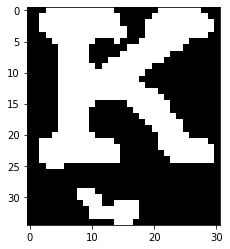

entered if
['L', 'K', 'A', 'O', 'A']
K
saved an img K
64 132
[  3  26  31  60  64 132 138 163]


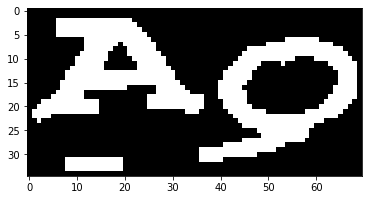

entered if
['L', 'K', 'A', 'O', 'A']
A
saved an img A
138 163
[  3  26  31  60  64 132 138 163]


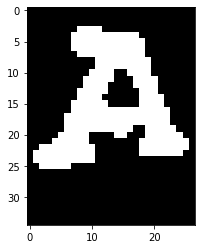

entered if
['L', 'K', 'A', 'O', 'A']
O
saved an img O
['L', 'M', 'T', '5', '6']
63 67
[ 63  67  96 101 126 138 159]


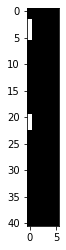

entered if
['L', 'M', 'T', '5', '6']
L
saved an img L
96 101
[ 63  67  96 101 126 138 159]


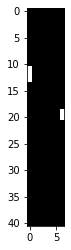

entered if
['L', 'M', 'T', '5', '6']
M
saved an img M
126 138
[ 63  67  96 101 126 138 159]


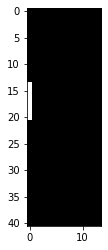

entered if
['L', 'M', 'T', '5', '6']
T
saved an img T
['L', 'Q', 'Z', 'K', 'V']
0 24
[  0  24  28  66  68  93  99 130 133 160]


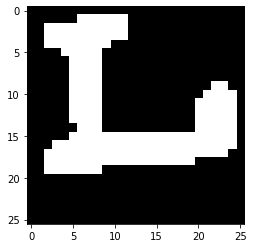

entered if
['L', 'Q', 'Z', 'K', 'V']
L
saved an img L
28 66
[  0  24  28  66  68  93  99 130 133 160]


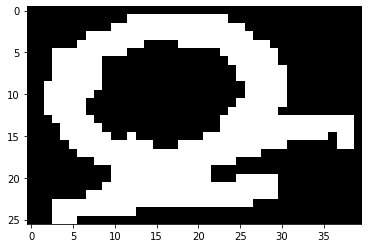

entered if
['L', 'Q', 'Z', 'K', 'V']
Q
saved an img Q
68 93
[  0  24  28  66  68  93  99 130 133 160]


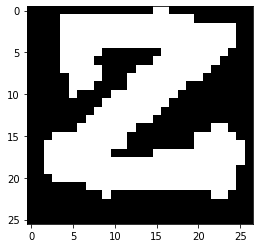

entered if
['L', 'Q', 'Z', 'K', 'V']
Z
saved an img Z
99 130
[  0  24  28  66  68  93  99 130 133 160]


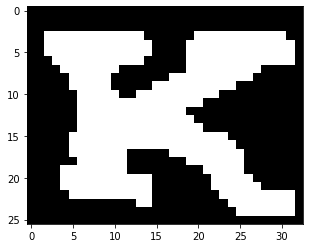

entered if
['L', 'Q', 'Z', 'K', 'V']
K
saved an img K
133 160
[  0  24  28  66  68  93  99 130 133 160]


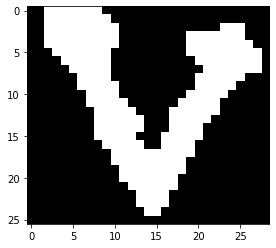

entered if
['L', 'Q', 'Z', 'K', 'V']
V
saved an img V
['L', 'T', 'I', 'X', 'O']
2 24
[  2  24  31  59  68  93 100 132 138 158]


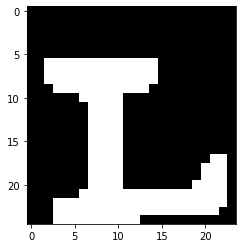

entered if
['L', 'T', 'I', 'X', 'O']
L
saved an img L
31 59
[  2  24  31  59  68  93 100 132 138 158]


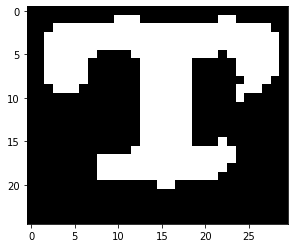

entered if
['L', 'T', 'I', 'X', 'O']
T
saved an img T
68 93
[  2  24  31  59  68  93 100 132 138 158]


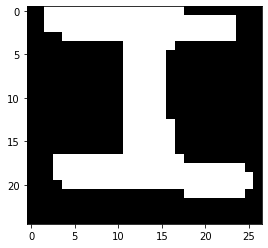

entered if
['L', 'T', 'I', 'X', 'O']
I
saved an img I
100 132
[  2  24  31  59  68  93 100 132 138 158]


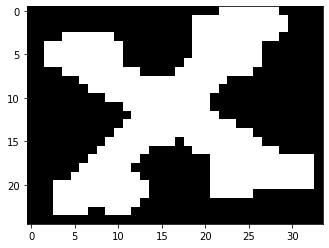

entered if
['L', 'T', 'I', 'X', 'O']
X
saved an img X
138 158
[  2  24  31  59  68  93 100 132 138 158]


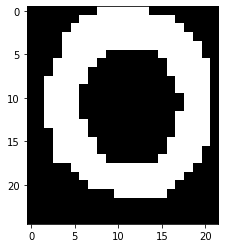

entered if
['L', 'T', 'I', 'X', 'O']
O
saved an img O
['L', 'U', 'P', 'T', 'Z']
23 28
[ 23  28  59  63  94 101 133 139 159]


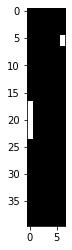

entered if
['L', 'U', 'P', 'T', 'Z']
L
saved an img L
59 63
[ 23  28  59  63  94 101 133 139 159]


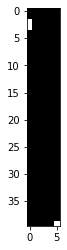

entered if
['L', 'U', 'P', 'T', 'Z']
U
saved an img U
94 101
[ 23  28  59  63  94 101 133 139 159]


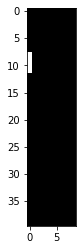

entered if
['L', 'U', 'P', 'T', 'Z']
P
saved an img P
133 139
[ 23  28  59  63  94 101 133 139 159]


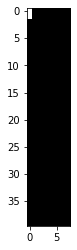

entered if
['L', 'U', 'P', 'T', 'Z']
T
saved an img T
['M', '3', '5', 'G', 'C']
31 34
[ 31  34  57  70  95 102 132 134 156]


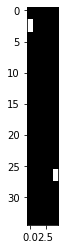

entered if
['M', '3', '5', 'G', 'C']
M
saved an img M
57 70
[ 31  34  57  70  95 102 132 134 156]


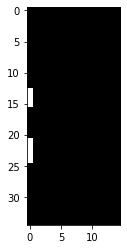

entered if
['M', '3', '5', 'G', 'C']
3
saved an img 3
95 102
[ 31  34  57  70  95 102 132 134 156]


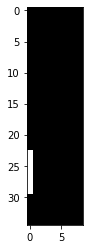

entered if
['M', '3', '5', 'G', 'C']
5
saved an img 5
132 134
[ 31  34  57  70  95 102 132 134 156]


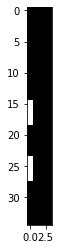

entered if
['M', '3', '5', 'G', 'C']
G
saved an img G
['M', '5', '5', 'H', 'T']
0 24
[  0  24  33  58  67  93 101 132 138 158]


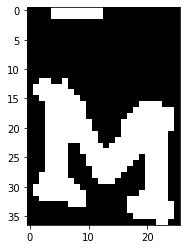

entered if
['M', '5', '5', 'H', 'T']
M
saved an img M
33 58
[  0  24  33  58  67  93 101 132 138 158]


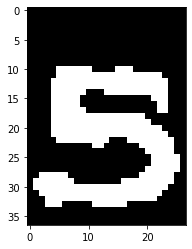

entered if
['M', '5', '5', 'H', 'T']
5
saved an img 5
67 93
[  0  24  33  58  67  93 101 132 138 158]


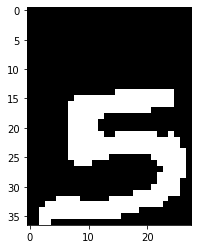

entered if
['M', '5', '5', 'H', 'T']
5
saved an img 5
101 132
[  0  24  33  58  67  93 101 132 138 158]


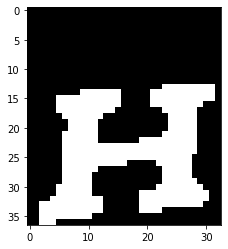

entered if
['M', '5', '5', 'H', 'T']
H
saved an img H
138 158
[  0  24  33  58  67  93 101 132 138 158]


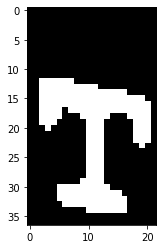

entered if
['M', '5', '5', 'H', 'T']
T
saved an img T
['M', 'A', '3', 'E', 'M']
1 65
[  1  65  69  94 101 132 136 162]


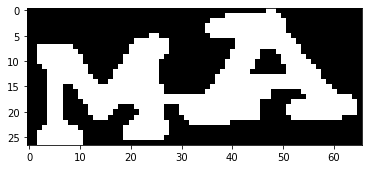

entered if
['M', 'A', '3', 'E', 'M']
M
saved an img M
69 94
[  1  65  69  94 101 132 136 162]


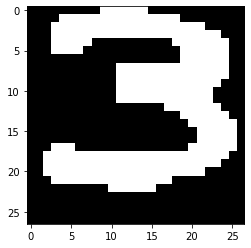

entered if
['M', 'A', '3', 'E', 'M']
A
saved an img A
101 132
[  1  65  69  94 101 132 136 162]


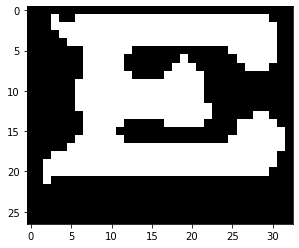

entered if
['M', 'A', '3', 'E', 'M']
3
saved an img 3
136 162
[  1  65  69  94 101 132 136 162]


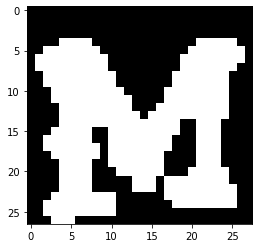

entered if
['M', 'A', '3', 'E', 'M']
E
saved an img E
['M', 'B', 'F', '6', '5']
27 29
[ 27  29  61  67  97 106 132 136 157]


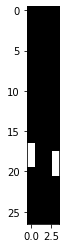

entered if
['M', 'B', 'F', '6', '5']
M
saved an img M
61 67
[ 27  29  61  67  97 106 132 136 157]


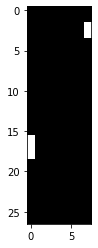

entered if
['M', 'B', 'F', '6', '5']
B
saved an img B
97 106
[ 27  29  61  67  97 106 132 136 157]


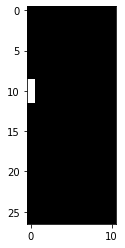

entered if
['M', 'B', 'F', '6', '5']
F
saved an img F
132 136
[ 27  29  61  67  97 106 132 136 157]


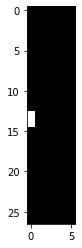

entered if
['M', 'B', 'F', '6', '5']
6
saved an img 6
['M', 'B', 'U', 'E', 'F']
59 64
[ 59  64  93 104 131 137 161]


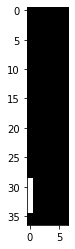

entered if
['M', 'B', 'U', 'E', 'F']
M
saved an img M
93 104
[ 59  64  93 104 131 137 161]


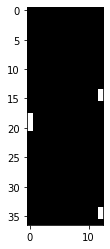

entered if
['M', 'B', 'U', 'E', 'F']
B
saved an img B
131 137
[ 59  64  93 104 131 137 161]


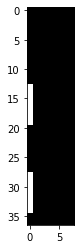

entered if
['M', 'B', 'U', 'E', 'F']
U
saved an img U
['M', 'J', '0', 'F', '2']
26 31
[ 26  31  62  69  93 103 131 139 159]


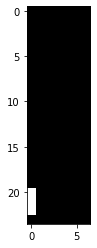

entered if
['M', 'J', '0', 'F', '2']
M
saved an img M
62 69
[ 26  31  62  69  93 103 131 139 159]


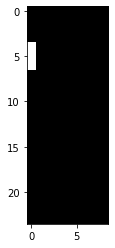

entered if
['M', 'J', '0', 'F', '2']
J
saved an img J
93 103
[ 26  31  62  69  93 103 131 139 159]


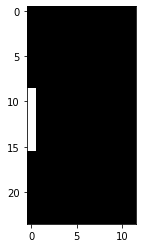

entered if
['M', 'J', '0', 'F', '2']
0
saved an img 0
131 139
[ 26  31  62  69  93 103 131 139 159]


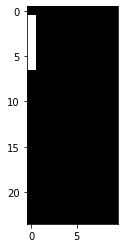

entered if
['M', 'J', '0', 'F', '2']
F
saved an img F
['M', 'J', 'X', '3', 'X']
60 67
[ 60  67  97 106 130 136 161]


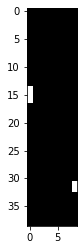

entered if
['M', 'J', 'X', '3', 'X']
M
saved an img M
97 106
[ 60  67  97 106 130 136 161]


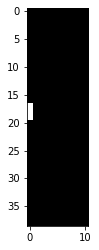

entered if
['M', 'J', 'X', '3', 'X']
J
saved an img J
130 136
[ 60  67  97 106 130 136 161]


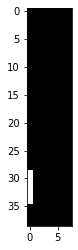

entered if
['M', 'J', 'X', '3', 'X']
X
saved an img X
['M', 'K', '1', 'F', 'L']
0 25
[  0  25  33  63  70  90 102 132 134 159]


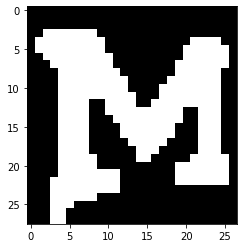

entered if
['M', 'K', '1', 'F', 'L']
M
saved an img M
33 63
[  0  25  33  63  70  90 102 132 134 159]


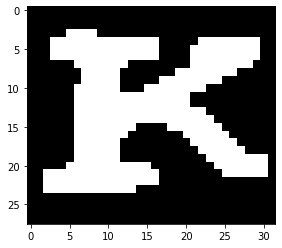

entered if
['M', 'K', '1', 'F', 'L']
K
saved an img K
70 90
[  0  25  33  63  70  90 102 132 134 159]


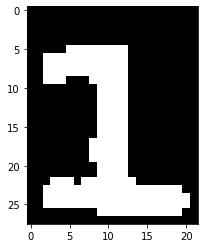

entered if
['M', 'K', '1', 'F', 'L']
1
saved an img 1
102 132
[  0  25  33  63  70  90 102 132 134 159]


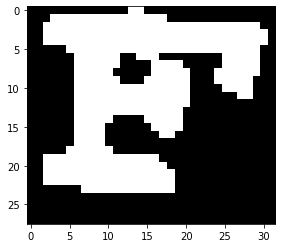

entered if
['M', 'K', '1', 'F', 'L']
F
saved an img F
134 159
[  0  25  33  63  70  90 102 132 134 159]


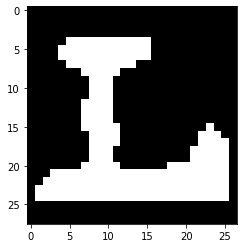

entered if
['M', 'K', '1', 'F', 'L']
L
saved an img L
['M', 'O', '5', 'K', 'V']
25 30
[ 25  30  55  70  95 101 161]


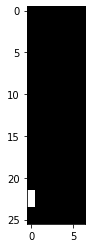

entered if
['M', 'O', '5', 'K', 'V']
M
saved an img M
55 70
[ 25  30  55  70  95 101 161]


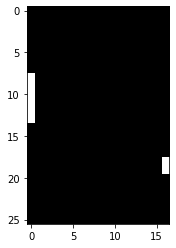

entered if
['M', 'O', '5', 'K', 'V']
O
saved an img O
95 101
[ 25  30  55  70  95 101 161]


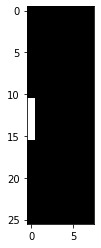

entered if
['M', 'O', '5', 'K', 'V']
5
saved an img 5
['M', 'Q', 'Z', 'M', 'T']
3 27
[  3  27  29  62  70  96 100 161]


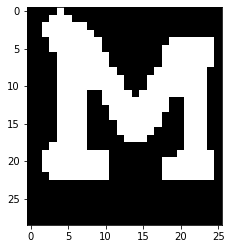

entered if
['M', 'Q', 'Z', 'M', 'T']
M
saved an img M
29 62
[  3  27  29  62  70  96 100 161]


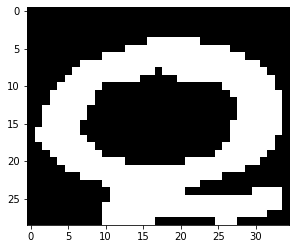

entered if
['M', 'Q', 'Z', 'M', 'T']
Q
saved an img Q
70 96
[  3  27  29  62  70  96 100 161]


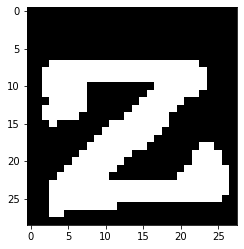

entered if
['M', 'Q', 'Z', 'M', 'T']
Z
saved an img Z
100 161
[  3  27  29  62  70  96 100 161]


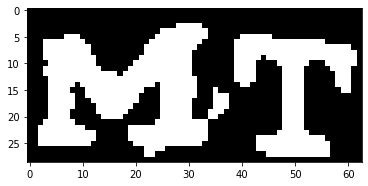

entered if
['M', 'Q', 'Z', 'M', 'T']
M
saved an img M
['M', 'U', 'D', 'H', '4']
24 32
[ 24  32  60  67  95 102 132 138 156]


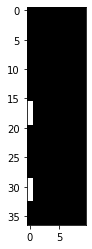

entered if
['M', 'U', 'D', 'H', '4']
M
saved an img M
60 67
[ 24  32  60  67  95 102 132 138 156]


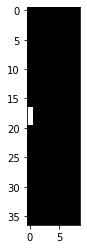

entered if
['M', 'U', 'D', 'H', '4']
U
saved an img U
95 102
[ 24  32  60  67  95 102 132 138 156]


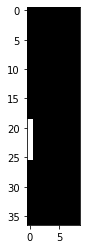

entered if
['M', 'U', 'D', 'H', '4']
D
saved an img D
132 138
[ 24  32  60  67  95 102 132 138 156]


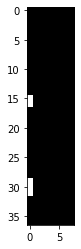

entered if
['M', 'U', 'D', 'H', '4']
H
saved an img H
['M', 'W', '9', '8', 'P']
26 29
[ 26  29  58  71  96 107 131 138 161]


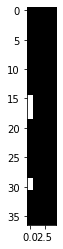

entered if
['M', 'W', '9', '8', 'P']
M
saved an img M
58 71
[ 26  29  58  71  96 107 131 138 161]


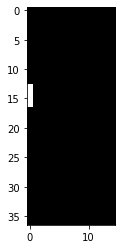

entered if
['M', 'W', '9', '8', 'P']
W
saved an img W
96 107
[ 26  29  58  71  96 107 131 138 161]


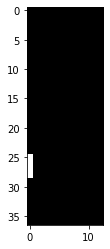

entered if
['M', 'W', '9', '8', 'P']
9
saved an img 9
131 138
[ 26  29  58  71  96 107 131 138 161]


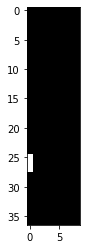

entered if
['M', 'W', '9', '8', 'P']
8
saved an img 8
['M', 'X', '8', '4', 'J']
62 68
[ 62  68  92 104 127 136 160]


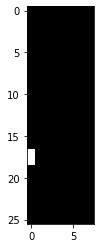

entered if
['M', 'X', '8', '4', 'J']
M
saved an img M
92 104
[ 62  68  92 104 127 136 160]


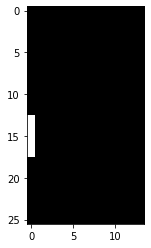

entered if
['M', 'X', '8', '4', 'J']
X
saved an img X
127 136
[ 62  68  92 104 127 136 160]


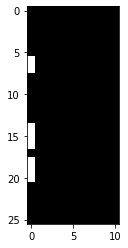

entered if
['M', 'X', '8', '4', 'J']
8
saved an img 8
['M', 'Y', '5', 'V', 'U']
26 32
[ 26  32  59  66  93  98 134 135 160]


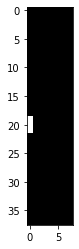

entered if
['M', 'Y', '5', 'V', 'U']
M
saved an img M
59 66
[ 26  32  59  66  93  98 134 135 160]


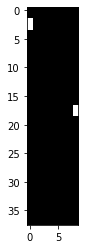

entered if
['M', 'Y', '5', 'V', 'U']
Y
saved an img Y
93 98
[ 26  32  59  66  93  98 134 135 160]


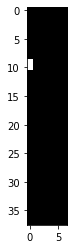

entered if
['M', 'Y', '5', 'V', 'U']
5
saved an img 5
134 135
[ 26  32  59  66  93  98 134 135 160]


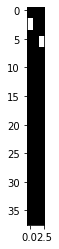

entered if
['M', 'Y', '5', 'V', 'U']
V
saved an img V
['N', '5', '5', '2', 'A']
2 28
[  2  28  34  58  67  92 104 130 132 160]


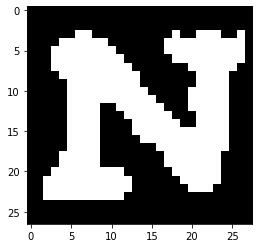

entered if
['N', '5', '5', '2', 'A']
N
saved an img N
34 58
[  2  28  34  58  67  92 104 130 132 160]


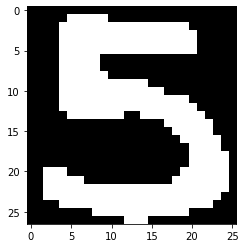

entered if
['N', '5', '5', '2', 'A']
5
saved an img 5
67 92
[  2  28  34  58  67  92 104 130 132 160]


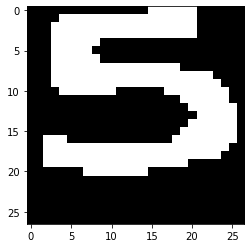

entered if
['N', '5', '5', '2', 'A']
5
saved an img 5
104 130
[  2  28  34  58  67  92 104 130 132 160]


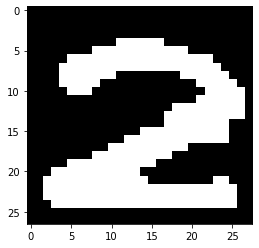

entered if
['N', '5', '5', '2', 'A']
2
saved an img 2
132 160
[  2  28  34  58  67  92 104 130 132 160]


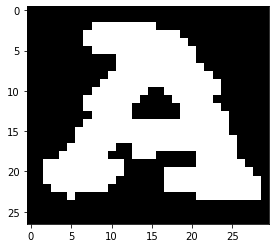

entered if
['N', '5', '5', '2', 'A']
A
saved an img A
['N', 'A', 'X', '1', '2']
0 24
[  0  24  25  61  65  95 106 128 137 158]


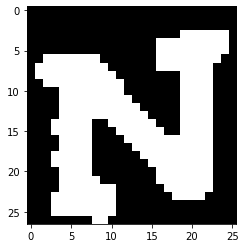

entered if
['N', 'A', 'X', '1', '2']
N
saved an img N
25 61
[  0  24  25  61  65  95 106 128 137 158]


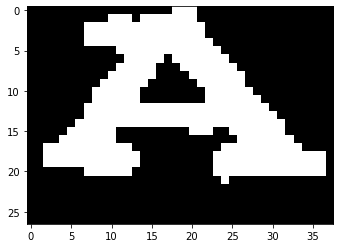

entered if
['N', 'A', 'X', '1', '2']
A
saved an img A
65 95
[  0  24  25  61  65  95 106 128 137 158]


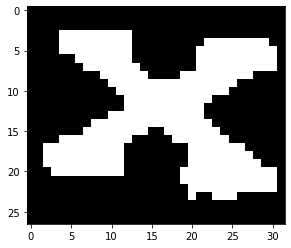

entered if
['N', 'A', 'X', '1', '2']
X
saved an img X
106 128
[  0  24  25  61  65  95 106 128 137 158]


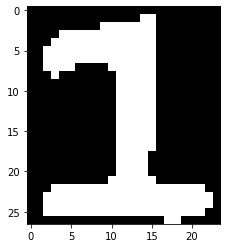

entered if
['N', 'A', 'X', '1', '2']
1
saved an img 1
137 158
[  0  24  25  61  65  95 106 128 137 158]


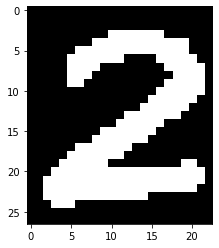

entered if
['N', 'A', 'X', '1', '2']
2
saved an img 2
['N', 'B', 'J', 'N', '4']
26 31
[ 26  31  61  66  99 101 129 141 158]


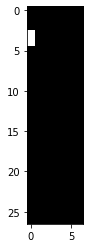

entered if
['N', 'B', 'J', 'N', '4']
N
saved an img N
61 66
[ 26  31  61  66  99 101 129 141 158]


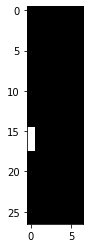

entered if
['N', 'B', 'J', 'N', '4']
B
saved an img B
99 101
[ 26  31  61  66  99 101 129 141 158]


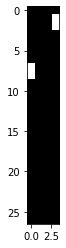

entered if
['N', 'B', 'J', 'N', '4']
J
saved an img J
129 141
[ 26  31  61  66  99 101 129 141 158]


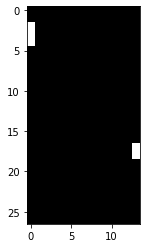

entered if
['N', 'B', 'J', 'N', '4']
N
saved an img N
['N', 'B', 'O', 'E', '9']
24 30
[ 24  30  61  68  97  99 128 140 158]


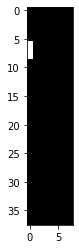

entered if
['N', 'B', 'O', 'E', '9']
N
saved an img N
61 68
[ 24  30  61  68  97  99 128 140 158]


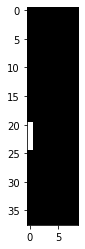

entered if
['N', 'B', 'O', 'E', '9']
B
saved an img B
97 99
[ 24  30  61  68  97  99 128 140 158]


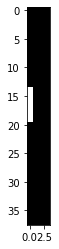

entered if
['N', 'B', 'O', 'E', '9']
O
saved an img O
128 140
[ 24  30  61  68  97  99 128 140 158]


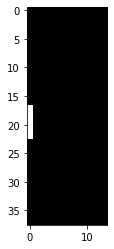

entered if
['N', 'B', 'O', 'E', '9']
E
saved an img E
['N', 'L', 'F', 'T', '2']
2 3
[  2   3  24  30  64  68  96 104 132 138 157]


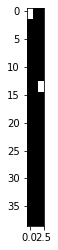

entered if
['N', 'L', 'F', 'T', '2']
N
saved an img N
24 30
[  2   3  24  30  64  68  96 104 132 138 157]


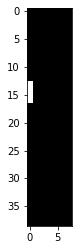

entered if
['N', 'L', 'F', 'T', '2']
L
saved an img L
64 68
[  2   3  24  30  64  68  96 104 132 138 157]


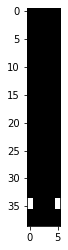

entered if
['N', 'L', 'F', 'T', '2']
F
saved an img F
96 104
[  2   3  24  30  64  68  96 104 132 138 157]


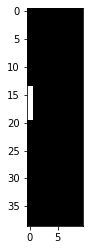

entered if
['N', 'L', 'F', 'T', '2']
T
saved an img T
132 138
[  2   3  24  30  64  68  96 104 132 138 157]


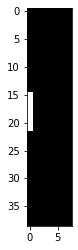

entered if
['N', 'L', 'F', 'T', '2']
2
saved an img 2
['N', 'M', '3', 'H', '7']
25 28
[ 25  28  62  69  92 104 132 135 155]


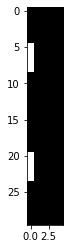

entered if
['N', 'M', '3', 'H', '7']
N
saved an img N
62 69
[ 25  28  62  69  92 104 132 135 155]


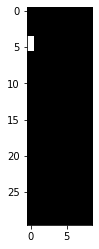

entered if
['N', 'M', '3', 'H', '7']
M
saved an img M
92 104
[ 25  28  62  69  92 104 132 135 155]


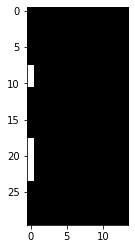

entered if
['N', 'M', '3', 'H', '7']
3
saved an img 3
132 135
[ 25  28  62  69  92 104 132 135 155]


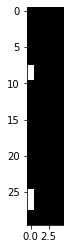

entered if
['N', 'M', '3', 'H', '7']
H
saved an img H
['N', 'N', 'G', 'B', 'Q']
26 28
[ 26  28  59  65  96  99 133 134 157]


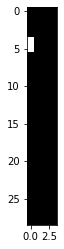

entered if
['N', 'N', 'G', 'B', 'Q']
N
saved an img N
59 65
[ 26  28  59  65  96  99 133 134 157]


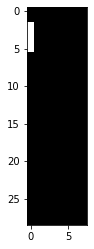

entered if
['N', 'N', 'G', 'B', 'Q']
N
saved an img N
96 99
[ 26  28  59  65  96  99 133 134 157]


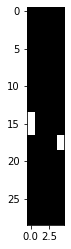

entered if
['N', 'N', 'G', 'B', 'Q']
G
saved an img G
133 134
[ 26  28  59  65  96  99 133 134 157]


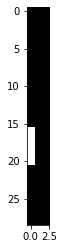

entered if
['N', 'N', 'G', 'B', 'Q']
B
saved an img B
['N', 'X', 'S', 'F', 'I']
1 26
[  1  26  28  60  67  93 103 131 137 157]


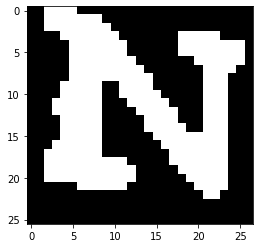

entered if
['N', 'X', 'S', 'F', 'I']
N
saved an img N
28 60
[  1  26  28  60  67  93 103 131 137 157]


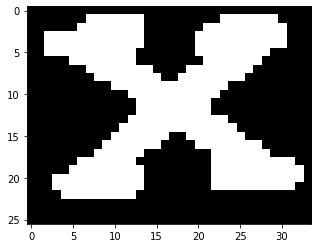

entered if
['N', 'X', 'S', 'F', 'I']
X
saved an img X
67 93
[  1  26  28  60  67  93 103 131 137 157]


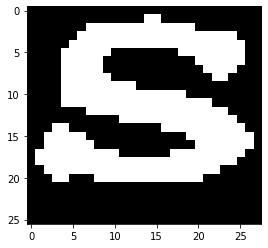

entered if
['N', 'X', 'S', 'F', 'I']
S
saved an img S
103 131
[  1  26  28  60  67  93 103 131 137 157]


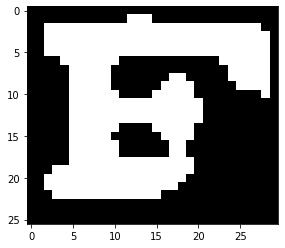

entered if
['N', 'X', 'S', 'F', 'I']
F
saved an img F
137 157
[  1  26  28  60  67  93 103 131 137 157]


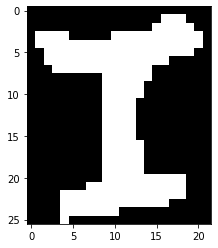

entered if
['N', 'X', 'S', 'F', 'I']
I
saved an img I
['O', '0', '1', 'L', '6']
25 32
[ 25  32  57  69  92 101 133 138 157]


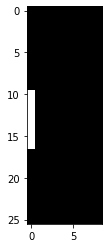

entered if
['O', '0', '1', 'L', '6']
O
saved an img O
57 69
[ 25  32  57  69  92 101 133 138 157]


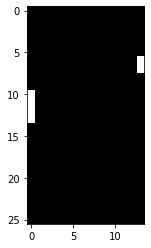

entered if
['O', '0', '1', 'L', '6']
0
saved an img 0
92 101
[ 25  32  57  69  92 101 133 138 157]


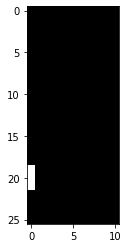

entered if
['O', '0', '1', 'L', '6']
1
saved an img 1
133 138
[ 25  32  57  69  92 101 133 138 157]


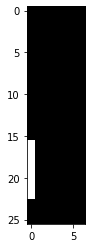

entered if
['O', '0', '1', 'L', '6']
L
saved an img L
['O', '2', 'H', '6', '3']
25 32
[ 25  32  58  67  95 106 130 138 156]


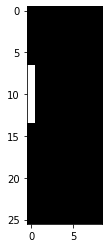

entered if
['O', '2', 'H', '6', '3']
O
saved an img O
58 67
[ 25  32  58  67  95 106 130 138 156]


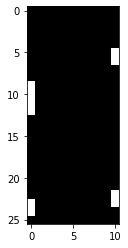

entered if
['O', '2', 'H', '6', '3']
2
saved an img 2
95 106
[ 25  32  58  67  95 106 130 138 156]


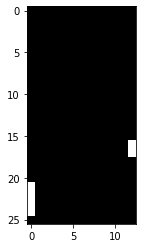

entered if
['O', '2', 'H', '6', '3']
H
saved an img H
130 138
[ 25  32  58  67  95 106 130 138 156]


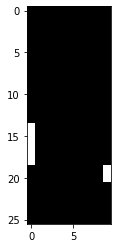

entered if
['O', '2', 'H', '6', '3']
6
saved an img 6
['O', '5', 'A', 'N', 'O']
0 26
[  0  26  30  57  63  96 102 133 137 158]


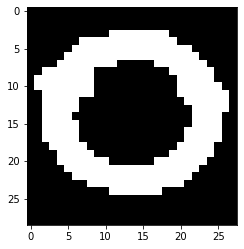

entered if
['O', '5', 'A', 'N', 'O']
O
saved an img O
30 57
[  0  26  30  57  63  96 102 133 137 158]


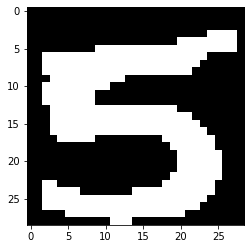

entered if
['O', '5', 'A', 'N', 'O']
5
saved an img 5
63 96
[  0  26  30  57  63  96 102 133 137 158]


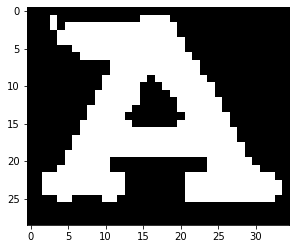

entered if
['O', '5', 'A', 'N', 'O']
A
saved an img A
102 133
[  0  26  30  57  63  96 102 133 137 158]


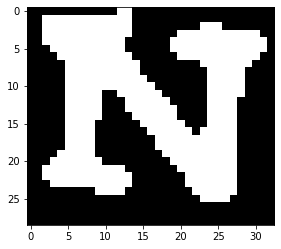

entered if
['O', '5', 'A', 'N', 'O']
N
saved an img N
137 158
[  0  26  30  57  63  96 102 133 137 158]


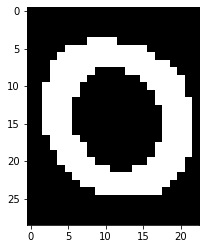

entered if
['O', '5', 'A', 'N', 'O']
O
saved an img O
['O', 'A', 'P', 'U', 'B']
2 26
[  2  26  29  61  68  96 102 134 137 161]


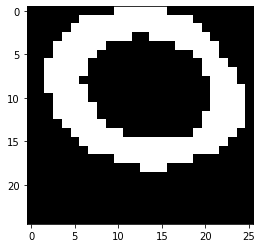

entered if
['O', 'A', 'P', 'U', 'B']
O
saved an img O
29 61
[  2  26  29  61  68  96 102 134 137 161]


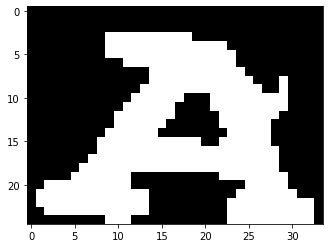

entered if
['O', 'A', 'P', 'U', 'B']
A
saved an img A
68 96
[  2  26  29  61  68  96 102 134 137 161]


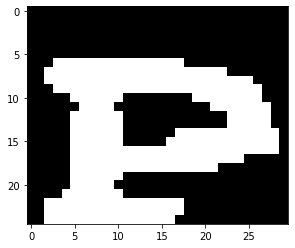

entered if
['O', 'A', 'P', 'U', 'B']
P
saved an img P
102 134
[  2  26  29  61  68  96 102 134 137 161]


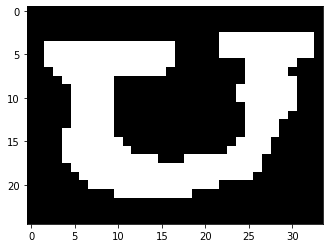

entered if
['O', 'A', 'P', 'U', 'B']
U
saved an img U
137 161
[  2  26  29  61  68  96 102 134 137 161]


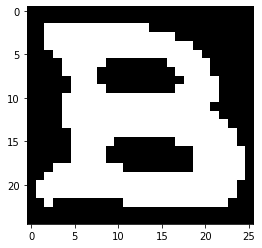

entered if
['O', 'A', 'P', 'U', 'B']
B
saved an img B
['O', 'F', 'J', 'J', 'L']
2 24
[  2  24  29  60  68  97 104 136 138 163]


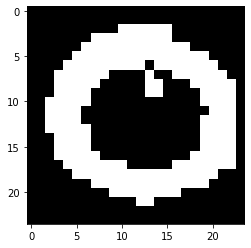

entered if
['O', 'F', 'J', 'J', 'L']
O
saved an img O
29 60
[  2  24  29  60  68  97 104 136 138 163]


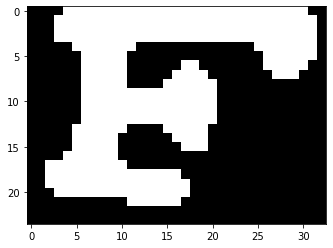

entered if
['O', 'F', 'J', 'J', 'L']
F
saved an img F
68 97
[  2  24  29  60  68  97 104 136 138 163]


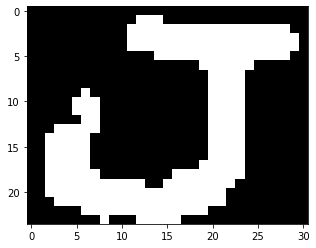

entered if
['O', 'F', 'J', 'J', 'L']
J
saved an img J
104 136
[  2  24  29  60  68  97 104 136 138 163]


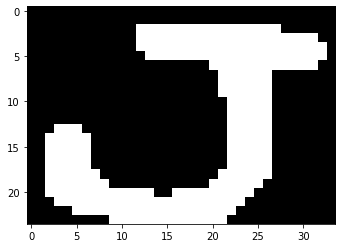

entered if
['O', 'F', 'J', 'J', 'L']
J
saved an img J
138 163
[  2  24  29  60  68  97 104 136 138 163]


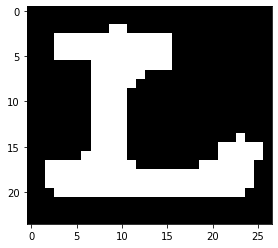

entered if
['O', 'F', 'J', 'J', 'L']
L
saved an img L
['O', 'I', '7', 'Z', 'O']
1 2
[  1   2  27  30  90 104 128 137 159]


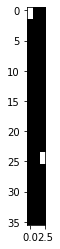

entered if
['O', 'I', '7', 'Z', 'O']
O
saved an img O
27 30
[  1   2  27  30  90 104 128 137 159]


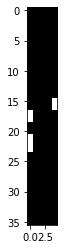

entered if
['O', 'I', '7', 'Z', 'O']
I
saved an img I
90 104
[  1   2  27  30  90 104 128 137 159]


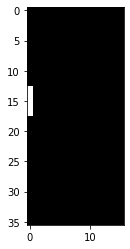

entered if
['O', 'I', '7', 'Z', 'O']
7
saved an img 7
128 137
[  1   2  27  30  90 104 128 137 159]


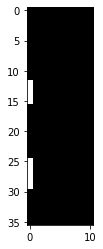

entered if
['O', 'I', '7', 'Z', 'O']
Z
saved an img Z
['O', 'I', 'M', '9', 'W']
24 40
[ 24  40  60  67  99 108 131 132 158]


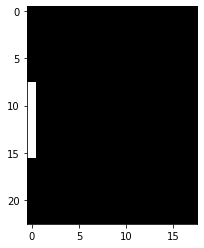

entered if
['O', 'I', 'M', '9', 'W']
O
saved an img O
60 67
[ 24  40  60  67  99 108 131 132 158]


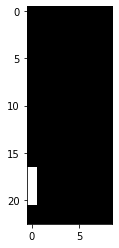

entered if
['O', 'I', 'M', '9', 'W']
I
saved an img I
99 108
[ 24  40  60  67  99 108 131 132 158]


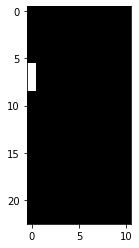

entered if
['O', 'I', 'M', '9', 'W']
M
saved an img M
131 132
[ 24  40  60  67  99 108 131 132 158]


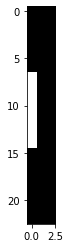

entered if
['O', 'I', 'M', '9', 'W']
9
saved an img 9
['O', 'J', 'Y', '3', '9']
1 25
[  1  25  31  62  64  94 107 131 139 161]


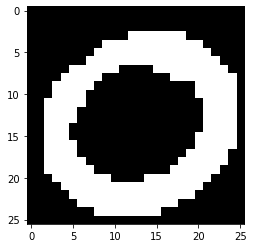

entered if
['O', 'J', 'Y', '3', '9']
O
saved an img O
31 62
[  1  25  31  62  64  94 107 131 139 161]


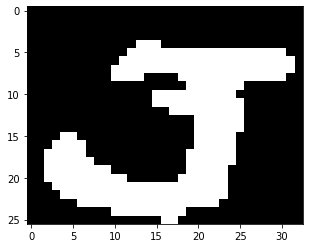

entered if
['O', 'J', 'Y', '3', '9']
J
saved an img J
64 94
[  1  25  31  62  64  94 107 131 139 161]


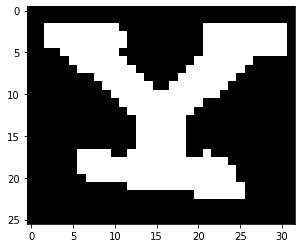

entered if
['O', 'J', 'Y', '3', '9']
Y
saved an img Y
107 131
[  1  25  31  62  64  94 107 131 139 161]


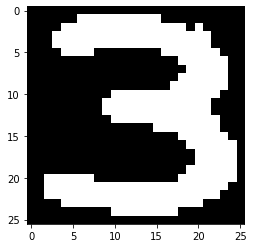

entered if
['O', 'J', 'Y', '3', '9']
3
saved an img 3
139 161
[  1  25  31  62  64  94 107 131 139 161]


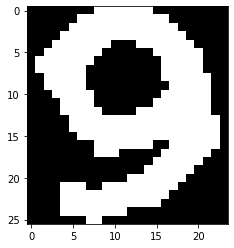

entered if
['O', 'J', 'Y', '3', '9']
9
saved an img 9
['O', 'K', 'Y', 'R', 'W']
1 25
[  1  25  27  57  65  92 100 159]


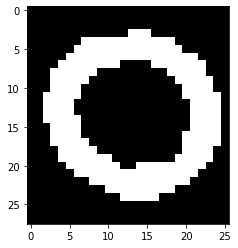

entered if
['O', 'K', 'Y', 'R', 'W']
O
saved an img O
27 57
[  1  25  27  57  65  92 100 159]


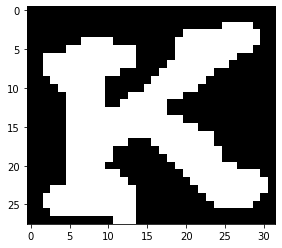

entered if
['O', 'K', 'Y', 'R', 'W']
K
saved an img K
65 92
[  1  25  27  57  65  92 100 159]


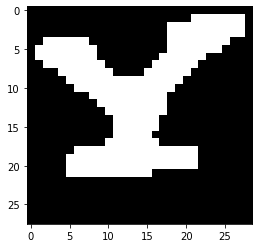

entered if
['O', 'K', 'Y', 'R', 'W']
Y
saved an img Y
100 159
[  1  25  27  57  65  92 100 159]


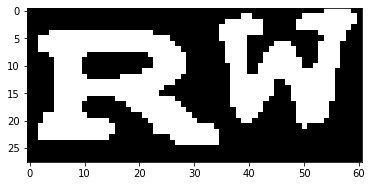

entered if
['O', 'K', 'Y', 'R', 'W']
R
saved an img R
['O', 'M', 'B', '2', 'Q']
2 26
[  2  26  31  67  69  98 105 130 132 160]


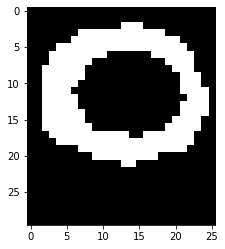

entered if
['O', 'M', 'B', '2', 'Q']
O
saved an img O
31 67
[  2  26  31  67  69  98 105 130 132 160]


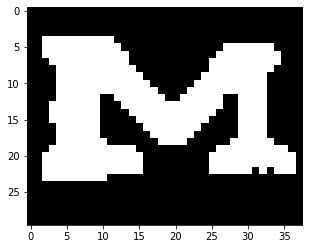

entered if
['O', 'M', 'B', '2', 'Q']
M
saved an img M
69 98
[  2  26  31  67  69  98 105 130 132 160]


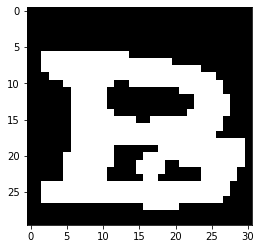

entered if
['O', 'M', 'B', '2', 'Q']
B
saved an img B
105 130
[  2  26  31  67  69  98 105 130 132 160]


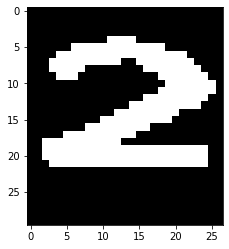

entered if
['O', 'M', 'B', '2', 'Q']
2
saved an img 2
132 160
[  2  26  31  67  69  98 105 130 132 160]


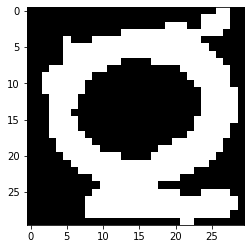

entered if
['O', 'M', 'B', '2', 'Q']
Q
saved an img Q
['O', 'M', 'M', '4', 'R']
23 28
[ 23  28  97 108 131 137 163]


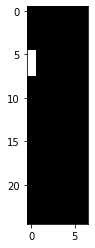

entered if
['O', 'M', 'M', '4', 'R']
O
saved an img O
97 108
[ 23  28  97 108 131 137 163]


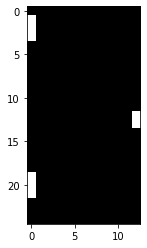

entered if
['O', 'M', 'M', '4', 'R']
M
saved an img M
131 137
[ 23  28  97 108 131 137 163]


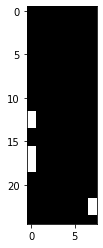

entered if
['O', 'M', 'M', '4', 'R']
M
saved an img M
['O', 'P', '6', 'F', 'N']
22 31
[ 22  31  60  69  92 106 133 134 162]


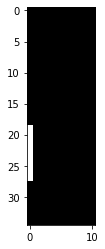

entered if
['O', 'P', '6', 'F', 'N']
O
saved an img O
60 69
[ 22  31  60  69  92 106 133 134 162]


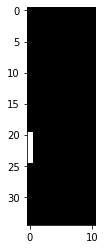

entered if
['O', 'P', '6', 'F', 'N']
P
saved an img P
92 106
[ 22  31  60  69  92 106 133 134 162]


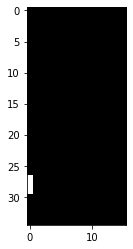

entered if
['O', 'P', '6', 'F', 'N']
6
saved an img 6
133 134
[ 22  31  60  69  92 106 133 134 162]


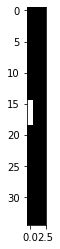

entered if
['O', 'P', '6', 'F', 'N']
F
saved an img F
['O', 'S', 'L', '4', 'Y']
0 27
[  0  27  32  60  69  98 102 126 138 161]


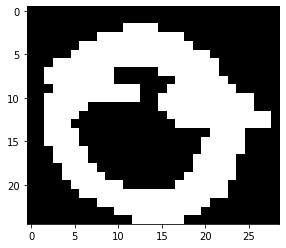

entered if
['O', 'S', 'L', '4', 'Y']
O
saved an img O
32 60
[  0  27  32  60  69  98 102 126 138 161]


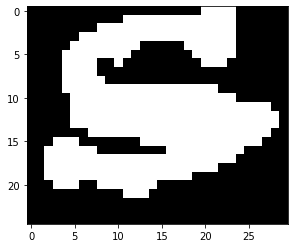

entered if
['O', 'S', 'L', '4', 'Y']
S
saved an img S
69 98
[  0  27  32  60  69  98 102 126 138 161]


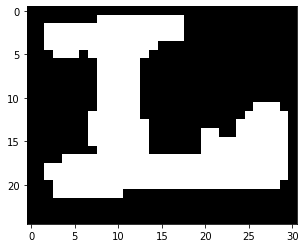

entered if
['O', 'S', 'L', '4', 'Y']
L
saved an img L
102 126
[  0  27  32  60  69  98 102 126 138 161]


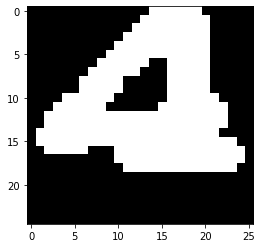

entered if
['O', 'S', 'L', '4', 'Y']
4
saved an img 4
138 161
[  0  27  32  60  69  98 102 126 138 161]


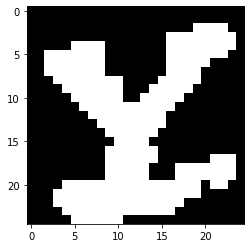

entered if
['O', 'S', 'L', '4', 'Y']
Y
saved an img Y
['O', 'S', 'R', 'X', 'G']
2 24
[  2  24  31  56  64  94 100 132 137 161]


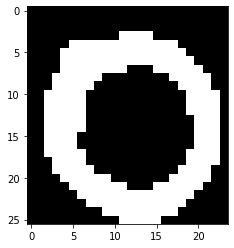

entered if
['O', 'S', 'R', 'X', 'G']
O
saved an img O
31 56
[  2  24  31  56  64  94 100 132 137 161]


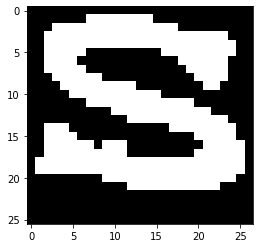

entered if
['O', 'S', 'R', 'X', 'G']
S
saved an img S
64 94
[  2  24  31  56  64  94 100 132 137 161]


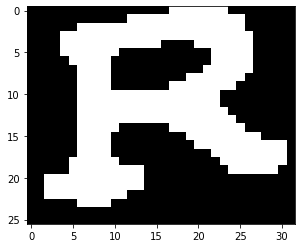

entered if
['O', 'S', 'R', 'X', 'G']
R
saved an img R
100 132
[  2  24  31  56  64  94 100 132 137 161]


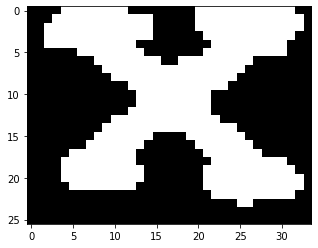

entered if
['O', 'S', 'R', 'X', 'G']
X
saved an img X
137 161
[  2  24  31  56  64  94 100 132 137 161]


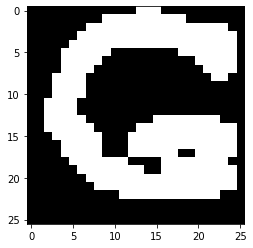

entered if
['O', 'S', 'R', 'X', 'G']
G
saved an img G
['O', 'Y', 'I', '8', 'I']
5 25
[  5  25  31  58  68  93 104 129 137 157]


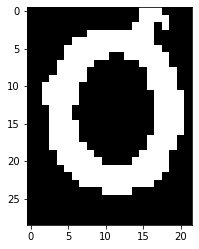

entered if
['O', 'Y', 'I', '8', 'I']
O
saved an img O
31 58
[  5  25  31  58  68  93 104 129 137 157]


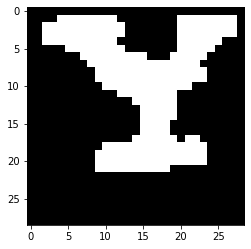

entered if
['O', 'Y', 'I', '8', 'I']
Y
saved an img Y
68 93
[  5  25  31  58  68  93 104 129 137 157]


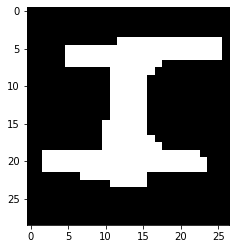

entered if
['O', 'Y', 'I', '8', 'I']
I
saved an img I
104 129
[  5  25  31  58  68  93 104 129 137 157]


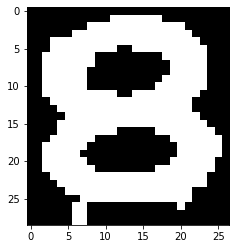

entered if
['O', 'Y', 'I', '8', 'I']
8
saved an img 8
137 157
[  5  25  31  58  68  93 104 129 137 157]


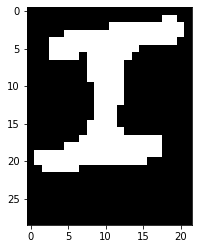

entered if
['O', 'Y', 'I', '8', 'I']
I
saved an img I
['P', 'J', 'O', 'K', 'X']
1 24
[  1  24  30  59  66  95 100 130 136 160]


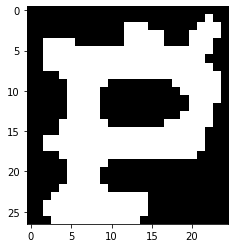

entered if
['P', 'J', 'O', 'K', 'X']
P
saved an img P
30 59
[  1  24  30  59  66  95 100 130 136 160]


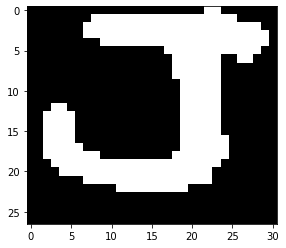

entered if
['P', 'J', 'O', 'K', 'X']
J
saved an img J
66 95
[  1  24  30  59  66  95 100 130 136 160]


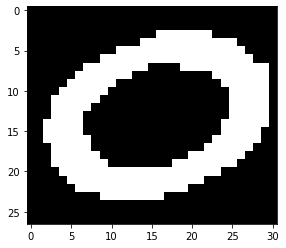

entered if
['P', 'J', 'O', 'K', 'X']
O
saved an img O
100 130
[  1  24  30  59  66  95 100 130 136 160]


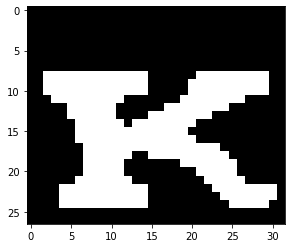

entered if
['P', 'J', 'O', 'K', 'X']
K
saved an img K
136 160
[  1  24  30  59  66  95 100 130 136 160]


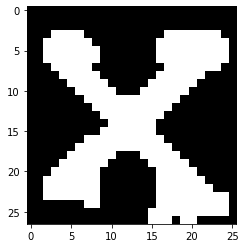

entered if
['P', 'J', 'O', 'K', 'X']
X
saved an img X
['P', 'M', 'E', '3', 'M']
4 27
[  4  27  31  95 104 131 133 161]


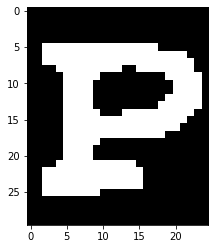

entered if
['P', 'M', 'E', '3', 'M']
P
saved an img P
31 95
[  4  27  31  95 104 131 133 161]


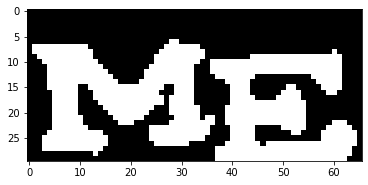

entered if
['P', 'M', 'E', '3', 'M']
M
saved an img M
104 131
[  4  27  31  95 104 131 133 161]


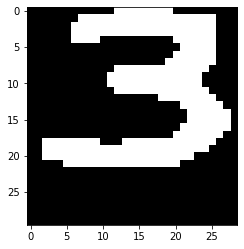

entered if
['P', 'M', 'E', '3', 'M']
E
saved an img E
133 161
[  4  27  31  95 104 131 133 161]


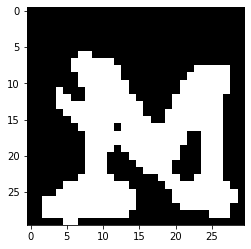

entered if
['P', 'M', 'E', '3', 'M']
3
saved an img 3
['P', 'N', 'W', 'U', 'P']
4 26
[  4  26  28  62  64  95  96 133 139 161]


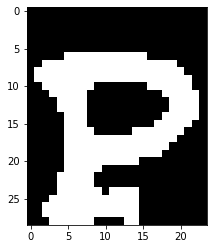

entered if
['P', 'N', 'W', 'U', 'P']
P
saved an img P
28 62
[  4  26  28  62  64  95  96 133 139 161]


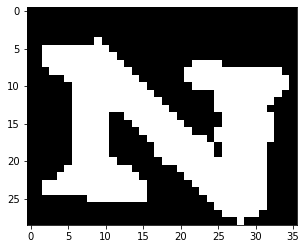

entered if
['P', 'N', 'W', 'U', 'P']
N
saved an img N
64 95
[  4  26  28  62  64  95  96 133 139 161]


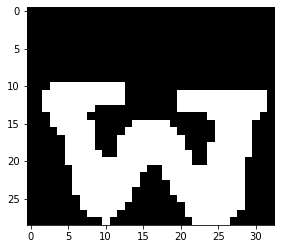

entered if
['P', 'N', 'W', 'U', 'P']
W
saved an img W
96 133
[  4  26  28  62  64  95  96 133 139 161]


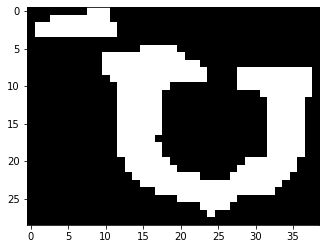

entered if
['P', 'N', 'W', 'U', 'P']
U
saved an img U
139 161
[  4  26  28  62  64  95  96 133 139 161]


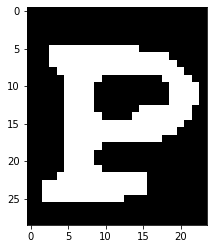

entered if
['P', 'N', 'W', 'U', 'P']
P
saved an img P
['P', 'U', '5', 'Y', 'X']
2 26
[  2  26  29  60  68  94 102 132 135 159]


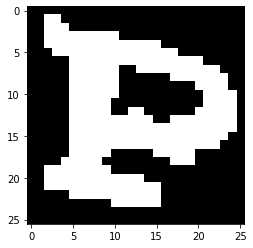

entered if
['P', 'U', '5', 'Y', 'X']
P
saved an img P
29 60
[  2  26  29  60  68  94 102 132 135 159]


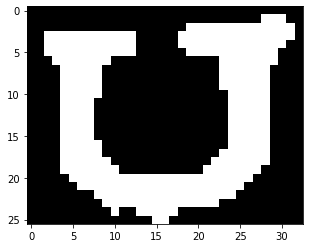

entered if
['P', 'U', '5', 'Y', 'X']
U
saved an img U
68 94
[  2  26  29  60  68  94 102 132 135 159]


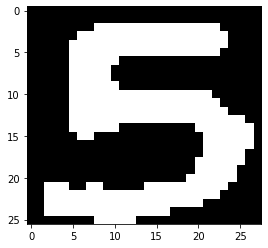

entered if
['P', 'U', '5', 'Y', 'X']
5
saved an img 5
102 132
[  2  26  29  60  68  94 102 132 135 159]


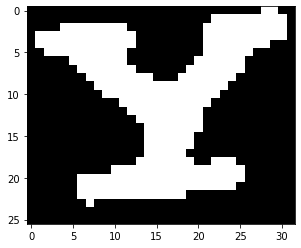

entered if
['P', 'U', '5', 'Y', 'X']
Y
saved an img Y
135 159
[  2  26  29  60  68  94 102 132 135 159]


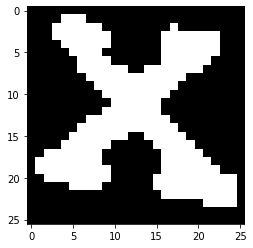

entered if
['P', 'U', '5', 'Y', 'X']
X
saved an img X
['P', 'U', 'I', 'F', 'M']
2 25
[  2  25  30  60  67  91 101 158]


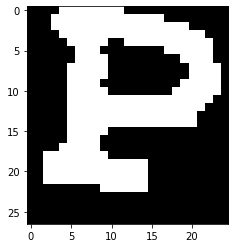

entered if
['P', 'U', 'I', 'F', 'M']
P
saved an img P
30 60
[  2  25  30  60  67  91 101 158]


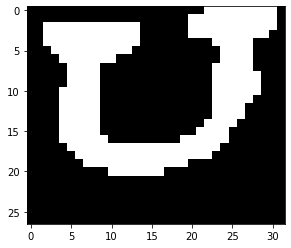

entered if
['P', 'U', 'I', 'F', 'M']
U
saved an img U
67 91
[  2  25  30  60  67  91 101 158]


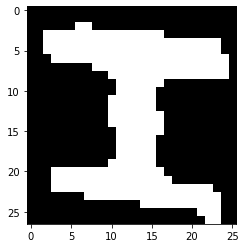

entered if
['P', 'U', 'I', 'F', 'M']
I
saved an img I
101 158
[  2  25  30  60  67  91 101 158]


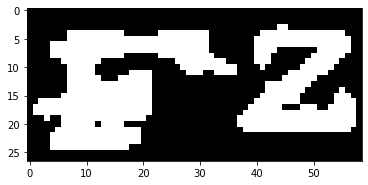

entered if
['P', 'U', 'I', 'F', 'M']
F
saved an img F
['P', 'U', 'I', 'F', 'Z']
2 25
[  2  25  30  60  67  91 101 158]


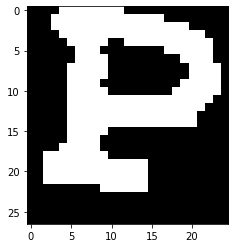

entered if
['P', 'U', 'I', 'F', 'Z']
P
saved an img P
30 60
[  2  25  30  60  67  91 101 158]


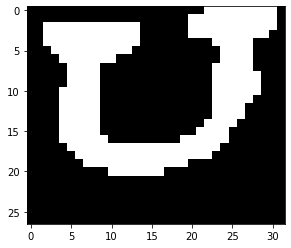

entered if
['P', 'U', 'I', 'F', 'Z']
U
saved an img U
67 91
[  2  25  30  60  67  91 101 158]


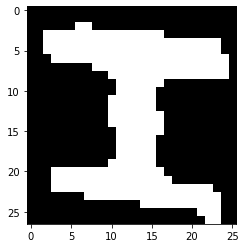

entered if
['P', 'U', 'I', 'F', 'Z']
I
saved an img I
101 158
[  2  25  30  60  67  91 101 158]


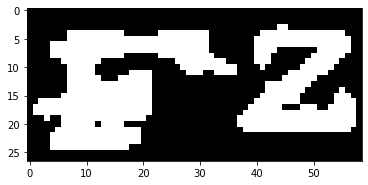

entered if
['P', 'U', 'I', 'F', 'Z']
F
saved an img F
['Q', '2', '4', 'Z', 'O']
26 31
[ 26  31  55  69  92 105 131 134 161]


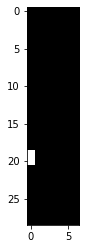

entered if
['Q', '2', '4', 'Z', 'O']
Q
saved an img Q
55 69
[ 26  31  55  69  92 105 131 134 161]


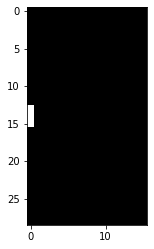

entered if
['Q', '2', '4', 'Z', 'O']
2
saved an img 2
92 105
[ 26  31  55  69  92 105 131 134 161]


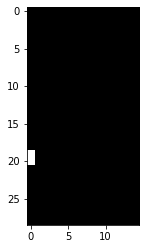

entered if
['Q', '2', '4', 'Z', 'O']
4
saved an img 4
131 134
[ 26  31  55  69  92 105 131 134 161]


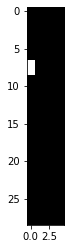

entered if
['Q', '2', '4', 'Z', 'O']
Z
saved an img Z
['Q', '2', '5', 'W', 'P']
29 31
[ 29  31  56  70  96 101 131 138 160]


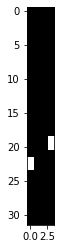

entered if
['Q', '2', '5', 'W', 'P']
Q
saved an img Q
56 70
[ 29  31  56  70  96 101 131 138 160]


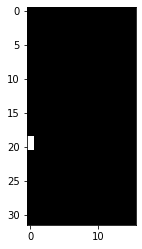

entered if
['Q', '2', '5', 'W', 'P']
2
saved an img 2
96 101
[ 29  31  56  70  96 101 131 138 160]


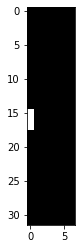

entered if
['Q', '2', '5', 'W', 'P']
5
saved an img 5
131 138
[ 29  31  56  70  96 101 131 138 160]


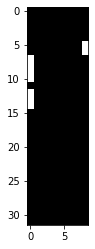

entered if
['Q', '2', '5', 'W', 'P']
W
saved an img W
['Q', '5', 'Y', 'A', '1']
0 24
[  0  24  34  58  66  95 101 134 140 156]


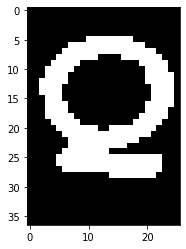

entered if
['Q', '5', 'Y', 'A', '1']
Q
saved an img Q
34 58
[  0  24  34  58  66  95 101 134 140 156]


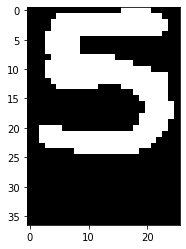

entered if
['Q', '5', 'Y', 'A', '1']
5
saved an img 5
66 95
[  0  24  34  58  66  95 101 134 140 156]


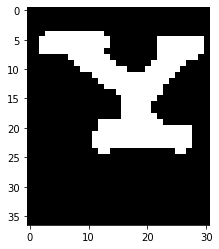

entered if
['Q', '5', 'Y', 'A', '1']
Y
saved an img Y
101 134
[  0  24  34  58  66  95 101 134 140 156]


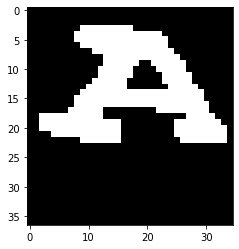

entered if
['Q', '5', 'Y', 'A', '1']
A
saved an img A
140 156
[  0  24  34  58  66  95 101 134 140 156]


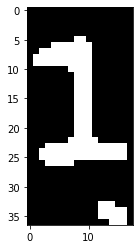

entered if
['Q', '5', 'Y', 'A', '1']
1
saved an img 1
['Q', '7', '8', '8', 'Q']
2 27
[  2  27  31  56  66  92 106 129 137 162]


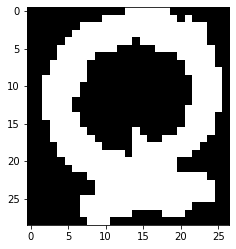

entered if
['Q', '7', '8', '8', 'Q']
Q
saved an img Q
31 56
[  2  27  31  56  66  92 106 129 137 162]


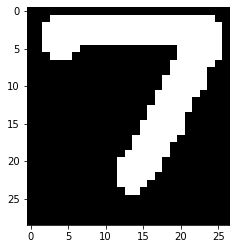

entered if
['Q', '7', '8', '8', 'Q']
7
saved an img 7
66 92
[  2  27  31  56  66  92 106 129 137 162]


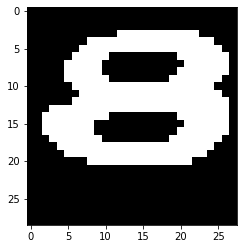

entered if
['Q', '7', '8', '8', 'Q']
8
saved an img 8
106 129
[  2  27  31  56  66  92 106 129 137 162]


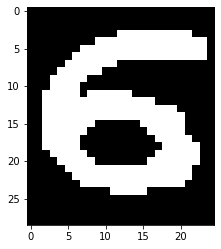

entered if
['Q', '7', '8', '8', 'Q']
8
saved an img 8
137 162
[  2  27  31  56  66  92 106 129 137 162]


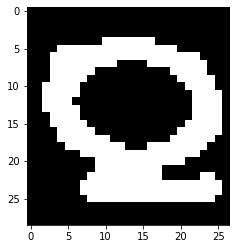

entered if
['Q', '7', '8', '8', 'Q']
Q
saved an img Q
['Q', '7', 'Y', '7', 'U']
27 31
[ 27  31  54  63  96 106 131 137 159]


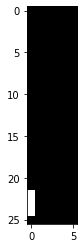

entered if
['Q', '7', 'Y', '7', 'U']
Q
saved an img Q
54 63
[ 27  31  54  63  96 106 131 137 159]


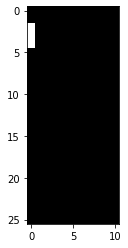

entered if
['Q', '7', 'Y', '7', 'U']
7
saved an img 7
96 106
[ 27  31  54  63  96 106 131 137 159]


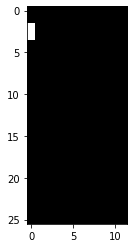

entered if
['Q', '7', 'Y', '7', 'U']
Y
saved an img Y
131 137
[ 27  31  54  63  96 106 131 137 159]


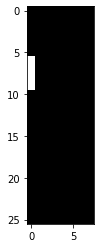

entered if
['Q', '7', 'Y', '7', 'U']
7
saved an img 7
['Q', '8', 'Y', 'Y', '3']
1 24
[  1  24  32  56  66  97  99 129 141 160]


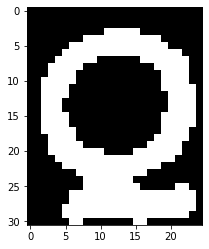

entered if
['Q', '8', 'Y', 'Y', '3']
Q
saved an img Q
32 56
[  1  24  32  56  66  97  99 129 141 160]


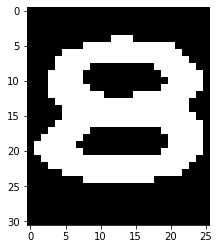

entered if
['Q', '8', 'Y', 'Y', '3']
8
saved an img 8
66 97
[  1  24  32  56  66  97  99 129 141 160]


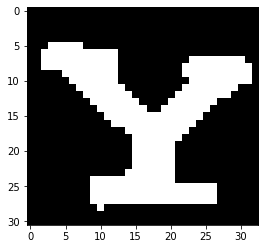

entered if
['Q', '8', 'Y', 'Y', '3']
Y
saved an img Y
99 129
[  1  24  32  56  66  97  99 129 141 160]


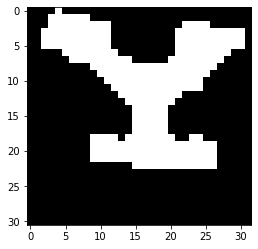

entered if
['Q', '8', 'Y', 'Y', '3']
Y
saved an img Y
141 160
[  1  24  32  56  66  97  99 129 141 160]


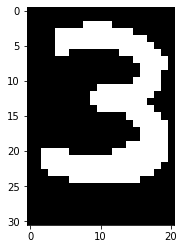

entered if
['Q', '8', 'Y', 'Y', '3']
3
saved an img 3
['Q', 'A', 'R', 'Q', '8']
25 26
[ 25  26  61  67  96 101 130 140 159]


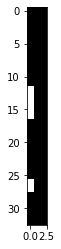

entered if
['Q', 'A', 'R', 'Q', '8']
Q
saved an img Q
61 67
[ 25  26  61  67  96 101 130 140 159]


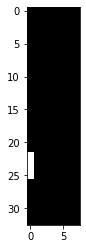

entered if
['Q', 'A', 'R', 'Q', '8']
A
saved an img A
96 101
[ 25  26  61  67  96 101 130 140 159]


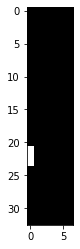

entered if
['Q', 'A', 'R', 'Q', '8']
R
saved an img R
130 140
[ 25  26  61  67  96 101 130 140 159]


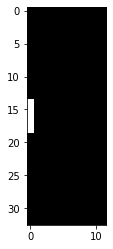

entered if
['Q', 'A', 'R', 'Q', '8']
Q
saved an img Q
['Q', 'E', '4', '2', 'C']
0 60
[  0  60  68  92 107 130 136 160]


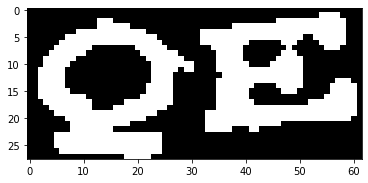

entered if
['Q', 'E', '4', '2', 'C']
Q
saved an img Q
68 92
[  0  60  68  92 107 130 136 160]


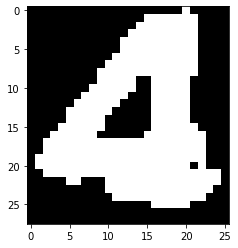

entered if
['Q', 'E', '4', '2', 'C']
E
saved an img E
107 130
[  0  60  68  92 107 130 136 160]


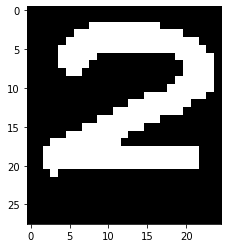

entered if
['Q', 'E', '4', '2', 'C']
4
saved an img 4
136 160
[  0  60  68  92 107 130 136 160]


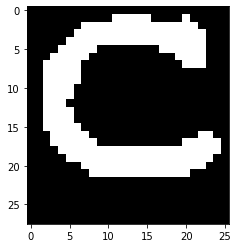

entered if
['Q', 'E', '4', '2', 'C']
2
saved an img 2
['Q', 'F', 'H', '4', 'R']
0 25
[  0  25  31  92 100 124 134 162]


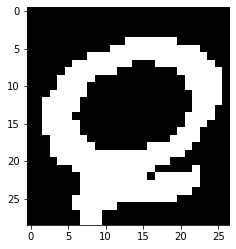

entered if
['Q', 'F', 'H', '4', 'R']
Q
saved an img Q
31 92
[  0  25  31  92 100 124 134 162]


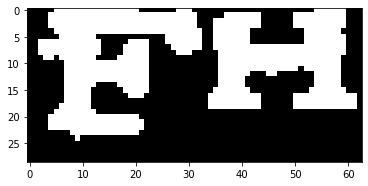

entered if
['Q', 'F', 'H', '4', 'R']
F
saved an img F
100 124
[  0  25  31  92 100 124 134 162]


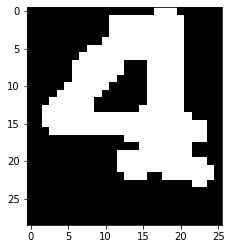

entered if
['Q', 'F', 'H', '4', 'R']
H
saved an img H
134 162
[  0  25  31  92 100 124 134 162]


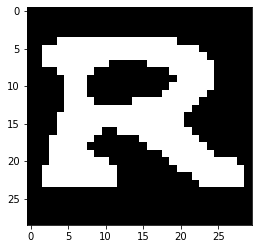

entered if
['Q', 'F', 'H', '4', 'R']
4
saved an img 4
['Q', 'H', 'T', 'S', 'Y']
0 25
[  0  25  35  61  73  94 105 132 137 157]


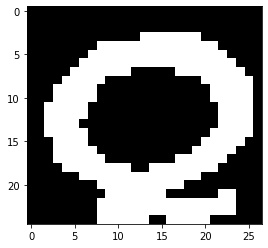

entered if
['Q', 'H', 'T', 'S', 'Y']
Q
saved an img Q
35 61
[  0  25  35  61  73  94 105 132 137 157]


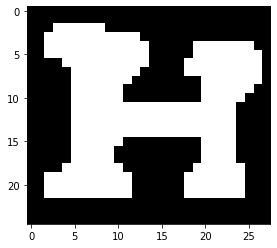

entered if
['Q', 'H', 'T', 'S', 'Y']
H
saved an img H
73 94
[  0  25  35  61  73  94 105 132 137 157]


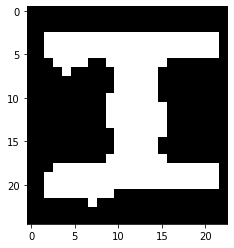

entered if
['Q', 'H', 'T', 'S', 'Y']
T
saved an img T
105 132
[  0  25  35  61  73  94 105 132 137 157]


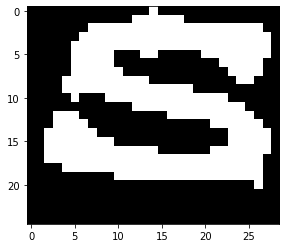

entered if
['Q', 'H', 'T', 'S', 'Y']
S
saved an img S
137 157
[  0  25  35  61  73  94 105 132 137 157]


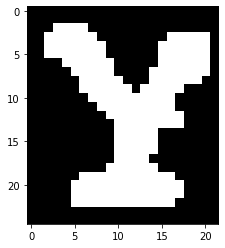

entered if
['Q', 'H', 'T', 'S', 'Y']
Y
saved an img Y
['Q', 'H', 'Z', '8', '4']
0 27
[  0  27  29  59  68  93 103 128 140 156]


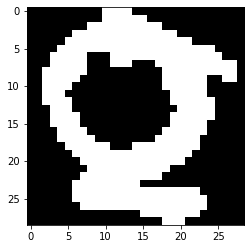

entered if
['Q', 'H', 'Z', '8', '4']
Q
saved an img Q
29 59
[  0  27  29  59  68  93 103 128 140 156]


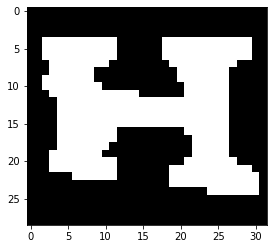

entered if
['Q', 'H', 'Z', '8', '4']
H
saved an img H
68 93
[  0  27  29  59  68  93 103 128 140 156]


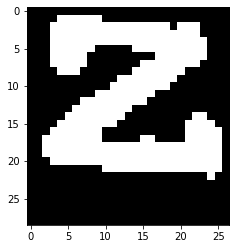

entered if
['Q', 'H', 'Z', '8', '4']
Z
saved an img Z
103 128
[  0  27  29  59  68  93 103 128 140 156]


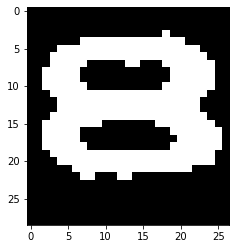

entered if
['Q', 'H', 'Z', '8', '4']
8
saved an img 8
140 156
[  0  27  29  59  68  93 103 128 140 156]


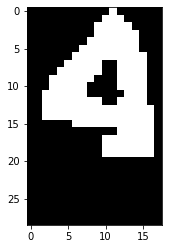

entered if
['Q', 'H', 'Z', '8', '4']
4
saved an img 4
['Q', 'I', '8', 'J', '9']
25 31
[ 25  31  53  67  93 105 132 139 160]


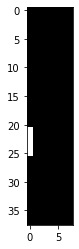

entered if
['Q', 'I', '8', 'J', '9']
Q
saved an img Q
53 67
[ 25  31  53  67  93 105 132 139 160]


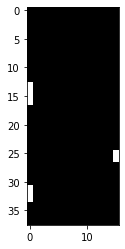

entered if
['Q', 'I', '8', 'J', '9']
I
saved an img I
93 105
[ 25  31  53  67  93 105 132 139 160]


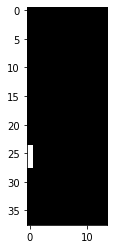

entered if
['Q', 'I', '8', 'J', '9']
8
saved an img 8
132 139
[ 25  31  53  67  93 105 132 139 160]


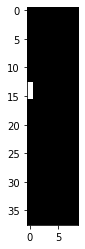

entered if
['Q', 'I', '8', 'J', '9']
J
saved an img J
['Q', 'I', 'Z', 'E', '4']
1 28
[  1  28  33  56  69  92 102 131 140 157]


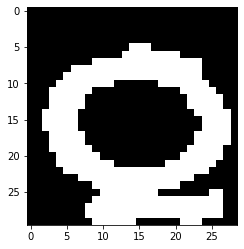

entered if
['Q', 'I', 'Z', 'E', '4']
Q
saved an img Q
33 56
[  1  28  33  56  69  92 102 131 140 157]


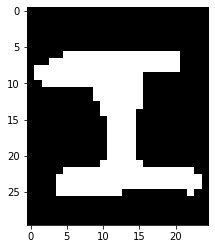

entered if
['Q', 'I', 'Z', 'E', '4']
I
saved an img I
69 92
[  1  28  33  56  69  92 102 131 140 157]


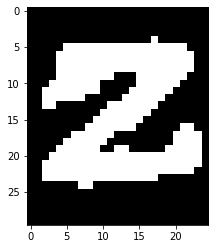

entered if
['Q', 'I', 'Z', 'E', '4']
Z
saved an img Z
102 131
[  1  28  33  56  69  92 102 131 140 157]


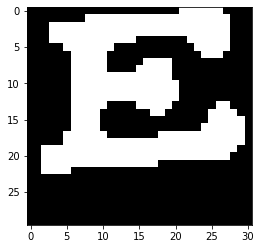

entered if
['Q', 'I', 'Z', 'E', '4']
E
saved an img E
140 157
[  1  28  33  56  69  92 102 131 140 157]


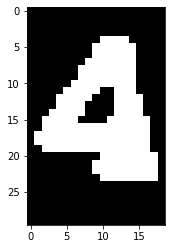

entered if
['Q', 'I', 'Z', 'E', '4']
4
saved an img 4
['Q', 'K', 'L', 'R', 'D']
3 29
[  3  29  32  62  64  94  99 134 138 160]


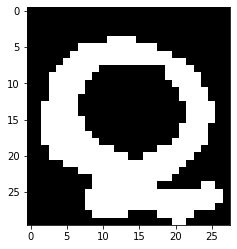

entered if
['Q', 'K', 'L', 'R', 'D']
Q
saved an img Q
32 62
[  3  29  32  62  64  94  99 134 138 160]


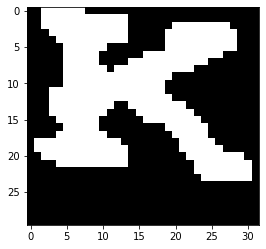

entered if
['Q', 'K', 'L', 'R', 'D']
K
saved an img K
64 94
[  3  29  32  62  64  94  99 134 138 160]


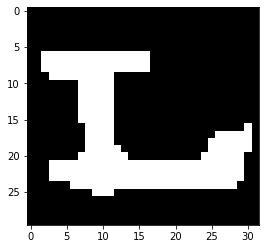

entered if
['Q', 'K', 'L', 'R', 'D']
L
saved an img L
99 134
[  3  29  32  62  64  94  99 134 138 160]


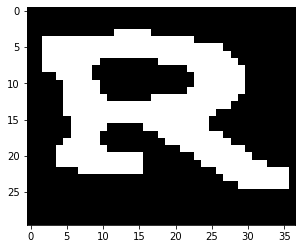

entered if
['Q', 'K', 'L', 'R', 'D']
R
saved an img R
138 160
[  3  29  32  62  64  94  99 134 138 160]


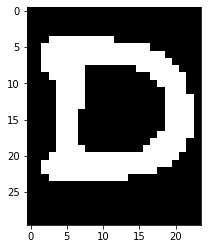

entered if
['Q', 'K', 'L', 'R', 'D']
D
saved an img D
['Q', 'O', '8', '6', 'H']
2 25
[  2  25  28  58  70  92 106 130 135 160]


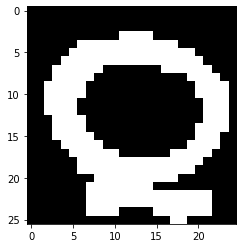

entered if
['Q', 'O', '8', '6', 'H']
Q
saved an img Q
28 58
[  2  25  28  58  70  92 106 130 135 160]


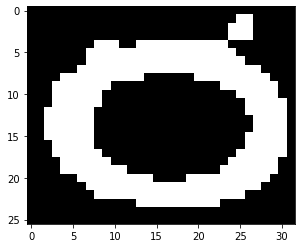

entered if
['Q', 'O', '8', '6', 'H']
O
saved an img O
70 92
[  2  25  28  58  70  92 106 130 135 160]


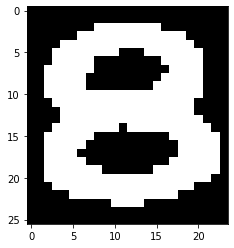

entered if
['Q', 'O', '8', '6', 'H']
8
saved an img 8
106 130
[  2  25  28  58  70  92 106 130 135 160]


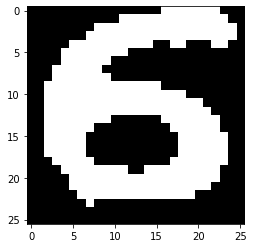

entered if
['Q', 'O', '8', '6', 'H']
6
saved an img 6
135 160
[  2  25  28  58  70  92 106 130 135 160]


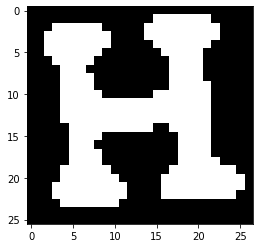

entered if
['Q', 'O', '8', '6', 'H']
H
saved an img H
['Q', 'P', 'T', 'Y', 'T']
25 36
[ 25  36  63  65  94 103 130 137 161]


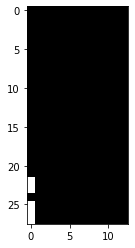

entered if
['Q', 'P', 'T', 'Y', 'T']
Q
saved an img Q
63 65
[ 25  36  63  65  94 103 130 137 161]


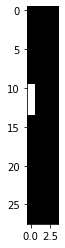

entered if
['Q', 'P', 'T', 'Y', 'T']
P
saved an img P
94 103
[ 25  36  63  65  94 103 130 137 161]


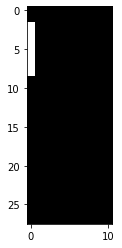

entered if
['Q', 'P', 'T', 'Y', 'T']
T
saved an img T
130 137
[ 25  36  63  65  94 103 130 137 161]


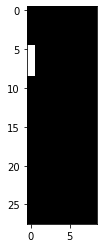

entered if
['Q', 'P', 'T', 'Y', 'T']
Y
saved an img Y
['Q', 'U', 'X', 'P', '3']
2 27
[  2  27  29  59  64  95 107 132 139 156]


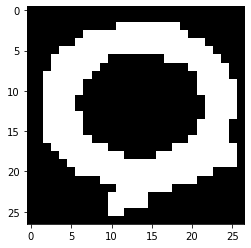

entered if
['Q', 'U', 'X', 'P', '3']
Q
saved an img Q
29 59
[  2  27  29  59  64  95 107 132 139 156]


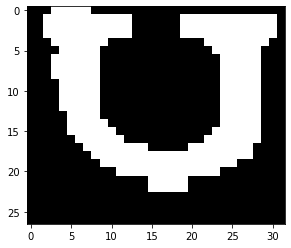

entered if
['Q', 'U', 'X', 'P', '3']
U
saved an img U
64 95
[  2  27  29  59  64  95 107 132 139 156]


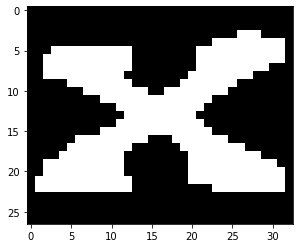

entered if
['Q', 'U', 'X', 'P', '3']
X
saved an img X
107 132
[  2  27  29  59  64  95 107 132 139 156]


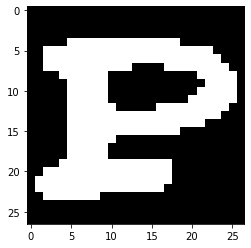

entered if
['Q', 'U', 'X', 'P', '3']
P
saved an img P
139 156
[  2  27  29  59  64  95 107 132 139 156]


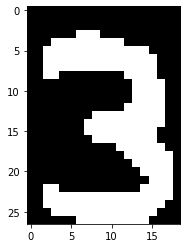

entered if
['Q', 'U', 'X', 'P', '3']
3
saved an img 3
['Q', 'V', 'B', '5', '2']
25 29
[ 25  29  59  66  97 104 130 140 159]


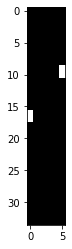

entered if
['Q', 'V', 'B', '5', '2']
Q
saved an img Q
59 66
[ 25  29  59  66  97 104 130 140 159]


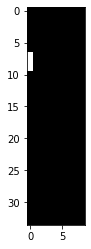

entered if
['Q', 'V', 'B', '5', '2']
V
saved an img V
97 104
[ 25  29  59  66  97 104 130 140 159]


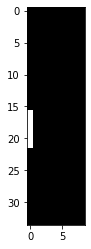

entered if
['Q', 'V', 'B', '5', '2']
B
saved an img B
130 140
[ 25  29  59  66  97 104 130 140 159]


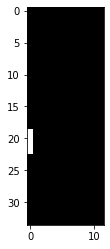

entered if
['Q', 'V', 'B', '5', '2']
5
saved an img 5
['R', '0', 'O', 'Q', 'E']
0 26
[  0  26  33  58  64  94 100 130 134 159]


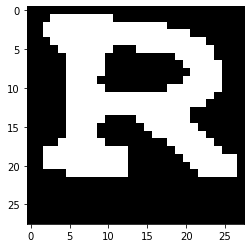

entered if
['R', '0', 'O', 'Q', 'E']
R
saved an img R
33 58
[  0  26  33  58  64  94 100 130 134 159]


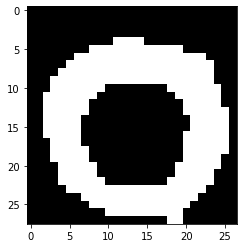

entered if
['R', '0', 'O', 'Q', 'E']
0
saved an img 0
64 94
[  0  26  33  58  64  94 100 130 134 159]


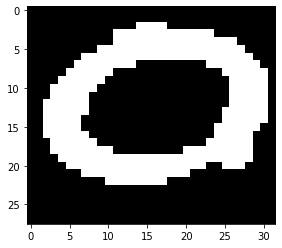

entered if
['R', '0', 'O', 'Q', 'E']
O
saved an img O
100 130
[  0  26  33  58  64  94 100 130 134 159]


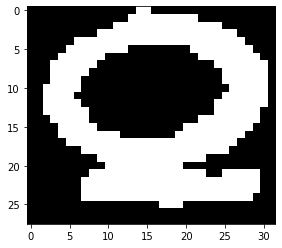

entered if
['R', '0', 'O', 'Q', 'E']
Q
saved an img Q
134 159
[  0  26  33  58  64  94 100 130 134 159]


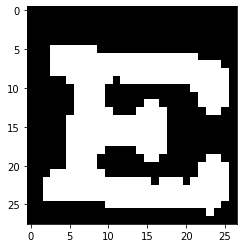

entered if
['R', '0', 'O', 'Q', 'E']
E
saved an img E
['R', '1', 'A', 'U', '8']
24 29
[ 24  29  58  66  98 103 134 138 160]


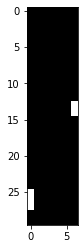

entered if
['R', '1', 'A', 'U', '8']
R
saved an img R
58 66
[ 24  29  58  66  98 103 134 138 160]


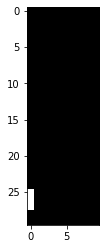

entered if
['R', '1', 'A', 'U', '8']
1
saved an img 1
98 103
[ 24  29  58  66  98 103 134 138 160]


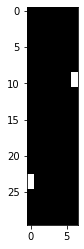

entered if
['R', '1', 'A', 'U', '8']
A
saved an img A
134 138
[ 24  29  58  66  98 103 134 138 160]


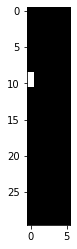

entered if
['R', '1', 'A', 'U', '8']
U
saved an img U
['R', '2', 'M', 'Y', 'R']
0 26
[  0  26  30  54  61 129 135 162]


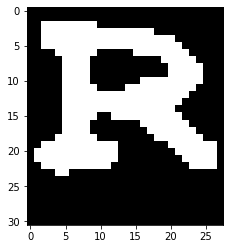

entered if
['R', '2', 'M', 'Y', 'R']
R
saved an img R
30 54
[  0  26  30  54  61 129 135 162]


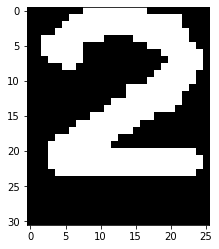

entered if
['R', '2', 'M', 'Y', 'R']
2
saved an img 2
61 129
[  0  26  30  54  61 129 135 162]


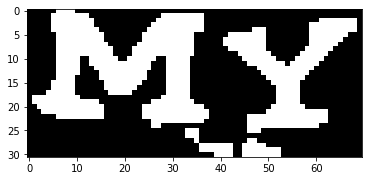

entered if
['R', '2', 'M', 'Y', 'R']
M
saved an img M
135 162
[  0  26  30  54  61 129 135 162]


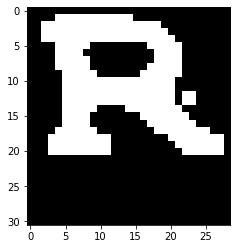

entered if
['R', '2', 'M', 'Y', 'R']
Y
saved an img Y
['R', '4', 'B', '1', 'A']
28 34
[ 28  34  57  58  94 106 128 132 161]


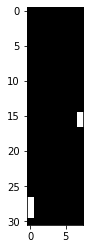

entered if
['R', '4', 'B', '1', 'A']
R
saved an img R
57 58
[ 28  34  57  58  94 106 128 132 161]


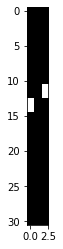

entered if
['R', '4', 'B', '1', 'A']
4
saved an img 4
94 106
[ 28  34  57  58  94 106 128 132 161]


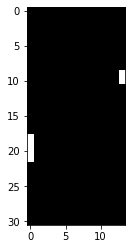

entered if
['R', '4', 'B', '1', 'A']
B
saved an img B
128 132
[ 28  34  57  58  94 106 128 132 161]


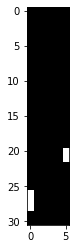

entered if
['R', '4', 'B', '1', 'A']
1
saved an img 1
['R', '8', 'K', 'B', 'Z']
29 32
[ 29  32  56  67  94 104 131 138 161]


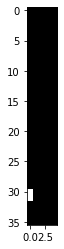

entered if
['R', '8', 'K', 'B', 'Z']
R
saved an img R
56 67
[ 29  32  56  67  94 104 131 138 161]


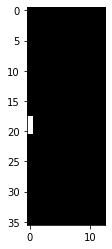

entered if
['R', '8', 'K', 'B', 'Z']
8
saved an img 8
94 104
[ 29  32  56  67  94 104 131 138 161]


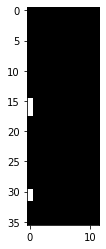

entered if
['R', '8', 'K', 'B', 'Z']
K
saved an img K
131 138
[ 29  32  56  67  94 104 131 138 161]


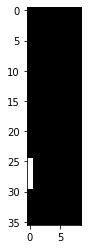

entered if
['R', '8', 'K', 'B', 'Z']
B
saved an img B
['R', '9', 'I', 'G', 'Z']
2 28
[  2  28  35  59  71  92 100 132 136 159]


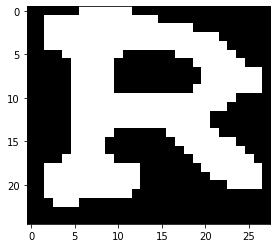

entered if
['R', '9', 'I', 'G', 'Z']
R
saved an img R
35 59
[  2  28  35  59  71  92 100 132 136 159]


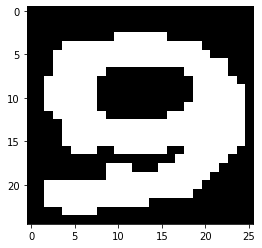

entered if
['R', '9', 'I', 'G', 'Z']
9
saved an img 9
71 92
[  2  28  35  59  71  92 100 132 136 159]


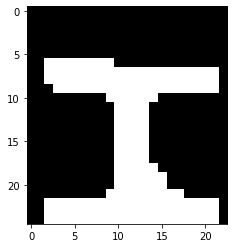

entered if
['R', '9', 'I', 'G', 'Z']
I
saved an img I
100 132
[  2  28  35  59  71  92 100 132 136 159]


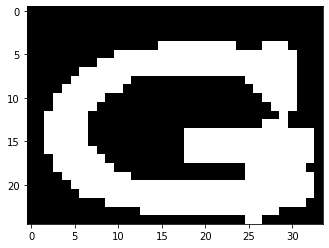

entered if
['R', '9', 'I', 'G', 'Z']
G
saved an img G
136 159
[  2  28  35  59  71  92 100 132 136 159]


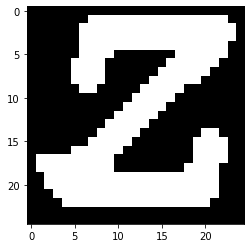

entered if
['R', '9', 'I', 'G', 'Z']
Z
saved an img Z
['R', 'F', 'U', 'P', 'O']
24 32
[ 24  32  97 105 132 138 159]


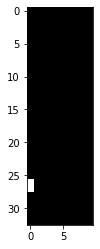

entered if
['R', 'F', 'U', 'P', 'O']
R
saved an img R
97 105
[ 24  32  97 105 132 138 159]


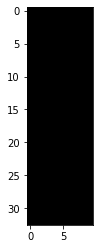

entered if
['R', 'F', 'U', 'P', 'O']
F
saved an img F
132 138
[ 24  32  97 105 132 138 159]


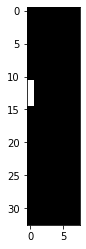

entered if
['R', 'F', 'U', 'P', 'O']
U
saved an img U
['R', 'G', 'L', 'Q', '2']
2 60
[  2  60  67  96 101 132 135 156]


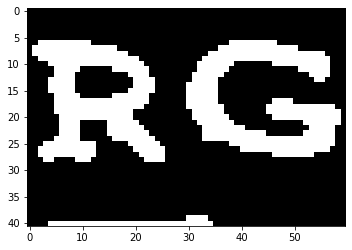

entered if
['R', 'G', 'L', 'Q', '2']
R
saved an img R
67 96
[  2  60  67  96 101 132 135 156]


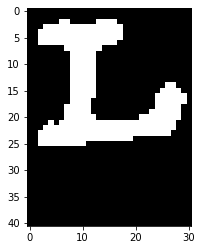

entered if
['R', 'G', 'L', 'Q', '2']
G
saved an img G
101 132
[  2  60  67  96 101 132 135 156]


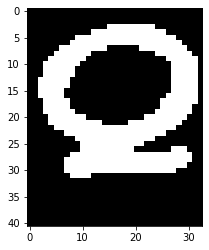

entered if
['R', 'G', 'L', 'Q', '2']
L
saved an img L
135 156
[  2  60  67  96 101 132 135 156]


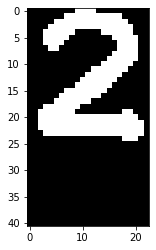

entered if
['R', 'G', 'L', 'Q', '2']
Q
saved an img Q
['R', 'K', 'W', 'E', '6']
3 25
[  3  25  28  60  62  94 102 130 140 158]


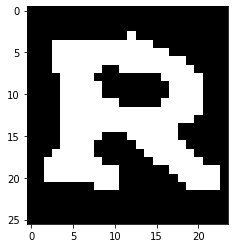

entered if
['R', 'K', 'W', 'E', '6']
R
saved an img R
28 60
[  3  25  28  60  62  94 102 130 140 158]


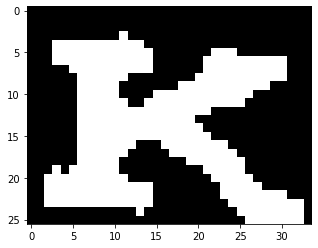

entered if
['R', 'K', 'W', 'E', '6']
K
saved an img K
62 94
[  3  25  28  60  62  94 102 130 140 158]


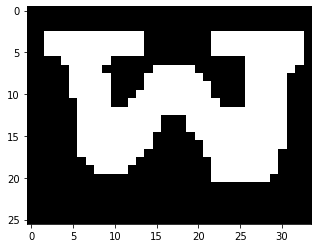

entered if
['R', 'K', 'W', 'E', '6']
W
saved an img W
102 130
[  3  25  28  60  62  94 102 130 140 158]


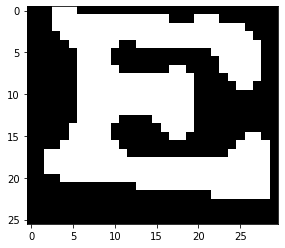

entered if
['R', 'K', 'W', 'E', '6']
E
saved an img E
140 158
[  3  25  28  60  62  94 102 130 140 158]


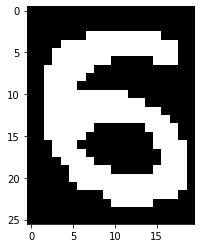

entered if
['R', 'K', 'W', 'E', '6']
6
saved an img 6
['R', 'M', 'P', '7', 'P']
3 26
[  3  26  28  61  68  94 101 128 138 158]


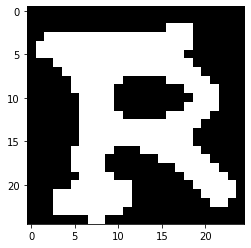

entered if
['R', 'M', 'P', '7', 'P']
R
saved an img R
28 61
[  3  26  28  61  68  94 101 128 138 158]


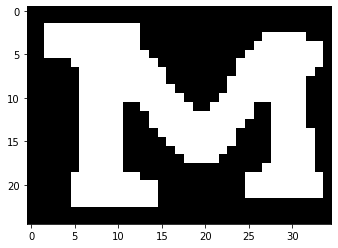

entered if
['R', 'M', 'P', '7', 'P']
M
saved an img M
68 94
[  3  26  28  61  68  94 101 128 138 158]


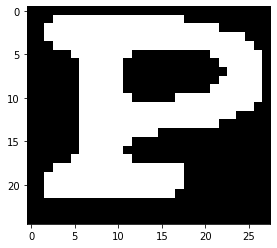

entered if
['R', 'M', 'P', '7', 'P']
P
saved an img P
101 128
[  3  26  28  61  68  94 101 128 138 158]


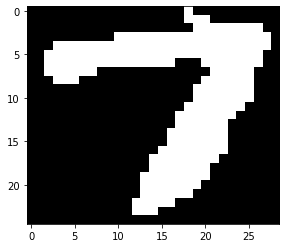

entered if
['R', 'M', 'P', '7', 'P']
7
saved an img 7
138 158
[  3  26  28  61  68  94 101 128 138 158]


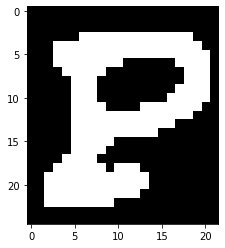

entered if
['R', 'M', 'P', '7', 'P']
P
saved an img P
['R', 'T', 'Y', 'W', 'P']
1 26
[  1  26  32  95  99 134 136 160]


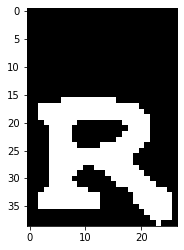

entered if
['R', 'T', 'Y', 'W', 'P']
R
saved an img R
32 95
[  1  26  32  95  99 134 136 160]


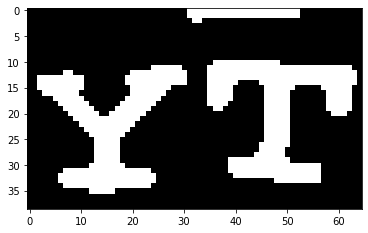

entered if
['R', 'T', 'Y', 'W', 'P']
T
saved an img T
99 134
[  1  26  32  95  99 134 136 160]


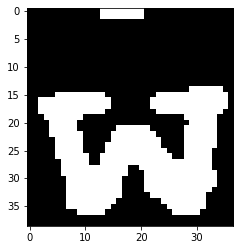

entered if
['R', 'T', 'Y', 'W', 'P']
Y
saved an img Y
136 160
[  1  26  32  95  99 134 136 160]


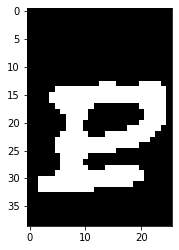

entered if
['R', 'T', 'Y', 'W', 'P']
W
saved an img W
['R', 'W', 'E', '0', 'O']
26 28
[ 26  28  60  66  98 101 127 134 161]


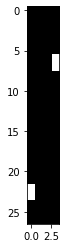

entered if
['R', 'W', 'E', '0', 'O']
R
saved an img R
60 66
[ 26  28  60  66  98 101 127 134 161]


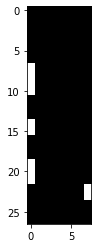

entered if
['R', 'W', 'E', '0', 'O']
W
saved an img W
98 101
[ 26  28  60  66  98 101 127 134 161]


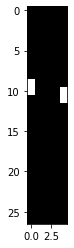

entered if
['R', 'W', 'E', '0', 'O']
E
saved an img E
127 134
[ 26  28  60  66  98 101 127 134 161]


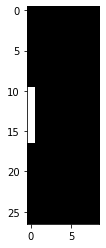

entered if
['R', 'W', 'E', '0', 'O']
0
saved an img 0
['S', '3', 'E', '4', 'Z']
1 22
[  1  22  32  57  64  97 102 125 136 156]


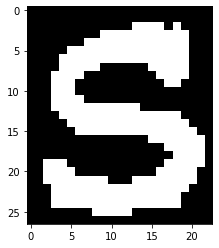

entered if
['S', '3', 'E', '4', 'Z']
S
saved an img S
32 57
[  1  22  32  57  64  97 102 125 136 156]


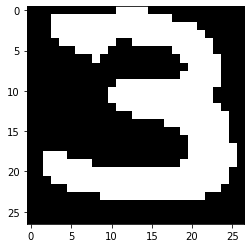

entered if
['S', '3', 'E', '4', 'Z']
3
saved an img 3
64 97
[  1  22  32  57  64  97 102 125 136 156]


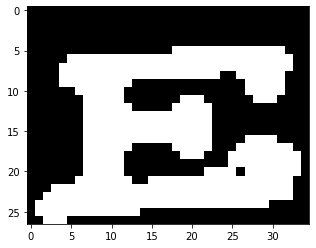

entered if
['S', '3', 'E', '4', 'Z']
E
saved an img E
102 125
[  1  22  32  57  64  97 102 125 136 156]


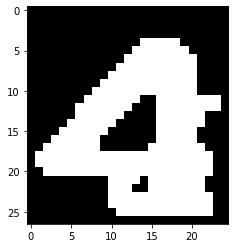

entered if
['S', '3', 'E', '4', 'Z']
4
saved an img 4
136 156
[  1  22  32  57  64  97 102 125 136 156]


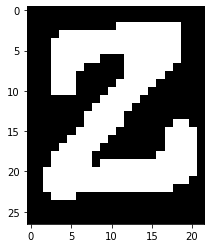

entered if
['S', '3', 'E', '4', 'Z']
Z
saved an img Z
['S', '8', 'M', '7', 'F']
24 32
[ 24  32  56  64  99 106 130 139 160]


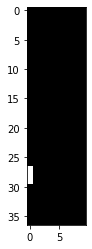

entered if
['S', '8', 'M', '7', 'F']
S
saved an img S
56 64
[ 24  32  56  64  99 106 130 139 160]


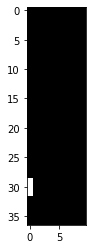

entered if
['S', '8', 'M', '7', 'F']
8
saved an img 8
99 106
[ 24  32  56  64  99 106 130 139 160]


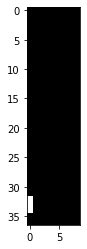

entered if
['S', '8', 'M', '7', 'F']
M
saved an img M
130 139
[ 24  32  56  64  99 106 130 139 160]


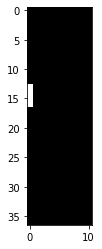

entered if
['S', '8', 'M', '7', 'F']
7
saved an img 7
['S', 'G', 'Y', 'Y', '5']
1 26
[  1  26  30  61  63  95 103 133 138 157]


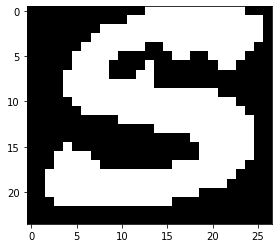

entered if
['S', 'G', 'Y', 'Y', '5']
S
saved an img S
30 61
[  1  26  30  61  63  95 103 133 138 157]


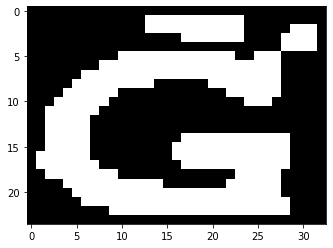

entered if
['S', 'G', 'Y', 'Y', '5']
G
saved an img G
63 95
[  1  26  30  61  63  95 103 133 138 157]


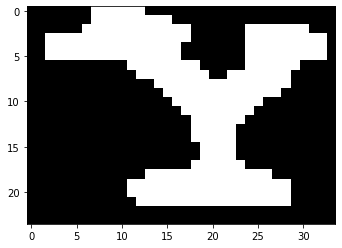

entered if
['S', 'G', 'Y', 'Y', '5']
Y
saved an img Y
103 133
[  1  26  30  61  63  95 103 133 138 157]


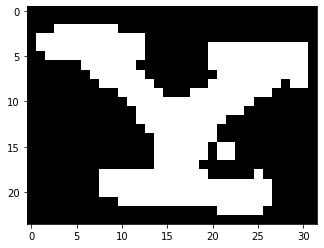

entered if
['S', 'G', 'Y', 'Y', '5']
Y
saved an img Y
138 157
[  1  26  30  61  63  95 103 133 138 157]


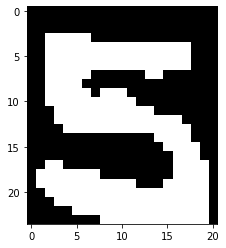

entered if
['S', 'G', 'Y', 'Y', '5']
5
saved an img 5
['S', 'I', 'D', 'S', '7']
5 26
[  5  26  31  56  67  97 104 130 136 156]


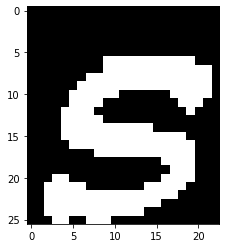

entered if
['S', 'I', 'D', 'S', '7']
S
saved an img S
31 56
[  5  26  31  56  67  97 104 130 136 156]


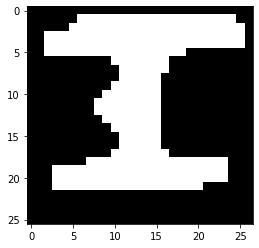

entered if
['S', 'I', 'D', 'S', '7']
I
saved an img I
67 97
[  5  26  31  56  67  97 104 130 136 156]


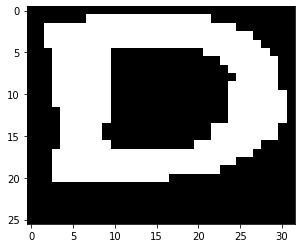

entered if
['S', 'I', 'D', 'S', '7']
D
saved an img D
104 130
[  5  26  31  56  67  97 104 130 136 156]


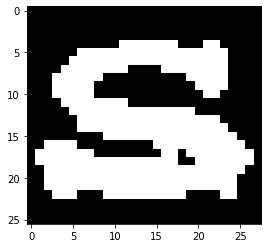

entered if
['S', 'I', 'D', 'S', '7']
S
saved an img S
136 156
[  5  26  31  56  67  97 104 130 136 156]


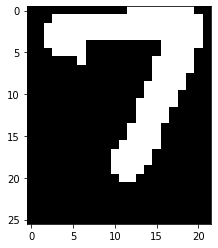

entered if
['S', 'I', 'D', 'S', '7']
7
saved an img 7
['S', 'K', '2', 'K', '6']
5 25
[  5  25  30  62  67  94 101 131 139 158]


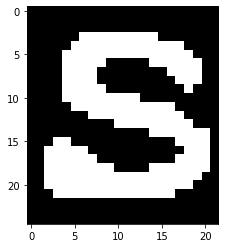

entered if
['S', 'K', '2', 'K', '6']
S
saved an img S
30 62
[  5  25  30  62  67  94 101 131 139 158]


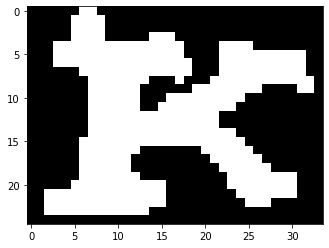

entered if
['S', 'K', '2', 'K', '6']
K
saved an img K
67 94
[  5  25  30  62  67  94 101 131 139 158]


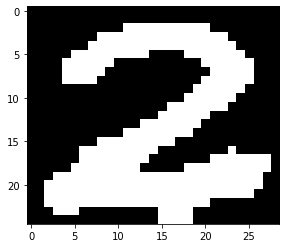

entered if
['S', 'K', '2', 'K', '6']
2
saved an img 2
101 131
[  5  25  30  62  67  94 101 131 139 158]


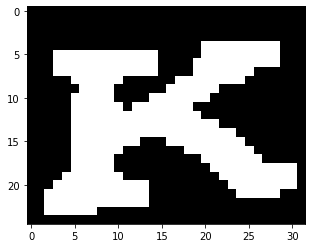

entered if
['S', 'K', '2', 'K', '6']
K
saved an img K
139 158
[  5  25  30  62  67  94 101 131 139 158]


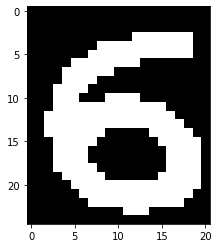

entered if
['S', 'K', '2', 'K', '6']
6
saved an img 6
['S', 'K', '9', '4', 'X']
1 22
[  1  22  30  60  69  95 106 128 136 161]


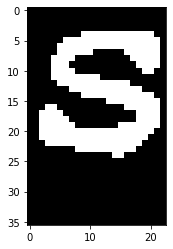

entered if
['S', 'K', '9', '4', 'X']
S
saved an img S
30 60
[  1  22  30  60  69  95 106 128 136 161]


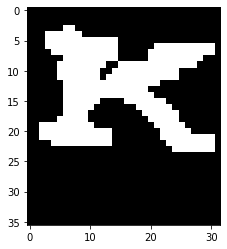

entered if
['S', 'K', '9', '4', 'X']
K
saved an img K
69 95
[  1  22  30  60  69  95 106 128 136 161]


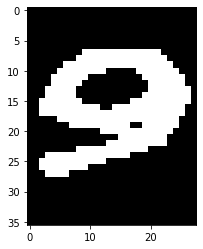

entered if
['S', 'K', '9', '4', 'X']
9
saved an img 9
106 128
[  1  22  30  60  69  95 106 128 136 161]


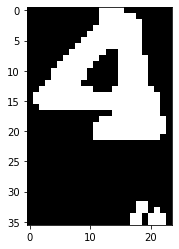

entered if
['S', 'K', '9', '4', 'X']
4
saved an img 4
136 161
[  1  22  30  60  69  95 106 128 136 161]


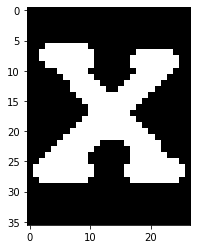

entered if
['S', 'K', '9', '4', 'X']
X
saved an img X
['T', '3', '8', 'X', 'J']
4 25
[  4  25  31  59  68  92 106 134 135 159]


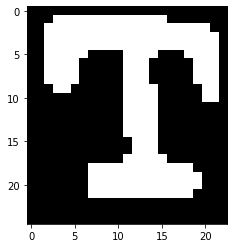

entered if
['T', '3', '8', 'X', 'J']
T
saved an img T
31 59
[  4  25  31  59  68  92 106 134 135 159]


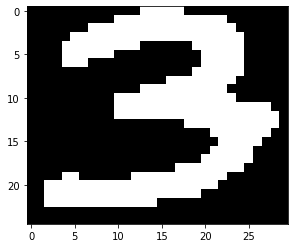

entered if
['T', '3', '8', 'X', 'J']
3
saved an img 3
68 92
[  4  25  31  59  68  92 106 134 135 159]


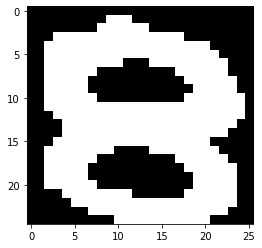

entered if
['T', '3', '8', 'X', 'J']
8
saved an img 8
106 134
[  4  25  31  59  68  92 106 134 135 159]


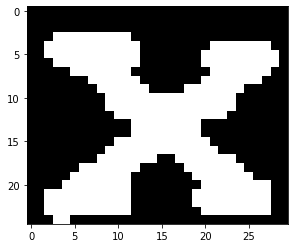

entered if
['T', '3', '8', 'X', 'J']
X
saved an img X
135 159
[  4  25  31  59  68  92 106 134 135 159]


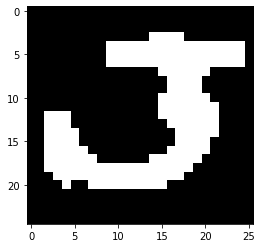

entered if
['T', '3', '8', 'X', 'J']
J
saved an img J
['T', '4', '5', 'H', 'B']
24 32
[ 24  32  54  67  91 102 132 136 159]


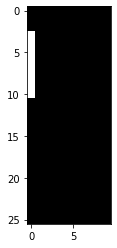

entered if
['T', '4', '5', 'H', 'B']
T
saved an img T
54 67
[ 24  32  54  67  91 102 132 136 159]


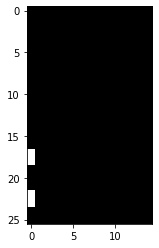

entered if
['T', '4', '5', 'H', 'B']
4
saved an img 4
91 102
[ 24  32  54  67  91 102 132 136 159]


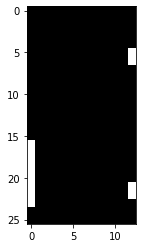

entered if
['T', '4', '5', 'H', 'B']
5
saved an img 5
132 136
[ 24  32  54  67  91 102 132 136 159]


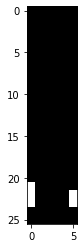

entered if
['T', '4', '5', 'H', 'B']
H
saved an img H
['T', '8', 'D', 'Q', 'T']
1 26
[  1  26  30  59  66  95 100 133 137 159]


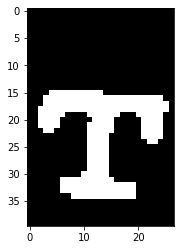

entered if
['T', '8', 'D', 'Q', 'T']
T
saved an img T
30 59
[  1  26  30  59  66  95 100 133 137 159]


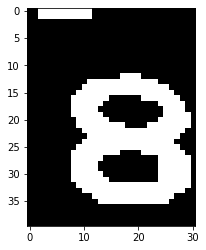

entered if
['T', '8', 'D', 'Q', 'T']
8
saved an img 8
66 95
[  1  26  30  59  66  95 100 133 137 159]


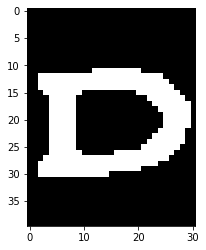

entered if
['T', '8', 'D', 'Q', 'T']
D
saved an img D
100 133
[  1  26  30  59  66  95 100 133 137 159]


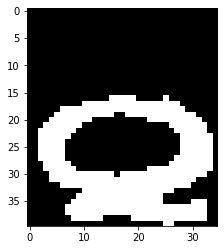

entered if
['T', '8', 'D', 'Q', 'T']
Q
saved an img Q
137 159
[  1  26  30  59  66  95 100 133 137 159]


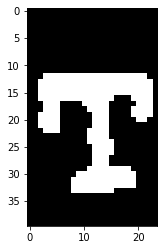

entered if
['T', '8', 'D', 'Q', 'T']
T
saved an img T
['T', 'B', 'S', 'E', 'M']
3 26
[  3  26  29  57  69  96  99 130 133 161]


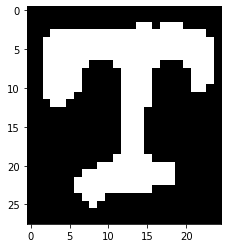

entered if
['T', 'B', 'S', 'E', 'M']
T
saved an img T
29 57
[  3  26  29  57  69  96  99 130 133 161]


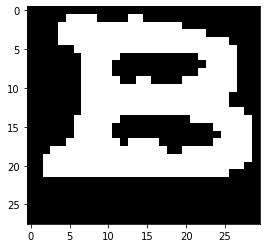

entered if
['T', 'B', 'S', 'E', 'M']
B
saved an img B
69 96
[  3  26  29  57  69  96  99 130 133 161]


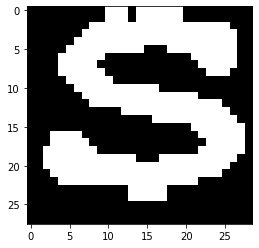

entered if
['T', 'B', 'S', 'E', 'M']
S
saved an img S
99 130
[  3  26  29  57  69  96  99 130 133 161]


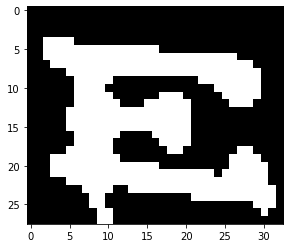

entered if
['T', 'B', 'S', 'E', 'M']
E
saved an img E
133 161
[  3  26  29  57  69  96  99 130 133 161]


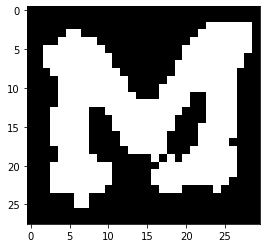

entered if
['T', 'B', 'S', 'E', 'M']
M
saved an img M
['T', 'G', '1', 'W', 'C']
2 26
[  2  26  31  60  71  93 102 158]


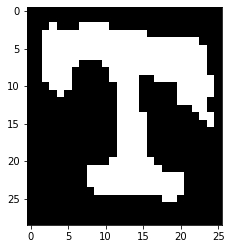

entered if
['T', 'G', '1', 'W', 'C']
T
saved an img T
31 60
[  2  26  31  60  71  93 102 158]


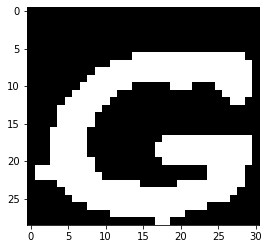

entered if
['T', 'G', '1', 'W', 'C']
G
saved an img G
71 93
[  2  26  31  60  71  93 102 158]


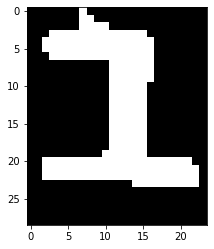

entered if
['T', 'G', '1', 'W', 'C']
1
saved an img 1
102 158
[  2  26  31  60  71  93 102 158]


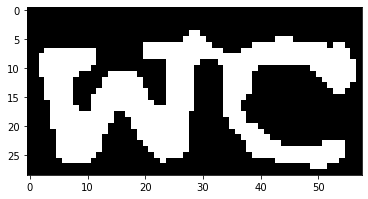

entered if
['T', 'G', '1', 'W', 'C']
W
saved an img W
['T', 'H', '7', '6', 'V']
1 27
[  1  27  29  57  69  93 102 127 138 161]


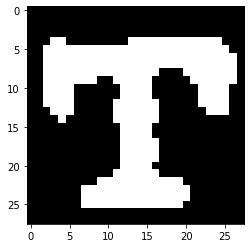

entered if
['T', 'H', '7', '6', 'V']
T
saved an img T
29 57
[  1  27  29  57  69  93 102 127 138 161]


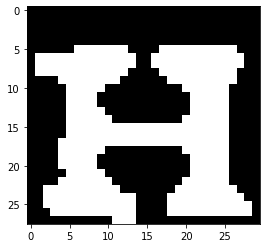

entered if
['T', 'H', '7', '6', 'V']
H
saved an img H
69 93
[  1  27  29  57  69  93 102 127 138 161]


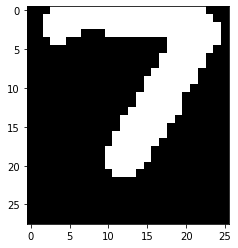

entered if
['T', 'H', '7', '6', 'V']
7
saved an img 7
102 127
[  1  27  29  57  69  93 102 127 138 161]


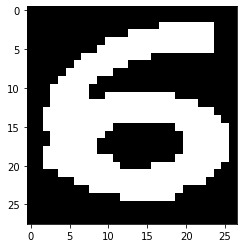

entered if
['T', 'H', '7', '6', 'V']
6
saved an img 6
138 161
[  1  27  29  57  69  93 102 127 138 161]


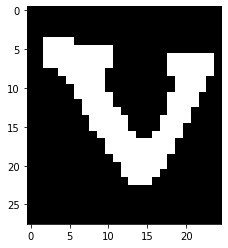

entered if
['T', 'H', '7', '6', 'V']
V
saved an img V
['T', 'H', 'O', 'I', 'L']
1 28
[  1  28  29  59  66  97 106 127 137 160]


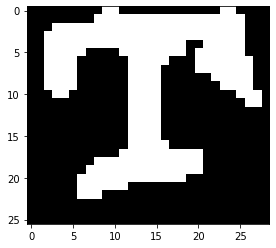

entered if
['T', 'H', 'O', 'I', 'L']
T
saved an img T
29 59
[  1  28  29  59  66  97 106 127 137 160]


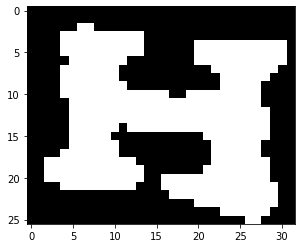

entered if
['T', 'H', 'O', 'I', 'L']
H
saved an img H
66 97
[  1  28  29  59  66  97 106 127 137 160]


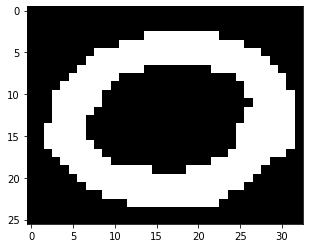

entered if
['T', 'H', 'O', 'I', 'L']
O
saved an img O
106 127
[  1  28  29  59  66  97 106 127 137 160]


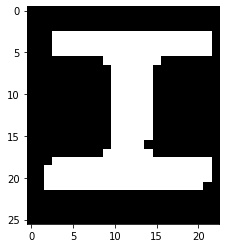

entered if
['T', 'H', 'O', 'I', 'L']
I
saved an img I
137 160
[  1  28  29  59  66  97 106 127 137 160]


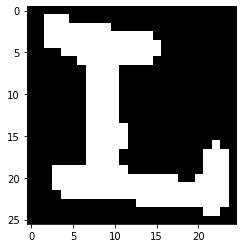

entered if
['T', 'H', 'O', 'I', 'L']
L
saved an img L
['T', 'K', 'O', 'E', '8']
27 31
[ 27  31  62  71  93 100 129 136 157]


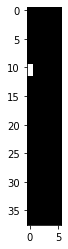

entered if
['T', 'K', 'O', 'E', '8']
T
saved an img T
62 71
[ 27  31  62  71  93 100 129 136 157]


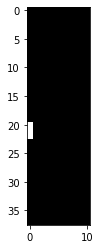

entered if
['T', 'K', 'O', 'E', '8']
K
saved an img K
93 100
[ 27  31  62  71  93 100 129 136 157]


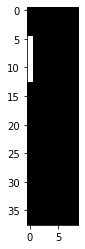

entered if
['T', 'K', 'O', 'E', '8']
O
saved an img O
129 136
[ 27  31  62  71  93 100 129 136 157]


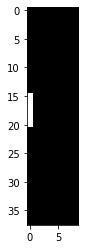

entered if
['T', 'K', 'O', 'E', '8']
E
saved an img E
['T', 'L', 'O', 'J', '6']
1 25
[  1  25  32  63  69  97 100 134 141 160]


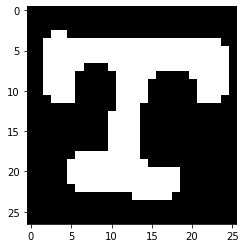

entered if
['T', 'L', 'O', 'J', '6']
T
saved an img T
32 63
[  1  25  32  63  69  97 100 134 141 160]


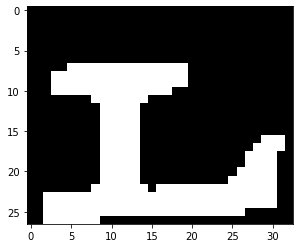

entered if
['T', 'L', 'O', 'J', '6']
L
saved an img L
69 97
[  1  25  32  63  69  97 100 134 141 160]


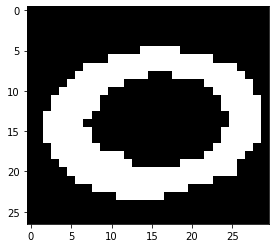

entered if
['T', 'L', 'O', 'J', '6']
O
saved an img O
100 134
[  1  25  32  63  69  97 100 134 141 160]


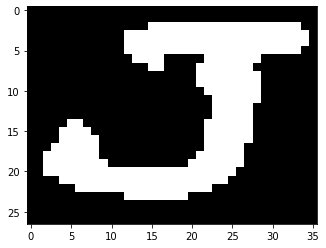

entered if
['T', 'L', 'O', 'J', '6']
J
saved an img J
141 160
[  1  25  32  63  69  97 100 134 141 160]


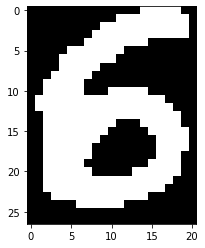

entered if
['T', 'L', 'O', 'J', '6']
6
saved an img 6
['T', 'M', '2', 'F', '5']
2 22
[  2  22  28  63  64  89 102 134 138 158]


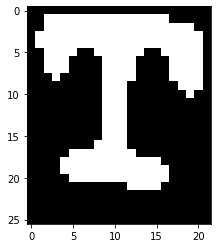

entered if
['T', 'M', '2', 'F', '5']
T
saved an img T
28 63
[  2  22  28  63  64  89 102 134 138 158]


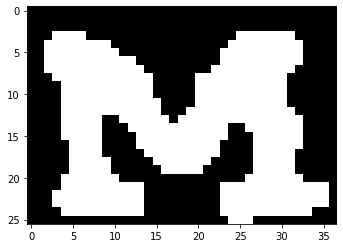

entered if
['T', 'M', '2', 'F', '5']
M
saved an img M
64 89
[  2  22  28  63  64  89 102 134 138 158]


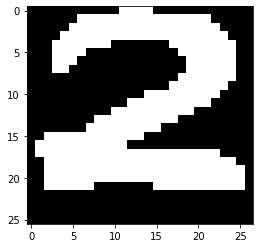

entered if
['T', 'M', '2', 'F', '5']
2
saved an img 2
102 134
[  2  22  28  63  64  89 102 134 138 158]


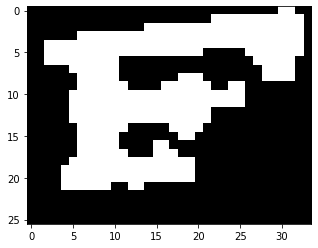

entered if
['T', 'M', '2', 'F', '5']
F
saved an img F
138 158
[  2  22  28  63  64  89 102 134 138 158]


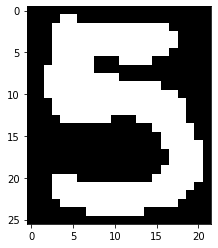

entered if
['T', 'M', '2', 'F', '5']
5
saved an img 5
['T', 'N', '9', 'W', '2']
1 26
[  1  26  29  60  69  94  98 131 136 157]


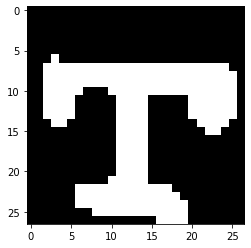

entered if
['T', 'N', '9', 'W', '2']
T
saved an img T
29 60
[  1  26  29  60  69  94  98 131 136 157]


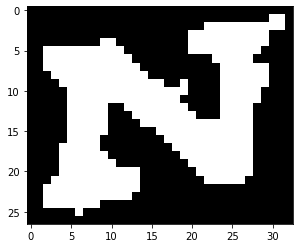

entered if
['T', 'N', '9', 'W', '2']
N
saved an img N
69 94
[  1  26  29  60  69  94  98 131 136 157]


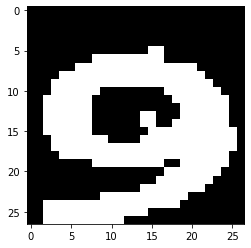

entered if
['T', 'N', '9', 'W', '2']
9
saved an img 9
98 131
[  1  26  29  60  69  94  98 131 136 157]


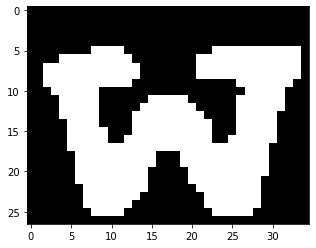

entered if
['T', 'N', '9', 'W', '2']
W
saved an img W
136 157
[  1  26  29  60  69  94  98 131 136 157]


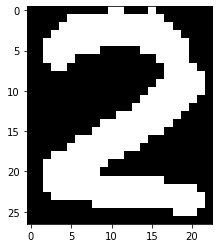

entered if
['T', 'N', '9', 'W', '2']
2
saved an img 2
['T', 'N', 'E', 'J', '1']
1 26
[  1  26  28  58  70  98 102 135 136 155]


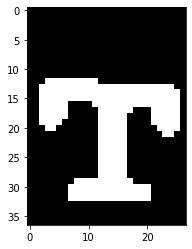

entered if
['T', 'N', 'E', 'J', '1']
T
saved an img T
28 58
[  1  26  28  58  70  98 102 135 136 155]


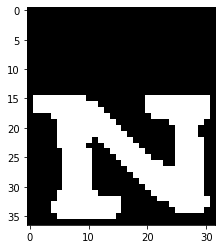

entered if
['T', 'N', 'E', 'J', '1']
N
saved an img N
70 98
[  1  26  28  58  70  98 102 135 136 155]


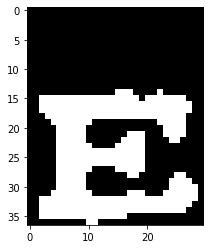

entered if
['T', 'N', 'E', 'J', '1']
E
saved an img E
102 135
[  1  26  28  58  70  98 102 135 136 155]


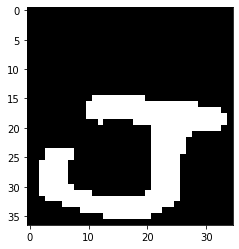

entered if
['T', 'N', 'E', 'J', '1']
J
saved an img J
136 155
[  1  26  28  58  70  98 102 135 136 155]


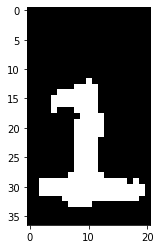

entered if
['T', 'N', 'E', 'J', '1']
1
saved an img 1
['T', 'P', 'D', 'W', 'T']
22 36
[ 22  36  62  67  94 102 132 137 159]


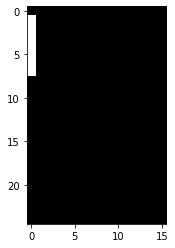

entered if
['T', 'P', 'D', 'W', 'T']
T
saved an img T
62 67
[ 22  36  62  67  94 102 132 137 159]


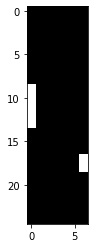

entered if
['T', 'P', 'D', 'W', 'T']
P
saved an img P
94 102
[ 22  36  62  67  94 102 132 137 159]


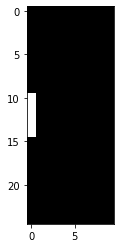

entered if
['T', 'P', 'D', 'W', 'T']
D
saved an img D
132 137
[ 22  36  62  67  94 102 132 137 159]


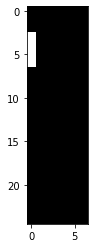

entered if
['T', 'P', 'D', 'W', 'T']
W
saved an img W
['T', 'Q', 'E', 'S', 'A']
24 27
[ 24  27  58  66  95 107 131 135 159]


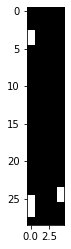

entered if
['T', 'Q', 'E', 'S', 'A']
T
saved an img T
58 66
[ 24  27  58  66  95 107 131 135 159]


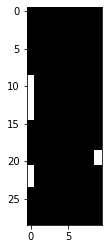

entered if
['T', 'Q', 'E', 'S', 'A']
Q
saved an img Q
95 107
[ 24  27  58  66  95 107 131 135 159]


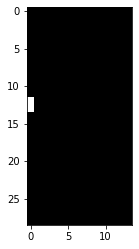

entered if
['T', 'Q', 'E', 'S', 'A']
E
saved an img E
131 135
[ 24  27  58  66  95 107 131 135 159]


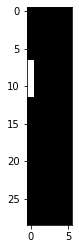

entered if
['T', 'Q', 'E', 'S', 'A']
S
saved an img S
['T', 'S', 'I', 'O', 'P']
2 23
[  2  23  30  56  70  93  99 129 135 158]


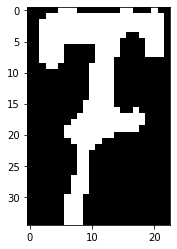

entered if
['T', 'S', 'I', 'O', 'P']
T
saved an img T
30 56
[  2  23  30  56  70  93  99 129 135 158]


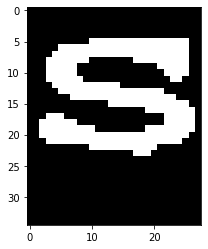

entered if
['T', 'S', 'I', 'O', 'P']
S
saved an img S
70 93
[  2  23  30  56  70  93  99 129 135 158]


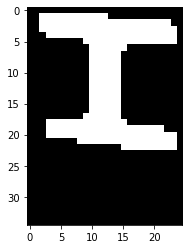

entered if
['T', 'S', 'I', 'O', 'P']
I
saved an img I
99 129
[  2  23  30  56  70  93  99 129 135 158]


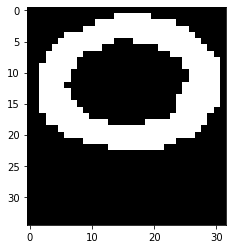

entered if
['T', 'S', 'I', 'O', 'P']
O
saved an img O
135 158
[  2  23  30  56  70  93  99 129 135 158]


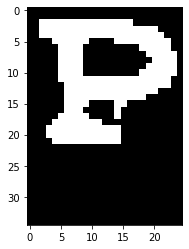

entered if
['T', 'S', 'I', 'O', 'P']
P
saved an img P
['T', 'T', 'E', 'O', 'L']
25 29
[ 25  29  58  67  95 103 161]


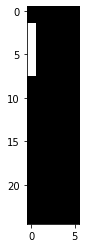

entered if
['T', 'T', 'E', 'O', 'L']
T
saved an img T
58 67
[ 25  29  58  67  95 103 161]


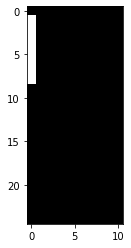

entered if
['T', 'T', 'E', 'O', 'L']
T
saved an img T
95 103
[ 25  29  58  67  95 103 161]


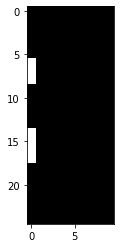

entered if
['T', 'T', 'E', 'O', 'L']
E
saved an img E
['T', 'W', 'V', '4', '1']
0 60
[  0  60  65  97 105 127 139 159]


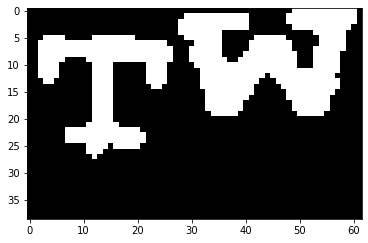

entered if
['T', 'W', 'V', '4', '1']
T
saved an img T
65 97
[  0  60  65  97 105 127 139 159]


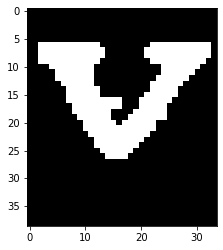

entered if
['T', 'W', 'V', '4', '1']
W
saved an img W
105 127
[  0  60  65  97 105 127 139 159]


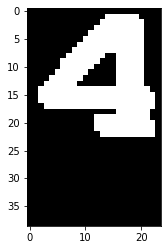

entered if
['T', 'W', 'V', '4', '1']
V
saved an img V
139 159
[  0  60  65  97 105 127 139 159]


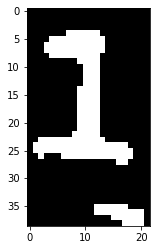

entered if
['T', 'W', 'V', '4', '1']
4
saved an img 4
['T', 'Y', 'H', 'E', 'M']
2 24
[  2  24  27  56  66  96 100 132 133 160]


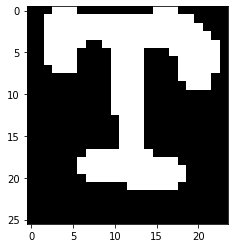

entered if
['T', 'Y', 'H', 'E', 'M']
T
saved an img T
27 56
[  2  24  27  56  66  96 100 132 133 160]


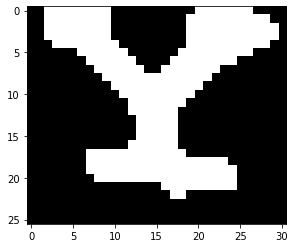

entered if
['T', 'Y', 'H', 'E', 'M']
Y
saved an img Y
66 96
[  2  24  27  56  66  96 100 132 133 160]


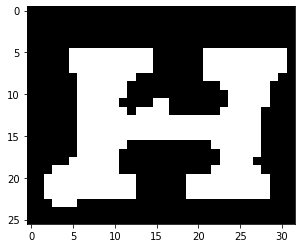

entered if
['T', 'Y', 'H', 'E', 'M']
H
saved an img H
100 132
[  2  24  27  56  66  96 100 132 133 160]


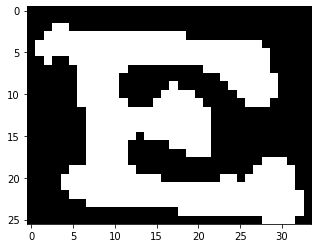

entered if
['T', 'Y', 'H', 'E', 'M']
E
saved an img E
133 160
[  2  24  27  56  66  96 100 132 133 160]


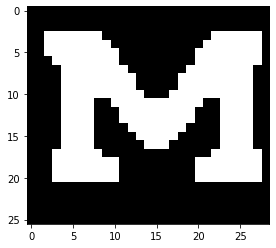

entered if
['T', 'Y', 'H', 'E', 'M']
M
saved an img M
['T', 'Z', 'L', '5', 'J']
1 26
[  1  26  29  58  67  99 102 128 139 159]


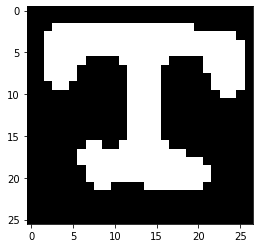

entered if
['T', 'Z', 'L', '5', 'J']
T
saved an img T
29 58
[  1  26  29  58  67  99 102 128 139 159]


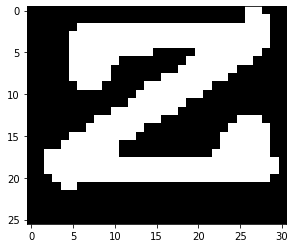

entered if
['T', 'Z', 'L', '5', 'J']
Z
saved an img Z
67 99
[  1  26  29  58  67  99 102 128 139 159]


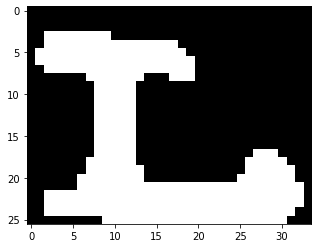

entered if
['T', 'Z', 'L', '5', 'J']
L
saved an img L
102 128
[  1  26  29  58  67  99 102 128 139 159]


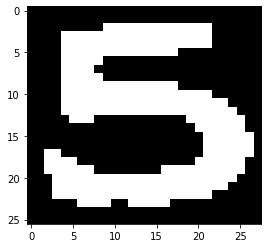

entered if
['T', 'Z', 'L', '5', 'J']
5
saved an img 5
139 159
[  1  26  29  58  67  99 102 128 139 159]


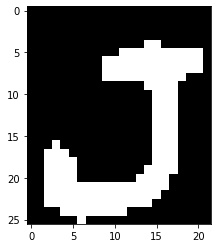

entered if
['T', 'Z', 'L', '5', 'J']
J
saved an img J
['U', '7', 'I', 'I', 'A']
4 28
[  4  28  34  57  68  92 102 126 134 163]


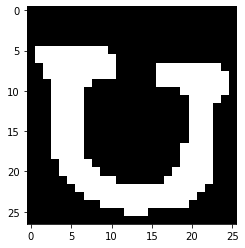

entered if
['U', '7', 'I', 'I', 'A']
U
saved an img U
34 57
[  4  28  34  57  68  92 102 126 134 163]


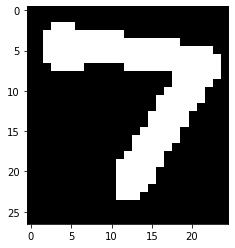

entered if
['U', '7', 'I', 'I', 'A']
7
saved an img 7
68 92
[  4  28  34  57  68  92 102 126 134 163]


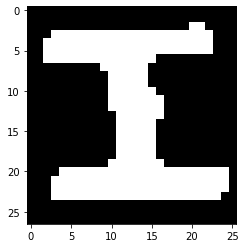

entered if
['U', '7', 'I', 'I', 'A']
I
saved an img I
102 126
[  4  28  34  57  68  92 102 126 134 163]


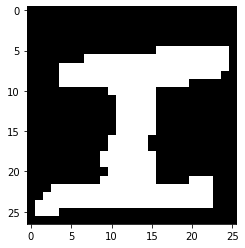

entered if
['U', '7', 'I', 'I', 'A']
I
saved an img I
134 163
[  4  28  34  57  68  92 102 126 134 163]


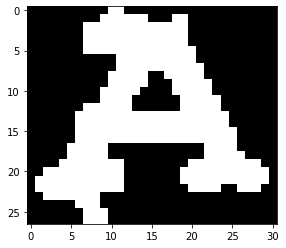

entered if
['U', '7', 'I', 'I', 'A']
A
saved an img A
['U', 'A', '5', 'Z', '6']
22 28
[ 22  28  62  68 132 135 156]


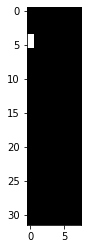

entered if
['U', 'A', '5', 'Z', '6']
U
saved an img U
62 68
[ 22  28  62  68 132 135 156]


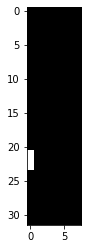

entered if
['U', 'A', '5', 'Z', '6']
A
saved an img A
132 135
[ 22  28  62  68 132 135 156]


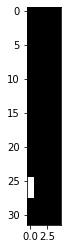

entered if
['U', 'A', '5', 'Z', '6']
5
saved an img 5
['U', 'G', 'K', 'Q', '8']
22 31
[ 22  31  61  67  96 101 131 140 158]


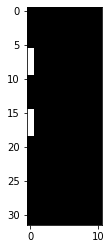

entered if
['U', 'G', 'K', 'Q', '8']
U
saved an img U
61 67
[ 22  31  61  67  96 101 131 140 158]


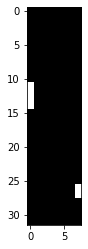

entered if
['U', 'G', 'K', 'Q', '8']
G
saved an img G
96 101
[ 22  31  61  67  96 101 131 140 158]


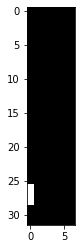

entered if
['U', 'G', 'K', 'Q', '8']
K
saved an img K
131 140
[ 22  31  61  67  96 101 131 140 158]


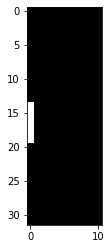

entered if
['U', 'G', 'K', 'Q', '8']
Q
saved an img Q
['U', 'P', 'D', 'R', '6']
21 36
[ 21  36  62  64  92 105 137 139 158]


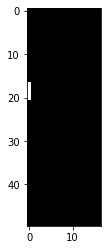

entered if
['U', 'P', 'D', 'R', '6']
U
saved an img U
62 64
[ 21  36  62  64  92 105 137 139 158]


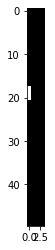

entered if
['U', 'P', 'D', 'R', '6']
P
saved an img P
92 105
[ 21  36  62  64  92 105 137 139 158]


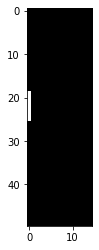

entered if
['U', 'P', 'D', 'R', '6']
D
saved an img D
137 139
[ 21  36  62  64  92 105 137 139 158]


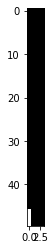

entered if
['U', 'P', 'D', 'R', '6']
R
saved an img R
['U', 'V', 'Y', 'Q', 'B']
23 26
[ 23  26  62  64  92 103 157]


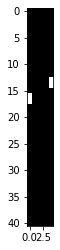

entered if
['U', 'V', 'Y', 'Q', 'B']
U
saved an img U
62 64
[ 23  26  62  64  92 103 157]


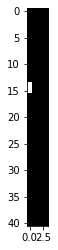

entered if
['U', 'V', 'Y', 'Q', 'B']
V
saved an img V
92 103
[ 23  26  62  64  92 103 157]


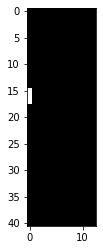

entered if
['U', 'V', 'Y', 'Q', 'B']
Y
saved an img Y
['U', 'X', 'F', 'R', 'Z']
23 29
[ 23  29  95 100 131 138 159]


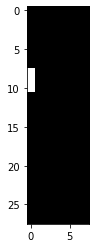

entered if
['U', 'X', 'F', 'R', 'Z']
U
saved an img U
95 100
[ 23  29  95 100 131 138 159]


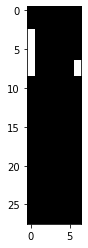

entered if
['U', 'X', 'F', 'R', 'Z']
X
saved an img X
131 138
[ 23  29  95 100 131 138 159]


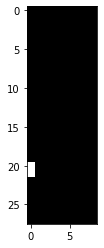

entered if
['U', 'X', 'F', 'R', 'Z']
F
saved an img F
['U', 'Z', '3', 'T', 'E']
25 31
[ 25  31  56  70  95 102 131 133 158]


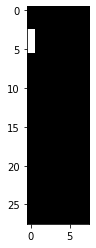

entered if
['U', 'Z', '3', 'T', 'E']
U
saved an img U
56 70
[ 25  31  56  70  95 102 131 133 158]


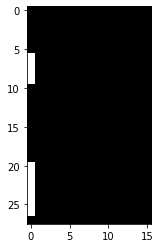

entered if
['U', 'Z', '3', 'T', 'E']
Z
saved an img Z
95 102
[ 25  31  56  70  95 102 131 133 158]


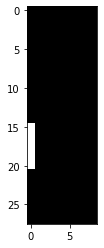

entered if
['U', 'Z', '3', 'T', 'E']
3
saved an img 3
131 133
[ 25  31  56  70  95 102 131 133 158]


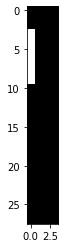

entered if
['U', 'Z', '3', 'T', 'E']
T
saved an img T
['V', '1', 'F', 'O', 'R']
0 27
[  0  27  33  54  64  97 101 134 135 161]


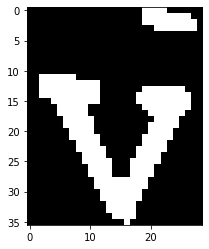

entered if
['V', '1', 'F', 'O', 'R']
V
saved an img V
33 54
[  0  27  33  54  64  97 101 134 135 161]


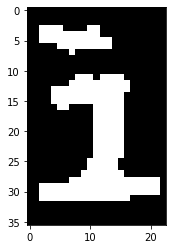

entered if
['V', '1', 'F', 'O', 'R']
1
saved an img 1
64 97
[  0  27  33  54  64  97 101 134 135 161]


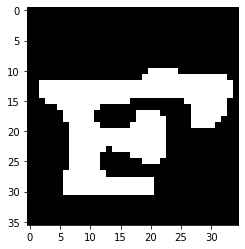

entered if
['V', '1', 'F', 'O', 'R']
F
saved an img F
101 134
[  0  27  33  54  64  97 101 134 135 161]


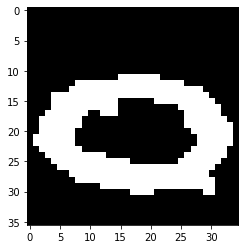

entered if
['V', '1', 'F', 'O', 'R']
O
saved an img O
135 161
[  0  27  33  54  64  97 101 134 135 161]


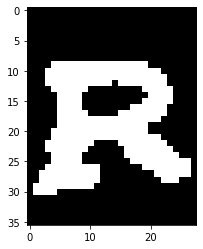

entered if
['V', '1', 'F', 'O', 'R']
R
saved an img R
['V', '3', 'D', '4', 'X']
25 30
[ 25  30  56  65  95 104 129 138 160]


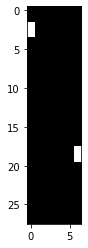

entered if
['V', '3', 'D', '4', 'X']
V
saved an img V
56 65
[ 25  30  56  65  95 104 129 138 160]


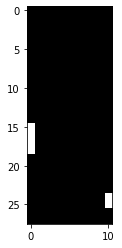

entered if
['V', '3', 'D', '4', 'X']
3
saved an img 3
95 104
[ 25  30  56  65  95 104 129 138 160]


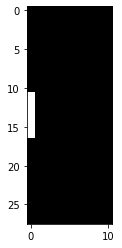

entered if
['V', '3', 'D', '4', 'X']
D
saved an img D
129 138
[ 25  30  56  65  95 104 129 138 160]


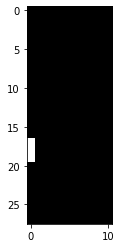

entered if
['V', '3', 'D', '4', 'X']
4
saved an img 4
['V', '3', 'J', 'A', 'J']
27 31
[ 27  31  56  67 132 138]


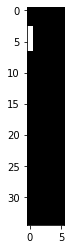

entered if
['V', '3', 'J', 'A', 'J']
V
saved an img V
56 67
[ 27  31  56  67 132 138]


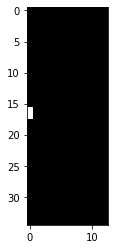

entered if
['V', '3', 'J', 'A', 'J']
3
saved an img 3
132 138
[ 27  31  56  67 132 138]


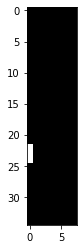

entered if
['V', '3', 'J', 'A', 'J']
J
saved an img J
['V', '9', 'J', 'C', '0']
58 65
[ 58  65  96 103 134 140 160]


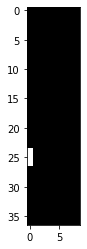

entered if
['V', '9', 'J', 'C', '0']
V
saved an img V
96 103
[ 58  65  96 103 134 140 160]


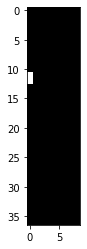

entered if
['V', '9', 'J', 'C', '0']
9
saved an img 9
134 140
[ 58  65  96 103 134 140 160]


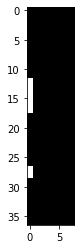

entered if
['V', '9', 'J', 'C', '0']
J
saved an img J
['V', 'E', '3', '4', 'M']
25 32
[ 25  32  60  72  95 102 125 132 161]


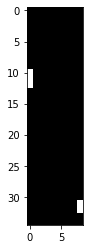

entered if
['V', 'E', '3', '4', 'M']
V
saved an img V
60 72
[ 25  32  60  72  95 102 125 132 161]


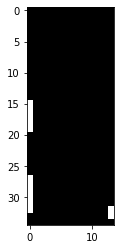

entered if
['V', 'E', '3', '4', 'M']
E
saved an img E
95 102
[ 25  32  60  72  95 102 125 132 161]


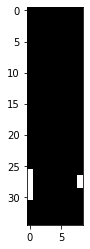

entered if
['V', 'E', '3', '4', 'M']
3
saved an img 3
125 132
[ 25  32  60  72  95 102 125 132 161]


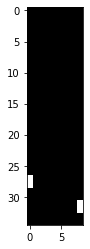

entered if
['V', 'E', '3', '4', 'M']
4
saved an img 4
['V', 'E', 'X', '2', '3']
26 33
[ 26  33  62  65  99 102 131 138 159]


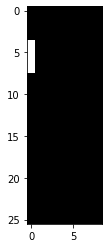

entered if
['V', 'E', 'X', '2', '3']
V
saved an img V
62 65
[ 26  33  62  65  99 102 131 138 159]


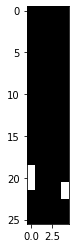

entered if
['V', 'E', 'X', '2', '3']
E
saved an img E
99 102
[ 26  33  62  65  99 102 131 138 159]


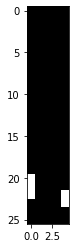

entered if
['V', 'E', 'X', '2', '3']
X
saved an img X
131 138
[ 26  33  62  65  99 102 131 138 159]


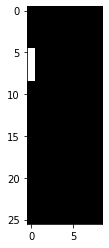

entered if
['V', 'E', 'X', '2', '3']
2
saved an img 2
['V', 'F', 'E', 'G', 'M']
26 28
[ 26  28  61  65  96 102 132 133 164]


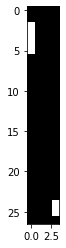

entered if
['V', 'F', 'E', 'G', 'M']
V
saved an img V
61 65
[ 26  28  61  65  96 102 132 133 164]


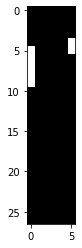

entered if
['V', 'F', 'E', 'G', 'M']
F
saved an img F
96 102
[ 26  28  61  65  96 102 132 133 164]


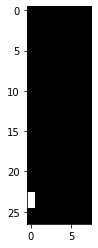

entered if
['V', 'F', 'E', 'G', 'M']
E
saved an img E
132 133
[ 26  28  61  65  96 102 132 133 164]


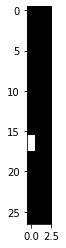

entered if
['V', 'F', 'E', 'G', 'M']
G
saved an img G
['V', 'F', 'I', '5', 'A']
0 25
[  0  25  31  60  69  91 104 131 136 160]


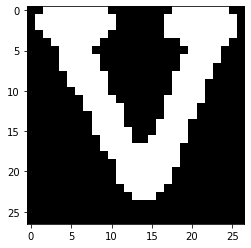

entered if
['V', 'F', 'I', '5', 'A']
V
saved an img V
31 60
[  0  25  31  60  69  91 104 131 136 160]


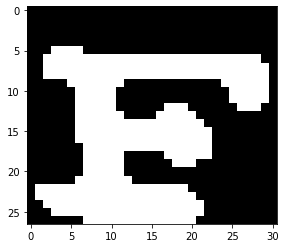

entered if
['V', 'F', 'I', '5', 'A']
F
saved an img F
69 91
[  0  25  31  60  69  91 104 131 136 160]


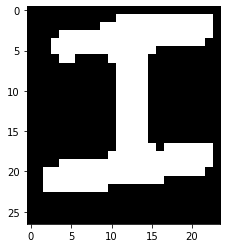

entered if
['V', 'F', 'I', '5', 'A']
I
saved an img I
104 131
[  0  25  31  60  69  91 104 131 136 160]


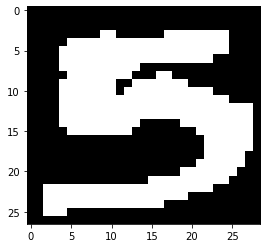

entered if
['V', 'F', 'I', '5', 'A']
5
saved an img 5
136 160
[  0  25  31  60  69  91 104 131 136 160]


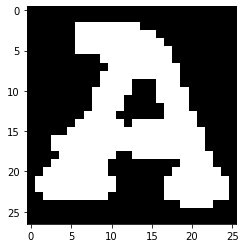

entered if
['V', 'F', 'I', '5', 'A']
A
saved an img A
['V', 'F', 'Z', 'B', 'N']
28 32
[ 28  32  60  67  93 103 133 137 163]


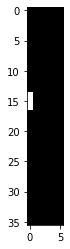

entered if
['V', 'F', 'Z', 'B', 'N']
V
saved an img V
60 67
[ 28  32  60  67  93 103 133 137 163]


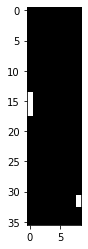

entered if
['V', 'F', 'Z', 'B', 'N']
F
saved an img F
93 103
[ 28  32  60  67  93 103 133 137 163]


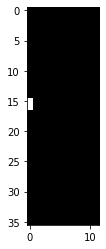

entered if
['V', 'F', 'Z', 'B', 'N']
Z
saved an img Z
133 137
[ 28  32  60  67  93 103 133 137 163]


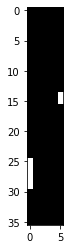

entered if
['V', 'F', 'Z', 'B', 'N']
B
saved an img B
['V', 'I', 'G', 'F', 'M']
0 29
[  0  29  32  54  66  94 102 133 136 162]


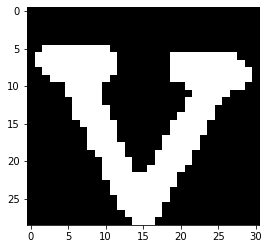

entered if
['V', 'I', 'G', 'F', 'M']
V
saved an img V
32 54
[  0  29  32  54  66  94 102 133 136 162]


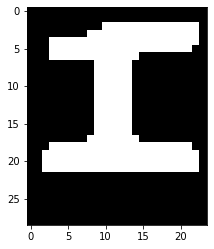

entered if
['V', 'I', 'G', 'F', 'M']
I
saved an img I
66 94
[  0  29  32  54  66  94 102 133 136 162]


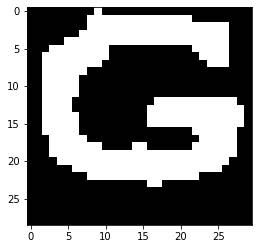

entered if
['V', 'I', 'G', 'F', 'M']
G
saved an img G
102 133
[  0  29  32  54  66  94 102 133 136 162]


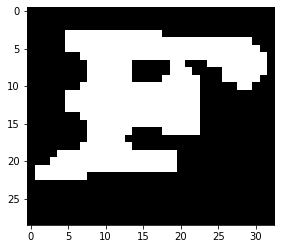

entered if
['V', 'I', 'G', 'F', 'M']
F
saved an img F
136 162
[  0  29  32  54  66  94 102 133 136 162]


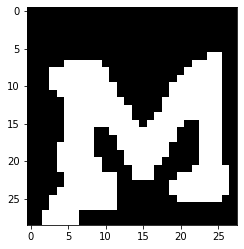

entered if
['V', 'I', 'G', 'F', 'M']
M
saved an img M
['V', 'K', '6', 'F', '4']
25 33
[ 25  33  62  71  95 103 132 139 157]


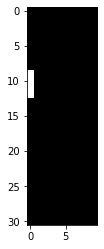

entered if
['V', 'K', '6', 'F', '4']
V
saved an img V
62 71
[ 25  33  62  71  95 103 132 139 157]


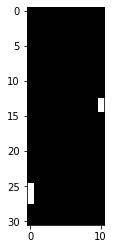

entered if
['V', 'K', '6', 'F', '4']
K
saved an img K
95 103
[ 25  33  62  71  95 103 132 139 157]


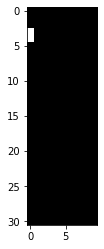

entered if
['V', 'K', '6', 'F', '4']
6
saved an img 6
132 139
[ 25  33  62  71  95 103 132 139 157]


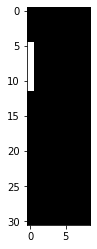

entered if
['V', 'K', '6', 'F', '4']
F
saved an img F
['V', 'Q', 'B', 'Z', 'C']
2 25
[  2  25  29  60  67 100 106 133 135 161]


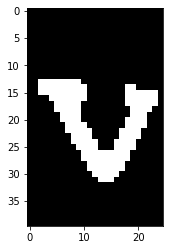

entered if
['V', 'Q', 'B', 'Z', 'C']
V
saved an img V
29 60
[  2  25  29  60  67 100 106 133 135 161]


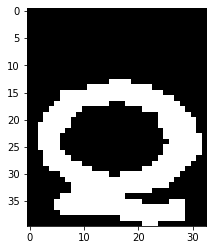

entered if
['V', 'Q', 'B', 'Z', 'C']
Q
saved an img Q
67 100
[  2  25  29  60  67 100 106 133 135 161]


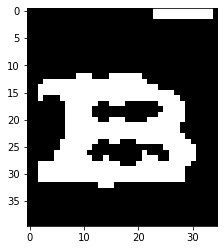

entered if
['V', 'Q', 'B', 'Z', 'C']
B
saved an img B
106 133
[  2  25  29  60  67 100 106 133 135 161]


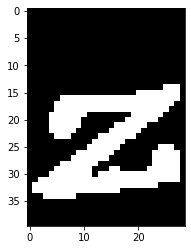

entered if
['V', 'Q', 'B', 'Z', 'C']
Z
saved an img Z
135 161
[  2  25  29  60  67 100 106 133 135 161]


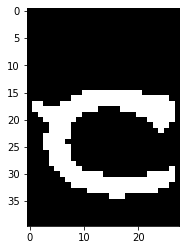

entered if
['V', 'Q', 'B', 'Z', 'C']
C
saved an img C
['V', 'R', '6', '1', '0']
26 33
[ 26  33  60  72  95 108 127 135 155]


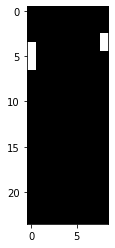

entered if
['V', 'R', '6', '1', '0']
V
saved an img V
60 72
[ 26  33  60  72  95 108 127 135 155]


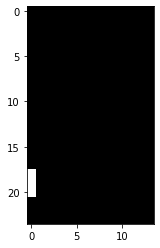

entered if
['V', 'R', '6', '1', '0']
R
saved an img R
95 108
[ 26  33  60  72  95 108 127 135 155]


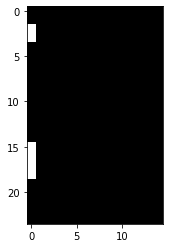

entered if
['V', 'R', '6', '1', '0']
6
saved an img 6
127 135
[ 26  33  60  72  95 108 127 135 155]


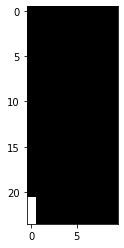

entered if
['V', 'R', '6', '1', '0']
1
saved an img 1
['V', 'S', 'A', 'U', 'K']
56 67
[ 56  67  98 104 133 134 162]


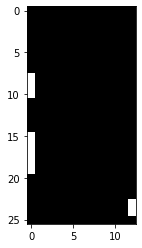

entered if
['V', 'S', 'A', 'U', 'K']
V
saved an img V
98 104
[ 56  67  98 104 133 134 162]


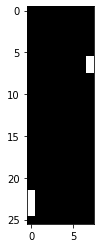

entered if
['V', 'S', 'A', 'U', 'K']
S
saved an img S
133 134
[ 56  67  98 104 133 134 162]


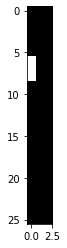

entered if
['V', 'S', 'A', 'U', 'K']
A
saved an img A
['V', 'W', 'O', 'O', 'C']
1 28
[  1  28  29  59  69  92 104 128 134 159]


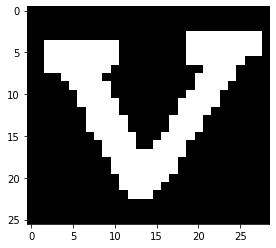

entered if
['V', 'W', 'O', 'O', 'C']
V
saved an img V
29 59
[  1  28  29  59  69  92 104 128 134 159]


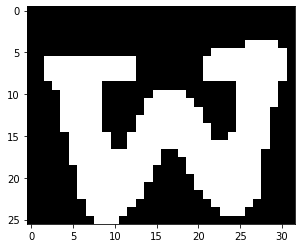

entered if
['V', 'W', 'O', 'O', 'C']
W
saved an img W
69 92
[  1  28  29  59  69  92 104 128 134 159]


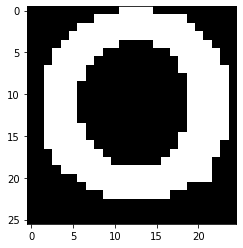

entered if
['V', 'W', 'O', 'O', 'C']
O
saved an img O
104 128
[  1  28  29  59  69  92 104 128 134 159]


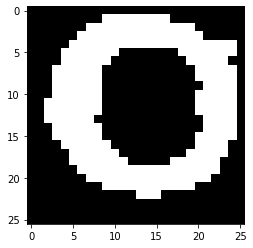

entered if
['V', 'W', 'O', 'O', 'C']
O
saved an img O
134 159
[  1  28  29  59  69  92 104 128 134 159]


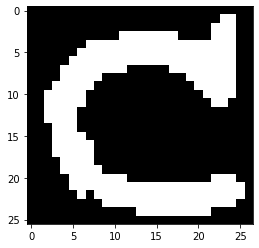

entered if
['V', 'W', 'O', 'O', 'C']
C
saved an img C
['W', '2', 'U', '3', 'K']
0 28
[  0  28  30  57  64  95 107 130 136 161]


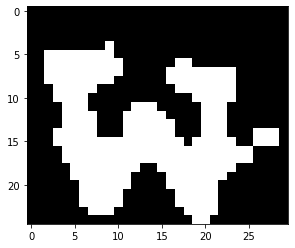

entered if
['W', '2', 'U', '3', 'K']
W
saved an img W
30 57
[  0  28  30  57  64  95 107 130 136 161]


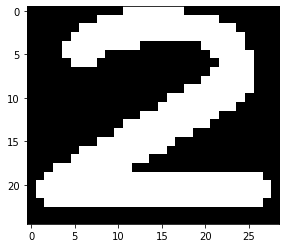

entered if
['W', '2', 'U', '3', 'K']
2
saved an img 2
64 95
[  0  28  30  57  64  95 107 130 136 161]


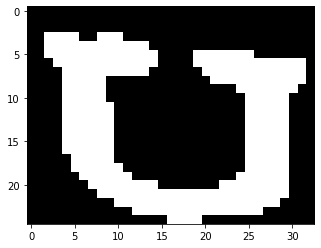

entered if
['W', '2', 'U', '3', 'K']
U
saved an img U
107 130
[  0  28  30  57  64  95 107 130 136 161]


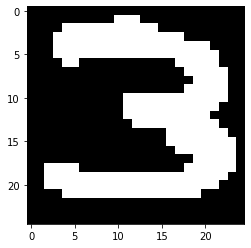

entered if
['W', '2', 'U', '3', 'K']
3
saved an img 3
136 161
[  0  28  30  57  64  95 107 130 136 161]


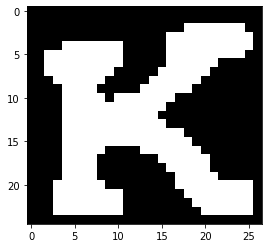

entered if
['W', '2', 'U', '3', 'K']
K
saved an img K
['W', '4', 'K', 'O', '9']
0 24
[  0  24  33  56  66  97 104 129 141 159 161]


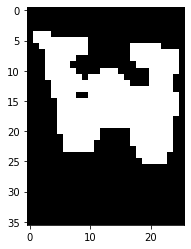

entered if
['W', '4', 'K', 'O', '9']
W
saved an img W
33 56
[  0  24  33  56  66  97 104 129 141 159 161]


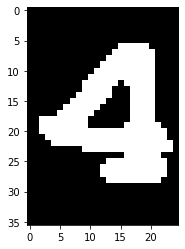

entered if
['W', '4', 'K', 'O', '9']
4
saved an img 4
66 97
[  0  24  33  56  66  97 104 129 141 159 161]


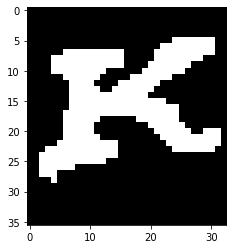

entered if
['W', '4', 'K', 'O', '9']
K
saved an img K
104 129
[  0  24  33  56  66  97 104 129 141 159 161]


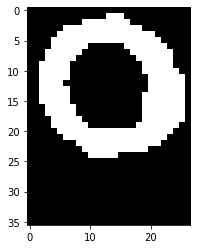

entered if
['W', '4', 'K', 'O', '9']
O
saved an img O
141 159
[  0  24  33  56  66  97 104 129 141 159 161]


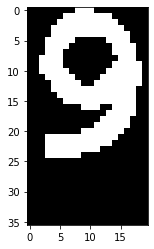

entered if
['W', '4', 'K', 'O', '9']
9
saved an img 9
['W', '7', 'I', 'B', 'B']
2 24
[  2  24  32  57  68  91 101 131 136 161]


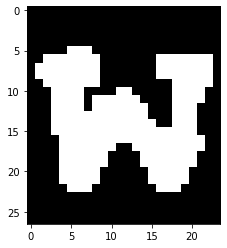

entered if
['W', '7', 'I', 'B', 'B']
W
saved an img W
32 57
[  2  24  32  57  68  91 101 131 136 161]


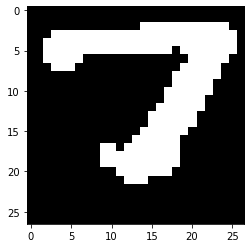

entered if
['W', '7', 'I', 'B', 'B']
7
saved an img 7
68 91
[  2  24  32  57  68  91 101 131 136 161]


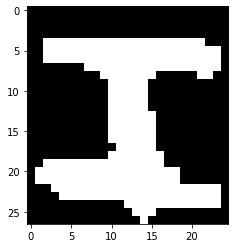

entered if
['W', '7', 'I', 'B', 'B']
I
saved an img I
101 131
[  2  24  32  57  68  91 101 131 136 161]


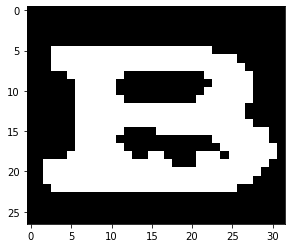

entered if
['W', '7', 'I', 'B', 'B']
B
saved an img B
136 161
[  2  24  32  57  68  91 101 131 136 161]


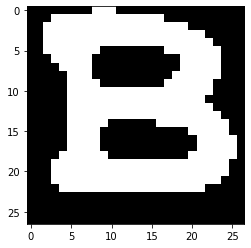

entered if
['W', '7', 'I', 'B', 'B']
B
saved an img B
['W', 'C', 'I', 'D', 'E']
1 27
[  1  27  28  56  66  91 101 130 136 162]


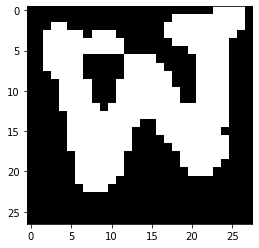

entered if
['W', 'C', 'I', 'D', 'E']
W
saved an img W
28 56
[  1  27  28  56  66  91 101 130 136 162]


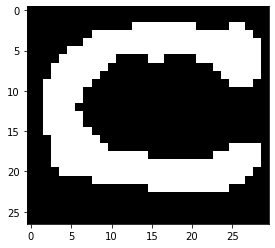

entered if
['W', 'C', 'I', 'D', 'E']
C
saved an img C
66 91
[  1  27  28  56  66  91 101 130 136 162]


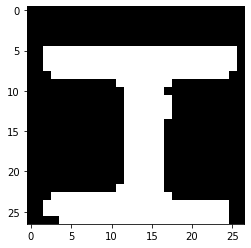

entered if
['W', 'C', 'I', 'D', 'E']
I
saved an img I
101 130
[  1  27  28  56  66  91 101 130 136 162]


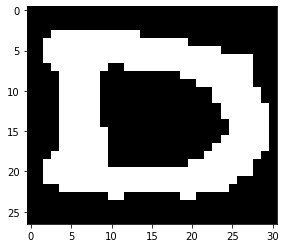

entered if
['W', 'C', 'I', 'D', 'E']
D
saved an img D
136 162
[  1  27  28  56  66  91 101 130 136 162]


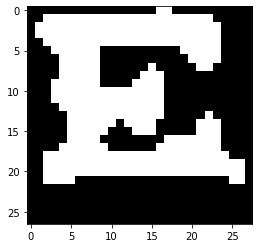

entered if
['W', 'C', 'I', 'D', 'E']
E
saved an img E
['W', 'G', '6', 'V', '0']
24 32
[ 24  32  61  70 133 134 156]


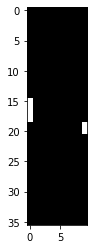

entered if
['W', 'G', '6', 'V', '0']
W
saved an img W
61 70
[ 24  32  61  70 133 134 156]


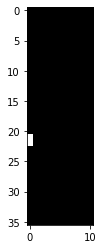

entered if
['W', 'G', '6', 'V', '0']
G
saved an img G
133 134
[ 24  32  61  70 133 134 156]


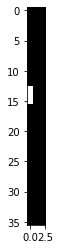

entered if
['W', 'G', '6', 'V', '0']
6
saved an img 6
['W', 'H', '4', 'Z', 'T']
2 24
[  2  24  31  61  62  91 106 158]


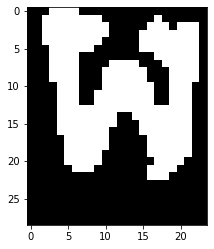

entered if
['W', 'H', '4', 'Z', 'T']
W
saved an img W
31 61
[  2  24  31  61  62  91 106 158]


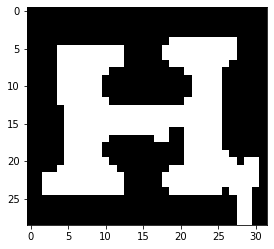

entered if
['W', 'H', '4', 'Z', 'T']
H
saved an img H
62 91
[  2  24  31  61  62  91 106 158]


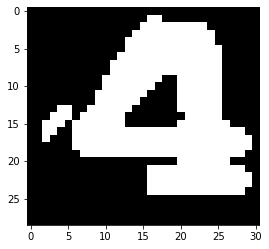

entered if
['W', 'H', '4', 'Z', 'T']
4
saved an img 4
106 158
[  2  24  31  61  62  91 106 158]


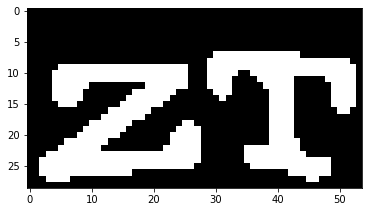

entered if
['W', 'H', '4', 'Z', 'T']
Z
saved an img Z
['W', 'N', 'Y', 'S', 'J']
26 31
[ 26  31  59  67  96 104 129 137 161]


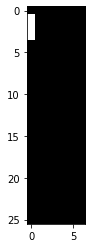

entered if
['W', 'N', 'Y', 'S', 'J']
W
saved an img W
59 67
[ 26  31  59  67  96 104 129 137 161]


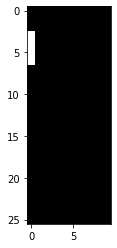

entered if
['W', 'N', 'Y', 'S', 'J']
N
saved an img N
96 104
[ 26  31  59  67  96 104 129 137 161]


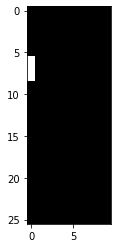

entered if
['W', 'N', 'Y', 'S', 'J']
Y
saved an img Y
129 137
[ 26  31  59  67  96 104 129 137 161]


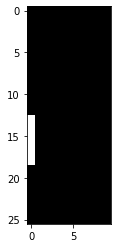

entered if
['W', 'N', 'Y', 'S', 'J']
S
saved an img S
['W', 'O', '6', 'T', '9']
28 29
[ 28  29  61  69  95 103 132 137 158]


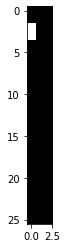

entered if
['W', 'O', '6', 'T', '9']
W
saved an img W
61 69
[ 28  29  61  69  95 103 132 137 158]


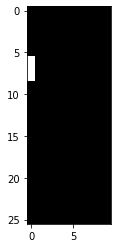

entered if
['W', 'O', '6', 'T', '9']
O
saved an img O
95 103
[ 28  29  61  69  95 103 132 137 158]


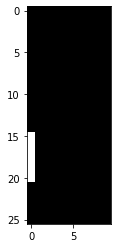

entered if
['W', 'O', '6', 'T', '9']
6
saved an img 6
132 137
[ 28  29  61  69  95 103 132 137 158]


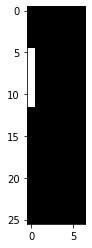

entered if
['W', 'O', '6', 'T', '9']
T
saved an img T
['W', 'W', '9', 'B', 'N']
27 31
[ 27  31  63  71  93 102 134 137 162]


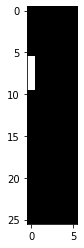

entered if
['W', 'W', '9', 'B', 'N']
W
saved an img W
63 71
[ 27  31  63  71  93 102 134 137 162]


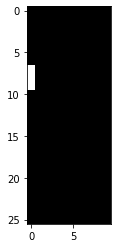

entered if
['W', 'W', '9', 'B', 'N']
W
saved an img W
93 102
[ 27  31  63  71  93 102 134 137 162]


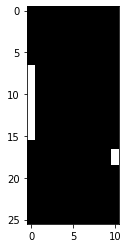

entered if
['W', 'W', '9', 'B', 'N']
9
saved an img 9
134 137
[ 27  31  63  71  93 102 134 137 162]


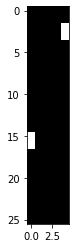

entered if
['W', 'W', '9', 'B', 'N']
B
saved an img B
['W', 'W', 'W', 'J', 'P']
23 26
[ 23  26  61  66  97  98 132 139 160]


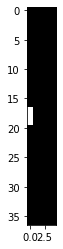

entered if
['W', 'W', 'W', 'J', 'P']
W
saved an img W
61 66
[ 23  26  61  66  97  98 132 139 160]


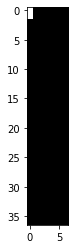

entered if
['W', 'W', 'W', 'J', 'P']
W
saved an img W
97 98
[ 23  26  61  66  97  98 132 139 160]


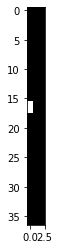

entered if
['W', 'W', 'W', 'J', 'P']
W
saved an img W
132 139
[ 23  26  61  66  97  98 132 139 160]


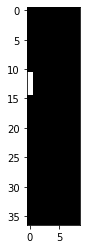

entered if
['W', 'W', 'W', 'J', 'P']
J
saved an img J
['W', 'Z', 'X', '8', 'I']
0 26
[  0  26  31  59  63  95 106 130 139 158]


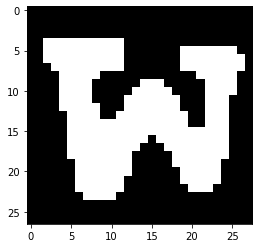

entered if
['W', 'Z', 'X', '8', 'I']
W
saved an img W
31 59
[  0  26  31  59  63  95 106 130 139 158]


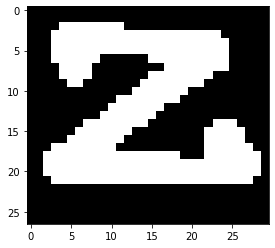

entered if
['W', 'Z', 'X', '8', 'I']
Z
saved an img Z
63 95
[  0  26  31  59  63  95 106 130 139 158]


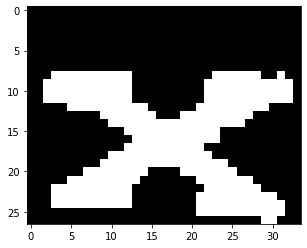

entered if
['W', 'Z', 'X', '8', 'I']
X
saved an img X
106 130
[  0  26  31  59  63  95 106 130 139 158]


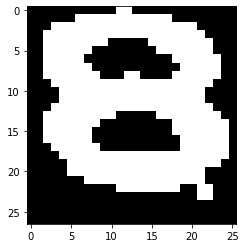

entered if
['W', 'Z', 'X', '8', 'I']
8
saved an img 8
139 158
[  0  26  31  59  63  95 106 130 139 158]


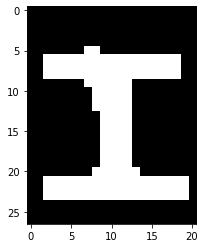

entered if
['W', 'Z', 'X', '8', 'I']
I
saved an img I
['X', '4', 'C', '4', 'B']
2 27
[  2  27  32  56  64  94 108 130 138 158]


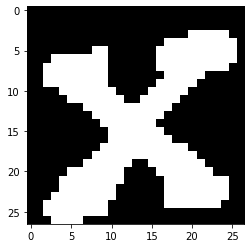

entered if
['X', '4', 'C', '4', 'B']
X
saved an img X
32 56
[  2  27  32  56  64  94 108 130 138 158]


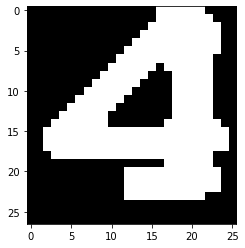

entered if
['X', '4', 'C', '4', 'B']
4
saved an img 4
64 94
[  2  27  32  56  64  94 108 130 138 158]


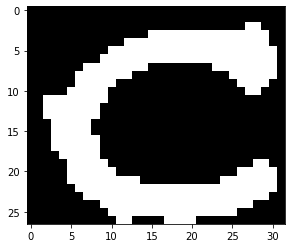

entered if
['X', '4', 'C', '4', 'B']
C
saved an img C
108 130
[  2  27  32  56  64  94 108 130 138 158]


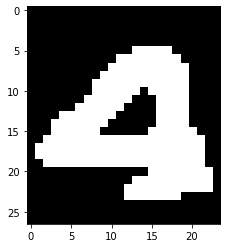

entered if
['X', '4', 'C', '4', 'B']
4
saved an img 4
138 158
[  2  27  32  56  64  94 108 130 138 158]


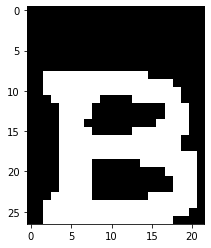

entered if
['X', '4', 'C', '4', 'B']
B
saved an img B
['X', '4', 'J', 'G', 'H']
2 27
[  2  27  34  56  68  99 102 134 136 158]


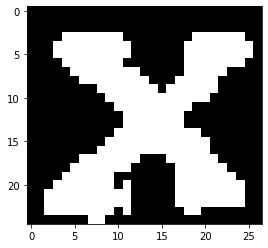

entered if
['X', '4', 'J', 'G', 'H']
X
saved an img X
34 56
[  2  27  34  56  68  99 102 134 136 158]


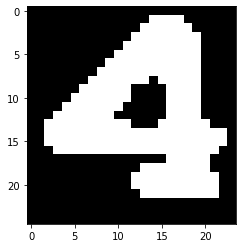

entered if
['X', '4', 'J', 'G', 'H']
4
saved an img 4
68 99
[  2  27  34  56  68  99 102 134 136 158]


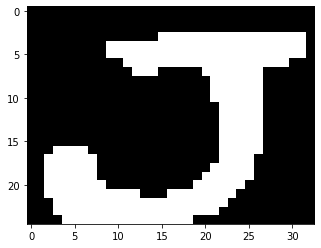

entered if
['X', '4', 'J', 'G', 'H']
J
saved an img J
102 134
[  2  27  34  56  68  99 102 134 136 158]


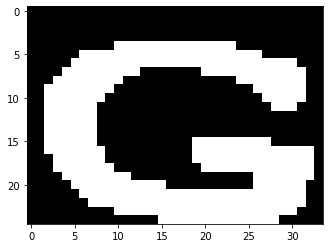

entered if
['X', '4', 'J', 'G', 'H']
G
saved an img G
136 158
[  2  27  34  56  68  99 102 134 136 158]


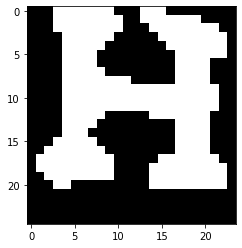

entered if
['X', '4', 'J', 'G', 'H']
H
saved an img H
['X', '7', 'U', 'I', 'X']
25 31
[ 25  31  56  68 101 104 128 135 162]


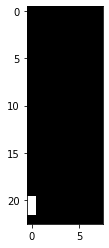

entered if
['X', '7', 'U', 'I', 'X']
X
saved an img X
56 68
[ 25  31  56  68 101 104 128 135 162]


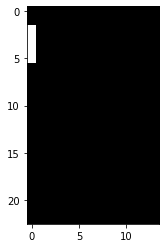

entered if
['X', '7', 'U', 'I', 'X']
7
saved an img 7
101 104
[ 25  31  56  68 101 104 128 135 162]


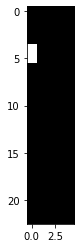

entered if
['X', '7', 'U', 'I', 'X']
U
saved an img U
128 135
[ 25  31  56  68 101 104 128 135 162]


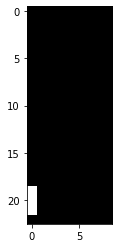

entered if
['X', '7', 'U', 'I', 'X']
I
saved an img I
['X', '9', '2', 'I', '8']
1 24
[  1  24  34  58  65  90 106 127 141 160]


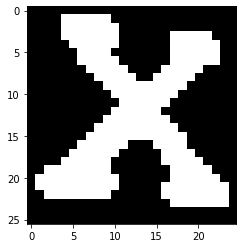

entered if
['X', '9', '2', 'I', '8']
X
saved an img X
34 58
[  1  24  34  58  65  90 106 127 141 160]


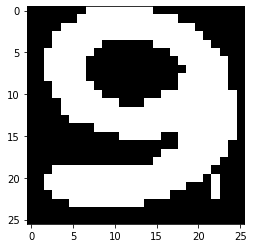

entered if
['X', '9', '2', 'I', '8']
9
saved an img 9
65 90
[  1  24  34  58  65  90 106 127 141 160]


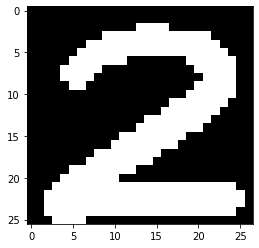

entered if
['X', '9', '2', 'I', '8']
2
saved an img 2
106 127
[  1  24  34  58  65  90 106 127 141 160]


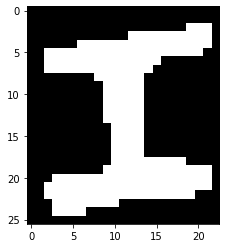

entered if
['X', '9', '2', 'I', '8']
I
saved an img I
141 160
[  1  24  34  58  65  90 106 127 141 160]


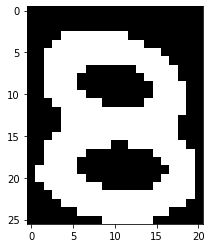

entered if
['X', '9', '2', 'I', '8']
8
saved an img 8
['X', '9', 'U', 'W', 'P']
2 26
[  2  26  35  60  68  96 101 132 139 161]


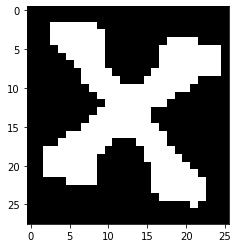

entered if
['X', '9', 'U', 'W', 'P']
X
saved an img X
35 60
[  2  26  35  60  68  96 101 132 139 161]


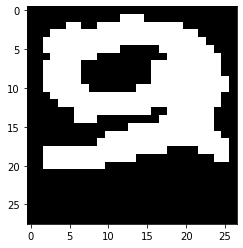

entered if
['X', '9', 'U', 'W', 'P']
9
saved an img 9
68 96
[  2  26  35  60  68  96 101 132 139 161]


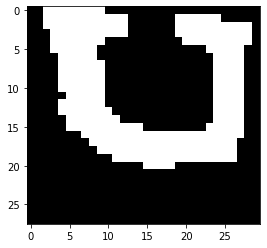

entered if
['X', '9', 'U', 'W', 'P']
U
saved an img U
101 132
[  2  26  35  60  68  96 101 132 139 161]


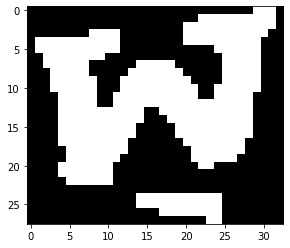

entered if
['X', '9', 'U', 'W', 'P']
W
saved an img W
139 161
[  2  26  35  60  68  96 101 132 139 161]


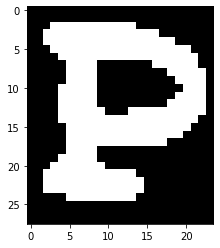

entered if
['X', '9', 'U', 'W', 'P']
P
saved an img P
['X', 'C', '1', '5', 'G']
0 23
[  0  23  27  57  70  93 102 128 135 160]


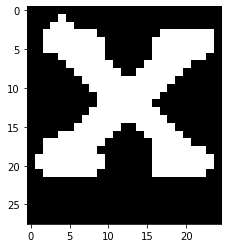

entered if
['X', 'C', '1', '5', 'G']
X
saved an img X
27 57
[  0  23  27  57  70  93 102 128 135 160]


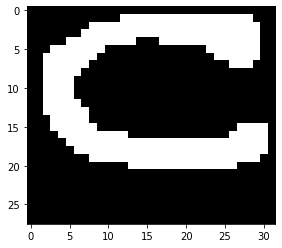

entered if
['X', 'C', '1', '5', 'G']
C
saved an img C
70 93
[  0  23  27  57  70  93 102 128 135 160]


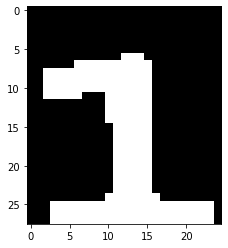

entered if
['X', 'C', '1', '5', 'G']
1
saved an img 1
102 128
[  0  23  27  57  70  93 102 128 135 160]


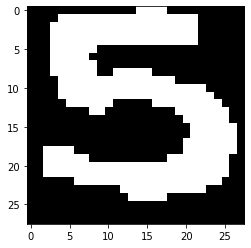

entered if
['X', 'C', '1', '5', 'G']
5
saved an img 5
135 160
[  0  23  27  57  70  93 102 128 135 160]


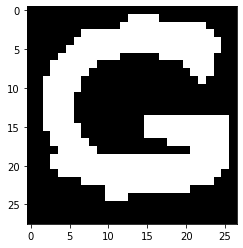

entered if
['X', 'C', '1', '5', 'G']
G
saved an img G
['X', 'E', 'A', 'U', 'D']
3 60
[  3  60  63  97 104 131 134 157]


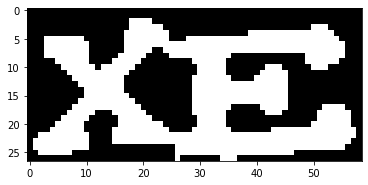

entered if
['X', 'E', 'A', 'U', 'D']
X
saved an img X
63 97
[  3  60  63  97 104 131 134 157]


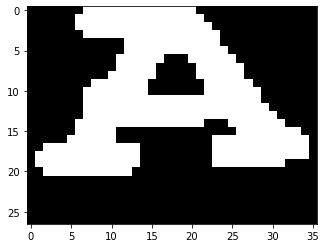

entered if
['X', 'E', 'A', 'U', 'D']
E
saved an img E
104 131
[  3  60  63  97 104 131 134 157]


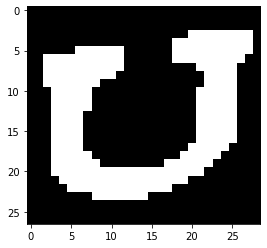

entered if
['X', 'E', 'A', 'U', 'D']
A
saved an img A
134 157
[  3  60  63  97 104 131 134 157]


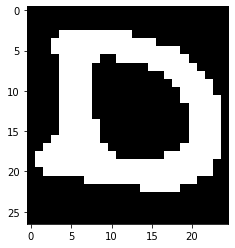

entered if
['X', 'E', 'A', 'U', 'D']
U
saved an img U
['X', 'F', '0', 'B', '6']
0 25
[  0  25  34  62  67  91 104 133 140]


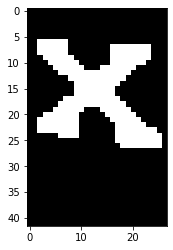

entered if
['X', 'F', '0', 'B', '6']
X
saved an img X
34 62
[  0  25  34  62  67  91 104 133 140]


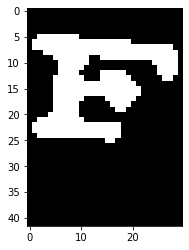

entered if
['X', 'F', '0', 'B', '6']
F
saved an img F
67 91
[  0  25  34  62  67  91 104 133 140]


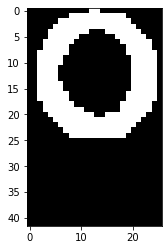

entered if
['X', 'F', '0', 'B', '6']
0
saved an img 0
104 133
[  0  25  34  62  67  91 104 133 140]


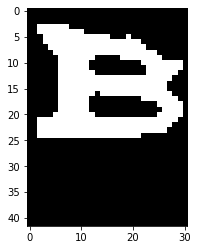

entered if
['X', 'F', '0', 'B', '6']
B
saved an img B
['X', 'L', '8', '9', 'E']
0 23
[  0  23  35  62  71  94 103 128 132 156]


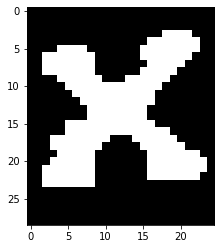

entered if
['X', 'L', '8', '9', 'E']
X
saved an img X
35 62
[  0  23  35  62  71  94 103 128 132 156]


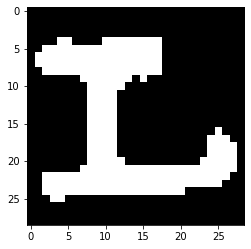

entered if
['X', 'L', '8', '9', 'E']
L
saved an img L
71 94
[  0  23  35  62  71  94 103 128 132 156]


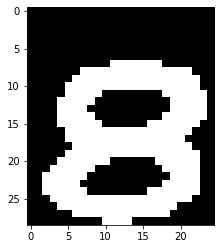

entered if
['X', 'L', '8', '9', 'E']
8
saved an img 8
103 128
[  0  23  35  62  71  94 103 128 132 156]


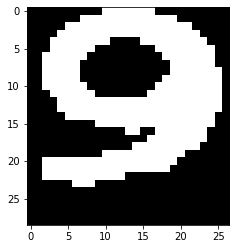

entered if
['X', 'L', '8', '9', 'E']
9
saved an img 9
132 156
[  0  23  35  62  71  94 103 128 132 156]


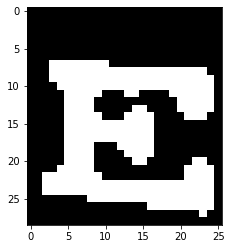

entered if
['X', 'L', '8', '9', 'E']
E
saved an img E
['X', 'M', 'B', 'B', 'D']
1 59
[  1  59  66  96 102 129 137 160]


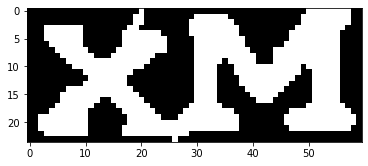

entered if
['X', 'M', 'B', 'B', 'D']
X
saved an img X
66 96
[  1  59  66  96 102 129 137 160]


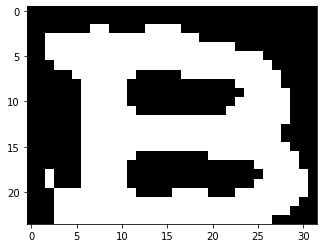

entered if
['X', 'M', 'B', 'B', 'D']
M
saved an img M
102 129
[  1  59  66  96 102 129 137 160]


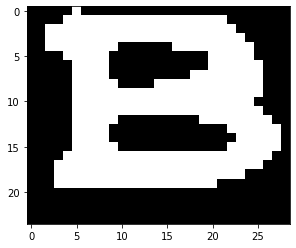

entered if
['X', 'M', 'B', 'B', 'D']
B
saved an img B
137 160
[  1  59  66  96 102 129 137 160]


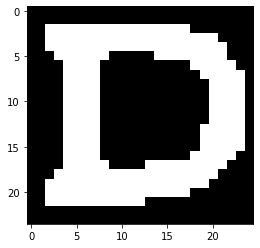

entered if
['X', 'M', 'B', 'B', 'D']
B
saved an img B
['X', 'T', 'J', 'O', 'W']
2 29
[  2  29  30  98 104 128 133 158]


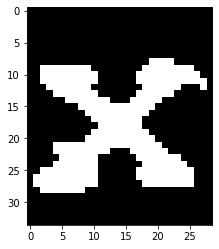

entered if
['X', 'T', 'J', 'O', 'W']
X
saved an img X
30 98
[  2  29  30  98 104 128 133 158]


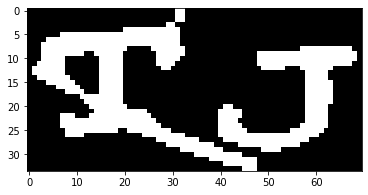

entered if
['X', 'T', 'J', 'O', 'W']
T
saved an img T
104 128
[  2  29  30  98 104 128 133 158]


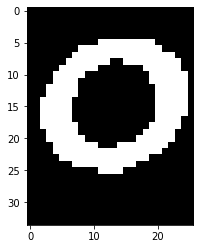

entered if
['X', 'T', 'J', 'O', 'W']
J
saved an img J
133 158
[  2  29  30  98 104 128 133 158]


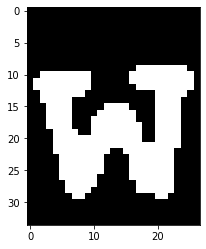

entered if
['X', 'T', 'J', 'O', 'W']
O
saved an img O
['X', 'T', 'P', 'R', '5']
22 25
[ 22  25  56  68  97 101 132 138 158]


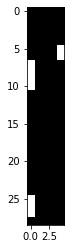

entered if
['X', 'T', 'P', 'R', '5']
X
saved an img X
56 68
[ 22  25  56  68  97 101 132 138 158]


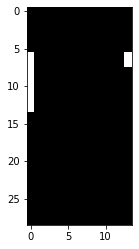

entered if
['X', 'T', 'P', 'R', '5']
T
saved an img T
97 101
[ 22  25  56  68  97 101 132 138 158]


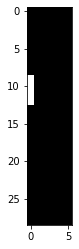

entered if
['X', 'T', 'P', 'R', '5']
P
saved an img P
132 138
[ 22  25  56  68  97 101 132 138 158]


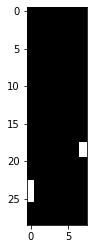

entered if
['X', 'T', 'P', 'R', '5']
R
saved an img R
['X', 'U', 'I', 'D', '6']
1 27
[  1  27  29  58  69  91 101 128 141 159]


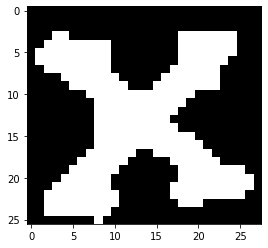

entered if
['X', 'U', 'I', 'D', '6']
X
saved an img X
29 58
[  1  27  29  58  69  91 101 128 141 159]


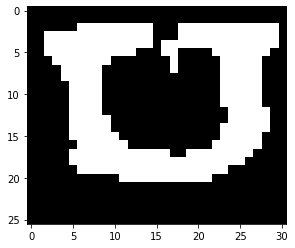

entered if
['X', 'U', 'I', 'D', '6']
U
saved an img U
69 91
[  1  27  29  58  69  91 101 128 141 159]


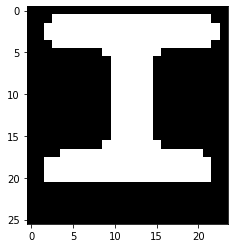

entered if
['X', 'U', 'I', 'D', '6']
I
saved an img I
101 128
[  1  27  29  58  69  91 101 128 141 159]


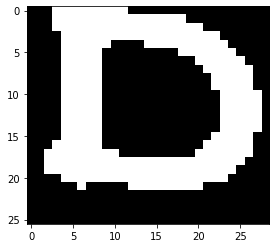

entered if
['X', 'U', 'I', 'D', '6']
D
saved an img D
141 159
[  1  27  29  58  69  91 101 128 141 159]


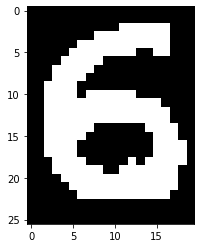

entered if
['X', 'U', 'I', 'D', '6']
6
saved an img 6
['Y', '0', 'T', 'G', 'L']
2 25
[  2  25  32  58  64  95 103 132 137 159]


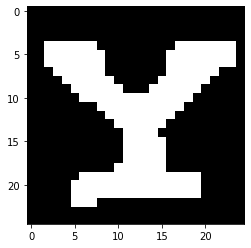

entered if
['Y', '0', 'T', 'G', 'L']
Y
saved an img Y
32 58
[  2  25  32  58  64  95 103 132 137 159]


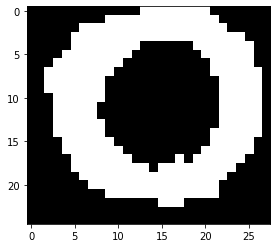

entered if
['Y', '0', 'T', 'G', 'L']
0
saved an img 0
64 95
[  2  25  32  58  64  95 103 132 137 159]


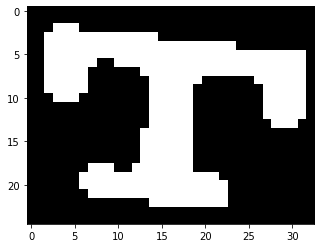

entered if
['Y', '0', 'T', 'G', 'L']
T
saved an img T
103 132
[  2  25  32  58  64  95 103 132 137 159]


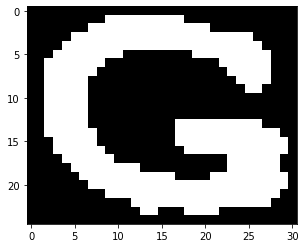

entered if
['Y', '0', 'T', 'G', 'L']
G
saved an img G
137 159
[  2  25  32  58  64  95 103 132 137 159]


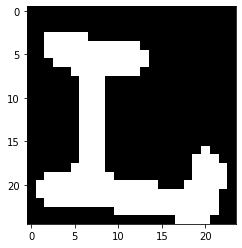

entered if
['Y', '0', 'T', 'G', 'L']
L
saved an img L
['Y', '6', 'D', 'C', '0']
24 36
[ 24  36  58  67  94 103 134 140 159]


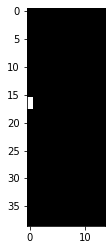

entered if
['Y', '6', 'D', 'C', '0']
Y
saved an img Y
58 67
[ 24  36  58  67  94 103 134 140 159]


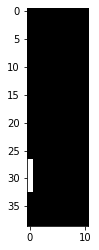

entered if
['Y', '6', 'D', 'C', '0']
6
saved an img 6
94 103
[ 24  36  58  67  94 103 134 140 159]


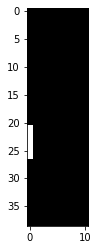

entered if
['Y', '6', 'D', 'C', '0']
D
saved an img D
134 140
[ 24  36  58  67  94 103 134 140 159]


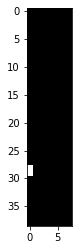

entered if
['Y', '6', 'D', 'C', '0']
C
saved an img C
['Y', '7', 'D', '6', '0']
1 25
[  1  25  28  54  61  94 104 128 136 160]


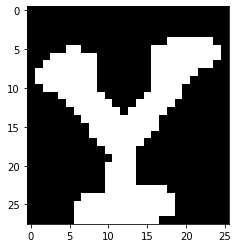

entered if
['Y', '7', 'D', '6', '0']
Y
saved an img Y
28 54
[  1  25  28  54  61  94 104 128 136 160]


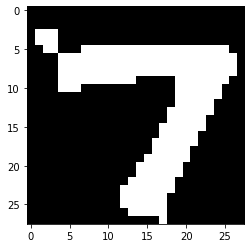

entered if
['Y', '7', 'D', '6', '0']
7
saved an img 7
61 94
[  1  25  28  54  61  94 104 128 136 160]


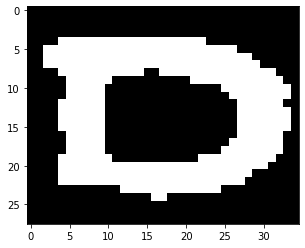

entered if
['Y', '7', 'D', '6', '0']
D
saved an img D
104 128
[  1  25  28  54  61  94 104 128 136 160]


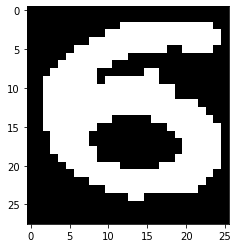

entered if
['Y', '7', 'D', '6', '0']
6
saved an img 6
136 160
[  1  25  28  54  61  94 104 128 136 160]


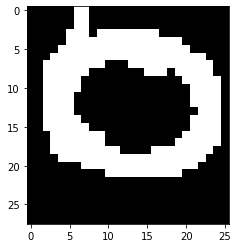

entered if
['Y', '7', 'D', '6', '0']
0
saved an img 0
['Y', '7', 'T', 'U', 'P']
26 34
[ 26  34  58  65  94 104 130 137 160]


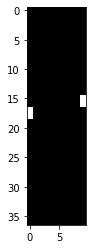

entered if
['Y', '7', 'T', 'U', 'P']
Y
saved an img Y
58 65
[ 26  34  58  65  94 104 130 137 160]


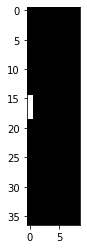

entered if
['Y', '7', 'T', 'U', 'P']
7
saved an img 7
94 104
[ 26  34  58  65  94 104 130 137 160]


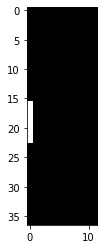

entered if
['Y', '7', 'T', 'U', 'P']
T
saved an img T
130 137
[ 26  34  58  65  94 104 130 137 160]


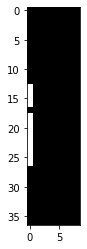

entered if
['Y', '7', 'T', 'U', 'P']
U
saved an img U
['Y', '8', 'E', 'P', '9']
5 28
[  5  28  32  57  68  98 105 130 140 158]


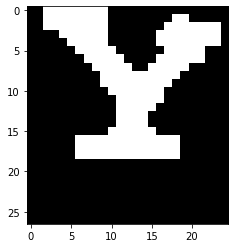

entered if
['Y', '8', 'E', 'P', '9']
Y
saved an img Y
32 57
[  5  28  32  57  68  98 105 130 140 158]


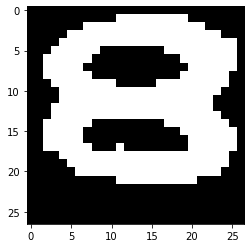

entered if
['Y', '8', 'E', 'P', '9']
8
saved an img 8
68 98
[  5  28  32  57  68  98 105 130 140 158]


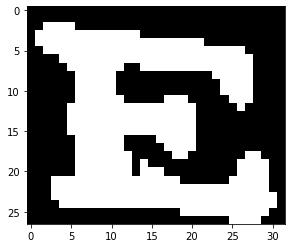

entered if
['Y', '8', 'E', 'P', '9']
E
saved an img E
105 130
[  5  28  32  57  68  98 105 130 140 158]


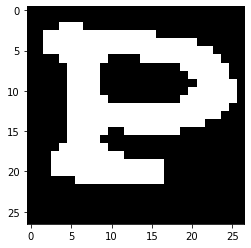

entered if
['Y', '8', 'E', 'P', '9']
P
saved an img P
140 158
[  5  28  32  57  68  98 105 130 140 158]


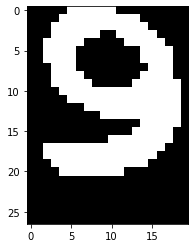

entered if
['Y', '8', 'E', 'P', '9']
9
saved an img 9
['Y', 'B', 'B', 'M', 'Q']
5 26
[  5  26  27  57  69  95  98 134 135 163]


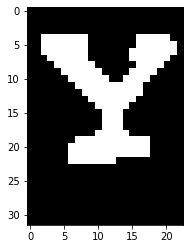

entered if
['Y', 'B', 'B', 'M', 'Q']
Y
saved an img Y
27 57
[  5  26  27  57  69  95  98 134 135 163]


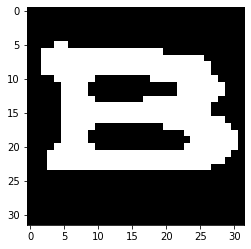

entered if
['Y', 'B', 'B', 'M', 'Q']
B
saved an img B
69 95
[  5  26  27  57  69  95  98 134 135 163]


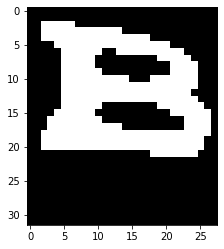

entered if
['Y', 'B', 'B', 'M', 'Q']
B
saved an img B
98 134
[  5  26  27  57  69  95  98 134 135 163]


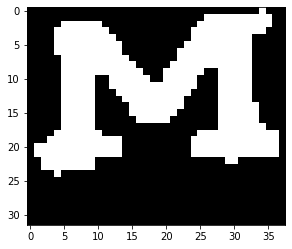

entered if
['Y', 'B', 'B', 'M', 'Q']
M
saved an img M
135 163
[  5  26  27  57  69  95  98 134 135 163]


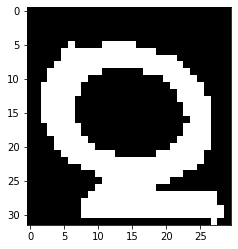

entered if
['Y', 'B', 'B', 'M', 'Q']
Q
saved an img Q
['Y', 'D', '8', 'K', 'F']
24 32
[ 24  32  60  71  94 104 134 135 161]


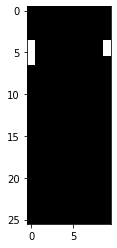

entered if
['Y', 'D', '8', 'K', 'F']
Y
saved an img Y
60 71
[ 24  32  60  71  94 104 134 135 161]


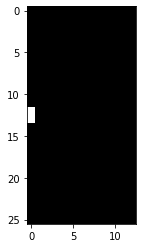

entered if
['Y', 'D', '8', 'K', 'F']
D
saved an img D
94 104
[ 24  32  60  71  94 104 134 135 161]


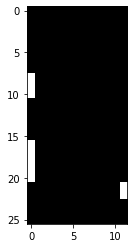

entered if
['Y', 'D', '8', 'K', 'F']
8
saved an img 8
134 135
[ 24  32  60  71  94 104 134 135 161]


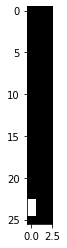

entered if
['Y', 'D', '8', 'K', 'F']
K
saved an img K
['Y', 'K', '5', 'D', 'G']
26 32
[ 26  32  61  72  94 102 133 138 163]


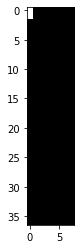

entered if
['Y', 'K', '5', 'D', 'G']
Y
saved an img Y
61 72
[ 26  32  61  72  94 102 133 138 163]


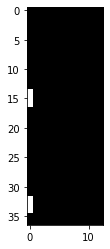

entered if
['Y', 'K', '5', 'D', 'G']
K
saved an img K
94 102
[ 26  32  61  72  94 102 133 138 163]


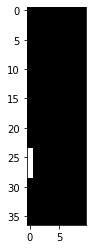

entered if
['Y', 'K', '5', 'D', 'G']
5
saved an img 5
133 138
[ 26  32  61  72  94 102 133 138 163]


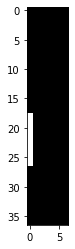

entered if
['Y', 'K', '5', 'D', 'G']
D
saved an img D
['Y', 'K', 'V', 'O', 'F']
3 25
[  3  25  28  62  64  99 101 133 134 159]


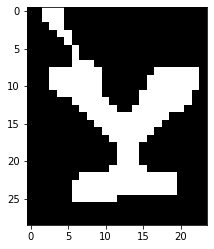

entered if
['Y', 'K', 'V', 'O', 'F']
Y
saved an img Y
28 62
[  3  25  28  62  64  99 101 133 134 159]


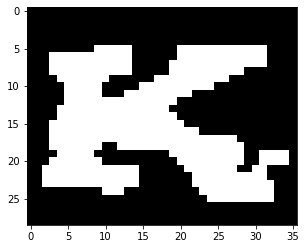

entered if
['Y', 'K', 'V', 'O', 'F']
K
saved an img K
64 99
[  3  25  28  62  64  99 101 133 134 159]


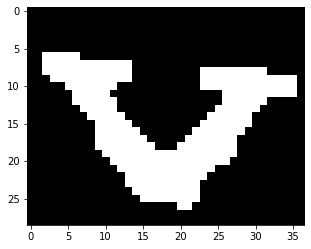

entered if
['Y', 'K', 'V', 'O', 'F']
V
saved an img V
101 133
[  3  25  28  62  64  99 101 133 134 159]


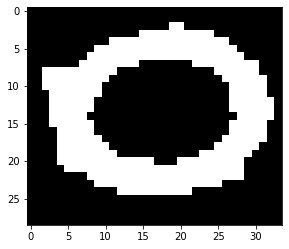

entered if
['Y', 'K', 'V', 'O', 'F']
O
saved an img O
134 159
[  3  25  28  62  64  99 101 133 134 159]


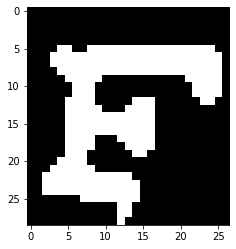

entered if
['Y', 'K', 'V', 'O', 'F']
F
saved an img F
['Y', 'L', '2', 'J', '9']
23 32
[ 23  32  61  65  91 103 131 139 159]


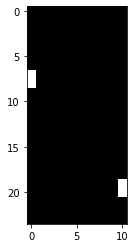

entered if
['Y', 'L', '2', 'J', '9']
Y
saved an img Y
61 65
[ 23  32  61  65  91 103 131 139 159]


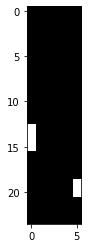

entered if
['Y', 'L', '2', 'J', '9']
L
saved an img L
91 103
[ 23  32  61  65  91 103 131 139 159]


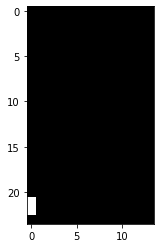

entered if
['Y', 'L', '2', 'J', '9']
2
saved an img 2
131 139
[ 23  32  61  65  91 103 131 139 159]


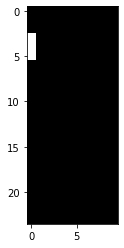

entered if
['Y', 'L', '2', 'J', '9']
J
saved an img J
['Y', 'L', 'C', '2', 'I']
23 31
[ 23  31  92 101 127 135 155]


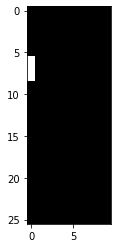

entered if
['Y', 'L', 'C', '2', 'I']
Y
saved an img Y
92 101
[ 23  31  92 101 127 135 155]


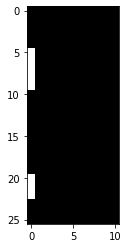

entered if
['Y', 'L', 'C', '2', 'I']
L
saved an img L
127 135
[ 23  31  92 101 127 135 155]


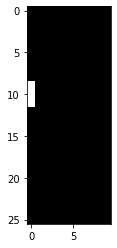

entered if
['Y', 'L', 'C', '2', 'I']
C
saved an img C
['Y', 'O', 'I', 'V', 'U']
0 22
[  0  22  29  60  69  92 100 130 138 159]


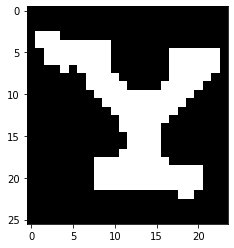

entered if
['Y', 'O', 'I', 'V', 'U']
Y
saved an img Y
29 60
[  0  22  29  60  69  92 100 130 138 159]


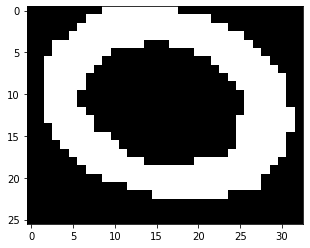

entered if
['Y', 'O', 'I', 'V', 'U']
O
saved an img O
69 92
[  0  22  29  60  69  92 100 130 138 159]


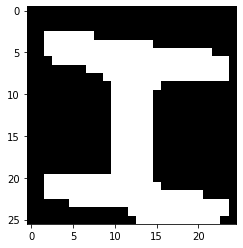

entered if
['Y', 'O', 'I', 'V', 'U']
I
saved an img I
100 130
[  0  22  29  60  69  92 100 130 138 159]


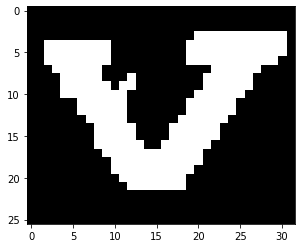

entered if
['Y', 'O', 'I', 'V', 'U']
V
saved an img V
138 159
[  0  22  29  60  69  92 100 130 138 159]


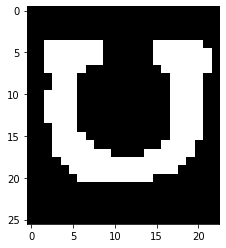

entered if
['Y', 'O', 'I', 'V', 'U']
U
saved an img U
['Y', 'P', 'Q', 'V', '3']
61 63
[ 61  63  95  99 132 137 157]


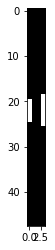

entered if
['Y', 'P', 'Q', 'V', '3']
Y
saved an img Y
95 99
[ 61  63  95  99 132 137 157]


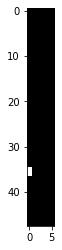

entered if
['Y', 'P', 'Q', 'V', '3']
P
saved an img P
132 137
[ 61  63  95  99 132 137 157]


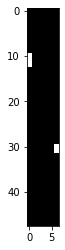

entered if
['Y', 'P', 'Q', 'V', '3']
Q
saved an img Q
['Y', 'S', '0', 'P', 'X']
0 24
[  0  24  31  58  63  95 102 130 134 159]


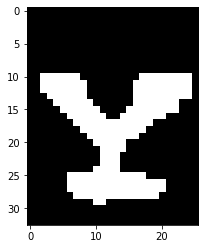

entered if
['Y', 'S', '0', 'P', 'X']
Y
saved an img Y
31 58
[  0  24  31  58  63  95 102 130 134 159]


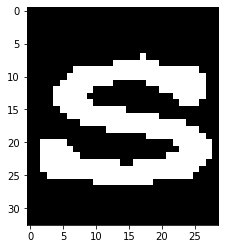

entered if
['Y', 'S', '0', 'P', 'X']
S
saved an img S
63 95
[  0  24  31  58  63  95 102 130 134 159]


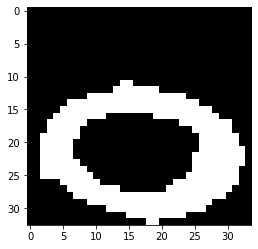

entered if
['Y', 'S', '0', 'P', 'X']
0
saved an img 0
102 130
[  0  24  31  58  63  95 102 130 134 159]


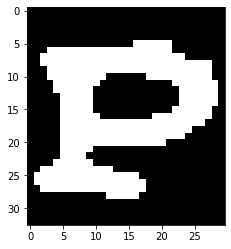

entered if
['Y', 'S', '0', 'P', 'X']
P
saved an img P
134 159
[  0  24  31  58  63  95 102 130 134 159]


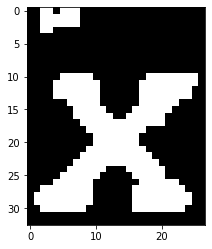

entered if
['Y', 'S', '0', 'P', 'X']
X
saved an img X
['Y', 'S', '2', 'C', 'S']
23 31
[ 23  31  60  64  93 102 133 138 158]


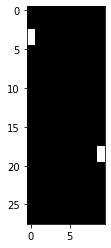

entered if
['Y', 'S', '2', 'C', 'S']
Y
saved an img Y
60 64
[ 23  31  60  64  93 102 133 138 158]


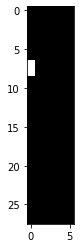

entered if
['Y', 'S', '2', 'C', 'S']
S
saved an img S
93 102
[ 23  31  60  64  93 102 133 138 158]


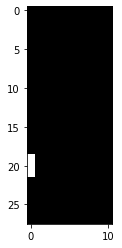

entered if
['Y', 'S', '2', 'C', 'S']
2
saved an img 2
133 138
[ 23  31  60  64  93 102 133 138 158]


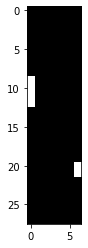

entered if
['Y', 'S', '2', 'C', 'S']
C
saved an img C
['Y', 'U', 'V', 'O', 'B']
24 30
[ 24  30  59  63 158]


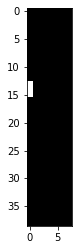

entered if
['Y', 'U', 'V', 'O', 'B']
Y
saved an img Y
59 63
[ 24  30  59  63 158]


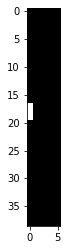

entered if
['Y', 'U', 'V', 'O', 'B']
U
saved an img U
['Z', '2', 'Q', 'Q', 'S']
3 25
[  3  25  33  56  66  98 101 134 141 160]


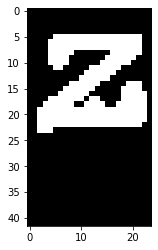

entered if
['Z', '2', 'Q', 'Q', 'S']
Z
saved an img Z
33 56
[  3  25  33  56  66  98 101 134 141 160]


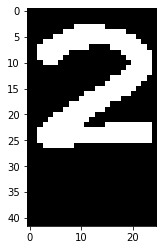

entered if
['Z', '2', 'Q', 'Q', 'S']
2
saved an img 2
66 98
[  3  25  33  56  66  98 101 134 141 160]


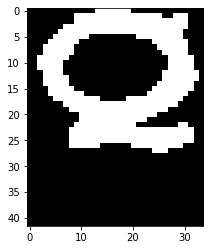

entered if
['Z', '2', 'Q', 'Q', 'S']
Q
saved an img Q
101 134
[  3  25  33  56  66  98 101 134 141 160]


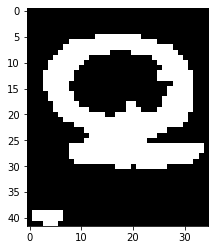

entered if
['Z', '2', 'Q', 'Q', 'S']
Q
saved an img Q
141 160
[  3  25  33  56  66  98 101 134 141 160]


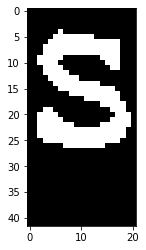

entered if
['Z', '2', 'Q', 'Q', 'S']
S
saved an img S
['Z', '2', 'T', 'K', '6']
2 23
[  2  23  28  55  65  95 100 132 139 159]


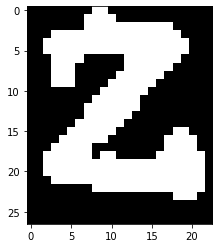

entered if
['Z', '2', 'T', 'K', '6']
Z
saved an img Z
28 55
[  2  23  28  55  65  95 100 132 139 159]


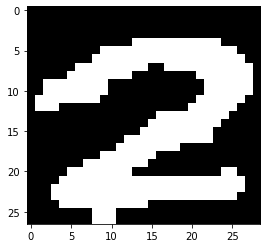

entered if
['Z', '2', 'T', 'K', '6']
2
saved an img 2
65 95
[  2  23  28  55  65  95 100 132 139 159]


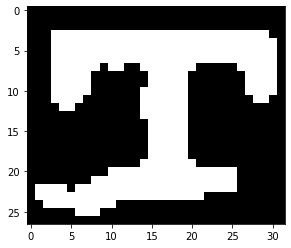

entered if
['Z', '2', 'T', 'K', '6']
T
saved an img T
100 132
[  2  23  28  55  65  95 100 132 139 159]


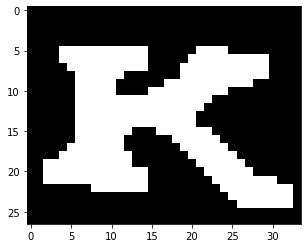

entered if
['Z', '2', 'T', 'K', '6']
K
saved an img K
139 159
[  2  23  28  55  65  95 100 132 139 159]


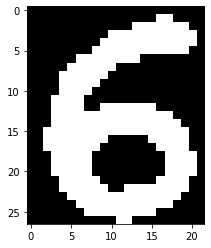

entered if
['Z', '2', 'T', 'K', '6']
6
saved an img 6
['Z', '5', 'O', '1', 'Z']
1 21
[  1  21  30  58  64  96 107 130 136 158]


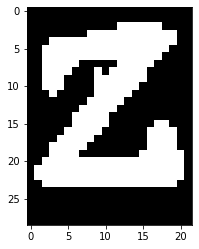

entered if
['Z', '5', 'O', '1', 'Z']
Z
saved an img Z
30 58
[  1  21  30  58  64  96 107 130 136 158]


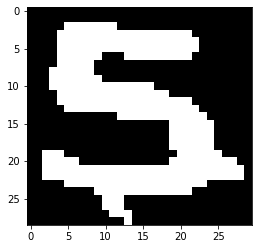

entered if
['Z', '5', 'O', '1', 'Z']
5
saved an img 5
64 96
[  1  21  30  58  64  96 107 130 136 158]


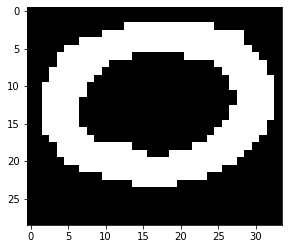

entered if
['Z', '5', 'O', '1', 'Z']
O
saved an img O
107 130
[  1  21  30  58  64  96 107 130 136 158]


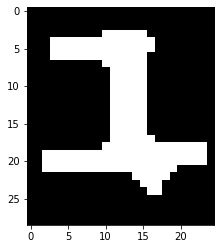

entered if
['Z', '5', 'O', '1', 'Z']
1
saved an img 1
136 158
[  1  21  30  58  64  96 107 130 136 158]


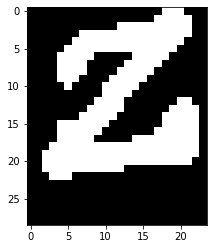

entered if
['Z', '5', 'O', '1', 'Z']
Z
saved an img Z
['Z', '6', '0', 'M', 'U']
1 25
[  1  25  35  59  68  91  99 161]


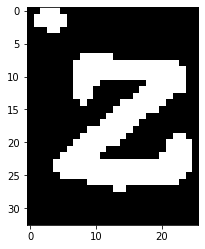

entered if
['Z', '6', '0', 'M', 'U']
Z
saved an img Z
35 59
[  1  25  35  59  68  91  99 161]


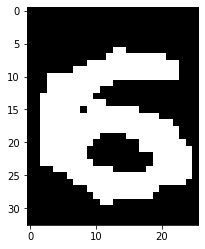

entered if
['Z', '6', '0', 'M', 'U']
6
saved an img 6
68 91
[  1  25  35  59  68  91  99 161]


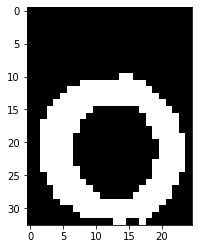

entered if
['Z', '6', '0', 'M', 'U']
0
saved an img 0
99 161
[  1  25  35  59  68  91  99 161]


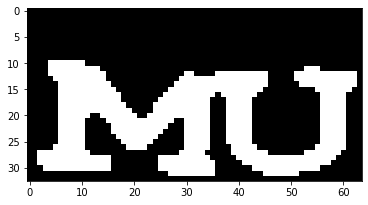

entered if
['Z', '6', '0', 'M', 'U']
M
saved an img M
['Z', '8', '9', 'H', 'K']
1 24
[  1  24  32  57  69  95 105 131 135 162]


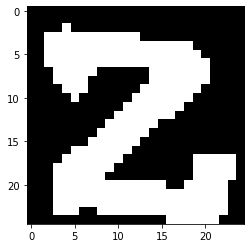

entered if
['Z', '8', '9', 'H', 'K']
Z
saved an img Z
32 57
[  1  24  32  57  69  95 105 131 135 162]


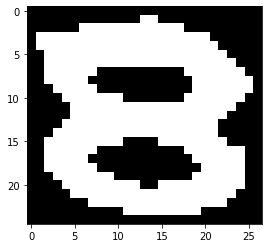

entered if
['Z', '8', '9', 'H', 'K']
8
saved an img 8
69 95
[  1  24  32  57  69  95 105 131 135 162]


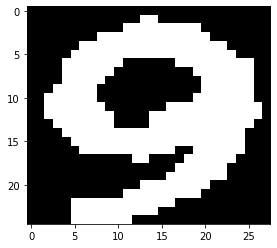

entered if
['Z', '8', '9', 'H', 'K']
9
saved an img 9
105 131
[  1  24  32  57  69  95 105 131 135 162]


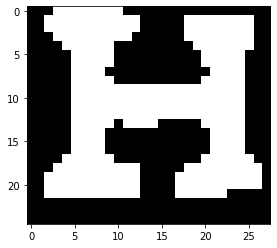

entered if
['Z', '8', '9', 'H', 'K']
H
saved an img H
135 162
[  1  24  32  57  69  95 105 131 135 162]


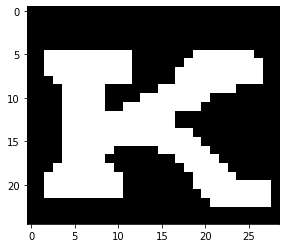

entered if
['Z', '8', '9', 'H', 'K']
K
saved an img K
['Z', '9', '3', '6', 'I']
4 23
[  4  23  34  60  68  94 109 134 139 160]


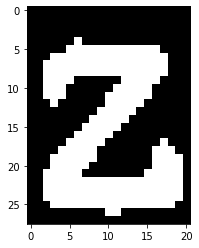

entered if
['Z', '9', '3', '6', 'I']
Z
saved an img Z
34 60
[  4  23  34  60  68  94 109 134 139 160]


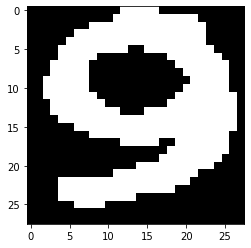

entered if
['Z', '9', '3', '6', 'I']
9
saved an img 9
68 94
[  4  23  34  60  68  94 109 134 139 160]


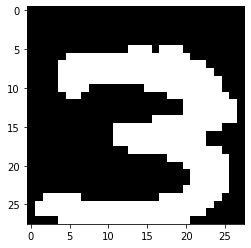

entered if
['Z', '9', '3', '6', 'I']
3
saved an img 3
109 134
[  4  23  34  60  68  94 109 134 139 160]


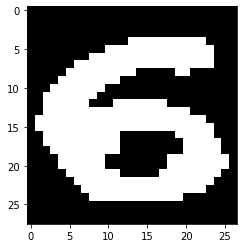

entered if
['Z', '9', '3', '6', 'I']
6
saved an img 6
139 160
[  4  23  34  60  68  94 109 134 139 160]


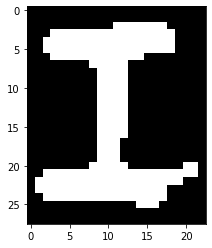

entered if
['Z', '9', '3', '6', 'I']
I
saved an img I
['Z', '9', 'P', 'E', 'F']
1 22
[  1  22  34  59  68  96 101 130 137 163]


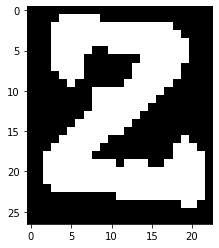

entered if
['Z', '9', 'P', 'E', 'F']
Z
saved an img Z
34 59
[  1  22  34  59  68  96 101 130 137 163]


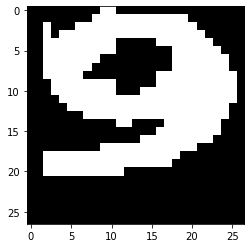

entered if
['Z', '9', 'P', 'E', 'F']
9
saved an img 9
68 96
[  1  22  34  59  68  96 101 130 137 163]


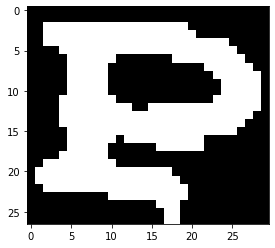

entered if
['Z', '9', 'P', 'E', 'F']
P
saved an img P
101 130
[  1  22  34  59  68  96 101 130 137 163]


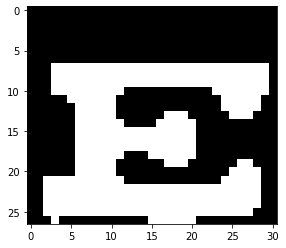

entered if
['Z', '9', 'P', 'E', 'F']
E
saved an img E
137 163
[  1  22  34  59  68  96 101 130 137 163]


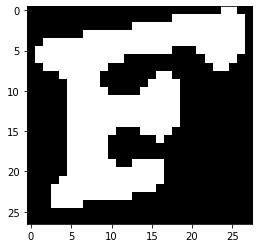

entered if
['Z', '9', 'P', 'E', 'F']
F
saved an img F
['Z', 'C', 'A', 'T', 'G']
3 25
[  3  25  30  60  64 130 137 161]


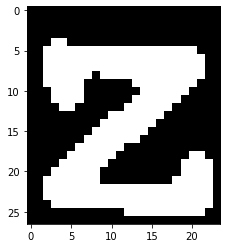

entered if
['Z', 'C', 'A', 'T', 'G']
Z
saved an img Z
30 60
[  3  25  30  60  64 130 137 161]


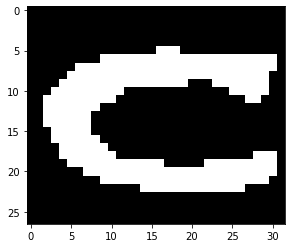

entered if
['Z', 'C', 'A', 'T', 'G']
C
saved an img C
64 130
[  3  25  30  60  64 130 137 161]


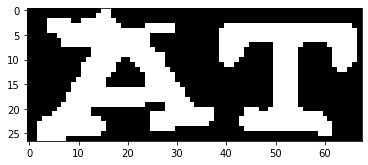

entered if
['Z', 'C', 'A', 'T', 'G']
A
saved an img A
137 161
[  3  25  30  60  64 130 137 161]


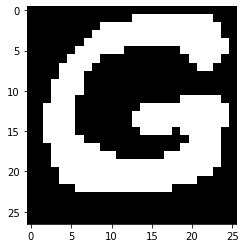

entered if
['Z', 'C', 'A', 'T', 'G']
T
saved an img T
['Z', 'E', '9', 'X', '8']
0 22
[  0  22  30  63  68  95 102 132 141 158]


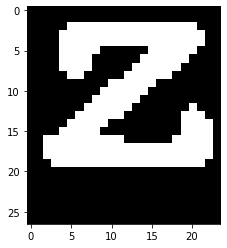

entered if
['Z', 'E', '9', 'X', '8']
Z
saved an img Z
30 63
[  0  22  30  63  68  95 102 132 141 158]


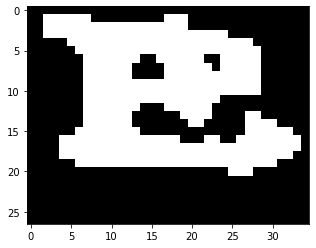

entered if
['Z', 'E', '9', 'X', '8']
E
saved an img E
68 95
[  0  22  30  63  68  95 102 132 141 158]


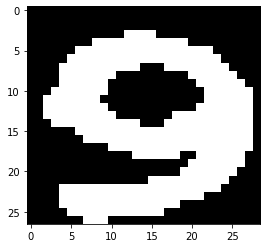

entered if
['Z', 'E', '9', 'X', '8']
9
saved an img 9
102 132
[  0  22  30  63  68  95 102 132 141 158]


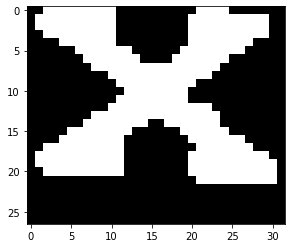

entered if
['Z', 'E', '9', 'X', '8']
X
saved an img X
141 158
[  0  22  30  63  68  95 102 132 141 158]


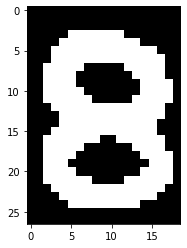

entered if
['Z', 'E', '9', 'X', '8']
8
saved an img 8
['Z', 'K', '2', '4', '2']
2 24
[  2  24  30  62  67  91 103 126 137 157]


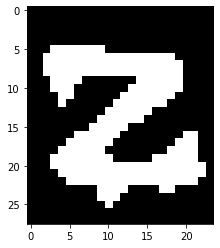

entered if
['Z', 'K', '2', '4', '2']
Z
saved an img Z
30 62
[  2  24  30  62  67  91 103 126 137 157]


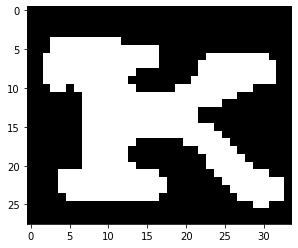

entered if
['Z', 'K', '2', '4', '2']
K
saved an img K
67 91
[  2  24  30  62  67  91 103 126 137 157]


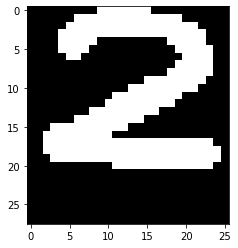

entered if
['Z', 'K', '2', '4', '2']
2
saved an img 2
103 126
[  2  24  30  62  67  91 103 126 137 157]


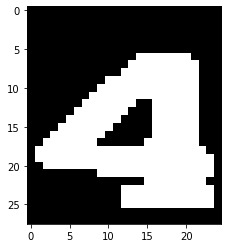

entered if
['Z', 'K', '2', '4', '2']
4
saved an img 4
137 157
[  2  24  30  62  67  91 103 126 137 157]


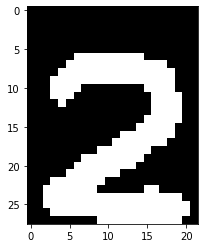

entered if
['Z', 'K', '2', '4', '2']
2
saved an img 2
['Z', 'K', 'I', '6', 'O']
0 22
[  0  22  29  59  67  91 106 129 138 161]


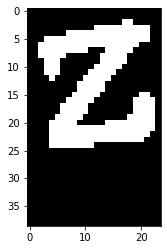

entered if
['Z', 'K', 'I', '6', 'O']
Z
saved an img Z
29 59
[  0  22  29  59  67  91 106 129 138 161]


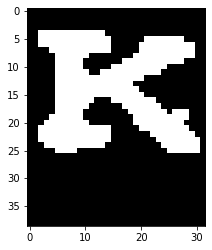

entered if
['Z', 'K', 'I', '6', 'O']
K
saved an img K
67 91
[  0  22  29  59  67  91 106 129 138 161]


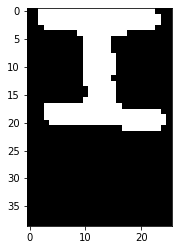

entered if
['Z', 'K', 'I', '6', 'O']
I
saved an img I
106 129
[  0  22  29  59  67  91 106 129 138 161]


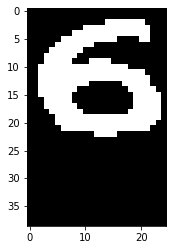

entered if
['Z', 'K', 'I', '6', 'O']
6
saved an img 6
138 161
[  0  22  29  59  67  91 106 129 138 161]


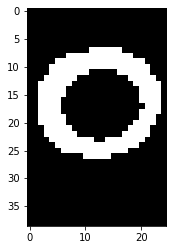

entered if
['Z', 'K', 'I', '6', 'O']
O
saved an img O
['Z', 'L', 'T', 'Z', 'O']
0 23
[  0  23  32  60  70  98 100 129 135 161]


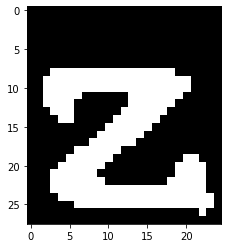

entered if
['Z', 'L', 'T', 'Z', 'O']
Z
saved an img Z
32 60
[  0  23  32  60  70  98 100 129 135 161]


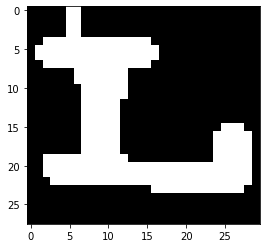

entered if
['Z', 'L', 'T', 'Z', 'O']
L
saved an img L
70 98
[  0  23  32  60  70  98 100 129 135 161]


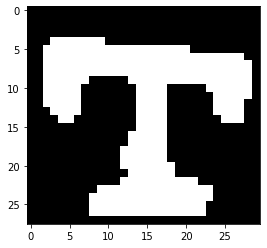

entered if
['Z', 'L', 'T', 'Z', 'O']
T
saved an img T
100 129
[  0  23  32  60  70  98 100 129 135 161]


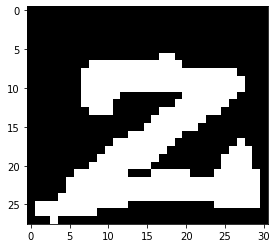

entered if
['Z', 'L', 'T', 'Z', 'O']
Z
saved an img Z
135 161
[  0  23  32  60  70  98 100 129 135 161]


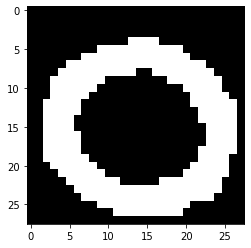

entered if
['Z', 'L', 'T', 'Z', 'O']
O
saved an img O
['Z', 'O', 'W', 'F', 'I']
2 23
[  2  23  29  56  66 132 136]


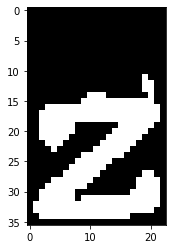

entered if
['Z', 'O', 'W', 'F', 'I']
Z
saved an img Z
29 56
[  2  23  29  56  66 132 136]


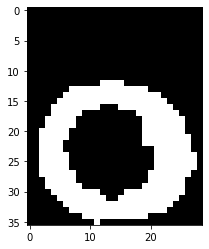

entered if
['Z', 'O', 'W', 'F', 'I']
O
saved an img O
66 132
[  2  23  29  56  66 132 136]


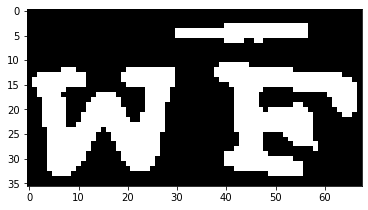

entered if
['Z', 'O', 'W', 'F', 'I']
W
saved an img W
['Z', 'P', 'N', 'X', 'L']
3 23
[  3  23  30  60  66 131 138 163]


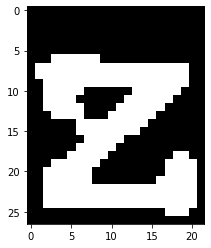

entered if
['Z', 'P', 'N', 'X', 'L']
Z
saved an img Z
30 60
[  3  23  30  60  66 131 138 163]


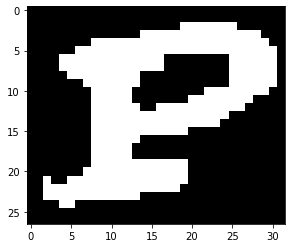

entered if
['Z', 'P', 'N', 'X', 'L']
P
saved an img P
66 131
[  3  23  30  60  66 131 138 163]


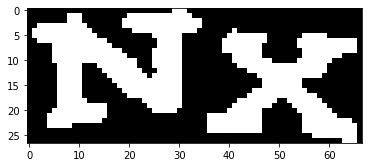

entered if
['Z', 'P', 'N', 'X', 'L']
N
saved an img N
138 163
[  3  23  30  60  66 131 138 163]


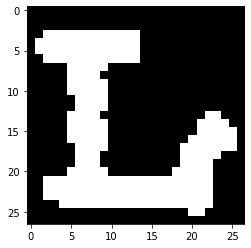

entered if
['Z', 'P', 'N', 'X', 'L']
X
saved an img X
['Z', 'U', '1', 'Z', '4']
3 26
[  3  26  30  60  67  91 104 129 139 159]


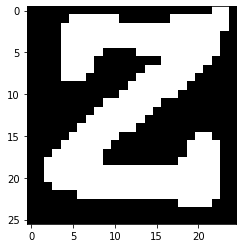

entered if
['Z', 'U', '1', 'Z', '4']
Z
saved an img Z
30 60
[  3  26  30  60  67  91 104 129 139 159]


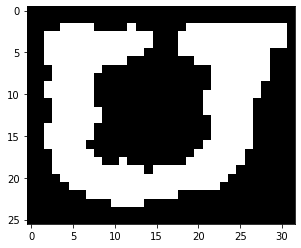

entered if
['Z', 'U', '1', 'Z', '4']
U
saved an img U
67 91
[  3  26  30  60  67  91 104 129 139 159]


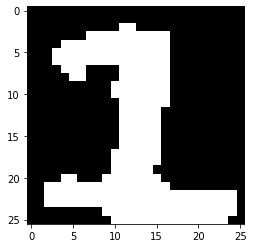

entered if
['Z', 'U', '1', 'Z', '4']
1
saved an img 1
104 129
[  3  26  30  60  67  91 104 129 139 159]


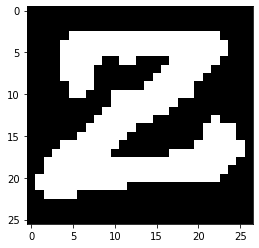

entered if
['Z', 'U', '1', 'Z', '4']
Z
saved an img Z
139 159
[  3  26  30  60  67  91 104 129 139 159]


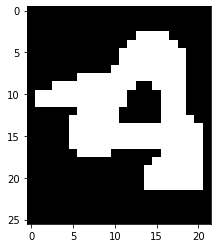

entered if
['Z', 'U', '1', 'Z', '4']
4
saved an img 4
['Z', 'Y', 'D', '8', 'T']
4 25
[  4  25  31  60  63  93 105 129 135 161]


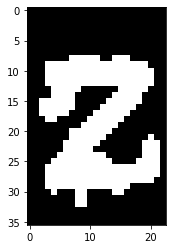

entered if
['Z', 'Y', 'D', '8', 'T']
Z
saved an img Z
31 60
[  4  25  31  60  63  93 105 129 135 161]


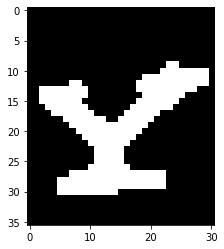

entered if
['Z', 'Y', 'D', '8', 'T']
Y
saved an img Y
63 93
[  4  25  31  60  63  93 105 129 135 161]


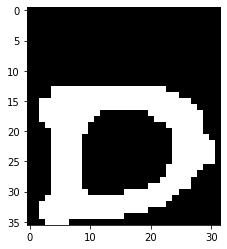

entered if
['Z', 'Y', 'D', '8', 'T']
D
saved an img D
105 129
[  4  25  31  60  63  93 105 129 135 161]


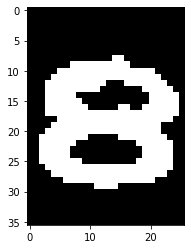

entered if
['Z', 'Y', 'D', '8', 'T']
8
saved an img 8
135 161
[  4  25  31  60  63  93 105 129 135 161]


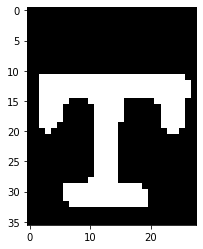

entered if
['Z', 'Y', 'D', '8', 'T']
T
saved an img T


In [108]:
# Generalization for the whole dataset

# iterating through the dataset
for image in range(0,len(images)-1):
    preprocessed = preprocessing(images[image])
    ax_coordinates, splitted = split_chars(preprocessed) 
    characters = [*labels[image]] # creating a list of the characters in the label of the image
    print(characters)
    save_chars(ax_coordinates, splitted, characters)

## Resizing the data

All of the images should be the same size in order to be passed to a CNN.

To acheive this, we first calculate the average height and width for the images in the dataset.
Then we resize the images to the average height and width, accordingly.

In [113]:
def calculate_mean_size():
    widths = []
    heights = []
    all_folders = r"E:\OpenCV\Characters"
    
    for character_folder in os.listdir(all_folders):
        for file in os.listdir(all_folders+ "\\"+character_folder):
            f=all_folders+ "\\"+character_folder+"\\"+file
            f_img = f
            #print(character_folder)
            img = Image.open(f_img)
            #print(img.size)
            widths.append(img.size[0])
            heights.append(img.size[1])
            
    AVG_HEIGHT = round(sum(heights)/len(heights))
    AVG_WIDTH = round(sum(widths)/len(widths))
    print(f"Average height is {AVG_HEIGHT}")
    print(f"Average width is {AVG_WIDTH}")
        
    return AVG_HEIGHT, AVG_WIDTH
    
calculate_mean_size()

Average height is 29
Average width is 28


(29, 28)

In [116]:
def resize_with_mean_size(*dimensions):
    all_folders = r"E:\OpenCV\Characters"
    
    for character_folder in os.listdir(all_folders):
        for file in os.listdir(all_folders+ "\\"+character_folder):
            f=all_folders+ "\\"+character_folder+"\\"+file
            f_img = f
            #print(character_folder)
            img = Image.open(f_img)    
            img = img.resize((dimensions[0],dimensions[1]))
            img.save(f_img)
            
resize_with_mean_size(*calculate_mean_size())    

Average height is 28
Average width is 29


# Training

In [3]:
# training a convolutional neural network with parameters that correspond to the input images
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # convolutional layer (sees 29x28x1 image tensor)
        self.conv1 = nn.Conv2d(1, 3, kernel_size=3)
        # convolutional layer (sees 27x26x3 tensor)
        self.conv2 = nn.Conv2d(3, 3, kernel_size=3)
        # linear layer (25 * 24 * 3 -> 108)
        self.fc1 = nn.Linear(25*24*3, 108)
        # linear layer (108 -> 36)
        self.fc2 = nn.Linear(108, 36)
    def forward(self, x):
        # sequance of convolutional layers with relu activation
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        # flatten the image input
        x = x.view(-1, 25*24*3)
        # 1st hidden layer with relu activation
        x = F.relu(self.fc1(x))
        # output-layer
        x = self.fc2(x)
        return x

In [64]:
# Resize the images and convert to tensors
transform = torchvision.transforms.Compose([torchvision.transforms.Resize((29,28)), 
            torchvision.transforms.Grayscale(num_output_channels=1),
            torchvision.transforms.ToTensor()])

In [57]:
# loads dataset from folder named train
dset = torchvision.datasets.ImageFolder(root='E:\\OpenCV\\Characters\\train', transform=transform)
dloader = torch.utils.data.DataLoader(dset,
    batch_size=6, shuffle=True, num_workers=12)

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
net = Net()
net.to(device)

Net(
  (conv1): Conv2d(1, 3, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=1800, out_features=108, bias=True)
  (fc2): Linear(in_features=108, out_features=36, bias=True)
)

In [71]:
# specify loss function (categorical cross-entropy)
criterion = nn.CrossEntropyLoss()

# specify optimizer
optimizer = torch.optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

n_epochs = 70

for epoch in range(n_epochs):
    running_loss = 0.0
    for i, (inp, lab) in enumerate(dloader, 0):
        inp = inp.to(device)
        lab = lab.to(device)

        # clear the gradients 
        optimizer.zero_grad()
        
        # forward pass
        outs = net(inp)
        
        # batch loss
        loss = criterion(outs, lab)
        
        # backward pass
        loss.backward()
        
        # perform optimization(parameter update)
        optimizer.step()

        running_loss += loss.item()
        
        if i % 100 == 99:
            print('[%d, %d] loss: %f' % (epoch + 1, i+1, running_loss))
            running_loss = 0.0
            
print('finished')

# save the trained model
torch.save(net, 'C:\\Users\\angelamadjar\\Desktop\\model.pt')

[1, 100] loss: 358.213955
[2, 100] loss: 356.438898
[3, 100] loss: 348.904238
[4, 100] loss: 249.887382
[5, 100] loss: 113.525102
[6, 100] loss: 76.303208
[7, 100] loss: 58.683299
[8, 100] loss: 43.883338
[9, 100] loss: 42.249962
[10, 100] loss: 28.239178
[11, 100] loss: 21.709843
[12, 100] loss: 21.857516
[13, 100] loss: 15.337718
[14, 100] loss: 12.191433
[15, 100] loss: 10.398229
[16, 100] loss: 9.711135
[17, 100] loss: 13.269112
[18, 100] loss: 12.922513
[19, 100] loss: 9.110654
[20, 100] loss: 5.555175
[21, 100] loss: 4.913799
[22, 100] loss: 4.138622
[23, 100] loss: 4.448187
[24, 100] loss: 4.409982
[25, 100] loss: 2.062883
[26, 100] loss: 3.658127
[27, 100] loss: 2.756918
[28, 100] loss: 1.981165
[29, 100] loss: 2.306705
[30, 100] loss: 2.630915
[31, 100] loss: 1.637088
[32, 100] loss: 4.114666
[33, 100] loss: 3.432933
[34, 100] loss: 1.953150
[35, 100] loss: 3.844941
[36, 100] loss: 1.701077
[37, 100] loss: 6.407590
[38, 100] loss: 2.994136
[39, 100] loss: 6.372079
[40, 100] lo

# Testing

In [11]:
# Resize the images and convert to tensors
# The same process as in the training, but this time we use new, previously unseen character photos (20% of the obtained character dataset)
transform = torchvision.transforms.Compose([torchvision.transforms.Scale((29,28)),
            torchvision.transforms.Grayscale(num_output_channels=1),
            torchvision.transforms.ToTensor()])

C:\Users\angelamadjar\anaconda3\lib\site-packages\torchvision\transforms\transforms.py:310: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  warnings.warn("The use of the transforms.Scale transform is deprecated, " +


In [12]:
dset = torchvision.datasets.ImageFolder(root='E:\\OpenCV\\Characters\\test', transform=transform)
dloader = torch.utils.data.DataLoader(dset,
    batch_size=8, shuffle=True, num_workers=12)

C:\Users\angelamadjar\anaconda3\lib\site-packages\torch\utils\data\dataloader.py:478: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 8 (`cpuset` is not taken into account), which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


## Accuracy

In [13]:
total = 0
correct = 0

net = torch.load('C:\\Users\\angelamadjar\\Desktop\\model.pt').to(device)
with torch.no_grad():
    for i, (inp,lab) in enumerate(dloader,0):
        inp = inp.to(device)
        lab = lab.to(device)

        # forward pass
        outs = net(inp)
        # convert output scores to predicted class
        _, pred = torch.max(outs,1)
        correct += (pred == lab).sum().item()
        total += lab.size(0)

print('Accuracy: %f %%' % (100*correct/total))

Accuracy: 91.111111 %


# The model in practice

In [14]:
# This function essentially combines the split_chars function() and the cutting sub-images in the save_chars() function 
# (the splitting was previously done in save_chars() as a way to automate the process of saving and categorizing the obtained subimages)

def separate(url):
    characters=[]
    preprocessed = preprocessing(url)
    img = cv2.cvtColor(preprocessed, cv2.IMREAD_GRAYSCALE)
    edges = cv2.Canny(img,100,200)
    vertical_sum = np.sum(edges, axis=0)
    vertical_sum = vertical_sum != 0
    changes = np.logical_xor(vertical_sum[1:], vertical_sum[:-1])
    change_pts = np.nonzero(changes)[0]
    
    for x, y in pairwise(change_pts):
        # image[start_x:end_x, start_y:end_y]
        crop = img[0:50, x:y+2] 
        characters.append(crop)
    
    return characters

In [7]:
# we noticed that the model produces the right output and recognizes the digits in the captchas as it should
# the letters in the captcha were classified correctly as well, but instead of outputting the category's name, it outputted the index of the category

# for example, instead of outputting A, it outputted 10 because A is the 10th folder (category) in the provided path

# that's why we mapped each number starting from 10 to 36 (num of folders akka num of unique chars in the labels) to the letters in the english alphabet

d = dict(enumerate(string.ascii_uppercase, start=10))
print(d[11]) # B

B


The break_captcha function is using the train model to classify the characters detected in the passed captcha

In [15]:
model = torch.load('C:\\Users\\angelamadjar\\Desktop\\model.pt', map_location='cpu')

def break_captcha(image_url):
    chars = separate(image_url)
    chars_resized = [[cv2.resize(char, (28, 29))] for char in chars]
    tens = torch.tensor(chars_resized, dtype=torch.float32) / 255
    with torch.no_grad():
        result = model(torch.mean(tens,-1))
        _, nums = torch.max(result, 1)
    out = [num.item() for num in nums]
    
    captcha = ""
    for i in out:            # for each character in the output
        if i in range(0,10): # check if it is a number from 0 to 9
            captcha += str(i)
        else:                # if not, map the number to a letter
            captcha += str(d[i])

    return captcha

## Results :)

To visualize the passed captcha: <br>
img = cv2.imread("C:\\Users\\angelamadjar\\Documents\\Downloads\\archive (1)\\teltest2\\9H2PW.png") <br>
plt.imshow(img) <br>

It gets stuck on * when I try to run the code above and I can't fix it

In [16]:
break_captcha("C:\\Users\\angelamadjar\\Documents\\Downloads\\archive (1)\\teltest2\\9H2PW.png")

'9H2PW'

In [17]:
break_captcha("C:\\Users\\angelamadjar\\Documents\\Downloads\\archive (1)\\teltest2\\02KKK.png")

'02KKK'